# OFDM with QAM Modulation - Transmitter

Bit stream -> M-QAM -> OFDM -> Noise -> Visualizations 



In [28]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import savemat
import os
ifft_size = 720 # FFT size = number of subcarriers 
cp_length = 80
num_symbols = 20
mod_order = 16 # modulation order (e.g., 16-QAM)
num_active = 109 # number of active subcarriers 

Ld = ifft_size
Ls = Ld + cp_length 
dc_index = ifft_size // 2 
half = num_active // 2
active_subcarriers = list(range(dc_index - half, dc_index)) + \
                     list(range(dc_index + 1, dc_index + half + 1))


ifft_size = 720: This determines the total number of subcarriers (both active and inactive) in each OFDM symbol. 

You can think of this as the size of your frequency grid — you have 720 "slots" in the frequency domain.

cp_length = 80: Length of the cyclic prefix added to each OFDM symbol (used to combat ISI).

num_symbols = 20: This refers to the number of OFDM time-domain symbols you generate in total — i.e., how many different time samples (each one made from 720 subcarriers) you will create.

M-QAM: This tells us that each active subcarrier carries \(log_2(M)\) bits per OFDM symbol 

Think of it like a matrix:

- Each row is an OFDM symbol in time (20 total).
- Each column is a subcarrier (720 total, but maybe only ~109 are "active").

So we have 

$[720 subcarriers × 20 symbols]$

structure before applying IFFT + CP.

Each OFDM symbol uses the full set of subcarriers (but not all need to be modulated — often you zero-out the edges or DC).

Why 109 active subcarriers? 

The choice of 109 active subcarriers is arbitrary and design-dependent — it's not fixed by the IFFT size (720).

Even though your IFFT size is 720, not all subcarriers are used for data transmission.

DC Subcarrier (Center Frequency): The subcarrier at index 720/2 +1 = 361, corresponds to 0 Hz (DC), it is not used because it causes interference and no information is transmitted at 0 Hz.

Guard Bands: Subcarriers at the edges of the IFFT spectrum are usually zero-padded (i.e., set to 0) to prevent spectral leakage and simplify filtering. These are called guard subcarriers. This is especially important when OFDM signals are adjacent to other channels (e.g., LTE or WiFi).

Pilot Subcarriers (optional): Some subcarriers are used for channel estimation and synchronization — they don't carry data but help the receiver align and equalize.

\begin{array}{|l|c|l|}
\hline
\textbf{Region} & \textbf{Subcarrier Indices} & \textbf{Purpose} \\
\hline
\text{1. Guard (left)} & 1\text{ to }306 & \text{Zero-padded (guard)} \\
\text{2. Active (lower)} & 307\text{ to }360 & \text{QPSK data} \\
\text{3. DC} & 361 & \text{Explicitly nulled} \\
\text{4. Active (upper)} & 362\text{ to }415 & \text{QPSK data} \\
\text{5. Guard (right)} & 416\text{ to }720 & \text{Zero-padded (guard)} \\
\hline
\end{array}





### General M-QAM Mapping 

#### M-QAM Mapping

In **square M-QAM**, the constellation is a square grid:

* For **16-QAM**, the grid is $4 \times 4$
* For **64-QAM**, it's $8 \times 8$

That means:

* Half the bits control the **in-phase (I)** component
* Half control the **quadrature (Q)** component


#### 1. `bits_per_axis = bits_per_symbol // 2`

This divides the total bits per symbol equally between the **I** and **Q** axes.

| Modulation | bits\_per\_symbol | bits\_per\_axis |
| ---------- | ----------------- | --------------- |
| QPSK (4)   | 2                 | 1               |
| 16-QAM     | 4                 | 2               |
| 64-QAM     | 6                 | 3               |

So:

* Each **QAM symbol** = `bits_per_symbol` bits
* $2^{\text{bits\_per\_axis}}$ levels per axis


#### 2. `M_axis = sqrt(mod_order)`

This calculates the number of levels **per dimension** in the constellation.

| mod\_order | M\_axis |
| ---------- | ------- |
| 4          | 2       |
| 16         | 4       |
| 64         | 8       |

So for 16-QAM, each axis (I/Q) has 4 possible values (e.g., $-3, -1, +1, +3$)

---

#### 3. Splitting Bits into I and Q

```python
bits_I = symbols_bin[:, :bits_per_axis]   # First half of bits
bits_Q = symbols_bin[:, bits_per_axis:]   # Second half of bits
```

We're taking the `symbols_bin` matrix (shape: `[num_symbols, bits_per_symbol]`), and for each row:

* The **first half** goes to `bits_I`
* The **second half** goes to `bits_Q`

These are used to modulate:

* I: horizontal axis of constellation (real part)
* Q: vertical axis (imaginary part)

---

#### Example: 16-QAM

For one QAM symbol:

```python
bits = [1, 0, 1, 1]
```

```python
bits_I = [1, 0] → decimal 2 → I component
bits_Q = [1, 1] → decimal 3 → Q component
```

Then mapped to:

* $I = 2 \times 2 - 3 = +1$
* $Q = 2 \times 3 - 3 = +3$

Final complex symbol:

```python
qam_data = 1 + j*3
```



In [29]:
def generate_mqam_symbols(mod_order, num_active, num_symbols):
    
    bits_per_symbol = int(np.log2(mod_order))
    total_bits = num_active * num_symbols * bits_per_symbol
    bits = np.random.randint(0,2,total_bits) # generate random bits [low = 0, high = 2) = [0,1]
    symbol_bin = bits.reshape(-1,bits_per_symbol) # e.g, 4360 bits will be (1090,4) if log2(M) = 4
    # reshape(-1,x), automatically figures out how many rows are needed so each row has x columns 
    # QAM parameters: 
    bits_per_axis = bits_per_symbol // 2   # divide bits equally for I & Q
    M_axis = int(np.sqrt(mod_order)) # number of constellation points per axis 
    # split bits into I, Q parts: 
    bits_I = symbol_bin[:, :bits_per_axis] # Take I bits from each row 
    bits_Q = symbol_bin[:, bits_per_axis:] # Takes Q bits from each row 

    # Converting each row of array of binary bits into decimal (integer) value similar to bi2de() in matlab 
    def bin2dec(arr): 
        return arr.dot(1 << np.arange(arr.shape[-1]-1,-1,-1))
    
    I_indices = bin2dec(bits_I)
    Q_indices = bin2dec(bits_Q) 

    # Map to constellation points
    I_vals = 2*I_indices - (M_axis - 1)
    Q_vals = 2*Q_indices - (M_axis - 1)

    qam_data = I_vals + 1j*Q_vals 
    qam_data /= np.sqrt(np.mean(np.abs(qam_data)**2))

    return qam_data, bits 
    

In [30]:
qam_data, bits = generate_mqam_symbols(mod_order, num_active, num_symbols)
print("QAM symbols shape:", qam_data.shape)  

QAM symbols shape: (2180,)


#### Further Steps: 

1. Bit Stream Generation

2. Modulation groups every 2 bits → 1 complex symbol, Output: A stream of complex symbols.

3. Serial to parallel conversion:

    - Divide the complex symbol stream into blocks of size equal to the number of active subcarriers (e.g., 109).

    - These form frequency-domain vectors for each OFDM symbol.

4. Subcarrier mapping: 
Map each block of complex symbols to specific active subcarriers in the full IFFT grid (e.g., 720-point vector). Set unused subcarriers and DC to 0.

5. IFFT: Apply IFFT (e.g., 720-point) to each frequency-domain OFDM symbol to convert it into a time-domain signal.
Output: time-domain complex samples for each OFDM symbol.

6. Cyclic Prefix (CP) Addition: 
Copy the last cp_length samples of the IFFT output and prepend them to the symbol.
This helps with multipath channel resilience.

7. Parallel-to-Serial Conversion

    - Convert the CP-added symbols back into a serial stream for DAC transmission.
    OFDM Signal generation

    - OFDM divides the total channel bandwidth into multiple orthogonal subcarriers. Each subcarrier carries a portion of the data in parallel, making the system resilient to multipath fading and ISI.

Let:

    N: IFFT size (number of subcarriers)
    X[k]: Modulated symbol (e.g., QPSK, M-QAM) on the k-th subcarrier
    x[n]: Time-domain OFDM signal

$$x[n] = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} X[k] \cdot e^{j\, \frac{2\,\pi \,k\,n}{N}}, \quad n = 0, 1, \dots, N-1
$$

Subcarrier Allocation and DC Nulling

Active subcarriers are chosen symmetrically around the center.

The DC subcarrier (at k = N/2) is set to zero to eliminate carrier leakage.

Guard bands are left unused to avoid spectral leakage into adjacent channels.

To combat Inter-Symbol Interference (ISI), a Cyclic Prefix of length  is added by copying the last samples of the time-domain symbol and appending them to the front.

$$
x_{\text{cp}}[n] =
\begin{cases}
x[n + N - L_{\text{CP}}], & 0 \leq n < L_{\text{CP}} \\
x[n - L_{\text{CP}}], & L_{\text{CP}} \leq n < N + L_{\text{CP}}
\end{cases}
$$

The total OFDM symbol length becomes 

$$L_s = N + L_{\text{CP}}
$$

The transmit signal is constructed by concatenating multiple CP-extended OFDM symbols:

$$x_{\text{total}}[n] = \left[ \text{CP}_1 + x_1[n],\ \text{CP}_2 + x_2[n],\ \dots \right]
$$

OFDM transmits data in parallel over multiple subcarriers, each modulated at a different frequency. It uses the orthogonality of sinusoids to pack them tightly together without interference.

BUT: generating multiple sinusoids manually would be complex.

Instead of manually modulating 109 carriers with QPSK and summing sinusoids, we use the Inverse Fast Fourier Transform (IFFT).

Each point in the frequency-domain vector you pass to the IFFT acts like the amplitude/phase of a subcarrier.

The IFFT outputs a superposition of all those subcarriers — a time-domain signal.

Think of OFDM as encoding frequency data, and then IFFT transforms it into the real-world time signal you transmit.



In [31]:
def generate_ofdm_signal(qam_data, ifft_size, cp_length, num_symbols, active_subcarriers, dc_index):
    num_active = len(active_subcarriers)
    symbol_matrix = np.zeros((num_symbols, ifft_size), dtype=complex)
    ofdm_signal = []

    for i in range(num_symbols):
        # Extract QAM symbols for this OFDM symbol
        idx_start = i * num_active
        idx_end = (i + 1) * num_active
        this_symbol = qam_data[idx_start:idx_end]

        # Map symbols to subcarriers
        freq_data = np.zeros(ifft_size, dtype=complex)
        freq_data[active_subcarriers] = this_symbol
        freq_data[dc_index] = 0  # Null DC

        # IFFT to get time-domain OFDM symbol
        time_data = np.fft.ifft(freq_data) * np.sqrt(ifft_size)
        symbol_matrix[i, :] = freq_data

        # Add cyclic prefix
        cp = time_data[-cp_length:]
        ofdm_symbol = np.concatenate((cp, time_data))
        ofdm_signal.append(ofdm_symbol)

    # Concatenate all symbols into one 1D signal
    ofdm_signal = np.concatenate(ofdm_signal)

    # Normalize to unit average power
    ofdm_signal /= np.sqrt(np.mean(np.abs(ofdm_signal) ** 2))

    return ofdm_signal, symbol_matrix


In [32]:
ofdm_signal, symbol_matrix = generate_ofdm_signal(
    qam_data=qam_data,
    ifft_size=ifft_size,
    cp_length=cp_length,
    num_symbols=num_symbols,
    active_subcarriers=active_subcarriers,  
    dc_index=dc_index
)

Note: 
At this point, we have a baseband complex-valued signal, which is:

$$s_{\text{baseband}} (t) = I(t) + jQ(t)$$

To transmit it over a real-valued RF channel, we need to convert it to a passband (RF) signal using IQ modulation:

IQ Modulation (Digital-to-Analog + RF Upconversion): 

generate the real RF signal as:

$$s(t) = I(t) . cos(2\pi\, f_c t) - Q(t) . sin(2\pi f_ct)
$$

This maps the complex baseband signal to a real-valued RF signal centered at carrier frequency 

#### Noise Modeling: Additive White Gaussian Noise (AWGN)

AWGN simulates channel impairments. It is added with a controlled Signal-to-Noise Ratio (SNR):

Target SNR in dB:

$$SNR_{\text{dB}} = 10 \log_{10} \left( \frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
$$

Convert to linear scale:

$$SNR_{\text{linear}} = 10^{\text{SNR}_{\text{dB}}/10}
$$

Noise power:

$$P_{\text{noise}} = \frac{P_{\text{signal}}}{\text{SNR}_{\text{linear}}}
$$

AWGN samples:

$$w[n] = \sqrt{\frac{P_{\text{noise}}}{2}} \cdot \left( \mathcal{N}(0,1) + j \mathcal{N}(0,1) \right)
$$

Final noisy signal:

$$x_{\text{noisy}}[n] = x_{\text{total}}[n] + w[n]
$$

#### Noise Padding

To emulate practical signal capture scenarios (e.g., over-the-air or burst transmissions), noise-only regions are added before and after the useful signal.

$$x_{\text{final}}[n] = \left[ w_{\text{before}},\ x_{\text{noisy}}[n],\ w_{\text{after}} \right]
$$

This helps in testing synchronization, thresholding, and signal detection techniques.



In [33]:
def add_noise_and_pad(ofdm_signal, noise_snr_db, left_pad, right_pad, save_path='OFDM_Rx_Signal.mat'):
    # Step 1: Compute signal power and noise power
    signal_power = np.mean(np.abs(ofdm_signal)**2)
    noise_power = signal_power / (10**(noise_snr_db / 10))

    # Step 2: Add complex Gaussian noise (broadband in-band)
    noise_std = np.sqrt(noise_power / 2)
    inband_noise = noise_std * (np.random.randn(len(ofdm_signal)) + 1j * np.random.randn(len(ofdm_signal)))
    ofdm_signal_noisy = ofdm_signal + inband_noise

    # Step 3: Add noise padding
    noise_before = noise_std * (np.random.randn(left_pad) + 1j * np.random.randn(left_pad))
    noise_after  = noise_std * (np.random.randn(right_pad) + 1j * np.random.randn(right_pad))

    # Step 4: Final concatenated signal
    final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])

    # Step 5: Save to .mat file
    savemat(save_path, {'final_signal': final_signal})

    return final_signal


In [34]:
final_signal = add_noise_and_pad(ofdm_signal, noise_snr_db=25, left_pad=600, right_pad=1000)


### Visualization 

In [35]:
def ofdm_demodulate(ofdm_signal_noisy, ifft_size, cp_length):
    Ld = ifft_size
    Ls = Ld + cp_length
    num_symbols_actual = len(ofdm_signal_noisy) // Ls

    # Step 1: Reshape the noisy signal into symbols
    X_matrix = ofdm_signal_noisy[:num_symbols_actual * Ls].reshape((num_symbols_actual, Ls))

    # Step 2: Remove CP
    X_no_cp = X_matrix[:, cp_length:]  # shape: [num_symbols, Ld]

    # Step 3: FFT and shift
    X_fft = np.fft.fft(X_no_cp, axis=1)
    # X_fft = np.fft.fftshift(np.fft.fft(X_no_cp, axis=1), axes=1)
    # Step 4: Power matrix
    power_matrix = np.abs(X_fft) ** 2  # shape: [num_symbols, Ld]

    # Step 5 (Optional): Pad to full IFFT size if Ld < ifft_size
    full_power = np.zeros((num_symbols_actual, ifft_size))
    full_power[:, :Ld] = power_matrix

    return full_power, X_fft, power_matrix


In [36]:
full_power, X_fft, power_matrix = ofdm_demodulate(
    ofdm_signal_noisy=final_signal[600:-1000],  # remove the noise padding before/after
    ifft_size=ifft_size,
    cp_length=cp_length
)

Text(0.5, 1.0, 'Received OFDM Signal with Noise')

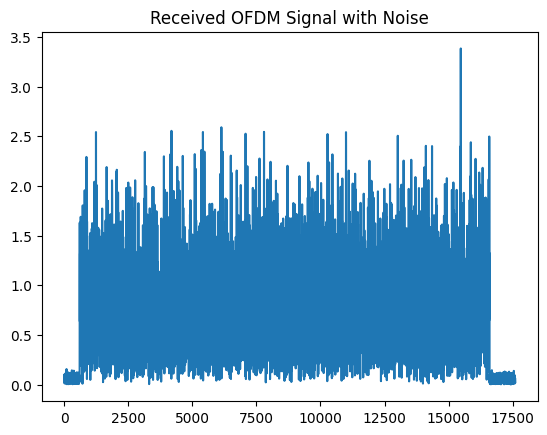

In [37]:
plt.figure(1) 
plt.plot(abs(final_signal))
plt.title('Received OFDM Signal with Noise')

In [38]:
def plot_subcarrier_power(power_matrix, ifft_size, num_symbols_actual):
    power_db = 10 * np.log10(power_matrix + 1e-12)  # avoid log(0)

    plt.figure(figsize=(12, 5))
    extent = [0, num_symbols_actual, 0, ifft_size]

    # Use jet colormap for better contrast
    im = plt.imshow(
        power_db.T,
        aspect='auto',
        extent=extent,
        origin='lower',
        cmap='jet',
        vmin=np.max(power_db) - 40,
        vmax=np.max(power_db)
    )

    plt.title('Subcarrier Power Spectrum (dB)', fontsize=14)
    plt.xlabel('OFDM Symbol Index', fontsize=12)
    plt.ylabel('Subcarrier Index', fontsize=12)
    plt.colorbar(im, label='Power (dB)')

    plt.grid(False)
    plt.tight_layout()
    plt.show()



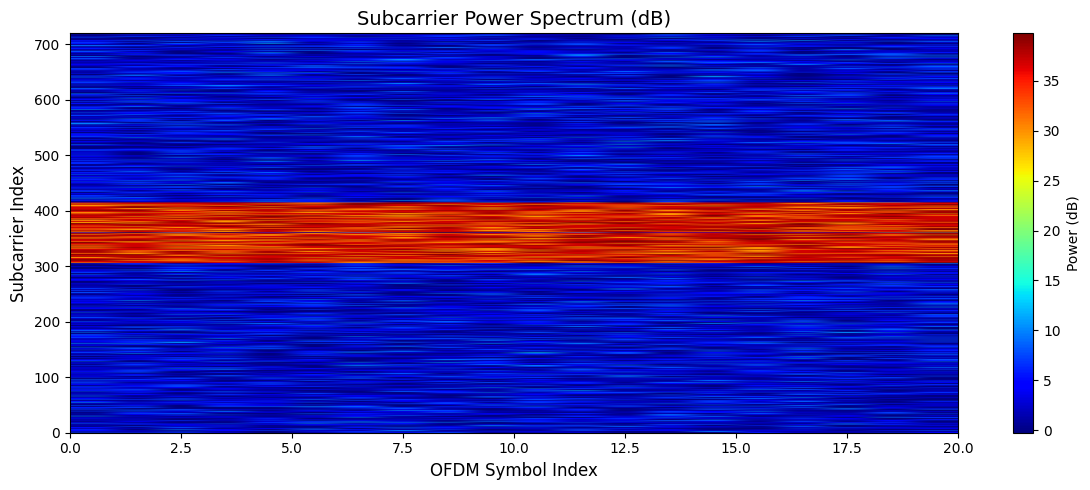

In [39]:
plot_subcarrier_power(full_power, ifft_size=720, num_symbols_actual=20)


In [40]:
def plot_autocorrelation(signal, max_lag=None):
    N = len(signal)
    if max_lag is None:
        max_lag = N // 2

    # Compute full autocorrelation (normalized)
    corr = np.correlate(signal, signal, mode='full')  # length: 2N - 1
    lags = np.arange(-N + 1, N)
    corr = corr / np.max(np.abs(corr))  # Normalize to max=1 (coeff mode)

    # Keep only positive lags
    positive_lags = lags >= 0
    lags_positive = lags[positive_lags][:max_lag]
    Rxx_positive = corr[positive_lags][:max_lag]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(lags_positive, np.abs(Rxx_positive))
    plt.title('Autocorrelation of the Received Signal')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


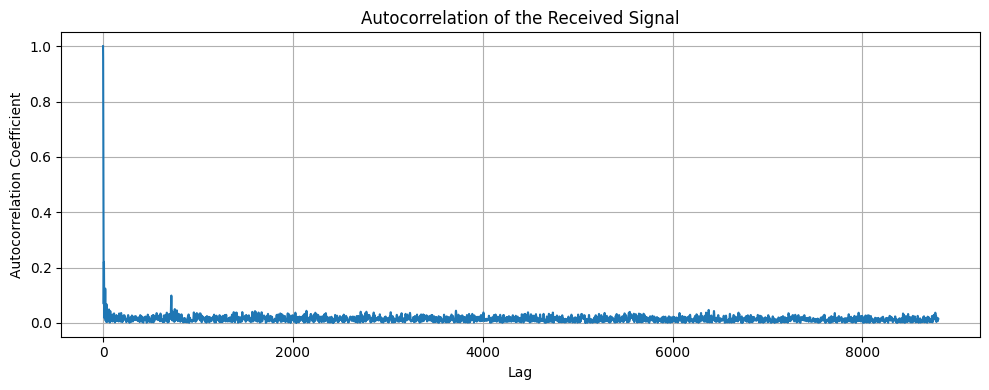

In [41]:
plot_autocorrelation(final_signal)


In [42]:
def plot_psd_strictly_symmetric(power_matrix, ifft_size, fs=1.0):
    """
    Plot PSD with guaranteed symmetry around 0 Hz.
    """
    # Step 1: Average power over OFDM symbols
    avg_power = np.mean(power_matrix, axis=0)

    # Step 2: Shift power so DC is centered
    psd_shifted = np.fft.fftshift(avg_power) / (fs / ifft_size)
    psd_db = 10 * np.log10(psd_shifted + 1e-12)

    # Step 3: Create symmetric frequency axis (avoids asymmetry from fftfreq)
    if ifft_size % 2 == 0:
        # Even size
        freq_axis = np.linspace(-fs/2, fs/2, ifft_size, endpoint=False)
    else:
        # Odd size: ensure 0 Hz is centered
        freq_axis = np.linspace(-fs/2, fs/2, ifft_size)

    # Step 4: Plot
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis, psd_db, linewidth=1.2)
    plt.title('Power Spectral Density (dB/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


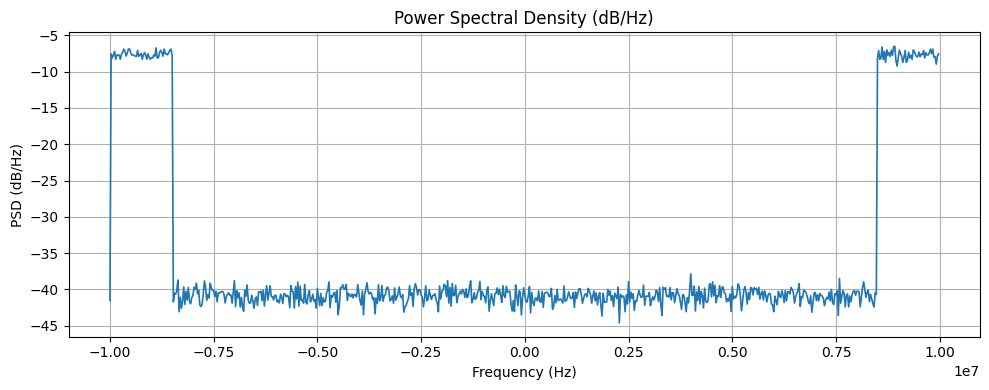

In [43]:
plot_psd_strictly_symmetric(power_matrix, ifft_size=720, fs=20e6)


In [44]:
def plot_constellation(X_fft, active_subcarriers):
    # Step 1: Extract symbols from active subcarriers (avoid DC, guard bands)
    rx_constellation = X_fft[:, active_subcarriers]  # shape: [num_symbols, num_active]

    # Step 2: Flatten to 1D array
    rx_symbols_flat = rx_constellation.flatten()

    # Step 3: Determine scaling for axis limits
    avg_power = np.mean(np.abs(rx_symbols_flat)**2)
    scale = 2 * np.sqrt(avg_power)

    # Step 4: Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(rx_symbols_flat.real, rx_symbols_flat.imag, s=10, c='blue', alpha=0.6)
    plt.title('QPSK Constellation after OFDM Demodulation')
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-scale, scale])
    plt.ylim([-scale, scale])
    plt.tight_layout()
    plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


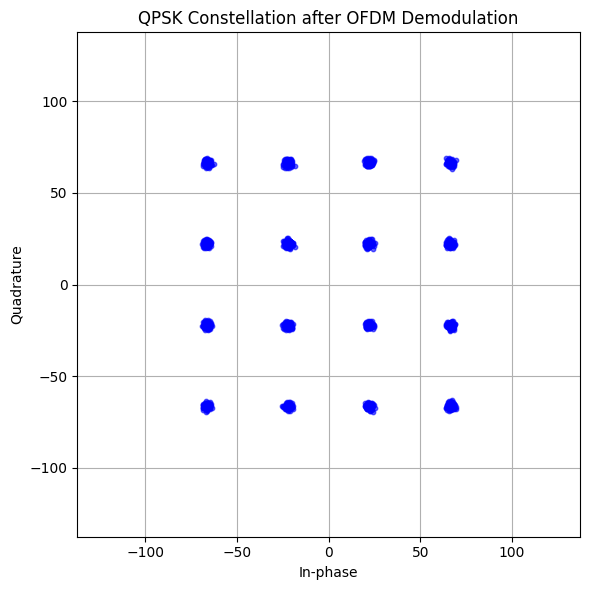

In [45]:
plot_constellation(X_fft, active_subcarriers)


---

# Receiver 

## OFDM Signal Processing (Receiver Side) 

A complete **baseband receiver-side analysis** of an OFDM signal:

* Synchronization via energy threshold and correlation
* CP detection to validate symbol structure
* FFT demodulation for symbol extraction
* Visualization of constellation and power spectrum
* Subcarrier diagnostics for quality inspection

Unkown parameters: 

- CP length
- FFT length
- Symbol start index
- Symbol stop index
- Null subcarriers

### 1. **Signal Preprocessing**

* Load the received signal (input data)
* Define OFDM parameters:
  * Estimate symbol start index 
  * Estimate symbol stop index 
  * Estimate cyclic prefix length for symbols 
  * Estimate total number of symbols

### 2. **Autocorrelation for Rough Symbol Start**

* Compute autocorrelation of the received signal to identify repeating structure.
* Detect the **initial start index** of OFDM symbols based on energy thresholding.
* Use a moving window to refine this estimate.


### 3. **Cyclic Prefix (CP) Correlation-Based Detection**

* Sweep over candidate start indices around the rough estimate.
* For each, check the correlation between CP and end of symbols.
* Select the start index that gives the **maximum average CP correlation**.


### 4. **Symbol Extraction and FFT**

* From the chosen start index, extract all OFDM symbols.
* Remove the cyclic prefix from each.
* Perform FFT on each symbol to transform to the frequency domain.
* Apply `fftshift` to center the DC subcarrier.


### 5. **Constellation Plotting**

* Flatten all subcarriers from all symbols into a single array.
* Plot real vs. imaginary values of subcarriers to visualize:

  * Identify modulation type (e.g., QPSK, QAM)
  * Analyze signal quality and distortions

### 6. **Subcarrier Power Analysis**

* Calculate power per subcarrier for each symbol.
* Identify **low-power (null or attenuated)** subcarriers.
* Use `stem` plots to highlight which subcarriers fall below a threshold (e.g., power < threshold).
* Overplot known null subcarriers for verification.


---

# 1. Signal Preprocessing 

dict_keys(['__header__', '__version__', '__globals__', 'final_signal'])


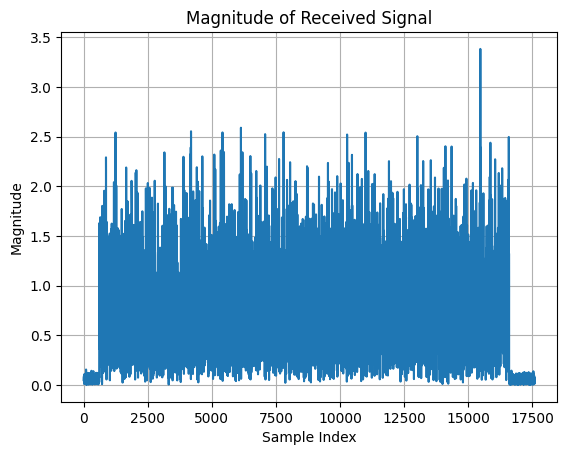

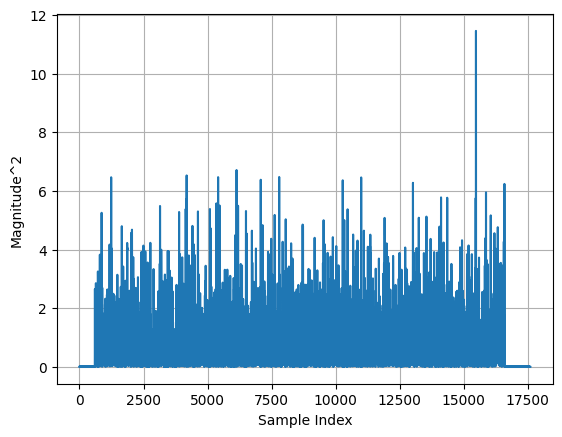

In [46]:
import scipy.io

# Load the received signal
Received = scipy.io.loadmat('OFDM_Rx_Signal.mat')

print(Received.keys())
rx_signal = Received['final_signal']  
rx_signal = rx_signal.squeeze()  # Convert (n,1) to (n,) if needed

plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.abs(rx_signal)**2)  # Magnitude
plt.xlabel('Sample Index')
plt.ylabel('Magnitude^2')
plt.grid(True)
plt.show()


## 2. Autocorrelation Analysis of Received Signal

Computing **autocorrelation** of the received signal to analyze its periodic structure and estimate symbol length.

### Autocorrelation Function

For a real-valued discrete signal $x[n]$, the autocorrelation function $R_{xx}[k]$ is defined as:

$$
R_{xx}[k] = \sum_{n} x[n] \cdot x[n+k]
$$

Where:

* $k$ is the **lag** (shift),
* For negative $k$, we evaluate $x[n] \cdot x[n - |k|]$,
* For normalization (`'coeff'`), we divide by the maximum value of $|R_{xx}[k]|$.

### Why Autocorrelation?

* Peaks in the autocorrelation function at non-zero lags can indicate **periodic patterns**.
* In digital communications, repeated symbol structures create peaks at multiples of **symbol length**.
* Here, a peak at lag = x, suggests the symbol duration is approximately **x samples**.


* Repeated peaks suggest periodicity in the received signal.
* If a peak occurs at lag ≈ x, it implies a **symbol duration** of x samples:

## Start Index Detection Based on Noise Threshold

The **start of the useful signal** in a received waveform based on power thresholding

- Estimate background noise power from the samples.
- Detect where the signal power significantly exceeds the noise.
- Mark and highlight a region around the detected start index.


### Noise Power Estimation

If roughly N samples are noisy samples at the beginning of received signal, then:

$$
P_{\text{noise}} = \frac{1}{N} \sum_{n=1}^{N} |x[n]|^2
$$

Where:

- \( x[n] \) is the received signal,
- \( |x[n]| \) is the magnitude (for complex signals).

### Threshold-Based Detection

We detect the **first index** where the signal power exceeds a multiple of the noise power:

$$
\text{start\_index} = \min \left\{ n : |x[n]|^2 > \text{Threshold} \cdot P_{\text{noise}} \right\}
$$



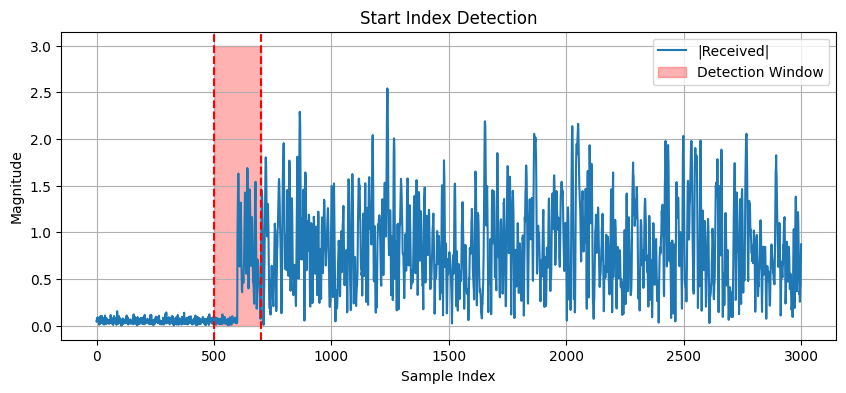

Start Index of Signal: 600


In [47]:
noise1_power = np.mean(np.abs(rx_signal[:700])**2) 
Threshold = 0.3 # the threshold factor is empirically chosen

# Find the start index where signal power exceeds noise threshold
ind = np.where(np.abs(rx_signal)**2 > Threshold * noise1_power)[0]
start_index = ind[0] if len(ind) > 0 else None

# Plot up to 5×start_index
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
plt.axvline(start_index - 100, color='r', linestyle='--')
plt.axvline(start_index + 100, color='r', linestyle='--')

# Shade the region from (start_index - 100) to (start_index + 100)
x_shade = [start_index - 100, start_index + 100, start_index + 100, start_index - 100]
y_shade = [0, 0, 3, 3]  # Adjust height if needed based on your signal

plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
plt.title("Start Index Detection")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()
print("Start Index of Signal:", start_index)

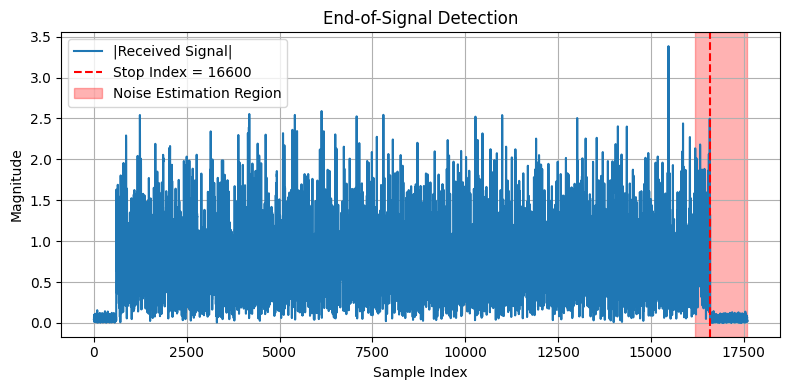

Stop Index: 16600


In [48]:
def detect_end_index(rx_signal, noise_est_start, threshold_factor, plot=True):
    # Estimate noise power from the known tail region
    noise_power = np.mean(np.abs(rx_signal[noise_est_start:])**2)
    threshold = threshold_factor * noise_power
    power = np.abs(rx_signal)**2

    # Set where to start scanning for stop index (e.g., after halfway point)
    search_start = noise_est_start  # or dynamic: len(rx_signal) // 2
    window_len = 400

    stop_index = None
    for i in range(search_start, len(rx_signal) - window_len):
        window = power[i:i+window_len]
        if np.all(window < threshold):
            stop_index = i
            break

    # Plot
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(np.abs(rx_signal), label='|Received Signal|')
        if stop_index:
            plt.axvline(stop_index, color='r', linestyle='--', label=f'Stop Index = {stop_index}')
        plt.axvspan(noise_est_start, len(rx_signal), color='red', alpha=0.3, label='Noise Estimation Region')
        plt.title('End-of-Signal Detection')
        plt.xlabel('Sample Index')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return stop_index


stop_index = detect_end_index(rx_signal, noise_est_start=16200, threshold_factor=1)
print("Stop Index:", stop_index)



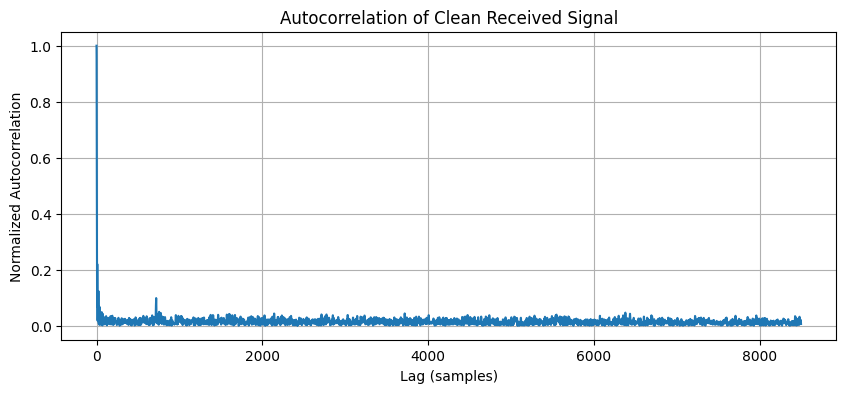

Detected peak lags: [  9 720]
Estimated Symbol Duration: 720 samples


In [49]:
from scipy.signal import find_peaks
rx_clean = rx_signal[start_index:]  # Remove noise before OFDM signal
N = len(rx_clean)
max_lag = N // 2

# Autocorrelation
Rxx_full = np.correlate(rx_clean, rx_clean, mode='full')
lags = np.arange(-N + 1, N)
Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))  # Normalize

# Take positive lags
mid_index = len(Rxx_full) // 2
Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lags_positive, np.abs(Rxx_positive))
plt.title('Autocorrelation of Clean Received Signal')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Autocorrelation')
plt.grid(True)
plt.show()

# Find peaks
peaks, _ = find_peaks(np.abs(Rxx_positive), height=0.05, distance=300)
peak_lags = lags_positive[peaks]
print("Detected peak lags:", peak_lags)

# Estimate symbol duration
if len(peak_lags) >= 2:
    diffs = np.diff(peak_lags)
    # symbol_duration_est = int(np.median(diffs))
    symbol_duration_est = peak_lags[1]
    print("Estimated Symbol Duration:", symbol_duration_est, "samples")
else:
    print("Not enough peaks found to estimate symbol duration.")


# 3. Cyclic Prefix (CP) Correlation-Based Detection

Implementing a correlation-based search to **refine the start index** of an OFDM-like signal by detecting the **CP** structure within a predefined range.

To scan a window of possible start indices near the initial estimate and find the one that:

- Maximizes **CP autocorrelation**, indicating correct symbol alignment.
- Helps identify where **OFDM symbols** begin reliably.

### OFDM Symbol Structure

- Each symbol has a **CP** prepended.
- CP is a copy of the last part of the symbol.
- This helps mitigate inter-symbol interference (ISI) and aids synchronization.

If  \(L_d\)  is the symbol length and \(L_{cp}\) is the CP length, the total symbol duration is:

$$
T_d = L_{cp} + L_d
$$



### CP Correlation Metric

To detect the symbol start, we compute the **correlation** between:

The **first \( L_{cp} \)** samples of the symbol, and  
The **last \( L_{cp} \)** samples of the same symbol.

$$
\text{Correlation}(L_{cp}) = \left| \sum_{n=0}^{L_{cp}-1} x[n] \cdot x^*[T_d - L_{cp} + n] \right|
$$

This is computed for several symbols and averaged across symbols to smooth the estimate.


### Assumptions

- Each OFDM-like symbol has length `Ld`
- The total symbol duration is `Td = L_cp + Ld`, where `L_cp` is the cyclic prefix.
- The signal starts approximately at sample 398.


For a candidate CP length `L_cp`, and a symbol starting at index \( i \), the **cyclic prefix correlation** is:

$$
Correlation(L_{cp}, i) = | sum( conj(x[0:L_{cp}]) * x[-L_{cp}:] ) |
$$

Where:

- `x` is the signal segment of one symbol of length `Td = L_cp + Ld`,

- `x[0:L_cp]` is the start (prefix),

- `x[-L_cp:]` is the end (suffix),

- The correlation magnitude evaluates cyclic similarity.

### Algorithm Steps

1. **Scan candidate start indices** from `start_index - 100` to `start_index + 100`.

2. For each candidate `j`, extract the signal: `x = rx_signal[j:]`.

3. For each possible CP length 
            $$L_{cp} \in [1, L_d/4]$$

    - Loop over 10 symbols (`i = 1` to `10`).
    - For each symbol, extract the CP and tail, then compute their correlation.


4. Store the **maximum average correlation** across CP lengths for each candidate index.

5. Identify the index with **maximum CP alignment**.



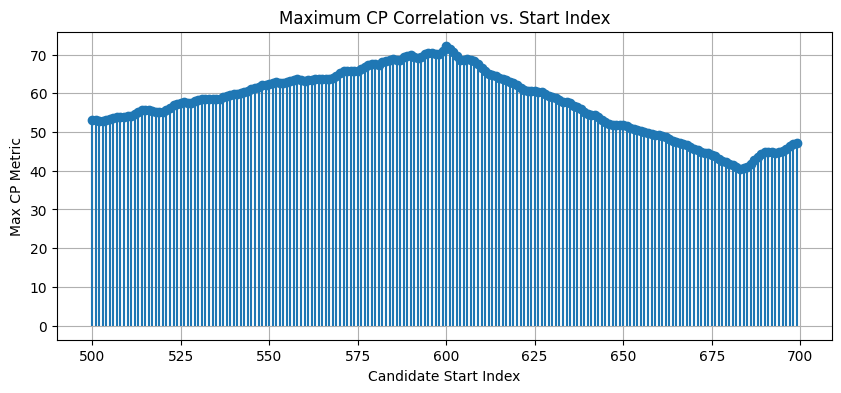

Maximum CP Metric = 72.27 at index = 600


In [50]:
Signal = rx_signal
Ld = symbol_duration_est
mm = [] # maximum metric for CP
search_range = range(start_index - 100, start_index + 100)

# Loop over potential start indices around estimated start_index
for j in search_range:
    x = Signal[j:]
    c = np.zeros((Ld // 4, 10))  # Rows: possible CP lengths, Cols: symbols (3 to 18)

    for i in range(1, 10):  # symbol indices
        for cp_len in range(1, Ld // 4 + 1):
            Td = cp_len + Ld
            start = (i - 1) * Td
            end_ = i * Td
            if end_ > len(x):
                continue
            x1 = x[start:end_]
            c[cp_len - 1, i] = np.abs(np.sum(np.conj(x1[:cp_len]) * x1[-cp_len:]))

    cp_avg = np.mean(c, axis=1)
    mm.append(np.max(cp_avg))

j_range = list(search_range)
mm = np.array(mm)

plt.figure(figsize=(10, 4))
plt.stem(j_range, mm, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.title("Maximum CP Correlation vs. Start Index")
plt.xlabel("Candidate Start Index")
plt.ylabel("Max CP Metric")
plt.grid(True)
plt.show()

# Best start
mm_max_idx = j_range[np.argmax(mm)]
print(f"Maximum CP Metric = {np.max(mm):.2f} at index = {mm_max_idx}")

# print("prvious start index:", start_index)
# print("new start index:", mm_max_idx)
# start_index = mm_max_idx + 1


### Cyclic Prefix Estimation for Fixed Start Index

Examining the structure of an OFDM-like signal starting from a fixed `start_index` to evaluate the correlation between the cyclic prefix and the end of each symbol.

- Detect if the signal exhibits repeated cyclic structure.
- Plot correlation metrics per symbol.
- Average correlation results to validate CP length estimation.


### Algorithm

1. For each symbol index `i = 1` to `10`:

   - Try all possible CP lengths from 1 to `Ld / 4`.

   - Extract the full symbol of length `Td = L_cp + Ld`.

   - Compute correlation between prefix and suffix.

   - Store result in a matrix `c`.

2. Plot correlation profile for each symbol:

   - X-axis: CP length candidate
   - Y-axis: Correlation magnitude

3. Average the CP correlation results over all symbols:

   - This helps remove noise and verify stable structure.

4. Report maximum averaged correlation:

   - Indicates strongest CP candidate for alignment.



This analysis helps visually verify whether a **cyclic prefix structure** exists and if the starting point is aligned with the symbol boundary.

- Sharp peaks in correlation plots confirm cyclic structure.
- High average correlation across multiple symbols suggests reliable CP detection.


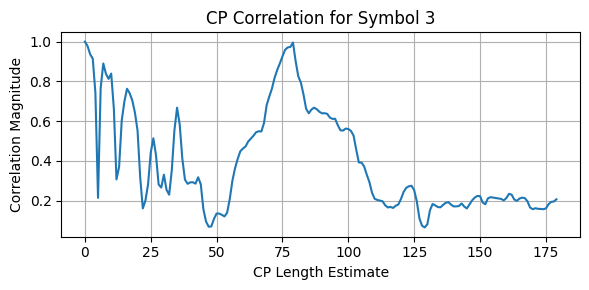

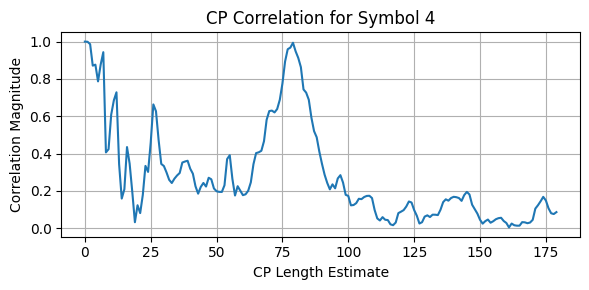

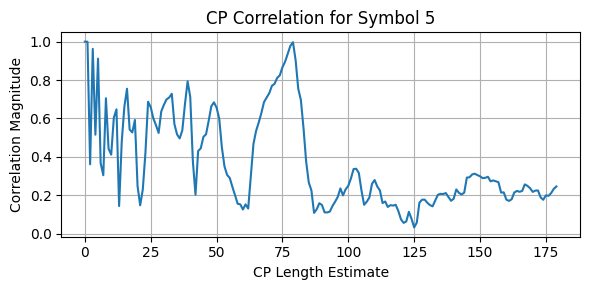

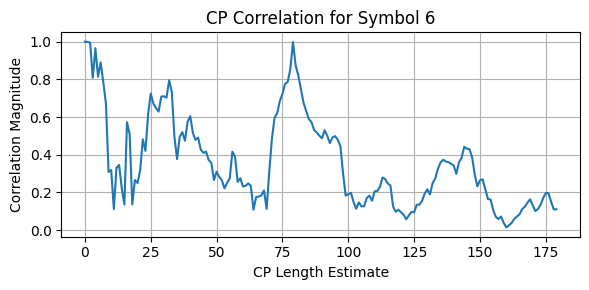

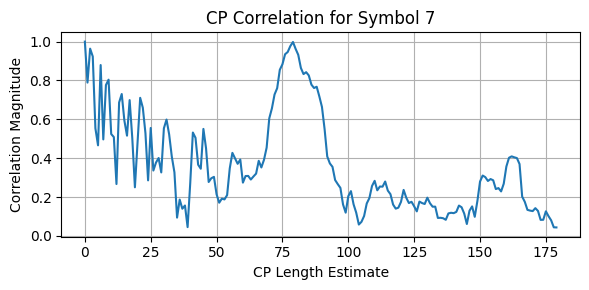

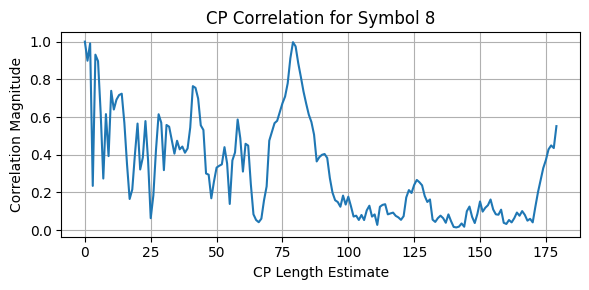

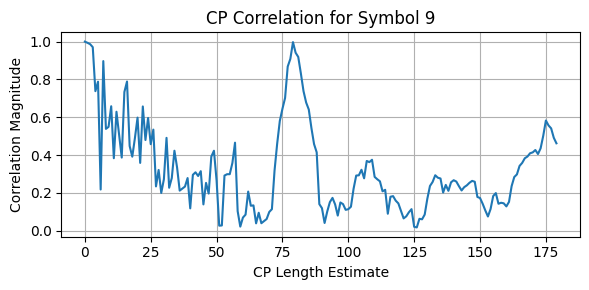

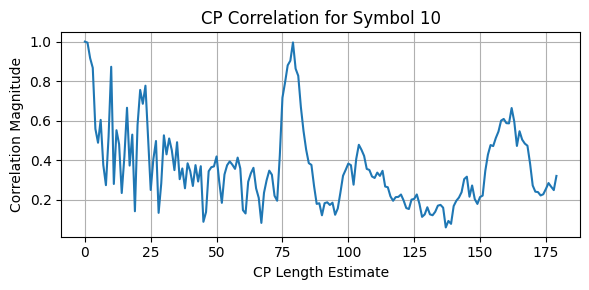

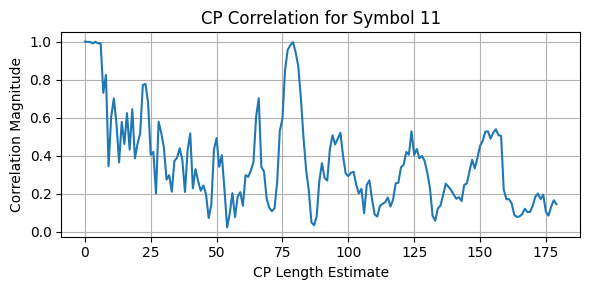

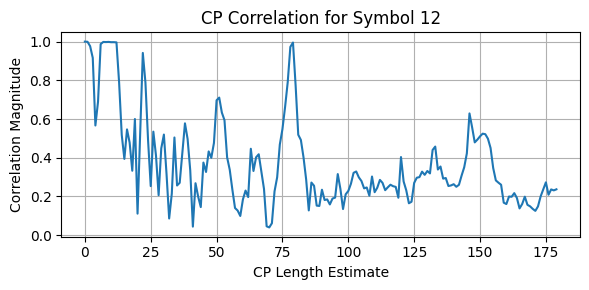

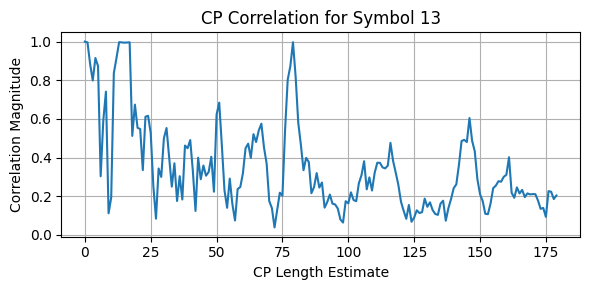

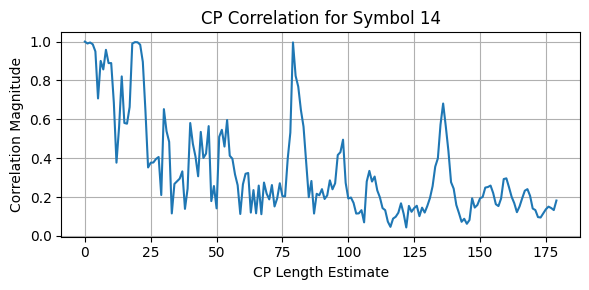

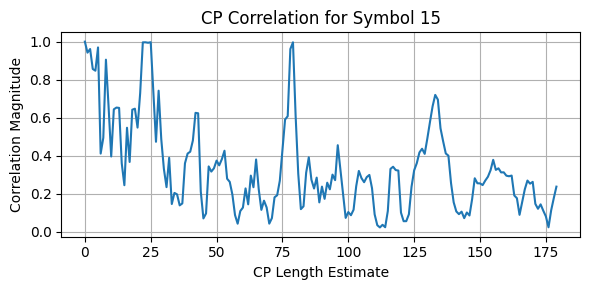

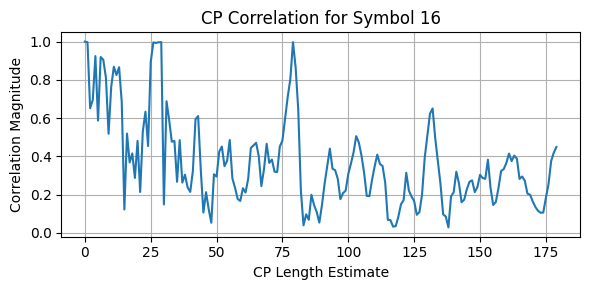

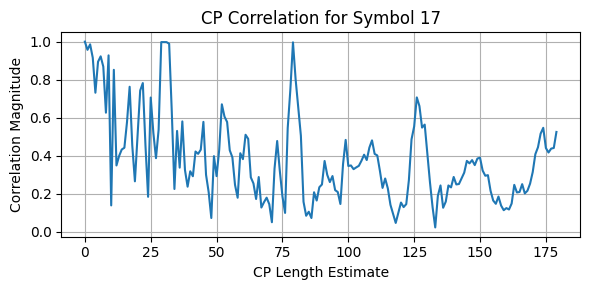

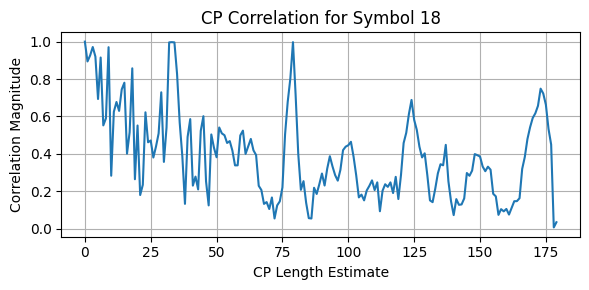

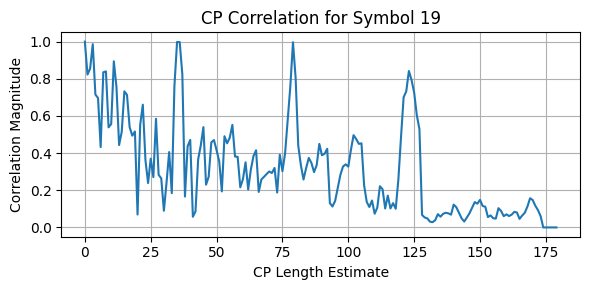

Max averaged CP correlation: 0.8947
Estimated CP Length: 80 samples
Edtimated Symbol Length, Ld:  640
Estimated Symbol Length + CP, Td:  720


In [51]:
x = Signal[start_index:]
c = np.zeros((Ld // 4, 19))  # Rows: CP lengths, Cols: symbol instances 

# Process each symbol index from 3 to 20
for i in range(3, 20):
    for cp_length_est in range(1, Ld // 4 + 1):
        Td = cp_length_est + Ld  # Total duration of one symbol with CP
        start = (i - 1) * Td
        end_ = i * Td
        if end_ > len(x):  # Safety check
            continue
        x1 = x[start:end_]
        a = x1[:cp_length_est]
        b = x1[-cp_length_est:]
        numer = np.sum(np.conj(a) * b)
        denom = np.sqrt(np.sum(np.abs(a)**2) * np.sum(np.abs(b)**2))
        c[cp_length_est - 1, i-1] = np.abs(numer / denom)

    # Plot each symbol's CP correlation profile
    plt.figure(figsize=(6, 3))
    plt.plot(c[:, i - 1])
    plt.title(f"CP Correlation for Symbol {i}")
    plt.xlabel("CP Length Estimate")
    plt.ylabel("Correlation Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Average CP correlation across symbols
cp_avg = np.mean(c[:, :20], axis=1)  # Use only columns 0–7 (symbols 1 to 8)

# Store maximum correlation (for this fixed start_index)
mm_val = np.max(cp_avg)
print(f"Max averaged CP correlation: {mm_val:.4f}")
# Find CP length corresponding to maximum average correlation

min_cp = 4  # Avoid CP = 1–3
search_range = np.arange(min_cp, Ld // 4 + 1)
valid_cp_avg = cp_avg[min_cp - 1:]  # cp_avg[3:] if min_cp = 4
cp_index = np.argmax(valid_cp_avg)
estimated_cp_length = search_range[cp_index]
print(f"Estimated CP Length: {estimated_cp_length} samples")
print("Edtimated Symbol Length, Ld: ", symbol_duration_est - estimated_cp_length)
print("Estimated Symbol Length + CP, Td: ", symbol_duration_est)



## 5. OFDM Symbol Extraction and Constellation Plotting

This process analyzes an OFDM-like signal by segmenting it into symbols, removing CP, performing FFT, and plotting the constellation diagram to visualize modulation characteristics.

- Support symbol extraction at different downsampling factors `k`.
- Apply CP removal and FFT per symbol.
- Flatten the frequency-domain symbols into one array.
- Plot the resulting constellation.


### Steps

1. **Symbol Slicing**

   From the signal $x[n]$, we extract an integer number of symbols:

   $$
   \text{total\_length} = \text{num\_symbols} \times L_s
   $$

   Then reshape into matrix $x_{\text{symbols}} \in \mathbb{C}^{L_s \times N_{\text{sym}}}$.

2. **CP Removal**

   Remove first `Lcp` samples of each symbol:

   $$
   x_{\text{no\_cp}} = x_{\text{symbols}}[L_{\text{cp}}:, :]
   $$

3. **FFT per Symbol**

   Apply FFT to each column (symbol):

   $$
   X_k = \text{FFT}(x_{\text{no\_cp}}[:, k])
   $$

4. **FFT Shift**

   Center the DC component using `fftshift`.

5. **Flatten Constellation**

   Flatten all subcarriers from all symbols:

   $$
   \text{constellation\_points} = \text{flatten}(X_{\text{symbols}})
   $$

Processing for k = 1
  Lcp = 80, Ld = 720, Ls = 800
 num_symbols = 20
  Start index = 600


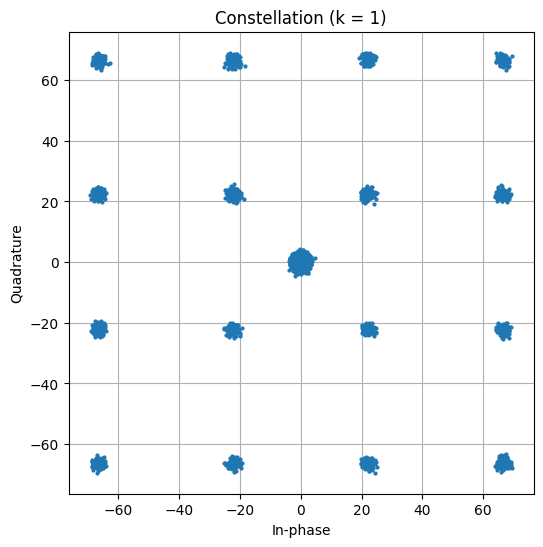

In [52]:
x_raw = rx_signal

# Optional: visualize multiple downsampling factors
for k in [1]:  # You can extend to [1, 2, 4, 5, 8, 10, 16, 20, 40]
    print(f"Processing for k = {k}")

    Lcp = int(estimated_cp_length/k)
    Ld = int(symbol_duration_est/k)
    Ls = Lcp + Ld  # Total symbol length
    print(f"  Lcp = {Lcp}, Ld = {Ld}, Ls = {Ls}")
    # print("start_index :", start_index)
    # print("stop index :", stop_index)
    signal_length = stop_index - start_index; #Total samples in signal
    num_symbols = int(signal_length / Ls); # Only complete symbols
    print(f" num_symbols = {num_symbols}")

    # Optional: downsampling
    x = x_raw[::k]
    for indd in [start_index]:
        print(f"  Start index = {indd}")
        x = x_raw[indd:]
        N = len(x)
        # num_symbols = len(x) // Ls  # Fixed manually
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Not enough data to extract symbols.")
            continue

        x_truncated = x[:total_length]

        # Reshape into symbols: shape = (Ls, num_symbols)
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol (result: shape = (Ld, num_symbols))
        x_no_cp = x_symbols[Lcp:, :]

        # Perform FFT on each column (along rows)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift frequency spectrum (zero-freq to center)
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to 1D vector
        constellation_points = X_symbols.flatten()

        # Plot the constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k = {k})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.show()



## 6. OFDM Demodulation and Constellation Plotting

### Signal Segmentation and FFT

Implementation of an OFDM demodulation process that uses multiple start indices to extract frequency-domain constellation points.

- Refine symbol synchronization using multiple candidate start indices.
- Demodulate OFDM-like symbols by removing the cyclic prefix and performing FFT.
- Visualize constellation points for quality analysis of the modulation scheme.

### Parameters

   - **Downsampling factor (k):** Determines resolution. Only `k = 1` is used in this run.
   - **Cyclic Prefix (CP) length:** `Lcp = Lcp / k`
   - **Data symbol length (Ld):** `Ld = Lc / k`
   - **Total symbol length:** `Ls = Lcp + Ld`
   - **Start indices tested:** `indd ∈ [start_index+1, start_index+2, start_index+3]`
   - **Number of symbols:** Fixed at 21



1. **Start Index Selection**

   - For each `indd` in the range `[start_index+1, start_index+2, start_index+3]`, the signal is processed from that point onward.
   - This tests alignment sensitivity.

2. **Signal Truncation**

   - Extract a fixed number of complete OFDM symbols (21 symbols of length `Ls`).
   - The signal is reshaped into a 2D matrix of size `(Ls, num_symbols)`.

3. **Cyclic Prefix Removal**

   - For each symbol, remove the first `Lcp` samples.
   - Resulting matrix has shape `(Ld, num_symbols)`.

4. **FFT Processing**

   - Apply FFT to each symbol column to transform into the frequency domain.
   - Use `fftshift` to center the DC component.

5. **Flatten and Plot**

   - Flatten the matrix into a 1D array of constellation points.
   - Plot the real vs. imaginary parts to visualize modulation (e.g., QPSK, 16-QAM).




Processing with k=1, Lcp=80, Ld=720, Ls=800
 num_symbols = 20
  Processing start index: 599


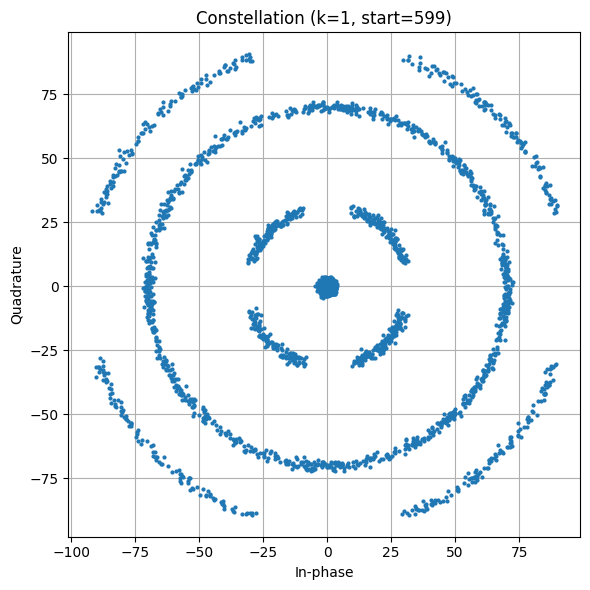

  Processing start index: 600


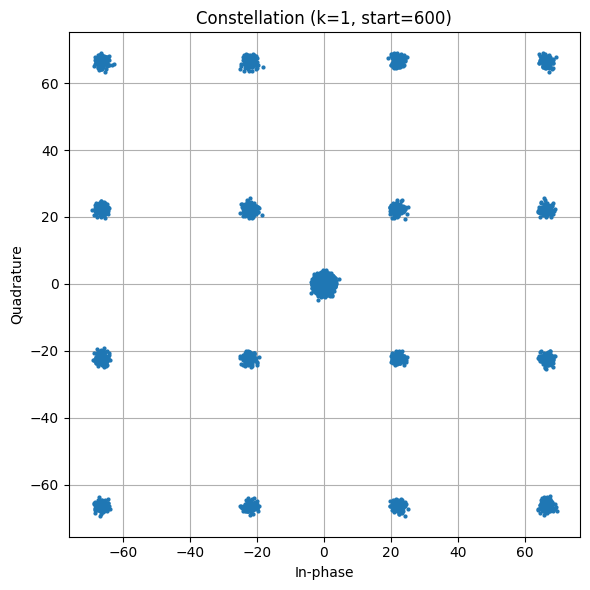

  Processing start index: 601


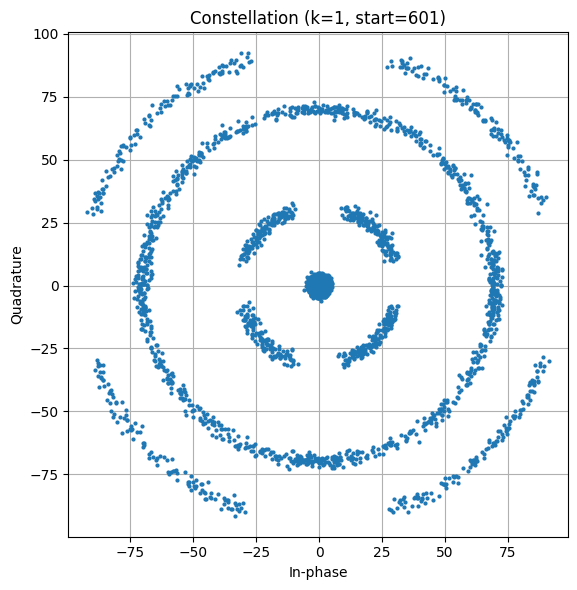

  Processing start index: 602


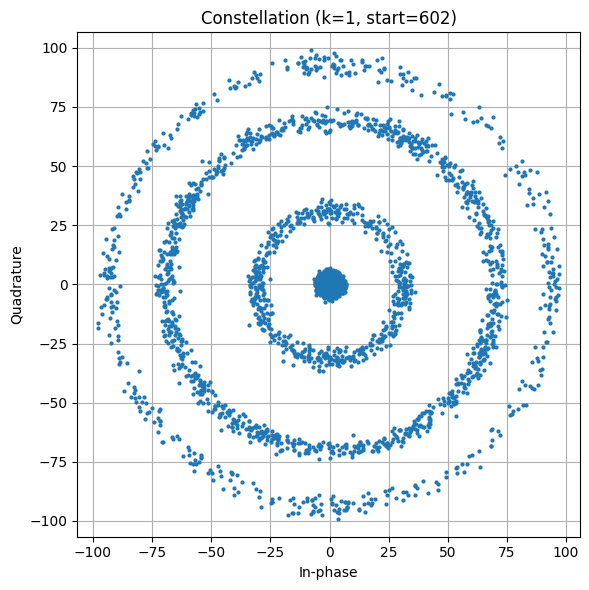

In [53]:
for k in [1]:
    Lcp = int(Lcp / k)  # Adjusted CP length
    Ld = int(Ld / k)  # Adjusted data (useful symbol) length
    Ls = Lcp + Ld      # Total OFDM symbol length
    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")
    print(f" num_symbols = {num_symbols}")

    # Downsampled version (optional)
    x_down = x_raw[::k]

    for indd in range(start_index-1, start_index + 3):  
        print(f"  Processing start index: {indd}")
        x = x_raw[indd:]
        N = len(x)
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Skipping: Not enough data.")
            continue

        # Truncate signal to complete symbols
        x_truncated = x[:total_length]

        # Reshape into (Ls, num_symbols) matrix
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol → shape (Ld, num_symbols)
        x_no_cp = x_symbols[Lcp:, :]

        # Apply FFT on each symbol (column-wise)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift zero-frequency to center
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to form 1D list of constellation points
        constellation_points = X_symbols.flatten()

        # Plot
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()



## 7. Subcarrier Power Analysis 

### OFDM Demodulation with Subcarrier Power Analysis

OFDM demodulation on a received signal with:

- Cyclic prefix removal
- FFT and FFT shift
- Power thresholding on subcarriers
- Visualization of low-power carriers and frequency-domain content


- Identify weak subcarriers (e.g., due to fading or zero-padding)
- Plot per-symbol power spectrum
- Visualize constellation of demodulated symbols



### Parameters

- **Downsampling factor (k):** 1
- **Cyclic prefix (CP):** `Lcp = Lcp / k`
- **Data symbol length:** `Ld = Ld / k`
- **Total symbol length:** `Ls = Lcp + Ld`
- **Start index (`indd`)**: `start_index`
- **Number of symbols processed**: estimated_symbols


### Processing Steps

1. **Signal Extraction**
   - Slice signal from `indd` onward.
   - Truncate to `total_length = num_symbols * Ls`.

2. **Reshape into Symbols**
   - Reshape into a matrix: `x_symbols ∈ ℂ^{Ls × num_symbols}`.
   - Remove CP: `x_no_cp = x_symbols[Lcp:, :]`.

3. **Frequency-Domain Transformation**
   - Perform FFT on each column (symbol).
   - Apply `fftshift` to center DC component.

4. **Low-Power Subcarrier Detection**
   - Compute magnitude squared of each FFT bin.
   - Identify entries where power `< 20`.
   - Plot with a **stem plot**:
     - X-axis: Symbol index
     - Y-axis: Subcarrier index


5. **Per-Symbol Power Spectrum**
   - Plot power of all subcarriers across symbols 1 to estimated_symbols.
   - Each curve shows the subcarrier power for one OFDM symbol.

6. **Constellation Visualization**
   - Flatten the FFT matrix.
   - Plot real vs. imaginary components of all subcarriers to assess:
     - Modulation type
     - Noise and phase distortion


## Use Cases

- Check spectral nulls or filter effects
- Evaluate subcarrier energy distribution
- Validate modulation under different timing assumptions

   - Extend `k` to other values for resolution studies.
   - Adjust power threshold (`< 20`) for more or fewer detected subcarriers.



Processing with k=1, Lcp=80, Ld=720, Ls=800


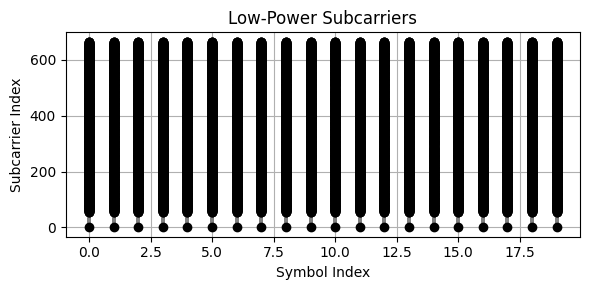

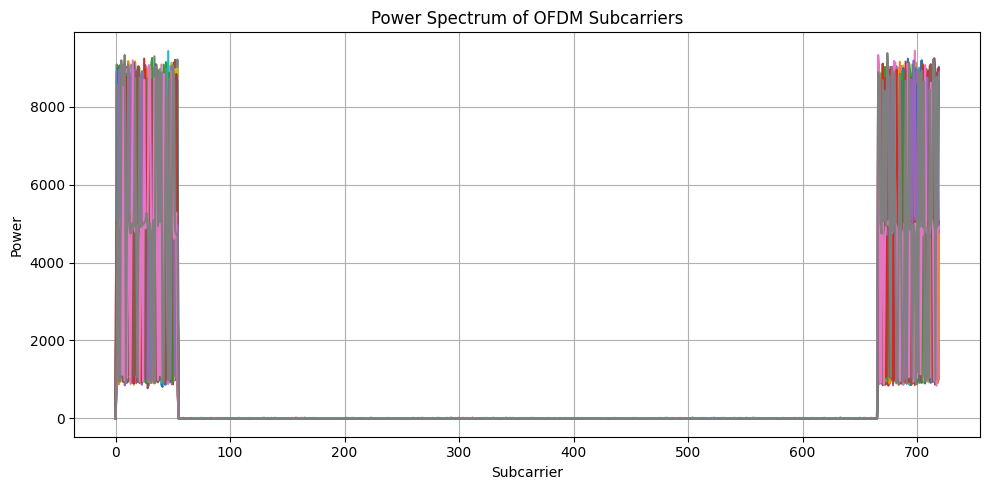

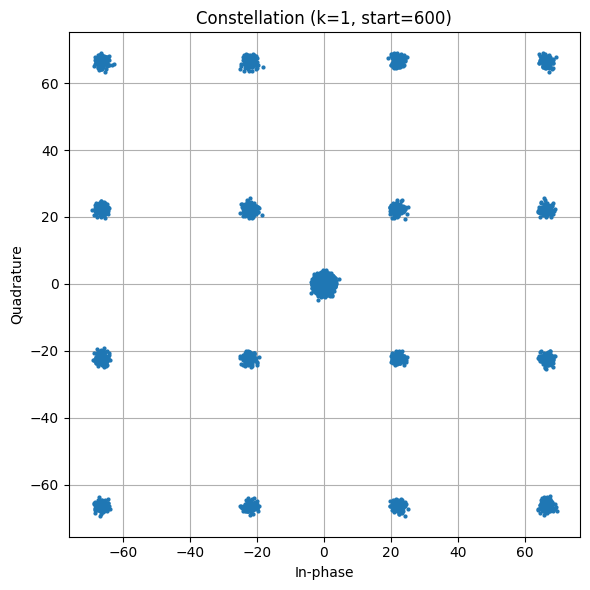

In [54]:
for k in [1]:

    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")

    x_down = x_raw[::k]

    for indd in [start_index]:
        x = x_raw[indd:]
        N = len(x)
        # num_symbols = estimated_symbols
        total_length = num_symbols * Ls

        if total_length > N:
            print("Not enough data for full symbols")
            continue

        x_truncated = x[:total_length]
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
        x_no_cp = x_symbols[Lcp:, :]  # shape: (Ld, num_symbols)

        # FFT + fftshift
        X_symbols = np.fft.fftshift(np.fft.fft(x_no_cp, n=Ld, axis=0), axes=0)

        # Detect low-power subcarriers (|X|^2 < 20)
        magnitude_squared = np.abs(X_symbols)**2
        rows, cols = np.where(magnitude_squared < 20)

        # Stem plot of low-power subcarriers
        plt.figure(figsize=(6, 3))
        plt.stem(cols, rows, linefmt='gray', markerfmt='ko', basefmt=' ')
        plt.title('Low-Power Subcarriers')
        plt.xlabel('Symbol Index')
        plt.ylabel('Subcarrier Index')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Per-symbol power spectrum
        plt.figure(figsize=(10, 5))
        for l in range(2, num_symbols): 
            plt.plot(range(Ld), magnitude_squared[:, l])
        plt.xlabel('Subcarrier')
        plt.ylabel('Power')
        plt.title('Power Spectrum of OFDM Subcarriers')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Flatten for constellation plot
        constellation_points = X_symbols.flatten()

        # Plot constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

### Possible Cause of the Central Cluster: 

#### 1. DC subcarrier 

Noise and channel effects can cause DC bin to accumulate energy at the receiver. 

#### 2. Inactive or zeroed subcarriers: 

Many subcarriers are intentionally zeroed (guard bands) 
After passing through a channel (and added noise), those subcarriers can have small non-zero values which cluster zero. 

We must plot only the active subcarriers. 

#### 3. Noise Leakage: 

If SNR is moderate, noise leaks into zeroed bins and we'll see a noisy zero-energy cluster around 0,0

#### 4. Receiver demodulating blindly: 

If receiver blindly demodulates all 720 FFT outputs, we'll naturally get a lot of low-energy noisy points, especially at inactive bins. 




---
---
---


### Realistic Channel Models

More realistic environments:

* **Multipath fading**: Add Rayleigh or Rician fading (`scipy.signal.convolve` or tap delay line).
* **Doppler spread**: For mobile scenarios, apply time-varying channel impulse responses.
* **Frequency offset & phase noise**: Model oscillator mismatch and jitter.
* **Timing offset & jitter**: Add sample delays and timing estimation error.

---

### Synchronization Mechanisms

Real receivers implement:

* **Timing synchronization** (e.g., using cyclic prefix autocorrelation or Schmidl-Cox algorithm).
* **Frequency offset correction**.
* **Frame detection** (using preamble sequences like Zadoff-Chu or PN sequences).

---

### Channel Estimation & Equalization

Instead of assuming perfect channel knowledge:

* Insert **pilot symbols** or use **training sequences**.
* Implement **LS (Least Squares)** or **MMSE equalization**.
* Plot **channel frequency response** and estimate SNR per subcarrier.

---

### Performance Metrics & Visualization

* BER vs. SNR (you’re doing this already).
* **EVM (Error Vector Magnitude)**.
* **Constellation diagram before/after equalization**.
* **Spectrogram or PSD of transmitted signal**.

---


### Adding Forward Error Correction (FEC)

Industry systems always use FEC:

* Add **convolutional coding** (with `commpy`), **LDPC**, or **Turbo codes**.
* Use **soft-decision decoding** and integrate with BER evaluation.

---

### Hardware-Aware Constraints

* Quantization: Add ADC/DAC effects (bit depth).
* Clipping & PAPR: Add non-linearities and evaluate Peak-to-Average Power Ratio (PAPR).
* Power normalization across symbols.

---

### Exporting to SDR / Real-Time

* Generate `.wav` files or IQ samples for use in **GNU Radio**, **SDR hardware**, or **Simulink**.
* Use `pyserial` or `SoapySDR` if moving toward embedded/hardware.

---

### Example Goal:

> **End-to-End OFDM Tx/Rx with multipath fading, synchronization, pilot-aided channel estimation, FEC, and BER vs. SNR analysis — all modular and ready for SDR testing.**



---
# Multi-path Fading Channel (Rayleigh Fading)
    
In realistic wireless environments, transmitted signals often encounter multiple reflections, scatterings, and diffractions before reaching the receiver. These **multipath components** interfere with each other, resulting in **fading**, a major phenomenon in wireless communication systems.

When no **line-of-sight (LOS)** path exists and there are many randomly phased multipath components, the channel is modeled as a **Rayleigh fading channel**.

The **baseband-equivalent received signal** $y[n]$ under a discrete-time multipath Rayleigh fading channel with **$L$** taps is given by:

$$
y[n] = \sum_{\ell=0}^{L-1} h[\ell] \cdot x[n - \ell] + w[n]
$$

where:

* $x[n]$: Transmitted signal (complex baseband)
* $h[\ell]$: Channel impulse response coefficient of the $\ell$-th path
* $L$: Number of multipath taps
* $w[n]$: Additive white Gaussian noise (AWGN)


### Channel Impulse Response $h[\ell]$

Each tap $h[\ell]$ is modeled as a **complex Gaussian random variable**:

$$
h[\ell] \sim \mathcal{CN}(0, \sigma_\ell^2)
$$

where $\sigma_\ell^2$ is the power of the $\ell$-th tap. 

This means:

$$
h[\ell] = h_{\text{real}}[\ell] + j \cdot h_{\text{imag}}[\ell]
$$

where:

$$
h_{\text{real}}[\ell] \sim \mathcal{N}\left(0, \frac{\sigma_\ell^2}{2} \right), \quad
h_{\text{imag}}[\ell] \sim \mathcal{N}\left(0, \frac{\sigma_\ell^2}{2} \right)
$$

This ensures that the total power is:

$$
\mathbb{E}[|h[\ell]|^2] = \frac{\sigma_\ell^2}{2} + \frac{\sigma_\ell^2}{2} = \sigma_\ell^2
$$

### Probability Density Function (PDF) of $h_{\text{real}}[\ell]$

$$
f_{h_{\text{real}}}(x) = \frac{1}{\sqrt{2\pi \cdot \sigma_\ell^2 / 2}} \cdot \exp\left( -\frac{x^2}{2 \cdot \sigma_\ell^2 / 2} \right)
= \frac{1}{\sqrt{\pi \sigma_\ell^2}} \cdot \exp\left( -\frac{x^2}{\sigma_\ell^2} \right)
$$

The same form holds for $h_{\text{imag}}[\ell]$, due to symmetry.


### Magnitude Distribution

The magnitude $|h[\ell]|$ follows a **Rayleigh distribution** (since both components are i.i.d. $\mathcal{N}(0, \sigma_\ell^2/2)$):

$$
f_{|h|}(r) = \frac{r}{\sigma_\ell^2} \exp\left( -\frac{r^2}{2 \cdot \sigma_\ell^2} \right), \quad r \geq 0
$$

This is why we call the fading **Rayleigh** fading — even though the components are Gaussian, the magnitude is Rayleigh-distributed.


A common power profile is **exponential decay**, representing stronger early paths and weaker delayed reflections:

$$
\sigma_\ell^2 = \frac{e^{-\alpha \ell}}{\sum_{k=0}^{L-1} e^{-\alpha k}}
$$

* $\alpha$: Decay rate parameter
* This normalization ensures total power $\sum_\ell \sigma_\ell^2 = 1$

| Decay Factor $\alpha$ | Interpretation                            | Delay Profile Shape         |
| --------------------- | ----------------------------------------- | --------------------------- |
| $\alpha = 0$          | All taps have equal power (flat profile)  | Uniform / constant power    |
| $\alpha = 0.3$ to $1$ | Moderate decay — power fades with delay   | Realistic indoor models     |
| $\alpha > 1.5$        | Sharp decay — most energy in first tap(s) | Short-delay dominated paths |
| $\alpha \to \infty$   | Only first tap has power                  | Approaches flat fading      |


#### **Typical Values in Practice**

* **Indoor Office/LOS**:
  $\alpha \approx 0.5$ to $1.0$
  (few strong reflections)

* **Urban Microcell/NLOS**:
  $\alpha \approx 0.3$ to $0.8$
  (more rich scattering)

* **Vehicular Channels** (e.g., 802.11p or 3GPP):
  May use pre-defined tap powers instead of exponential, but exponential model with $\alpha \approx 0.7$–$1.5$ can approximate them.


#### Example: $L = 5$ taps, $\alpha = 0.7$

$$
\begin{align*}
\sigma_0^2 &\propto e^{-0 \cdot 0.7} = 1 \\
\sigma_1^2 &\propto e^{-1 \cdot 0.7} \approx 0.497 \\
\sigma_2^2 &\propto e^{-2 \cdot 0.7} \approx 0.247 \\
\sigma_3^2 &\propto e^{-3 \cdot 0.7} \approx 0.123 \\
\sigma_4^2 &\propto e^{-4 \cdot 0.7} \approx 0.061
\end{align*}
$$

Then normalize so that $\sum \sigma_\ell^2 = 1$


### Convolution in Time Domain

The fading is applied by **convolution** between the transmit signal $x[n]$ and the channel $h[\ell]$:

$$
y[n] = (x * h)[n] + w[n]
$$

In python, this is computed using:

```python
np.convolve(signal, h, mode='full')[:len(signal)]
```

### AWGN Noise

After fading, **additive white Gaussian noise** is added to simulate thermal or front-end noise. For a target SNR $\gamma_{\text{dB}}$, the noise power is:

$$
P_{\text{noise}} = \frac{P_{\text{signal}}}{10^{\gamma_{\text{dB}} / 10}}
$$

The noise vector $w[n]$ is generated as:

$$
w[n] = \mathcal{N}(0, \sigma^2) + j \cdot \mathcal{N}(0, \sigma^2), \quad \text{where } \sigma^2 = \frac{P_{\text{noise}}}{2}
$$

### Notes:

* Using more taps, **frequency-selective fading** can be simulated.
* Increasing decay factor $\alpha$ results in shorter delay spread.
* Flat fading is a special case when $L = 1$.

    

In [88]:
def apply_multipath_fading(signal, num_taps=3, alpha_rayleigh=0.7, snr_db=None,fs=1.0):
    """
    Apply Rayleigh multipath fading with exponential power decay.

    Parameters:
    - signal: Transmitted baseband signal (1D numpy array)
    - num_taps: Number of Rayleigh multipath taps (L)
    - alpha_rayleigh: Exponential decay rate for tap powers (typical: 0.3–1.0)
    - snr_db: Additive white Gaussian noise level in dB (optional)

    Returns:
    - faded_signal: Signal after Rayleigh fading (and AWGN if specified)
    - h: Channel impulse response (complex numpy array of length `num_taps`)
    """
    # Compute exponential power delay profile
    tap_powers = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers /= np.sum(tap_powers)  # Normalize total power to 1

    # Generate complex Rayleigh fading taps
    h_real = np.random.randn(num_taps) * np.sqrt(tap_powers / 2)
    h_imag = np.random.randn(num_taps) * np.sqrt(tap_powers / 2)
    h = h_real + 1j * h_imag

    # Convolve signal with channel impulse response
    faded_signal = np.convolve(signal, h, mode='full')[:len(signal)]

    # Optional: Add AWGN based on target SNR
    if snr_db is not None:
        signal_power = np.mean(np.abs(faded_signal)**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        noise = noise_std * (np.random.randn(len(faded_signal)) + 1j * np.random.randn(len(faded_signal)))
        faded_signal += noise

    N = len(signal)
    t = np.arange(N) / fs

    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(t, signal.real, label='Real')
    plt.title("faded_signal")
    plt.ylabel('Real')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(t, signal.imag, label='Imag', color='orange')
    plt.ylabel('Imaginary')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(t, np.abs(signal), label='Magnitude', color='green')
    plt.ylabel('Magnitude')
    plt.xlabel('Time (samples)' if fs == 1.0 else 'Time (s)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.stem(np.arange(num_taps), tap_powers)
    plt.title("Exponential Tap Power Decay")
    plt.xlabel("Tap Index")
    plt.ylabel("Power")
    plt.grid(True)
    plt.show()

    return faded_signal, h


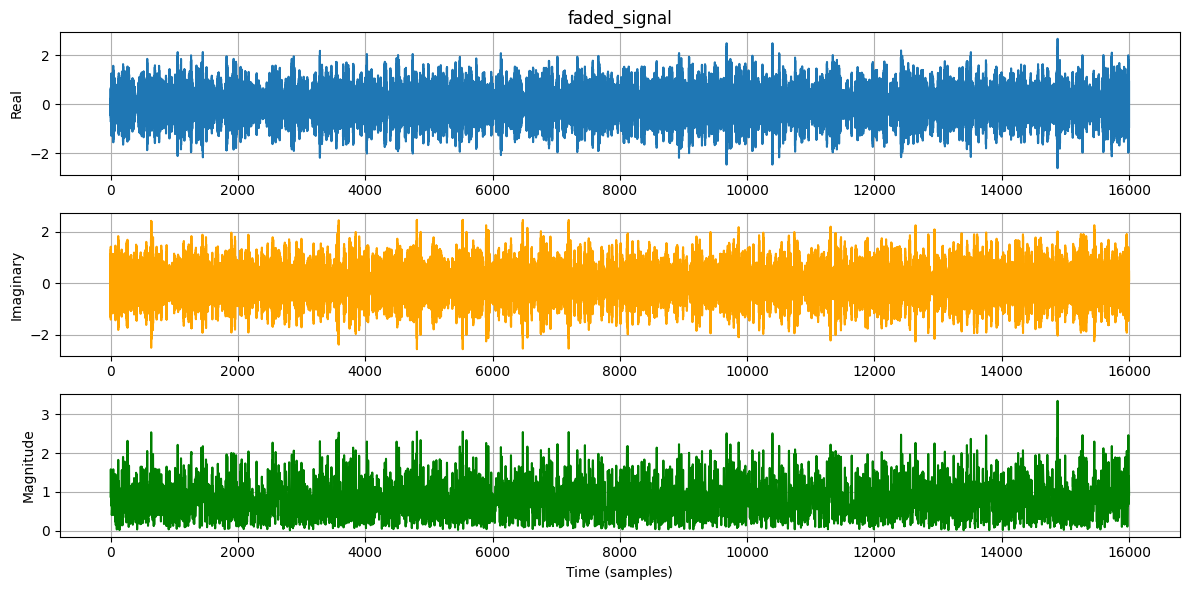

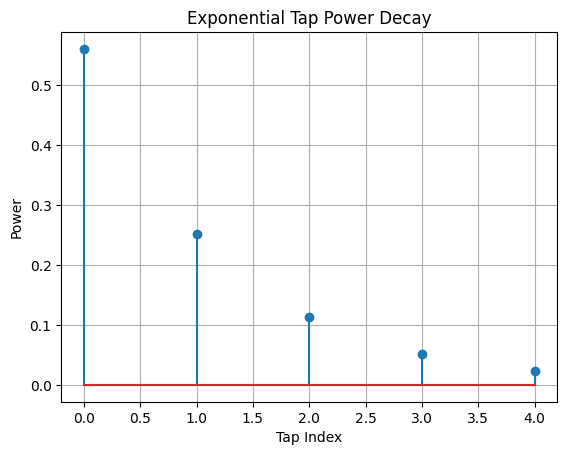

In [89]:
faded_signal = apply_multipath_fading(ofdm_signal, num_taps=5, alpha_rayleigh=0.8, snr_db=20)

### **OFDM is specifically designed to handle *frequency-selective fading*** efficiently.

In a **frequency-selective fading channel**, different frequencies (subcarriers) experience **different gains and phase shifts** due to **multipath delay spread**. This causes **intersymbol interference (ISI)** in single-carrier systems.

#### OFDM solves this by:

* **Splitting the wideband channel into many narrowband subcarriers**
* Each subcarrier is narrow enough to **experience flat fading**
* It uses a **CP** to eliminate ISI between symbols


### When is OFDM ideal?

| Fading Type                    | Is OFDM Suitable? | Reason                                        |
| ------------------------------ | ----------------- | --------------------------------------------- |
| **Flat fading**                | Yes, works      | All subcarriers see similar fading            |
| **Frequency-selective fading** | Best use case   | OFDM transforms it into many flat subchannels |


If the channel has a delay spread $T_{\text{delay}}$, and OFDM symbol duration is $T_{\text{sym}}$, we want:

$$
T_{\text{CP}} \geq T_{\text{delay}} \quad \text{and} \quad \Delta f = \frac{1}{T_{\text{sym}}} \ll \frac{1}{T_{\text{delay}}}
$$

This ensures each subcarrier sees a flat response.

### Without OFDM?

In a frequency-selective channel:

* Single-carrier systems suffer from **ISI**
* Require **complex equalizers (e.g., time-domain MMSE)**

### With OFDM?

* Subcarriers become **orthogonal flat-fading channels**
* Equalization becomes **simple per-subcarrier**
* Very efficient for 4G LTE, 5G NR, Wi-Fi, DVB, etc.



---


## Rayleigh vs. Rician — Which is Realistic?

| Fading Model | Description                                                                                | When It Occurs                                                                        |
| ------------ | ------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------- |
| **Rayleigh** | No dominant line-of-sight (LOS) path; signal is composed entirely of multipath reflections | **Urban**, **indoor**, **NLOS** (non-line-of-sight), tunnels, deep indoor areas       |
| **Rician**   | Dominant LOS path **plus** multipath reflections                                           | **LOS scenarios**: highways, open indoor spaces, UAVs, mmWave, Wi-Fi within same room |

* **Rayleigh fading**:
  The **magnitude** of the fading envelope follows a **Rayleigh distribution** (no strong deterministic component).

* **Rician fading**:
  The fading envelope has a **dominant deterministic component** (LOS), and the rest is multipath. The **Rician K-factor** quantifies the ratio of LOS power to scattered power:

  $$
  K = \frac{\text{Power of LOS path}}{\text{Power of scattered paths}} \quad (\text{in linear or dB})
  $$

  * $K = 0 \Rightarrow$ Rayleigh fading
  * $K > 0 \Rightarrow$ Rician fading
  * $K \to \infty \Rightarrow$ AWGN channel (pure LOS)


| Environment                                | Use This Model            |
| ------------------------------------------ | ------------------------- |
| Small cell, deep indoor, urban canyon      | **Rayleigh**              |
| Open office, shopping mall with visibility | **Rician**                |
| Highway, mmWave with beamforming           | **Rician** with large $K$ |
| No multipath (e.g., fiber or ideal)        | **AWGN only**             |


### Example: 3GPP Models

* **EPA** (Extended Pedestrian A): Usually Rayleigh
* **EVA**, **ETU**: Varying degrees of Rician (especially for vehicular channels)


> **Rayleigh is more pessimistic**, but safe to simulate in **worst-case NLOS**.

> **Rician is more accurate** for modern LOS-enabled systems (e.g., 5G NR mmWave, Wi-Fi 6/7, LiFi).



---

## Rician Fading Channel Theory

Rician fading models wireless channels in environments where there is a **dominant LOS** path in addition to several scattered Non-Line-of-Sight (NLOS) components. Unlike Rayleigh fading (which assumes no LOS), Rician fading captures the combined effect of deterministic and random multipath components. 

This model is particularly relevant for:

- urban canyons
- indoor open spaces
- vehicular environments
- mmWave systems with strong beamforming

The received complex baseband signal after a multipath Rician fading channel is modeled as:

$$
y[n] = \sum_{\ell=0}^{L-1} h[\ell] \cdot x[n - \ell] + w[n]
$$

where:

* $x[n]$: Transmitted signal sample
* $h[\ell]$: Complex channel impulse response at tap $\ell$
* $w[n]$: Additive White Gaussian Noise (AWGN)
* $L$: Number of channel taps (multipath components)


### Channel Tap Structure

Each channel tap $h[\ell]$ in Rician fading consists of two components:

$$
h[\ell] = h_{\text{LOS}}[\ell] + h_{\text{NLOS}}[\ell]
$$

* $h_{\text{LOS}}[\ell]$: Deterministic LOS component (typically only for $\ell = 0$)
* $h_{\text{NLOS}}[\ell]$: Scattered component modeled as a complex Gaussian random variable

The NLOS component is assumed to follow a zero-mean complex Gaussian distribution:

$$
h_{\text{NLOS}}[\ell] \sim \mathcal{CN}\left(0, \sigma_{\ell}^2\right)
$$

The LOS component contributes only at the first tap:

$$
h_{\text{LOS}}[0] = \sqrt{P_{\text{LOS}}}, \quad h_{\text{LOS}}[\ell] = 0 \text{ for } \ell > 0
$$

### Rician K-Factor

The **Rician K-factor** quantifies the ratio of LOS power to the total NLOS power:

$$
K = \frac{P_{\text{LOS}}}{P_{\text{NLOS}}}
$$

* Expressed in dB as: $K_{\text{dB}} = 10 \log_{10}(K)$
* $K = 0$: No LOS path → Rayleigh fading
* $K \rightarrow \infty$: Dominant LOS only → AWGN channel

The total channel power is normalized as:

$$
P_{\text{total}} = P_{\text{LOS}} + P_{\text{NLOS}} = 1
$$

$$
P_{\text{LOS}} = \frac{K}{1 + K}, \quad P_{\text{NLOS}} = \frac{1}{1 + K}
$$


### Power Delay Profile

To model delay dispersion in the NLOS paths, an **exponential decay profile** is commonly used:

$$
\sigma_{\ell}^2 = \frac{e^{-\alpha \ell}}{\sum_{k=0}^{L-1} e^{-\alpha k}}
$$

* $\alpha$: Decay rate parameter (typical range: 0.3 to 1.0)
* Ensures that later taps have less power than earlier ones
* The total NLOS power across all taps is normalized to $P_{\text{NLOS}}$


| Component      | Description                              |
| -------------- | ---------------------------------------- |
| LOS component  | Deterministic power at first tap         |
| NLOS component | Rayleigh-faded, exponentially decaying   |
| K-factor       | Controls strength of LOS vs scattered    |
| Delay spread   | Modeled via exponential power profile    |
| AWGN           | Added optionally to simulate noise floor |

Rician fading provides a flexible model that bridges the gap between fully scattered Rayleigh channels and pure LOS scenarios, making it a widely used channel model in wireless system design.



In [98]:
def rician_fading(ofdm_signal, num_taps, K_dB, alpha_rayleigh, snr_db=None):
    """
    Apply Rician fading to a complex baseband signal.

    Parameters:
    - signal: Input complex baseband signal (1D array)
    - num_taps: Number of channel taps (L)
    - K_dB: Rician K-factor in dB (ratio of LOS to NLOS power)
    - alpha_rayleigh: Exponential decay rate for NLOS taps
    - snr_db: Optional SNR in dB for AWGN

    Returns:
    - faded_signal: Signal after convolution with Rician fading channel
    - h: Channel impulse response (complex-valued)
    """
    # Convert K-factor from dB to linear scale
    K_linear = 10**(K_dB / 10)

    # Compute power profile of NLOS (Rayleigh) taps
    tap_powers_nlos = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers_nlos /= np.sum(tap_powers_nlos)

    # Total power is normalized to 1: divide between LOS and NLOS
    total_power = 1.0
    power_nlos = total_power / (1 + K_linear)
    power_los = total_power * K_linear / (1 + K_linear)

    # Construct NLOS Rayleigh component
    h_nlos = (np.random.randn(num_taps) + 1j * np.random.randn(num_taps)) * np.sqrt((power_nlos * tap_powers_nlos) / 2)

    # Construct LOS deterministic component (only first tap has LOS)
    h_los = np.zeros(num_taps, dtype=complex)
    h_los[0] = np.sqrt(power_los)  # deterministic LOS at delay 0

    # Combine to get final channel impulse response
    h = h_los + h_nlos

    # Convolve the signal with the Rician channel
    faded_signal = np.convolve(ofdm_signal, h, mode='full')[:len(ofdm_signal)]

    # Add AWGN if specified
    if snr_db is not None:
        signal_power = np.mean(np.abs(faded_signal)**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        noise = noise_std * (np.random.randn(len(faded_signal)) + 1j * np.random.randn(len(faded_signal)))
        faded_signal += noise
    
    plt.figure(figsize=(10, 3.5))
    plt.plot(np.abs(ofdm_signal), color='purple', linewidth=1)
    plt.title("Received Signal Envelope")
    plt.xlabel("Sample Index")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    taps = np.arange(len(h))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.stem(taps, np.abs(h))
    plt.title("Magnitude of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("|h[l]|")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.stem(taps, np.angle(h))
    plt.title("Phase of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("∠h[l] (rad)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return faded_signal, h


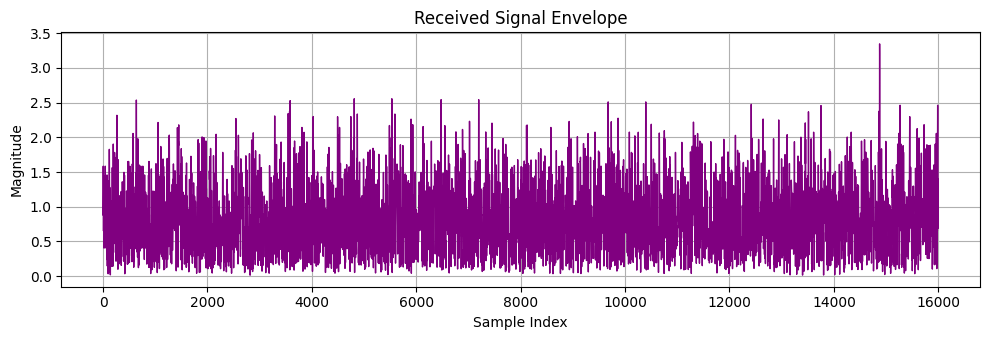

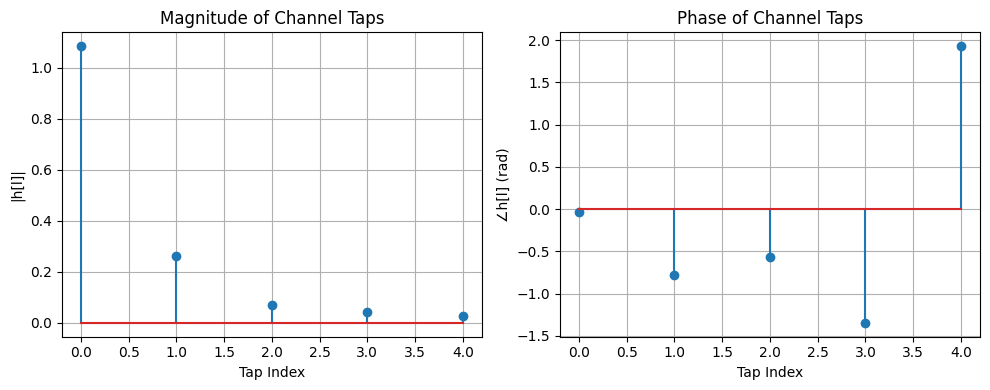

In [99]:
rician_signal, h = rician_fading(ofdm_signal, num_taps = 5, K_dB = 10, alpha_rayleigh = 0.7, snr_db = 25)


# 3GPP TR 38.901 Channel Models

The TR 38.901 3GPP document defines five main standardized channel models for G NR wireless simulations. 

Each corresponds to a deployment environment, with specific statistical characteristics for:

- LOS/NLOS probability models

- Path loss models

- Power delay profiles (PDP)

- Angular spreads and Doppler

- Cluster-based small-scale fading




| Model   | Name                    | Description                                | Frequency Range      |
| ------- | ----------------------- | ------------------------------------------ | -------------------- |
| **RMa** | **Rural Macrocell**     | Large cell, low density, open terrain      | 0.5 – 30 GHz         |
| **UMa** | **Urban Macrocell**     | Rooftop BSs serving users on streets       | 0.5 – 100 GHz        |
| **UMi** | **Urban Microcell**     | Low-height BSs in dense urban environments | 0.5 – 100 GHz        |
| **InH** | **Indoor Hotspot**      | Indoor office/open space                   | 0.5 – 100 GHz        |
| **SM**  | **Satellite to Mobile** | Optional; for satellite link simulations   | \[Separate document] |


---
---

## Time-Varying Rayleigh Multipath Channel with Doppler Spread

In mobile wireless communication, channel conditions change over time due to user movement, changes in the surrounding environment, or both. These variations introduce **Doppler spread**—a phenomenon that causes **time-selective fading** of the signal. When combined with **multipath propagation**, the result is a **time-varying frequency-selective fading channel**.

This model captures the effects of:

* **Multipath fading**: signal reflections from various physical objects.
* **Doppler effect**: time variation in the channel due to relative motion between the transmitter, receiver, or environment.

### Channel Model

The received signal $y[n]$ is modeled as:

$$
y[n] = \sum_{\ell=0}^{L-1} h[n, \ell] \cdot x[n - \ell] + w[n]
$$

where:

* $x[n]$: transmitted complex baseband signal
* $h[n, \ell]$: time-varying complex channel coefficient for tap $\ell$ at time $n$
* $L$: number of channel taps (multipath components)
* $w[n]$: additive white Gaussian noise (AWGN)


### Tap Power Profile

The power of each tap is defined by an **exponential decay profile**:

$$
\sigma^2_\ell = \frac{e^{-\alpha \ell}}{\sum_{k=0}^{L-1} e^{-\alpha k}}
$$

where:

* $\alpha$: exponential decay factor (typically in range 0.3–1.0)
* $\sigma^2_\ell$: power of the $\ell$-th tap, normalized such that $\sum_{\ell=0}^{L-1} \sigma^2_\ell = 1$

This captures the fact that earlier-arriving paths typically carry more energy than delayed reflections.


### Time Variation and Doppler Spread

Each channel tap $h[n, \ell]$ is modeled as a **zero-mean complex Gaussian random process** with a time-varying envelope that captures Doppler fading. For a mobile user with maximum Doppler frequency $f_D$, the fading variation over time follows Jakes’ Doppler spectrum.

The fading process for each tap is generated using the **sum-of-sinusoids method**, an efficient approximation of Jakes’ model. Each tap evolves over time as:

$$
h[n, \ell] = \sqrt{\sigma^2_\ell} \cdot \left( h_{\text{real}}[n, \ell] + j \cdot h_{\text{imag}}[n, \ell] \right)
$$

with:

$$
h_{\text{real}}[n, \ell] = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(2\pi f_D n \cos\theta_k + \phi_k)
$$

$$
h_{\text{imag}}[n, \ell] = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \sin(2\pi f_D n \cos\theta_k + \phi_k)
$$

where:

* $N$: number of sinusoids (e.g., 16, 32, 64)
* $\theta_k$: equally spaced angles on $[0, 2\pi)$
* $\phi_k$: random initial phases uniformly distributed on $[0, 2\pi)$

This process generates a time-correlated complex Gaussian signal per tap with the desired Doppler spectrum.


### Convolution with Time-Varying Channel

The received signal is computed using a **time-varying convolution** across all taps:

$$
y[n] = \sum_{\ell=0}^{L-1} h[n, \ell] \cdot x[n - \ell]
$$

This models a channel whose impulse response varies continuously over time, introducing both frequency-selective and time-selective fading effects.


### Additive Noise

To simulate realistic reception conditions, complex Gaussian noise $w[n] \sim \mathcal{CN}(0, \sigma_w^2)$ is added after convolution. The noise power is determined based on a target Signal-to-Noise Ratio (SNR):

$$
\sigma_w^2 = \frac{P_{\text{signal}}}{10^{\text{SNR}_{\text{dB}} / 10}}
$$


| Component        | Description                                   |
| ---------------- | --------------------------------------------- |
| $L$              | Number of channel taps (multipath components) |
| $\alpha$         | Exponential decay rate for tap powers         |
| $f_D$            | Maximum Doppler frequency (Hz)                |
| $h[n, \ell]$     | Time-varying Rayleigh fading process per tap  |
| $y[n]$           | Output signal (faded + noisy)                 |
| Sum-of-sinusoids | Used to generate time-correlated fading       |
| AWGN             | Optional noise added after fading             |


In [100]:
def multipath_doppler_fading(signal, num_taps=3, alpha_rayleigh=0.7, fd=100, fs=1.0, snr_db=None, num_sinusoids=32, seed=None):
    """
    Apply time-varying Rayleigh multipath fading with Doppler spread (per tap).

    Parameters:
    - signal: Transmitted complex baseband signal (1D array)
    - num_taps: Number of multipath taps
    - alpha_rayleigh: Exponential decay rate for tap powers
    - fd: Maximum Doppler frequency (Hz)
    - fs: Sampling rate (Hz)
    - snr_db: SNR in dB for AWGN (optional)
    - num_sinusoids: Number of sinusoids for Doppler approximation
    - seed: Random seed (optional)

    Returns:
    - faded_signal: Time-varying faded signal
    - h_time: Time-varying channel impulse response matrix (shape: [len(signal), num_taps])
    """
    if seed is not None:
        np.random.seed(seed)

    N = len(signal)
    t = np.arange(N) / fs

    # Tap power profile (exponential decay)
    tap_powers = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers /= np.sum(tap_powers)

    # Initialize time-varying channel matrix
    h_time = np.zeros((N, num_taps), dtype=complex)

    # Generate Doppler fading process per tap using sum-of-sinusoids
    for l in range(num_taps):
        theta = 2 * np.pi * np.arange(1, num_sinusoids + 1) / (num_sinusoids + 1)
        phi = 2 * np.pi * np.random.rand(num_sinusoids)

        real_fading = np.sqrt(2 / num_sinusoids) * np.sum(
            np.cos(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1
        )
        imag_fading = np.sqrt(2 / num_sinusoids) * np.sum(
            np.sin(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1
        )
        fading_process = real_fading + 1j * imag_fading
        h_time[:, l] = fading_process * np.sqrt(tap_powers[l])

    # Apply time-varying convolution
    faded_signal = np.zeros(N, dtype=complex)
    for l in range(num_taps):
        delayed_signal = np.roll(signal, l)
        delayed_signal[:l] = 0  # zero-pad causal delay
        faded_signal += h_time[:, l] * delayed_signal

    # Add AWGN if specified
    if snr_db is not None:
        signal_power = np.mean(np.abs(faded_signal)**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        noise = noise_std * (np.random.randn(N) + 1j * np.random.randn(N))
        faded_signal += noise
    
    plt.figure(figsize=(10, 3.5))
    plt.plot(np.abs(ofdm_signal), color='purple', linewidth=1)
    plt.title("Received Signal Envelope")
    plt.xlabel("Sample Index")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    taps = np.arange(len(h))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.stem(taps, np.abs(h))
    plt.title("Magnitude of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("|h[l]|")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.stem(taps, np.angle(h))
    plt.title("Phase of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("∠h[l] (rad)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    for l in range(h_time.shape[1]):
        plt.plot(np.abs(h_time[:, l]), label=f'Tap {l}')
    plt.title("Time-Varying Magnitude of Channel Taps")
    plt.xlabel("Time Index")
    plt.ylabel("|h(t,l)|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return faded_signal, h_time


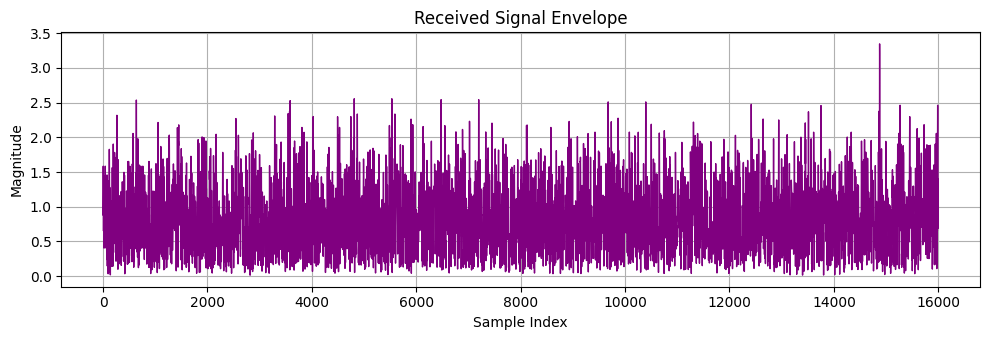

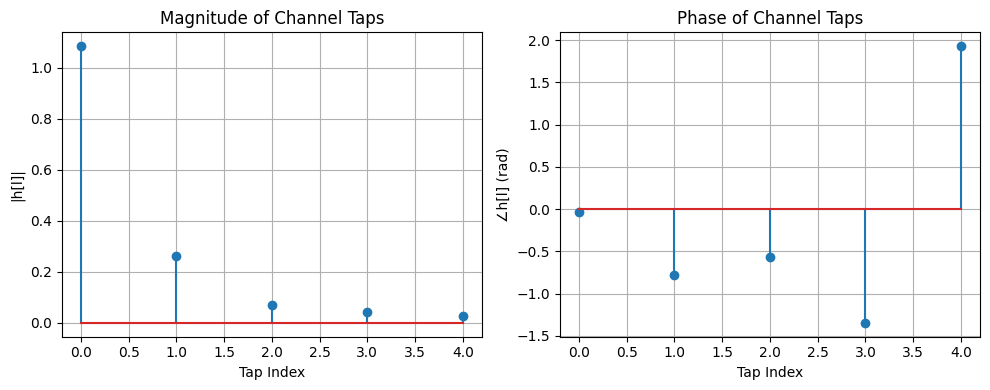

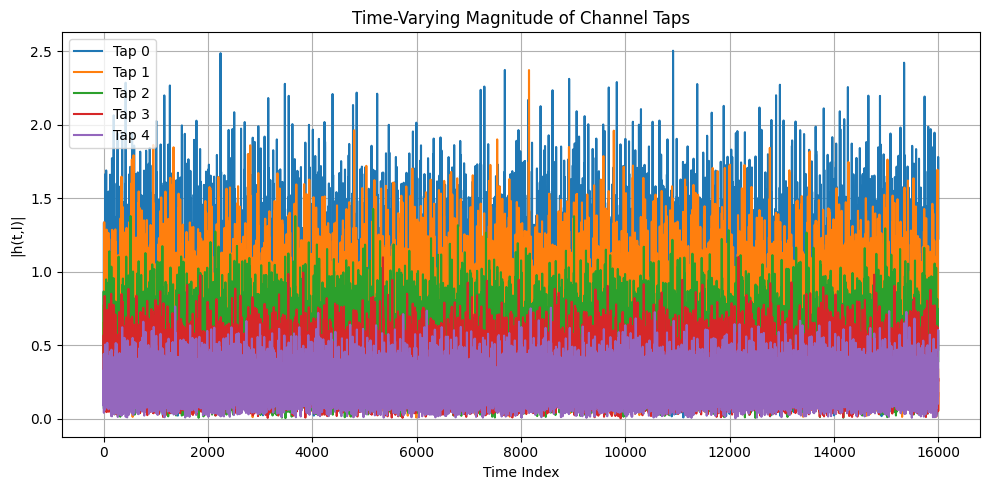

In [ ]:
faded_signal, h_time = multipath_doppler_fading(ofdm_signal, num_taps=5, alpha_rayleigh=0.6, fd=150, fs=1e3, snr_db=20)


---

# Gray Coding

**Gray coding**, or **reflected binary code**, is a binary numeral system in which **two successive values differ in only one bit**. This property minimizes the probability of large symbol errors during quantization, modulation, or transmission, especially in the presence of noise.

It is widely used in:

* **Digital modulation** schemes (e.g., QPSK, 16-QAM, 64-QAM)
* **Analog-to-digital converters (ADCs)**
* **Error-resilient encoding** and **hardware-efficient encoders**


For any $n$-bit Gray code sequence $G_0, G_1, \dots, G_{2^n - 1}$, the Hamming distance between consecutive codewords is always **1**:

$$
\text{Hamming}(G_k, G_{k+1}) = 1
\quad \text{for all } k \in \{0, \dots, 2^n - 2\}
$$

This ensures that **only one bit changes at a time**, reducing the chance of large misinterpretations in quantized data or demodulated symbols.


## Binary to Gray Code Conversion

Given an $n$-bit binary number $b = b_{n-1}b_{n-2} \dots b_0$, its corresponding Gray code $g = g_{n-1}g_{n-2} \dots g_0$ is given by:

$$
g_i = 
\begin{cases}
b_{n-1}, & \text{if } i = n-1 \\
b_i \oplus b_{i+1}, & \text{for } i = n-2, \dots, 0
\end{cases}
$$

Where:

* $\oplus$ is the XOR operation
* $g_{n-1}$ (most significant bit) is equal to $b_{n-1}$

### Example (3-bit Binary → Gray):

| Decimal | Binary | Gray |
| ------- | ------ | ---- |
| 0       | 000    | 000  |
| 1       | 001    | 001  |
| 2       | 010    | 011  |
| 3       | 011    | 010  |
| 4       | 100    | 110  |
| 5       | 101    | 111  |
| 6       | 110    | 101  |
| 7       | 111    | 100  |

---

## Gray Code to Binary Conversion

To decode Gray code $g = g_{n-1}g_{n-2}\dots g_0$ back to binary $b$, apply:

$$
b_{n-1} = g_{n-1}
$$

$$
b_i = b_{i+1} \oplus g_i, \quad \text{for } i = n-2, \dots, 0
$$

This reconstructs the original binary sequence using a recursive XOR chain.


## Application in Modulation (e.g., QAM)

In digital modulation such as **QPSK** or **16-QAM**, each symbol corresponds to a bit pattern. Using Gray coding minimizes the **bit error rate (BER)** because:

* Closest constellation points differ by only one bit.
* A small error in the received signal (e.g., due to noise) results in only **one bit error**, not multiple.

### Example (16-QAM):

* Binary sequence: 0000, 0001, 0011, 0010, ...
* Gray-coded mapping: ensures adjacent symbols in the I-Q plane differ by 1 bit only.


## Mathematical Formulation

### Binary to Gray:

$$
g = b \oplus (b \gg 1)
$$

Where $\gg$ is the right bit-shift operator.

### Gray to Binary (loop form):

```python
def gray_to_binary(g):
    b = g
    while g > 0:
        g >>= 1
        b ^= g
    return b
```

---

| Feature      | Description                          |
| ------------ | ------------------------------------ |
| Type         | Non-weighted code                    |
| Key Property | Successive values differ by 1 bit    |
| Application  | Modulation, ADCs, error minimization |
| Conversion   | XOR-based (binary ↔ gray)            |
| Advantage    | Reduces BER in noisy channels        |



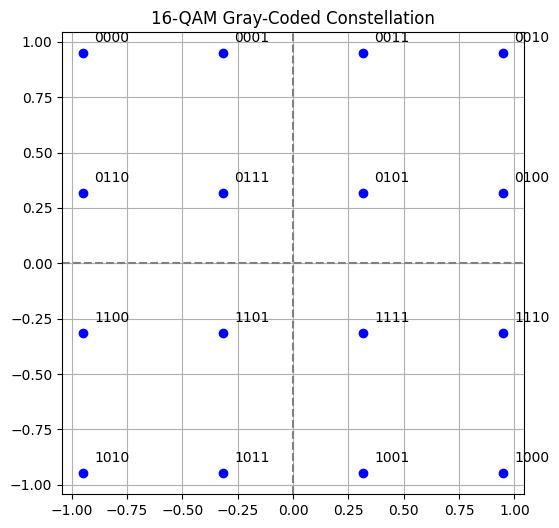

In [163]:
# Gray-Coded QPSK & 16-QAM

# Gray encoding for integers
def binary_to_gray(n):
    return n ^ (n >> 1)

# Gray decoding
def gray_to_binary(g):
    b = g
    while g > 0:
        g >>= 1
        b ^= g
    return b

# Generate Gray mapping for M-QAM
def generate_gray_map(M):
    bits_per_symbol = int(np.log2(M))
    gray_map = {}
    inv_gray_map = {}

    for i in range(M):
        gray = binary_to_gray(i)
        b_str = format(gray, f'0{bits_per_symbol}b')
        gray_map[i] = b_str
        inv_gray_map[b_str] = i

    return gray_map, inv_gray_map

# QAM constellation mapper (Gray coded)
def qam_constellation(M):
    k = int(np.sqrt(M))
    assert k * k == M, "M must be a perfect square for square QAM"

    # Normalize constellation to unit average energy
    scale = np.sqrt((2/3) * (M - 1))
    x = np.arange(k)
    points = (2 * x - (k - 1)) / scale

    const_points = []
    label_map = {}
    gray_map, _ = generate_gray_map(M)

    for i in range(k):
        for j in range(k):
            idx = i * k + j
            symbol = points[j] + 1j * points[k - 1 - i]  # flip vertically for I-Q order
            label = gray_map[idx]
            const_points.append(symbol)
            label_map[label] = symbol

    return label_map

# Example: Plot 16-QAM Gray-coded constellation
def plot_constellation(label_map):
    plt.figure(figsize=(6, 6))
    for bits, point in label_map.items():
        plt.plot(point.real, point.imag, 'bo')
        plt.text(point.real + 0.05, point.imag + 0.05, bits, fontsize=10)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title("16-QAM Gray-Coded Constellation")
    plt.grid(True)
    plt.gca().set_aspect('equal')
    plt.show()

# Mapping and example usage
M = 16  # Try M = 4 for QPSK, or M = 16 for 16-QAM
label_map = qam_constellation(M)
plot_constellation(label_map)


In [164]:
def bits_to_symbol(bits, label_map):
    return label_map[bits]


In [165]:
from scipy.spatial import KDTree

def symbol_to_bits(received_symbol, label_map):
    points = list(label_map.values())
    labels = list(label_map.keys())
    tree = KDTree([(p.real, p.imag) for p in points])
    _, idx = tree.query([received_symbol.real, received_symbol.imag])
    return labels[idx]


## Frequency Offset and Phase Noise in Wireless Communication


In practical wireless communication systems, **ideal oscillators** are assumed during modulation and demodulation. However, in reality, local oscillators (LOs) in the transmitter and receiver are never perfectly synchronized. They introduce imperfections such as:

* **Carrier frequency offset** (CFO): due to oscillator frequency mismatch

* **Phase noise**: due to rapid phase variations (jitter), often modeled as a random process

These effects degrade system performance, especially in systems like **OFDM**, where they destroy subcarrier orthogonality.


## 1. Carrier Frequency Offset (CFO)

Carrier frequency offset occurs when the transmitter and receiver oscillators differ by a small frequency:

$$
f_{\text{offset}} = f_{\text{LO,rx}} - f_{\text{LO,tx}}
$$

### Effect on Baseband Signal

Let $s[n]$ be the transmitted baseband signal. The received signal with frequency offset is:

$$
r[n] = s[n] \cdot e^{j 2\pi \Delta f n T_s}
$$

where:

* $\Delta f = f_{\text{offset}}$: frequency offset in Hz
* $T_s$: sampling interval ( $T_s = 1/f_s$ )
* $n$: sample index

This offset introduces a **linear phase rotation** over time, which:

* Causes constellation rotation in single-carrier systems
* Destroys subcarrier orthogonality in OFDM, leading to **inter-carrier interference (ICI)**

### Normalized Frequency Offset (ε)

For OFDM systems with subcarrier spacing $\Delta f_{\text{sub}}$, the normalized frequency offset is defined as:

$$
\epsilon = \frac{\Delta f}{\Delta f_{\text{sub}}}
$$

Even small $\epsilon$ values cause significant BER degradation.


## 2. Phase Noise

Phase noise is a **rapid, random fluctuation** in the phase of the carrier signal, typically modeled as a **stochastic process**. It originates from short-term instability in oscillator frequency due to electronic noise and jitter.

### Baseband Effect

Let $\phi[n]$ be a random phase process (e.g., a Wiener process). The received signal becomes:

$$
r[n] = s[n] \cdot e^{j \phi[n]}
$$

This introduces **non-linear, time-varying phase distortion**, even if the carrier frequency is aligned.

### Phase Noise Modeling

Common models for $\phi[n]$:

* **Wiener process**: $\phi[n] = \phi[n-1] + \Delta\phi[n]$, where $\Delta\phi[n] \sim \mathcal{N}(0, \sigma_\phi^2)$
* **Filtered white noise**: simulating phase-locked loop behavior

Phase noise affects:

* **QAM constellation stability**
* **Subcarrier leakage** in OFDM (similar to ICI)
* **Coherent demodulation** in MIMO and tracking loops


## 3. Combined Model

In many practical models, both effects are applied simultaneously:

$$
r[n] = s[n] \cdot e^{j(2\pi \Delta f n T_s + \phi[n])}
$$

This models a system with:

* **Carrier offset** (deterministic phase rotation)
* **Phase noise** (random walk or bounded phase jitter)


## 4. Impact on Systems

| System Type    | Impact of Frequency Offset | Impact of Phase Noise |
| -------------- | -------------------------- | --------------------- |
| OFDM           | Inter-carrier interference | Phase rotation, ICI   |
| Single-carrier | Constellation rotation     | Tracking loss, jitter |
| Coherent MIMO  | Channel estimation error   | Synchronization loss  |





| Term             | Description                                            |
| ---------------- | ------------------------------------------------------ |
| Frequency Offset | Mismatch between TX and RX oscillator frequencies      |
| Phase Noise      | Random phase fluctuation due to jitter/noise           |
| Modeling         | Apply complex exponential phase distortion to signal   |
| Common Models    | Linear phase drift (CFO), random walk (Wiener process) |
| Critical for     | OFDM, MIMO, coherent receivers, radar systems          |



In [104]:
def apply_full_channel_model(
    signal,
    fs=1.0,
    num_taps=3,
    alpha_rayleigh=0.7,
    fd=100,
    snr_db=None,
    num_sinusoids=32,
    freq_offset_hz=0.0,
    phase_noise_std=0.0,
    seed=None
):
    """
    Apply multipath Rayleigh fading with Doppler, frequency offset, and phase noise.

    Parameters:
    - signal: Input complex baseband signal (1D array)
    - fs: Sampling rate in Hz
    - num_taps: Number of Rayleigh taps
    - alpha_rayleigh: Exponential decay rate for power profile
    - fd: Max Doppler frequency in Hz
    - snr_db: SNR in dB for AWGN (optional)
    - num_sinusoids: Number of sinusoids for Doppler fading
    - freq_offset_hz: Carrier frequency offset (Hz)
    - phase_noise_std: Std dev of phase noise increments (radians)
    - seed: Optional seed for reproducibility

    Returns:
    - impaired_signal: Output signal with all impairments
    - h_time: Time-varying channel taps [len(signal), num_taps]
    """

    if seed is not None:
        np.random.seed(seed)

    N = len(signal)
    t = np.arange(N) / fs

    # Exponential power delay profile
    tap_powers = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers /= np.sum(tap_powers)

    # Generate time-varying Rayleigh fading per tap
    h_time = np.zeros((N, num_taps), dtype=complex)
    for l in range(num_taps):
        theta = 2 * np.pi * np.arange(1, num_sinusoids + 1) / (num_sinusoids + 1)
        phi = 2 * np.pi * np.random.rand(num_sinusoids)
        real = np.sqrt(2 / num_sinusoids) * np.sum(
            np.cos(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1)
        imag = np.sqrt(2 / num_sinusoids) * np.sum(
            np.sin(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1)
        fading_process = real + 1j * imag
        h_time[:, l] = fading_process * np.sqrt(tap_powers[l])

    # Time-varying convolution
    faded_signal = np.zeros(N, dtype=complex)
    for l in range(num_taps):
        delayed = np.roll(signal, l)
        delayed[:l] = 0
        faded_signal += h_time[:, l] * delayed

    # Apply frequency offset: r[n] *= exp(j*2pi*f*nTs)
    freq_rot = np.exp(1j * 2 * np.pi * freq_offset_hz * t)
    faded_signal *= freq_rot

    # Apply phase noise as random walk
    if phase_noise_std > 0.0:
        delta_phi = np.random.normal(0, phase_noise_std, size=N)
        phi = np.cumsum(delta_phi)
        faded_signal *= np.exp(1j * phi)

    # Add AWGN
    if snr_db is not None:
        sig_power = np.mean(np.abs(faded_signal) ** 2)
        noise_power = sig_power / (10 ** (snr_db / 10))
        noise = (np.random.randn(N) + 1j * np.random.randn(N)) * np.sqrt(noise_power / 2)
        faded_signal += noise
    
    plt.figure(figsize=(10, 5))
    for l in range(h_time.shape[1]):
        plt.plot(np.abs(h_time[:, l]), label=f'Tap {l}')
    plt.title("Time-Varying Channel Tap Magnitudes")
    plt.xlabel("Sample Index")
    plt.ylabel("|h[n, l]|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return faded_signal, h_time


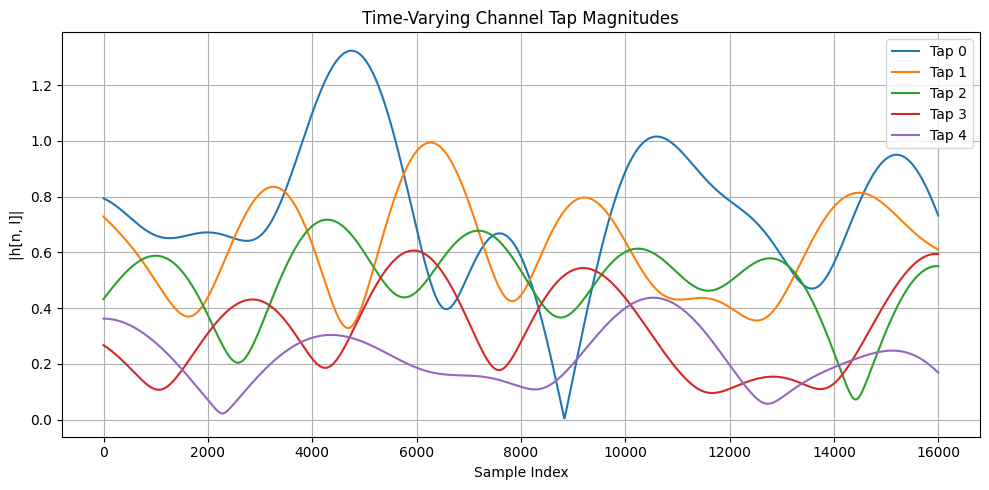

In [105]:
faded_signal, h_time = apply_full_channel_model(
    signal=ofdm_signal,
    fs=1e6,                     # 1 MHz sampling rate
    num_taps=5,
    alpha_rayleigh=0.6,
    fd=200,                     # 200 Hz Doppler
    snr_db=20,
    freq_offset_hz=100,         # 100 Hz carrier offset
    phase_noise_std=1e-3,       # radians per sample
    seed=42
)


## Timing Offset and Jitter in Communication Systems

In practical digital communication systems, accurate **symbol timing** is essential for correct demodulation and decoding of the received signal. However, real-world impairments such as **timing offset** and **jitter** arise due to imperfections in oscillators and sampling circuits. These effects distort the received waveform, increase inter-symbol interference (ISI), and degrade the system's bit error rate (BER).


## 1. Timing Offset

**Timing offset** occurs when the receiver samples the incoming signal at an incorrect time relative to the symbol boundaries.

### Causes:

* Mismatch between transmitter and receiver clock frequencies
* Propagation delay not accurately accounted for
* Lack of synchronization during receiver acquisition

### Effect on Received Signal

Assume ideal transmitted signal $x(t)$ is sampled at symbol period $T_s$. If the receiver samples at $t = nT_s + \tau$, where $\tau$ is a fixed offset, then the received samples become:

$$
r[n] = x(nT_s + \tau)
$$

This leads to:

* **Suboptimal symbol detection**
* Increased **inter-symbol interference (ISI)**, especially with pulse-shaped signals (e.g., raised cosine)

In multicarrier systems like OFDM, timing offset leads to:

* **Loss of orthogonality** between subcarriers
* Inter-symbol and inter-carrier interference
* Phase rotations across subcarriers (if offset is within the cyclic prefix)

### Types

* **Integer timing offset**: Offset by full symbols (can be corrected using frame synchronization)
* **Fractional timing offset**: Offset by a fraction of symbol period (requires interpolation or matched filtering)


## 2. Timing Jitter

### Definition

**Timing jitter** refers to **random, time-varying fluctuations** in the timing of sampling instants. Instead of sampling exactly at $t = nT_s$, the receiver samples at:

$$
t_n = nT_s + \delta_n
$$

where $\delta_n$ is a random variable representing instantaneous timing error (jitter) at time index $n$.

### Causes

* Thermal noise in clock circuits
* Power supply noise affecting oscillators
* Phase noise in phase-locked loops (PLLs)
* Quantization and jitter in ADC clock sources

### Effect on Signal

Timing jitter causes:

* **Non-uniform sampling** of the waveform
* Distortion of signal amplitude (even if the carrier is intact)
* Degradation of **eye diagram** and **symbol integrity**
* Increased **bit error rate**, especially in high-speed and high-order modulation systems

## 3. Modeling Timing Offset and Jitter

### 3.1 Timing Offset

For a baseband signal sampled at incorrect time offset $\tau$:

$$
r[n] = x(nT_s + \tau)
$$

In discrete simulations, this is implemented by:

* Interpolation (e.g., sinc or linear) to resample at $\tau$
* Circular shift for integer sample offsets (in discrete time)


### 3.2 Timing Jitter

Timing jitter is modeled as:

$$
t_n = nT_s + \delta_n, \quad \delta_n \sim \mathcal{N}(0, \sigma_t^2)
$$

where:

* $\sigma_t$: standard deviation of timing noise
* $\delta_n$: independent or correlated noise samples (white or colored jitter)

Interpolation is used to obtain $r[n] = x(t_n)$ from the original waveform.


## 4. Impact on Communication Systems

| System                  | Impact of Timing Offset  | Impact of Jitter                            |
| ----------------------- | ------------------------ | ------------------------------------------- |
| Single-carrier          | ISI, degraded sampling   | Symbol distortion                           |
| OFDM                    | ICI, symbol misalignment | Loss of orthogonality, amplitude distortion |
| High-speed serial links | Eye closure              | Jitter-induced sampling errors              |
| MIMO                    | Synchronization mismatch | Channel estimation errors                   |

---




In [110]:
from scipy.interpolate import interp1d


def apply_timing_offset_and_jitter(signal, timing_offset=0.0, jitter_std=0.0, fs=1.0, seed=None):
    """
    Apply constant timing offset and random timing jitter to a signal.

    Parameters:
    - signal: Input complex baseband signal
    - timing_offset: Constant delay in seconds (e.g., 0.25 * Ts)
    - jitter_std: Std dev of jitter (in seconds)
    - fs: Sampling frequency (Hz)
    - seed: Random seed for reproducibility

    Returns:
    - distorted_signal: Resampled signal with timing offset and jitter
    - sampling_instants: Actual sampling times applied
    """
    if seed is not None:
        np.random.seed(seed)

    N = len(signal)
    t_original = np.arange(N) / fs
    Ts = 1 / fs

    # Timing offset + jitter
    jitter = np.random.normal(0, jitter_std, size=N)
    sampling_instants = t_original + timing_offset + jitter

    # Interpolation
    interp_real = interp1d(t_original, signal.real, kind='linear', bounds_error=False, fill_value="extrapolate")
    interp_imag = interp1d(t_original, signal.imag, kind='linear', bounds_error=False, fill_value="extrapolate")
    distorted_real = interp_real(sampling_instants)
    distorted_imag = interp_imag(sampling_instants)
    distorted_signal = distorted_real + 1j * distorted_imag

    return distorted_signal, sampling_instants


In [111]:
def plot_eye_diagram(signal, sps=1, span=2, offset=0):
    """
    Plot an eye diagram for the given complex signal (real part only).

    Parameters:
    - signal: Input signal
    - sps: Samples per symbol
    - span: How many symbol periods per trace
    - offset: Optional sample offset
    """
    trace_len = span * sps
    num_traces = (len(signal) - offset) // trace_len

    plt.figure(figsize=(10, 4))
    for i in range(num_traces):
        start = offset + i * trace_len
        end = start + trace_len
        trace = signal[start:end]
        if len(trace) == trace_len:
            plt.plot(np.arange(trace_len), np.real(trace), color='blue', alpha=0.3)
    plt.title("Eye Diagram (Real Part)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


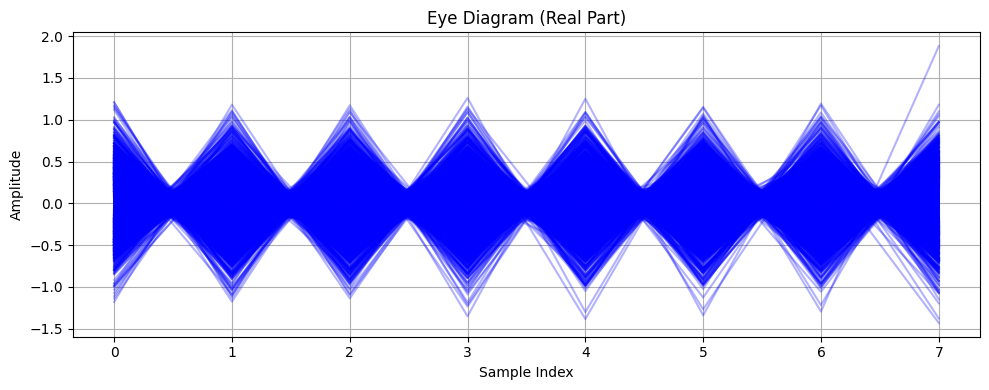

In [112]:
fs = 1e6
Ts = 1 / fs
timing_offset = 0.25 * Ts
jitter_std = 0.03 * Ts
distorted_signal, _ = apply_timing_offset_and_jitter(ofdm_signal, timing_offset, jitter_std, fs=fs, seed=42)
plot_eye_diagram(distorted_signal, sps=4)


## Timing Synchronization in OFDM Systems

In practical OFDM systems, the receiver must determine **when to start FFT demodulation**, i.e., the **symbol timing**. Incorrect timing leads to:

* Loss of orthogonality
* Inter-symbol interference (ISI)
* Inter-carrier interference (ICI)

**Timing synchronization** is the process of identifying the correct start of the OFDM symbol. Two popular techniques are:

1. **Cyclic Prefix (CP) Autocorrelation**
2. **Schmidl-Cox Algorithm**


## 1. Cyclic Prefix (CP) Autocorrelation

In OFDM, each symbol is extended with a **cyclic prefix** (CP), which is a copy of the last $L_{\text{CP}}$ samples of the IFFT output. The receiver can exploit this redundancy to find symbol boundaries.

Let the received signal be $r[n]$, and the expected symbol length be $L = N + L_{\text{CP}}$, where:

* $N$: IFFT size (data part)
* $L_{\text{CP}}$: CP length

Define the following correlation metric at lag $d$:

$$
R[d] = \sum_{n=0}^{L_{\text{CP}}-1} r^*[d+n] \cdot r[d+n+N]
$$

$$
P[d] = \left| R[d] \right|
$$

$$
E[d] = \sum_{n=0}^{L_{\text{CP}}-1} \left( |r[d+n]|^2 + |r[d+n+N]|^2 \right)
$$

Then define the **timing metric**:

$$
M[d] = \frac{P[d]^2}{E[d]^2}
$$

* $M[d]$ peaks at the start of the OFDM symbol, where the CP and the end of the symbol match perfectly.
* This method is computationally efficient and works well for moderate SNRs and slow fading.

--- 

## 2. Schmidl-Cox Algorithm


Schmidl and Cox proposed a robust method using a **training symbol** with **two identical halves** in the time domain. The receiver correlates these halves to detect timing.

### Transmitted Training Symbol

Let the training symbol $x[n]$ be structured as:

$$
x = [a, a]
$$

where $a$ is a sequence of $N/2$ samples.

At the receiver, the signal is:

$$
r[n] = x[n - d] + w[n]
$$

### Timing Metric

Let $D$ be the distance between the repeated halves (e.g., $D = N/2$). Then define:

$$
P[d] = \sum_{n=0}^{D-1} r^*[n+d] \cdot r[n+d+D]
$$

$$
R[d] = \sum_{n=0}^{D-1} |r[n+d+D]|^2
$$

$$
M[d] = \frac{|P[d]|^2}{(R[d])^2}
$$

### Interpretation

* $M[d]$ produces a **plateau** followed by a **sharp drop**, marking the end of the training symbol.
* The **start of the plateau** corresponds to the correct FFT window.
* Robust to frequency offset and noise, which makes it suitable for wireless OFDM (e.g., IEEE 802.11a/g/n).

---

Timing synchronization is a critical first step in OFDM reception. Both CP autocorrelation and the Schmidl-Cox method estimate the correct FFT window by exploiting structure in the time-domain waveform. In practice, **coarse timing** is often done using Schmidl-Cox, followed by **fine timing** using channel estimation or pilot symbols.



In [113]:
def timing_sync_cp_autocorr(rx_signal, N, cp_len):
    """
    Estimate symbol start using cyclic prefix autocorrelation.

    Parameters:
    - rx_signal: Received signal (1D complex numpy array)
    - N: FFT size (data part length)
    - cp_len: Cyclic prefix length

    Returns:
    - timing_index: Estimated start index of OFDM symbol
    - metric: Correlation metric (1D array)
    """
    metric = []
    for d in range(len(rx_signal) - N - cp_len):
        r1 = rx_signal[d : d + cp_len]
        r2 = rx_signal[d + N : d + N + cp_len]
        R = np.sum(np.conj(r1) * r2)
        E = np.sum(np.abs(r1)**2 + np.abs(r2)**2)
        m = np.abs(R)**2 / (E**2 + 1e-12)  # avoid divide by zero
        metric.append(m)

    timing_index = np.argmax(metric)
    return timing_index, np.array(metric)


In [114]:
def timing_sync_schmidl_cox(rx_signal, D):
    """
    Estimate timing using Schmidl-Cox algorithm.

    Parameters:
    - rx_signal: Received signal (1D complex numpy array)
    - D: Length of repeated half (typically FFT size // 2)

    Returns:
    - timing_index: Estimated start index of OFDM training symbol
    - metric: Timing metric M[d] array
    """
    metric = []
    for d in range(len(rx_signal) - 2*D):
        P = np.sum(np.conj(rx_signal[d:d+D]) * rx_signal[d+D:d+2*D])
        R = np.sum(np.abs(rx_signal[d+D:d+2*D])**2)
        m = np.abs(P)**2 / (R**2 + 1e-12)
        metric.append(m)

    timing_index = np.argmax(metric)
    return timing_index, np.array(metric)


In [115]:
# Assume rx_signal is your received waveform (numpy array)
N = 64
cp_len = 16
D = N // 2  # For Schmidl-Cox

# CP-based
idx_cp, cp_metric = timing_sync_cp_autocorr(rx_signal, N, cp_len)

# Schmidl-Cox
idx_sc, sc_metric = timing_sync_schmidl_cox(rx_signal, D)


In [116]:
def plot_timing_metric(metric, title="Timing Metric"):
    plt.figure(figsize=(10, 4))
    plt.plot(metric)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Metric Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



---

## Frequency Offset Correction and Frame Detection in Digital Communication

### 1. Frequency Offset Correction

#### Overview

In practical systems, mismatch between transmitter and receiver oscillator frequencies introduces a **carrier frequency offset (CFO)**. This causes a **time-varying phase rotation** in the received signal, which severely degrades performance in systems like OFDM by introducing:

* **Inter-carrier interference (ICI)**
* **Symbol rotation and spreading**

#### Mathematical Model

Let $x[n]$ be the transmitted baseband signal. The received signal $r[n]$ with frequency offset $\Delta f$ becomes:

$$
r[n] = x[n] \cdot e^{j 2\pi \Delta f n T_s} + w[n]
$$

where:

* $\Delta f$: Frequency offset (Hz)
* $T_s$: Sampling period
* $w[n]$: Additive noise

This introduces a **linear phase drift** over time.

---

### Frequency Offset Estimation (Coarse)

If a signal contains **two identical segments** (like in the Schmidl-Cox preamble), the phase difference between them can be used to estimate the CFO:

$$
\phi = \angle \left( \sum_{n=0}^{N-1} r[n] \cdot r^*[n+N] \right)
$$

$$
\Delta f = \frac{\phi}{2\pi N T_s}
$$

This works because the frequency offset causes the second half to rotate by an additional phase:

$$
e^{j 2\pi \Delta f N T_s}
$$

---

### Frequency Offset Correction

Once $\Delta f$ is estimated, the correction is applied by rotating the received signal with the opposite phase:

$$
r_{\text{corr}}[n] = r[n] \cdot e^{-j 2\pi \Delta f n T_s}
$$

This effectively compensates for the CFO and restores the signal's phase coherence.

---

## Frame Detection Using Preambles

**Frame detection** identifies the start of a packet or OFDM frame. This is usually done using a known **preamble sequence** inserted at the beginning of each frame.

Popular sequences:

* **Zadoff-Chu (ZC)**: Used in LTE/5G for synchronization
* **PN (Pseudorandom Noise) sequences**: Used in Wi-Fi and spread-spectrum systems

### Matched Filtering for Detection

Let $p[n]$ be the known preamble (length $L$), and $r[n]$ the received signal. The **cross-correlation** or **matched filter** output is:

$$
y[n] = \sum_{k=0}^{L-1} r[n + k] \cdot p^*[k]
$$

The frame start is where $|y[n]|$ reaches a peak:

$$
\text{frame\_start} = \arg\max_n |y[n]|
$$

This works because convolution with the conjugate of the known sequence $p^*[k]$ maximizes the output when alignment occurs.

---

### Zadoff-Chu Sequences

Zadoff-Chu (ZC) sequences are a family of **constant amplitude** and **zero autocorrelation** sequences. A ZC sequence of length $N$ is defined as:

$$
x[n] = e^{-j \frac{\pi q n (n+1)}{N}}, \quad n = 0, 1, \dots, N-1
$$

where:

* $N$: sequence length (odd number)
* $q$: root index (coprime to $N$)

**Properties**:

* Constant magnitude
* Ideal autocorrelation:

  $$
  \sum_n x[n] x^*[n + \tau] = 0 \quad \text{for } \tau \ne 0
  $$
* Used in 3GPP LTE/5G for timing, synchronization, and random access

---

### PN Sequences (e.g., m-sequences)

PN sequences are generated using shift registers and have excellent **autocorrelation properties**:

$$
R_p[\tau] =
\begin{cases}
1, & \text{if } \tau = 0 \\
-1/N, & \text{if } \tau \ne 0
\end{cases}
$$

They are commonly used in:

* DSSS/CDMA systems
* Wi-Fi synchronization fields (e.g., Short Training Field)

---


| Function                    | Description                                            |
| --------------------------- | ------------------------------------------------------ |
| Frequency offset estimation | Use phase difference between repeated signal parts     |
| Frequency correction        | Rotate received signal by $e^{-j 2\pi \Delta f n T_s}$ |
| Frame detection             | Cross-correlate received signal with known preamble    |
| Preamble types              | Zadoff-Chu (5G), PN/m-sequences (Wi-Fi/CDMA)           |




In [117]:
def estimate_frequency_offset(rx_signal, N, fs):
    """
    Estimate frequency offset using two repeated OFDM halves.

    Parameters:
    - rx_signal: Received signal (must include two identical halves)
    - N: Length of one half (e.g., FFT size / 2)
    - fs: Sampling frequency in Hz

    Returns:
    - freq_offset: Estimated frequency offset in Hz
    """
    P = np.sum(rx_signal[:N] * np.conj(rx_signal[N:2*N]))
    phase_diff = np.angle(P)
    freq_offset = phase_diff / (2 * np.pi * N / fs)
    return freq_offset


In [118]:
def correct_frequency_offset(rx_signal, freq_offset, fs):
    """
    Apply frequency offset correction.

    Parameters:
    - rx_signal: Received signal
    - freq_offset: Estimated offset in Hz
    - fs: Sampling frequency in Hz

    Returns:
    - corrected_signal: Frequency-compensated signal
    """
    N = len(rx_signal)
    t = np.arange(N) / fs
    correction = np.exp(-1j * 2 * np.pi * freq_offset * t)
    return rx_signal * correction


In [121]:
def detect_frame_start(rx_signal, preamble):
    """
    Detect frame start using matched filter (cross-correlation).

    Parameters:
    - rx_signal: Received complex signal
    - preamble: Known preamble (1D array)

    Returns:
    - start_index: Estimated frame start index
    - correlation: Cross-correlation result (magnitude)
    """
    correlation = np.abs(np.correlate(rx_signal, preamble[::-1].conj(), mode='valid'))
    start_index = np.argmax(correlation)
    return start_index, correlation


In [119]:
def generate_zadoff_chu_seq(N, q):
    """
    Generate a Zadoff-Chu sequence.

    Parameters:
    - N: Sequence length (must be prime or co-prime to q)
    - q: Root index (must be coprime to N)

    Returns:
    - zc_seq: Complex Zadoff-Chu sequence of length N
    """
    n = np.arange(N)
    zc_seq = np.exp(-1j * np.pi * q * n * (n + 1) / N)
    return zc_seq


In [122]:
fs = 1e6        # 1 MHz sampling rate
N = 64          # FFT size or repeated segment length

# --- Frequency Offset ---
freq_offset_est = estimate_frequency_offset(rx_signal, N//2, fs)
rx_corrected = correct_frequency_offset(rx_signal, freq_offset_est, fs)

# --- Zadoff-Chu Preamble ---
zc = generate_zadoff_chu_seq(N=63, q=5)

# --- Frame Detection ---
start_idx, corr = detect_frame_start(rx_corrected, zc)


## Channel Equalization: LS and MMSE Methods

In digital communication systems, especially in OFDM and MIMO, the signal received over a wireless channel undergoes distortion due to multipath fading. To recover the original transmitted signal, **equalization** is applied to **undo the channel effect**.

The system model is:

$$
y = Hx + n
$$

where:

* $y$: Received signal vector
* $H$: Channel matrix or frequency-domain channel coefficient
* $x$: Transmitted signal vector (unknown)
* $n$: Additive noise vector (e.g., AWGN)

The goal of equalization is to estimate $x$ from $y$ using knowledge (or estimation) of $H$.

## 1. Least Squares (LS) Equalization

Minimize the **squared error** between the observed signal and the predicted signal:

$$
\hat{x}_{\text{LS}} = \arg\min_x \| y - Hx \|^2
$$

The LS solution is obtained by solving the normal equations:

$$
\hat{x}_{\text{LS}} = (H^H H)^{-1} H^H y
$$

* $H^H$: Hermitian (conjugate transpose) of $H$
* If $H$ is diagonal (e.g., in OFDM), this simplifies to:

  $$
  \hat{x}_{\text{LS}}[k] = \frac{y[k]}{H[k]} \quad \text{(element-wise division)}
  $$

**Assumptions**:

* Channel is known
* Noise is **ignored** (or treated as unknown interference)
* LS does **not account for noise statistics**

---

## 2. Minimum Mean Squared Error (MMSE) Equalization

Minimize the **mean squared error (MSE)** between the true symbol and the estimated symbol, **taking noise into account**:

$$
\hat{x}_{\text{MMSE}} = \arg\min_{\hat{x}} \mathbb{E}\left[ \| x - \hat{x} \|^2 \right]
$$

This is a **Bayesian estimator** assuming known statistics for signal and noise.

The MMSE equalizer is given by:

$$
\hat{x}_{\text{MMSE}} = \left( H^H H + \sigma_n^2 I \right)^{-1} H^H y
$$

* $\sigma_n^2$: Noise variance
* $I$: Identity matrix

For scalar channels (e.g., OFDM subcarriers with independent flat-fading):

$$
\hat{x}_{\text{MMSE}}[k] = \frac{H^*[k]}{|H[k]|^2 + \sigma_n^2} \cdot y[k]
$$

or equivalently:

$$
\hat{x}_{\text{MMSE}}[k] = \frac{y[k]}{H[k] + \sigma_n^2 / H^*[k]}
$$

* MMSE reduces to LS when $\sigma_n^2 \to 0$
* MMSE prevents noise amplification when $H[k]$ is small



## Comparison: LS vs MMSE

| Method | Formula                             | Accounts for Noise? | Inverse Involves      | Stability                          |
| ------ | ----------------------------------- | ------------------- | --------------------- | ---------------------------------- |
| LS     | $(H^H H)^{-1} H^H y$                | No                  | Channel matrix only   | May amplify noise if $H \approx 0$ |
| MMSE   | $(H^H H + \sigma_n^2 I)^{-1} H^H y$ | Yes                 | Channel + noise power | More robust at low SNR             |

---

## Use Cases

* **LS**: Fast and simple, used when SNR is high or noise is negligible
* **MMSE**: Used in practical systems where noise matters (e.g., LTE/5G receivers)




MSE (LS): 0.0441
MSE (MMSE): 0.0384


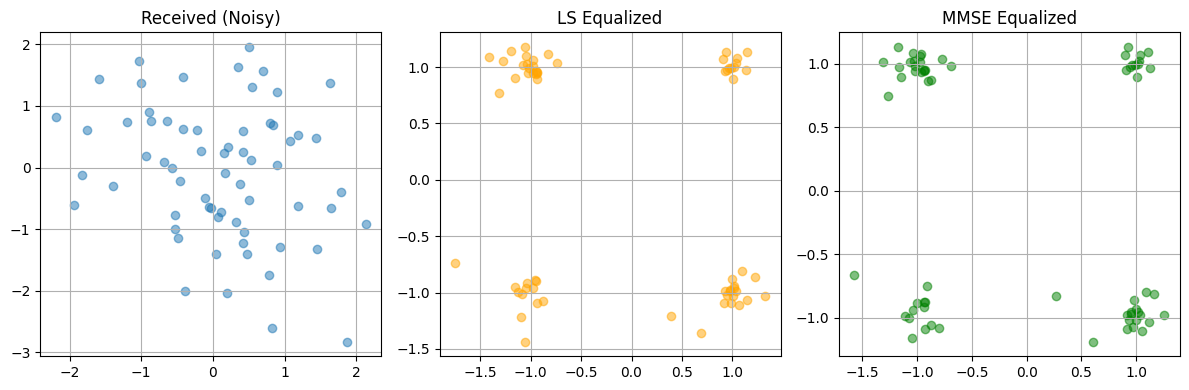

In [126]:
def ls_equalizer(H_est, Y):
    """
    LS Equalizer: X_hat = Y / H_est
    """
    H_est_safe = np.where(H_est == 0, 1e-12, H_est)
    return Y / H_est_safe

def mmse_equalizer(H_est, Y, noise_var):
    """
    MMSE Equalizer: X_hat = (H* / (|H|^2 + N0)) * Y
    """
    H_abs2 = np.abs(H_est) ** 2
    denom = H_abs2 + noise_var
    denom = np.where(denom == 0, 1e-12, denom)
    return (np.conj(H_est) / denom) * Y

# ---------------- Simulation ----------------
def simulate_equalization(N=64, noise_var=0.01):
    # Generate random QPSK symbols
    tx_symbols = np.random.choice([-1, 1], size=N) + 1j * np.random.choice([-1, 1], size=N)

    # Generate Rayleigh channel
    H = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)

    # Apply channel and AWGN
    noise = np.sqrt(noise_var/2) * (np.random.randn(N) + 1j * np.random.randn(N))
    rx_symbols = H * tx_symbols + noise

    # Equalize
    X_ls = ls_equalizer(H, rx_symbols)
    X_mmse = mmse_equalizer(H, rx_symbols, noise_var)

    # Compute errors
    mse_ls = np.mean(np.abs(X_ls - tx_symbols)**2)
    mse_mmse = np.mean(np.abs(X_mmse - tx_symbols)**2)

    print(f"MSE (LS): {mse_ls:.4f}")
    print(f"MSE (MMSE): {mse_mmse:.4f}")

    # Plot constellation comparison
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(rx_symbols.real, rx_symbols.imag, alpha=0.5)
    plt.title("Received (Noisy)")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.scatter(X_ls.real, X_ls.imag, alpha=0.5, color='orange')
    plt.title("LS Equalized")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.scatter(X_mmse.real, X_mmse.imag, alpha=0.5, color='green')
    plt.title("MMSE Equalized")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run it
simulate_equalization()


---
## Error Vector Magnitude (EVM)

**Error Vector Magnitude (EVM)** is a key metric used in digital communications to **quantify the quality of a modulated signal**. It compares the **received symbol** to the **ideal (reference) symbol**, capturing all imperfections including:

* Noise
* Phase noise
* Frequency offset
* IQ imbalance
* Nonlinearities

EVM is widely used in standards such as **3GPP LTE**, **5G NR**, **Wi-Fi**, and **IEEE 802.16** for receiver and transmitter performance evaluation.

### System Model

Let:

* $x_n$: Ideal transmitted symbol (reference constellation point)
* $\hat{x}_n$: Received symbol after demodulation and equalization

Then the **error vector** is defined as:

$$
e_n = \hat{x}_n - x_n
$$

The **EVM** is the **root mean square (RMS)** of the magnitude of these error vectors, normalized by the reference symbol energy.

**Linear EVM (unitless):**

$$
\text{EVM}_{\text{rms}} = \sqrt{ \frac{ \sum_{n=1}^N | \hat{x}_n - x_n |^2 }{ \sum_{n=1}^N |x_n|^2 } }
$$

**EVM in percentage:**

$$
\text{EVM}_{\%} = \text{EVM}_{\text{rms}} \times 100
$$

**EVM in dB:**

$$
\text{EVM}_{\text{dB}} = 20 \cdot \log_{10}(\text{EVM}_{\text{rms}})
$$

* **Lower EVM** indicates better signal quality
* Ideal system (no noise/distortion): $\text{EVM} = 0\%$
* EVM reflects the **combined effect** of impairments and is often more informative than SNR alone


### Typical Limits (per standards)

| Modulation | Max EVM (dB) | Max EVM (%) |
| ---------- | ------------ | ----------- |
| QPSK       | –20.0 dB     | 10.0%       |
| 16-QAM     | –25.0 dB     | 5.6%        |
| 64-QAM     | –28.0 dB     | 4.0%        |
| 256-QAM    | –32.0 dB     | 2.5%        |

(Exact values vary slightly by standard and application.)


### Why Use EVM?

* Holistic performance metric
* Used in conformance testing and quality assurance
* Reflects all RF and digital baseband imperfections

---


| Property         | Description                               |
| ---------------- | ----------------------------------------- |
| What it measures | Deviation of received from ideal symbol   |
| Depends on       | Noise, distortion, phase/frequency errors |
| Reported in      | % or dB                                   |
| Lower is better  | Yes (0% = perfect)                        |



---

# Low-Density Parity-Check (LDPC) Codes

**Low-Density Parity-Check (LDPC)** codes are powerful **linear block error-correcting codes** that approach the **Shannon limit**. They are used extensively in modern systems such as:

* 5G NR (control and data channels)
* Wi-Fi (802.11n/ac/ax)
* DVB-S2, DVB-T2 (Digital Video Broadcasting)
* CCSDS (space communications)

LDPC codes are defined by **sparse bipartite graphs**, making them well-suited for **iterative message-passing decoding algorithms**.

## 1. Code Structure

An LDPC code is defined by a **parity-check matrix** $\mathbf{H}$:

$$
\mathbf{H} \cdot \mathbf{c}^T = \mathbf{0}
$$

where:

* $\mathbf{H}$: $M \times N$ binary matrix
* $\mathbf{c}$: Codeword of length $N$ (binary vector)
* $M$: Number of parity-check equations
* $N$: Codeword length
* Code rate: $R = \frac{K}{N} = 1 - \frac{M}{N}$

### Low-Density

"Low-density" refers to the fact that **most entries of $\mathbf{H}$ are zero**. This sparsity enables fast encoding and efficient decoding.

## 2. Tanner Graph Representation

The LDPC code can be represented as a **bipartite graph**, called a **Tanner graph**, with:

* **Variable nodes** (corresponding to codeword bits)
* **Check nodes** (corresponding to parity-check equations)

An edge connects variable node $v_j$ to check node $c_i$ if $H_{i,j} = 1$.

This graphical structure enables **iterative decoding algorithms**.

## 3. Encoding Process

While LDPC is defined by the **parity-check matrix** $\mathbf{H}$, encoding requires a **generator matrix** $\mathbf{G}$ such that:

$$
\mathbf{c} = \mathbf{u} \cdot \mathbf{G}
$$

where:

* $\mathbf{u}$: Information bits of length $K$
* $\mathbf{c}$: Codeword of length $N$

For **systematic encoding**, $\mathbf{G}$ can be obtained from $\mathbf{H}$ through **Gaussian elimination** to convert $H$ into the form:

$$
\mathbf{H} = [\mathbf{A} \mid \mathbf{I}]
$$

where $\mathbf{I}$ is the identity matrix (parity part).

However, for large matrices (e.g., in 5G), **encoding is performed using structured quasi-cyclic LDPC matrices**, avoiding full matrix inversion.

## 4. Decoding: Belief Propagation (Sum-Product Algorithm)

LDPC decoding is typically performed using **iterative message-passing algorithms**, such as:

* **Sum-Product Algorithm (SPA)**
* **Min-Sum Algorithm (approximation)**

### Algorithm Steps:

At each iteration:

1. **Variable nodes** send their belief (log-likelihood ratio, LLR) to connected **check nodes**.
2. **Check nodes** compute outgoing messages using the incoming beliefs from variable nodes (excluding the one being updated).
3. Each **variable node** updates its estimate using the channel observation and messages from check nodes.
4. A **syndrome check** is performed:

   $$
   \mathbf{H} \cdot \hat{\mathbf{c}}^T = \mathbf{0}
   $$

   If satisfied, decoding is successful.

### Message Update Equations (LLR form)

Let $L_{j \to i}^{(t)}$ be the message from variable node $j$ to check node $i$ at iteration $t$:

$$
L_{j \to i}^{(t)} = L_{\text{ch}}(j) + \sum_{k \in \mathcal{N}(j) \setminus i} L_{k \to j}^{(t-1)}
$$

where $L_{\text{ch}}(j)$ is the channel LLR, and $\mathcal{N}(j)$ is the set of check nodes connected to variable node $j$.

Check node update (for SPA):

$$
L_{i \to j}^{(t)} = 2 \tanh^{-1} \left( \prod_{l \in \mathcal{M}(i) \setminus j} \tanh\left( \frac{L_{l \to i}^{(t-1)}}{2} \right) \right)
$$

Here $\mathcal{M}(i)$ is the set of variable nodes connected to check node $i$.

## 5. Code Design: Regular vs. Irregular LDPC

* **Regular LDPC**: Each variable/check node has a fixed degree (e.g., every variable node connects to 3 check nodes)
* **Irregular LDPC**: Degrees vary; better performance due to higher flexibility

Irregular LDPC codes are widely used in practice (e.g., DVB-S2, 5G NR) and optimized using **density evolution** and **EXIT charts**.

## 6. LDPC in 5G NR

3GPP 5G NR uses:

* **Quasi-cyclic LDPC codes**
* Two base graphs:

  * **Base Graph 1 (BG1)**: Used for large payloads and low code rates
  * **Base Graph 2 (BG2)**: Used for short payloads or high code rates
* Standardized lifting sizes and permutation matrices allow scalable and efficient hardware implementations

---

| Property   | Description                                      |
| ---------- | ------------------------------------------------ |
| Type       | Linear block code                                |
| Defined by | Sparse parity-check matrix $\mathbf{H}$          |
| Decoding   | Iterative (belief propagation)                   |
| Advantages | Near-capacity performance, parallelizable        |
| Used in    | 5G, Wi-Fi, DVB-S2, CCSDS, storage, optical links |



In [124]:
from scipy.sparse import csr_matrix
from scipy.special import expit

# ---------- Generate a Regular (3,6) LDPC Parity-Check Matrix ----------
def generate_ldpc_matrix(N, M, column_weight=3):
    H = np.zeros((M, N), dtype=int)
    for col in range(N):
        ones = np.random.choice(M, column_weight, replace=False)
        H[ones, col] = 1
    return H

# ---------- Naive LDPC Systematic Encoder ----------
def ldpc_encode(H, u):
    M, N = H.shape
    K = N - M
    if len(u) != K:
        raise ValueError("Input length must be N - M")
    # Construct generator matrix (naive for small H)
    H1 = H[:, :K]
    H2 = H[:, K:]
    try:
        P = np.linalg.pinv(H1) @ H2
    except np.linalg.LinAlgError:
        raise ValueError("Matrix H1 is not invertible")
    G = np.hstack([np.eye(K, dtype=int), P]) % 2
    return (u @ G % 2).astype(int)

# ---------- Sum-Product Algorithm Decoder ----------
def ldpc_decode_spa(H, rx_llr, max_iters=30):
    M, N = H.shape
    H_sparse = csr_matrix(H)
    Lq = np.tile(rx_llr, (M, 1)) * H  # Variable to check
    Lr = np.zeros((M, N))             # Check to variable

    for _ in range(max_iters):
        # Check node update
        for m in range(M):
            indices = H_sparse[m].indices
            for n in indices:
                others = [i for i in indices if i != n]
                prod = np.prod(np.tanh(Lq[m, others] / 2 + 1e-12))
                Lr[m, n] = 2 * np.arctanh(prod + 1e-12)

        # Variable node update
        for n in range(N):
            connected = H_sparse[:, n].indices
            Lq[connected, n] = rx_llr[n] + np.sum(Lr[connected, n], axis=0)

        # Posterior
        L_posterior = rx_llr + np.sum(Lr, axis=0)
        decoded = (L_posterior < 0).astype(int)

        # Check if parity satisfied
        if np.all((H @ decoded) % 2 == 0):
            return decoded[:N - M], True

    return decoded[:N - M], False

# ---------- Channel Simulation ----------
def simulate_ldpc(N=12, M=6, snr_db=3):
    K = N - M
    H = generate_ldpc_matrix(N, M)
    u = np.random.randint(0, 2, K)
    c = ldpc_encode(H, u)

    # BPSK modulation
    tx = 1 - 2 * c
    snr = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr))
    noise = noise_std * np.random.randn(N)
    rx = tx + noise
    rx_llr = 2 * rx / (noise_std**2)

    decoded, success = ldpc_decode_spa(H, rx_llr)
    return u, c, decoded, success

# ---------- Run the Simulation ----------
u, c, decoded, success = simulate_ldpc()
print("Original bits:   ", u)
print("Encoded codeword:", c)
print("Decoded bits:    ", decoded)
print("Success:         ", success)


# works with small N (e.g, N = 12) due to pseudo-inverse in encoding
# In practice (e.g. 5G), LDPC uses quasi-cyclic base matrices and efficient encoder/decoder circuits.



Original bits:    [0 0 1 0 1 1]
Encoded codeword: [0 0 1 0 1 1 1 0 1 0 1 0]
Decoded bits:     [0 0 1 0 0 0]
Success:          False


/var/folders/s3/38gpf0796ls5pl2z8c7czftr0000gn/T/ipykernel_4209/4014034024.py:42: RuntimeWarning: invalid value encountered in arctanh
  Lr[m, n] = 2 * np.arctanh(prod + 1e-12)


In [ ]:
from scipy.sparse import csr_matrix

# Optimized LDPC functions (reusing matrix, decoding vectorized)
def generate_ldpc_matrix(N, M, column_weight=3):
    H = np.zeros((M, N), dtype=int)
    for col in range(N):
        ones = np.random.choice(M, column_weight, replace=False)
        H[ones, col] = 1
    return H

def ldpc_encode(H, u):
    M, N = H.shape
    K = N - M
    H1 = H[:, :K]
    H2 = H[:, K:]
    try:
        P = np.linalg.pinv(H1) @ H2
    except np.linalg.LinAlgError:
        raise ValueError("Matrix H1 is not invertible")
    G = np.hstack([np.eye(K, dtype=int), P]) % 2
    return (u @ G % 2).astype(int)

def min_sum_decode(H, y_llr, max_iters=30):
    M, N = H.shape
    H_csr = csr_matrix(H)
    Lq = np.tile(y_llr, (M, 1)) * H
    Lr = np.zeros((M, N))

    for _ in range(max_iters):
        for m in range(M):
            indices = H_csr[m].indices
            for n in indices:
                others = [j for j in indices if j != n]
                signs = np.sign(Lq[m, others])
                values = np.abs(Lq[m, others])
                if len(values) == 0:
                    continue
                min_val = np.min(values)
                prod_sign = np.prod(signs)
                Lr[m, n] = prod_sign * min_val

        for n in range(N):
            indices = H_csr[:, n].indices
            Lq[indices, n] = y_llr[n] + np.sum(Lr[indices, n], axis=0)

        L_posterior = y_llr + np.sum(Lr, axis=0)
        decoded = (L_posterior < 0).astype(int)
        if np.all((H @ decoded) % 2 == 0):
            return decoded[:N - M], True

    return decoded[:N - M], False

def simulate_ber_ldpc_optimized(N=48, M=24, snr_db_range=np.arange(0, 6, 1), num_trials=50):
    K = N - M
    H = generate_ldpc_matrix(N, M)
    ber = []

    for snr_db in snr_db_range:
        errors = 0
        total_bits = 0
        snr = 10 ** (snr_db / 10)
        noise_std = np.sqrt(1 / (2 * snr))

        for _ in range(num_trials):
            u = np.random.randint(0, 2, K)
            c = ldpc_encode(H, u)

            tx = 1 - 2 * c
            rx = tx + noise_std * np.random.randn(N)
            rx_llr = 2 * rx / (noise_std ** 2)

            decoded, success = min_sum_decode(H, rx_llr)
            errors += np.sum(u != decoded)
            total_bits += K

        ber.append(errors / total_bits)

    return snr_db_range, ber

# Run optimized simulation
snr_vals, ber_vals = simulate_ber_ldpc_optimized()


# Plot BER vs. SNR
plt.figure(figsize=(8, 5))
plt.semilogy(snr_vals, ber_vals, marker='o', linestyle='-', label="Min-Sum Decoding")
plt.grid(True, which='both')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("LDPC BER vs SNR (N=48, M=24) using Min-Sum Decoding")
plt.legend()
plt.tight_layout()
plt.show()

## LDPC with Sionna 

In [273]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils import ebnodb2no

# Valid LDPC5G parameters
k = 512
n = 1024  # target, real n' is determined internally

encoder = LDPC5GEncoder(k=k, n=n)
decoder = LDPC5GDecoder(encoder, hard_out=True, num_iter=10)

snr_dbs = np.arange(0, 5.5, 0.5)
num_words = 1000

ber_list = []

for snr_db in snr_dbs:
    rate = k / n
    no = ebnodb2no(snr_db, rate, 2)
    noise_std = tf.sqrt(no / 2)

    total_errs = 0
    total_bits = 0

    for _ in range(num_words):
        u = tf.random.uniform([1, k], maxval=2, dtype=tf.int32)
        u_f = tf.cast(u, tf.float32)

        # Encode and get actual padded length n'
        c = encoder(u_f)           # shape [1, n']
        n_padded = c.shape[1]

        # BPSK modulation
        x = 1.0 - 2.0 * c

        # Noise
        noise = noise_std * tf.random.normal(shape=[1, n_padded])
        y = x + noise

        # LLRs and decoding
        llr = 2.0 * y / no
        u_hat = decoder(llr)       # returns [1, k]
        u_hat = tf.cast(u_hat, tf.int32)

        # BER
        total_errs += tf.reduce_sum(tf.cast(u != u_hat, tf.int32)).numpy()
        total_bits += k

    ber = total_errs / total_bits
    ber_list.append(ber)
    print(f"SNR = {snr_db:.1f} dB → BER = {ber:.5e}")

# Plot
plt.figure()
plt.semilogy(snr_dbs, ber_list, marker='o', label=f"LDPC 5G NR (k={k}, n≈{n})")
plt.grid(True, which='both')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("LDPC BER vs SNR")
plt.legend()
plt.tight_layout()
plt.show()




2025-06-15 14:53:35.635998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [4289,1] vs. [1280,1]


InvalidArgumentError: Exception encountered when calling LDPC5GDecoder.call().

[1m{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [4289,1] vs. [1280,1] [Op:AddV2] name: [0m

Arguments received by LDPC5GDecoder.call():
  • inputs=tf.Tensor(shape=(1, 1024), dtype=float32)

---

## pyldpc
pip install pyldpc


In [ ]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message

# 1. Create LDPC matrices 
n = 30       # codeword length
d_v = 2      # variable-node degree
d_c = 3      # check-node degree
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)  # :contentReference[oaicite:1]{index=1}

k = G.shape[1]  # number of info bits

# 2. Generate random message
v = np.random.randint(0, 2, size=k)

# 3. Encode (adds AWGN internally)
snr = 10  # SNR in dB
y = encode(G, v, snr)

# 4. Decode
d = decode(H, y, snr)

# 5. Extract original message
x = get_message(G, d)

print("Decoded correctly:", np.all(x == v))


In [ ]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message

# LDPC setup
n, d_v, d_c = 1000, 3, 6
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
k = G.shape[1]

# Simulation settings
snr_values = np.arange(0, 5, 1)
num_trials = 200

bers = []

for snr in snr_values:
    errs = 0
    for _ in range(num_trials):
        v = np.random.randint(0, 2, size=k)
        y = encode(G, v, snr)
        d = decode(H, y, snr)
        x = get_message(G, d)
        errs += np.sum(x != v)
    bers.append(errs / (num_trials * k))

for snr, ber in zip(snr_values, bers):
    print(f"SNR = {snr} dB, BER = {ber:.3e}")


# MIMO 

MIMO is a wireless communication technique that uses **multiple transmit (Tx)** and **multiple receive (Rx)** antennas to improve:

* **Spectral efficiency** (more data per unit bandwidth)
* **Link reliability** (through diversity)
* **Capacity** via spatial multiplexing

MIMO is a foundational technology in 4G (LTE), 5G, and Wi-Fi standards.

## **MIMO Channel Model**

Consider a flat-fading MIMO system with:

* $N_t$: Number of transmit antennas
* $N_r$: Number of receive antennas
* $\mathbf{x} \in \mathbb{C}^{N_t \times 1}$: Transmit symbol vector
* $\mathbf{y} \in \mathbb{C}^{N_r \times 1}$: Received symbol vector
* $\mathbf{H} \in \mathbb{C}^{N_r \times N_t}$: Channel matrix
* $\mathbf{n} \in \mathbb{C}^{N_r \times 1}$: AWGN vector

The input-output relationship is:

$$
\mathbf{y} = \mathbf{H} \mathbf{x} + \mathbf{n}
$$

Where:

* $\mathbf{H}_{i,j} \sim \mathcal{CN}(0,1)$ for Rayleigh fading
* $\mathbf{n} \sim \mathcal{CN}(\mathbf{0}, \sigma^2 \mathbf{I})$

## **Types of MIMO Techniques**

### a) **Spatial Diversity (MISO/MIMO)**

Used to improve reliability via **transmit diversity** (e.g., Alamouti coding) or **receive diversity**.

* **Alamouti (2x1)**: Space-time block code that provides full diversity with simple decoding

$$
\mathbf{X} = 
\begin{bmatrix}
x_1 & -x_2^* \\
x_2 & x_1^*
\end{bmatrix}
$$

### b) **Spatial Multiplexing**

Used to **increase capacity** by transmitting **independent data streams** simultaneously from different antennas.

If $\mathbf{H}$ has full rank and $N_r \geq N_t$, we can decode all streams:

$$
\mathbf{x} = \mathbf{H}^\dagger \mathbf{y}
$$

### c) **Beamforming (Pre-coding)**

Used to **steer energy** toward desired directions using Channel State Information (CSI):

$$
\mathbf{x} = \mathbf{w} s, \quad \text{where } \mathbf{w} \in \mathbb{C}^{N_t}
$$


## **Channel Capacity of MIMO**

For an i.i.d. Rayleigh channel, the **ergodic capacity** of a MIMO system with full CSI at receiver is:

$$
C = \mathbb{E} \left[ \log_2 \det \left( \mathbf{I}_{N_r} + \frac{\rho}{N_t} \mathbf{H} \mathbf{H}^\dagger \right) \right] \quad \text{(bps/Hz)}
$$

Where:

* $\rho$: Average SNR
* $\mathbf{H} \mathbf{H}^\dagger$: Gram matrix (positive semi-definite)


## **MIMO Detection Techniques**

To recover $\mathbf{x}$ from $\mathbf{y}$:

### a) **Zero-Forcing (ZF)**

$$
\hat{\mathbf{x}} = (\mathbf{H}^H \mathbf{H})^{-1} \mathbf{H}^H \mathbf{y}
$$

### b) **Minimum Mean Square Error (MMSE)**

$$
\hat{\mathbf{x}} = \left( \mathbf{H}^H \mathbf{H} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{H}^H \mathbf{y}
$$

### c) **Successive Interference Cancellation (SIC)**

Used in **V-BLAST** architectures: detect strongest stream first, subtract its contribution, repeat.


## **MIMO in 3GPP and 5G**

* 4G LTE: Up to 4x4 MIMO
* 5G NR: Up to 8x8 and **massive MIMO** (64 or more antennas at the base station)
* Uses **hybrid beamforming**, **CSI-RS** for feedback, and **codebook-based precoding**

---



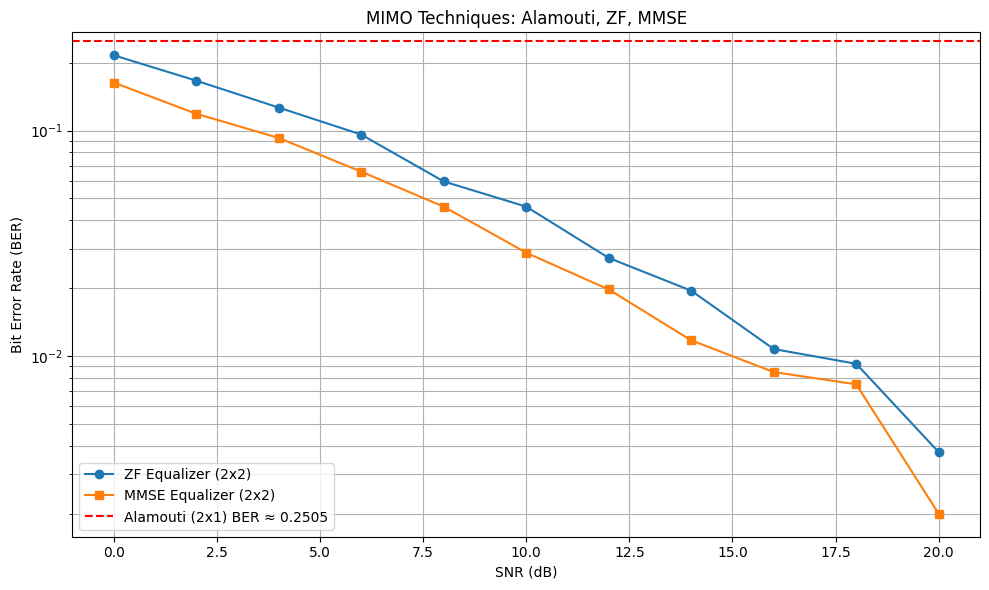

In [127]:
# ---------- Alamouti (2x1) STBC Simulation ----------
def simulate_alamouti(num_symbols=1000, snr_db=10):
    s1 = np.random.choice([-1, 1], num_symbols) + 1j * np.random.choice([-1, 1], num_symbols)
    s2 = np.random.choice([-1, 1], num_symbols) + 1j * np.random.choice([-1, 1], num_symbols)

    x1 = s1
    x2 = s2
    X = np.vstack([x1, -np.conj(x2), x2, np.conj(x1)]).T.reshape(-1, 2)

    h1 = (np.random.randn(num_symbols) + 1j * np.random.randn(num_symbols)) / np.sqrt(2)
    h2 = (np.random.randn(num_symbols) + 1j * np.random.randn(num_symbols)) / np.sqrt(2)

    y = []
    noise_std = np.sqrt(1 / (2 * 10**(snr_db/10)))

    for i in range(num_symbols):
        h = np.array([[h1[i]], [h2[i]]])
        xi = X[2*i:2*i+2]
        yi = xi @ h + noise_std * (np.random.randn(2, 1) + 1j * np.random.randn(2, 1))
        y.append(yi.flatten())

    y = np.array(y)
    y1, y2 = y[:, 0], y[:, 1]

    s1_hat = np.conj(h1)*y1 + h2*np.conj(y2)
    s2_hat = np.conj(h2)*y1 - h1*np.conj(y2)
    s1_hat /= np.abs(h1)**2 + np.abs(h2)**2
    s2_hat /= np.abs(h1)**2 + np.abs(h2)**2

    err1 = np.sum(np.sign(s1.real) != np.sign(s1_hat.real)) + np.sum(np.sign(s1.imag) != np.sign(s1_hat.imag))
    err2 = np.sum(np.sign(s2.real) != np.sign(s2_hat.real)) + np.sum(np.sign(s2.imag) != np.sign(s2_hat.imag))

    ber = (err1 + err2) / (2 * num_symbols * 2)
    return ber

# ---------- Spatial Multiplexing with ZF and MMSE ----------
def simulate_mimo_zf_mmse(Nt=2, Nr=2, snr_db_range=range(0, 21, 2), num_trials=1000):
    ber_zf = []
    ber_mmse = []

    for snr_db in snr_db_range:
        errors_zf = 0
        errors_mmse = 0
        total_bits = 0
        noise_var = 1 / (10 ** (snr_db / 10))

        for _ in range(num_trials):
            x = (np.random.choice([-1, 1], Nt) + 1j * np.random.choice([-1, 1], Nt)) / np.sqrt(2)
            H = (np.random.randn(Nr, Nt) + 1j * np.random.randn(Nr, Nt)) / np.sqrt(2)
            noise = np.sqrt(noise_var / 2) * (np.random.randn(Nr) + 1j * np.random.randn(Nr))
            y = H @ x + noise

            H_zf = np.linalg.pinv(H)
            x_hat_zf = H_zf @ y

            HhH = H.conj().T @ H
            W_mmse = np.linalg.inv(HhH + noise_var * np.eye(Nt)) @ H.conj().T
            x_hat_mmse = W_mmse @ y

            errors_zf += np.sum(np.sign(x.real) != np.sign(x_hat_zf.real)) + \
                         np.sum(np.sign(x.imag) != np.sign(x_hat_zf.imag))
            errors_mmse += np.sum(np.sign(x.real) != np.sign(x_hat_mmse.real)) + \
                           np.sum(np.sign(x.imag) != np.sign(x_hat_mmse.imag))
            total_bits += 2 * Nt

        ber_zf.append(errors_zf / total_bits)
        ber_mmse.append(errors_mmse / total_bits)

    return snr_db_range, ber_zf, ber_mmse

# ---------- Run and Plot ----------
ber_alamouti = simulate_alamouti()
snrs, ber_zf, ber_mmse = simulate_mimo_zf_mmse()

plt.figure(figsize=(10, 6))
plt.semilogy(snrs, ber_zf, 'o-', label='ZF Equalizer (2x2)')
plt.semilogy(snrs, ber_mmse, 's-', label='MMSE Equalizer (2x2)')
plt.axhline(ber_alamouti, color='red', linestyle='--', label=f'Alamouti (2x1) BER ≈ {ber_alamouti:.4f}')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which='both')
plt.title('MIMO Techniques: Alamouti, ZF, MMSE')
plt.legend()
plt.tight_layout()
plt.show()


# **Beamforming: Theory and Mathematical Foundation**

**Beamforming** is a signal processing technique used in antenna arrays to direct the transmitted or received signal energy in specific spatial directions. Instead of radiating energy in all directions (omnidirectionally), beamforming enables:

* Increased **signal strength** at desired receivers
* Suppression of **interference** from undesired directions
* Improved **link reliability** and **spectral efficiency**

Beamforming is fundamental in:

* **Massive MIMO**
* **5G NR**
* **mmWave systems**
* **Radar and sonar arrays**

## **Beamforming Architecture**

There are three main types:

| Type        | Description                            | Hardware Requirements       |
| ----------- | -------------------------------------- | --------------------------- |
| **Analog**  | Single RF chain with phase shifters    | Low complexity, low cost    |
| **Digital** | One RF chain per antenna               | High flexibility, high cost |
| **Hybrid**  | Combines analog + digital (used in 5G) | Balanced performance/cost   |



## **Mathematical Model (Transmit Beamforming)**

Assume:

* $N_t$: Number of transmit antennas
* $\mathbf{h} \in \mathbb{C}^{N_t \times 1}$: Channel vector (Tx → Rx)
* $s$: Transmit symbol (scalar)
* $\mathbf{w} \in \mathbb{C}^{N_t \times 1}$: Beamforming weight vector (precoder)
* $\mathbf{x} = \mathbf{w}s$: Transmit signal
* $y$: Received signal
* $n \sim \mathcal{CN}(0, \sigma^2)$: AWGN noise

Then, the received signal is:

$$
y = \mathbf{h}^H \mathbf{w} s + n
$$

* $\mathbf{h}^H \mathbf{w}$: **Effective channel gain**
* The objective: **choose** $\mathbf{w}$ to **maximize SNR**

## **Beamforming Weight Design**

### a) **Maximum Ratio Transmission (MRT)** – for downlink

Choose:

$$
\mathbf{w} = \frac{\mathbf{h}}{\|\mathbf{h}\|}
$$

Then:

$$
y = \|\mathbf{h}\| s + n
$$

* This aligns the beam with the channel direction (matched filter).
* Maximizes received signal power.


### b) **Zero-Forcing Beamforming (ZF)** – for multi-user

Let $\mathbf{H} = [\mathbf{h}_1, \dots, \mathbf{h}_K]^H \in \mathbb{C}^{K \times N_t}$

ZF precoder:

$$
\mathbf{W}_{ZF} = \mathbf{H}^H \left(\mathbf{H} \mathbf{H}^H \right)^{-1}
$$

* Used in **multi-user MIMO** to eliminate inter-user interference.


### c) **Minimum Mean Square Error (MMSE) Beamforming**

Balances between interference cancellation and noise suppression:

$$
\mathbf{W}_{MMSE} = \mathbf{H}^H \left(\mathbf{H} \mathbf{H}^H + \sigma^2 \mathbf{I} \right)^{-1}
$$

* Performs better than ZF in low SNR regimes.


## **Beamforming in 5G NR**

* **CSI-RS (Channel State Information - Reference Signals)** are used for channel estimation.
* **Codebook-based beamforming**: UE feeds back best beam index.
* **Hybrid beamforming** used in mmWave to reduce RF chain count.

## **Receive Beamforming (Combining)**

For uplink (receiver side):

$$
\hat{s} = \mathbf{w}^H \mathbf{y}
$$

Where:

* $\mathbf{y} = \mathbf{h}s + \mathbf{n}$
* $\mathbf{w}$ can be MRT, ZF, or MMSE combiner

## **Array Response Vector**

For a **uniform linear array (ULA)** with spacing $d$, wavelength $\lambda$, angle $\theta$:

$$
\mathbf{a}(\theta) = \left[ 1, e^{j\frac{2\pi d}{\lambda} \sin\theta}, \dots, e^{j\frac{2\pi d}{\lambda}(N_t - 1)\sin\theta} \right]^T
$$

Used in **analog beamforming** and **directional scanning**.

---


| Strategy | Purpose                       | Formula                                                                          |
| -------- | ----------------------------- | -------------------------------------------------------------------------------- |
| **MRT**  | Maximize SNR                  | $\mathbf{w} = \frac{\mathbf{h}}{\|\mathbf{h}\|}$                                 |
| **ZF**   | Null interference             | $\mathbf{W} = \mathbf{H}^H (\mathbf{H} \mathbf{H}^H)^{-1}$                       |
| **MMSE** | Interference + noise tradeoff | $\mathbf{W} = \mathbf{H}^H (\mathbf{H} \mathbf{H}^H + \sigma^2 \mathbf{I})^{-1}$ |

---




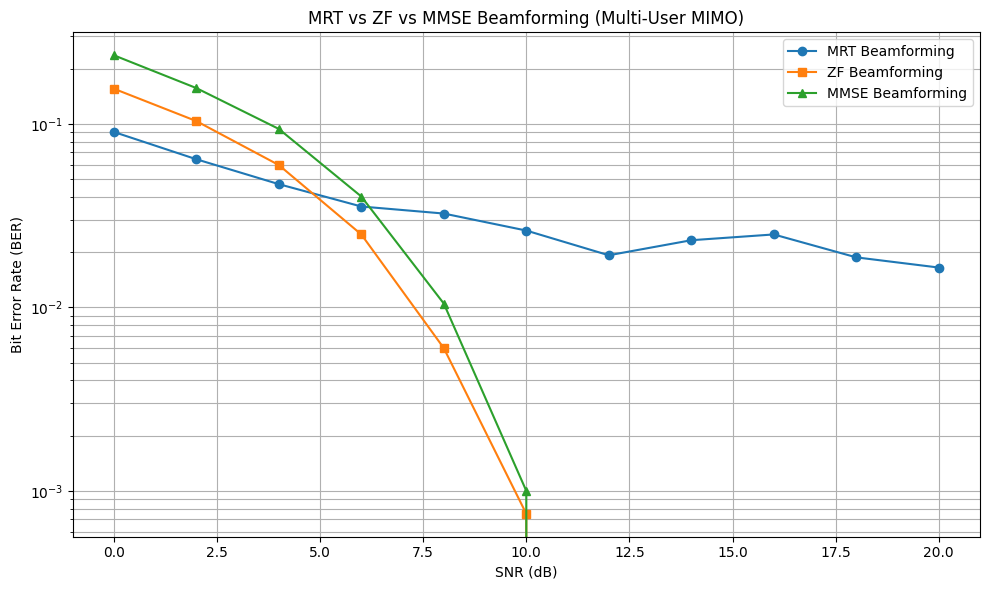

In [129]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_mrt_zf_mmse_beamforming(K=2, Nt=4, snr_db_range=range(0, 21, 2), num_trials=1000):
    """
    Simulate MRT, ZF, and MMSE beamforming in a multi-user MIMO downlink system.

    Parameters:
        K: Number of users (receivers)
        Nt: Number of transmit antennas
        snr_db_range: List or range of SNR values in dB
        num_trials: Monte Carlo trials per SNR point

    Returns:
        snr_db_range: List of SNR values
        ber_mrt: Bit error rate for MRT
        ber_zf: Bit error rate for ZF
        ber_mmse: Bit error rate for MMSE
    """
    ber_mrt = []
    ber_zf = []
    ber_mmse = []

    for snr_db in snr_db_range:
        snr_linear = 10 ** (snr_db / 10)
        noise_var = 1 / snr_linear
        errors_mrt = 0
        errors_zf = 0
        errors_mmse = 0
        total_bits = 0

        for _ in range(num_trials):
            # QPSK symbol vector for each user
            s = (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K)) / np.sqrt(2)

            # Channel matrix (K x Nt)
            H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)

            # MRT beamforming
            W_mrt = H.conj().T
            W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
            x_mrt = W_mrt @ s
            y_mrt = H @ x_mrt + np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
            s_hat_mrt = y_mrt  # No Rx processing

            # ZF beamforming
            W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
            x_zf = W_zf @ s
            y_zf = H @ x_zf + np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
            s_hat_zf = y_zf

            # MMSE beamforming
            W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
            x_mmse = W_mmse @ s
            y_mmse = H @ x_mmse + np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
            s_hat_mmse = y_mmse

            # Decision and error counting
            errors_mrt += np.sum(np.sign(s.real) != np.sign(s_hat_mrt.real)) + \
                          np.sum(np.sign(s.imag) != np.sign(s_hat_mrt.imag))
            errors_zf += np.sum(np.sign(s.real) != np.sign(s_hat_zf.real)) + \
                         np.sum(np.sign(s.imag) != np.sign(s_hat_zf.imag))
            errors_mmse += np.sum(np.sign(s.real) != np.sign(s_hat_mmse.real)) + \
                           np.sum(np.sign(s.imag) != np.sign(s_hat_mmse.imag))

            total_bits += 2 * K

        ber_mrt.append(errors_mrt / total_bits)
        ber_zf.append(errors_zf / total_bits)
        ber_mmse.append(errors_mmse / total_bits)

    return snr_db_range, ber_mrt, ber_zf, ber_mmse


# ---------- Run Simulation ----------
snrs, ber_mrt, ber_zf, ber_mmse = simulate_mrt_zf_mmse_beamforming()

# ---------- Plot ----------
plt.figure(figsize=(10, 6))
plt.semilogy(snrs, ber_mrt, 'o-', label='MRT Beamforming')
plt.semilogy(snrs, ber_zf, 's-', label='ZF Beamforming')
plt.semilogy(snrs, ber_mmse, '^-', label='MMSE Beamforming')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MRT vs ZF vs MMSE Beamforming (Multi-User MIMO)')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


### Spatial Multiplexing vs Beamforming 

In Multiple-Input Multiple-Output (MIMO) systems, multiple antennas are used to exploit the spatial domain for performance enhancement. Two fundamental techniques used to improve throughput or reliability are:

* **Spatial Multiplexing (SM)**: Transmit multiple independent data streams **simultaneously** over the same frequency and time.
* **Beamforming (BF)**: Focus the transmitted energy **directionally** toward the receiver to **increase SNR** and reduce interference.

They serve different goals:

| Technique            | Primary Goal               | Usage Scenario            |
| -------------------- | -------------------------- | ------------------------- |
| Spatial Multiplexing | Increase data rate         | High SNR, rich scattering |
| Beamforming          | Increase reliability (SNR) | Low SNR, or LoS links     |


## **MIMO Channel Model**

The standard baseband narrowband MIMO channel model is:

$$
\mathbf{y} = \mathbf{H} \mathbf{x} + \mathbf{n}
$$

where:

* $\mathbf{y} \in \mathbb{C}^{M_r \times 1}$: received signal
* $\mathbf{H} \in \mathbb{C}^{M_r \times M_t}$: channel matrix
* $\mathbf{x} \in \mathbb{C}^{M_t \times 1}$: transmitted vector
* $\mathbf{n} \sim \mathcal{CN}(0, \sigma^2 \mathbf{I})$: noise


## **Spatial Multiplexing (SM)**

Transmit **multiple independent data streams** from different antennas. These are **separated at the receiver** using linear or nonlinear MIMO detectors (e.g., ZF, MMSE, SIC, ML).

### Signal Model:

Suppose $N_s \le \min(M_t, M_r)$ streams:

$$
\mathbf{x} = \sum_{i=1}^{N_s} \mathbf{e}_i s_i
$$

where:

* $s_i$: $i$-th data stream
* $\mathbf{e}_i$: unit vector activating antenna $i$

### Requirements:

* Rich scattering (uncorrelated channels)
* High SNR (for stream separation)
* Receiver complexity to decode streams

### Capacity (Ideal case):

$$
C_{\text{SM}} = \sum_{i=1}^{N_s} \log_2(1 + \text{SNR}_i)
$$

In i.i.d. Rayleigh fading, capacity scales linearly with $\min(M_t, M_r)$, i.e., **multiplexing gain**.

### Example Use:

* LTE/5G downlink
* WiFi MIMO (802.11n/ac/ax)
* V-BLAST architecture


### **Beamforming (BF)**

Send a **single data stream**, but adjust the antenna weights (phases and amplitudes) so that signals **constructively combine** at the receiver.

### Signal Model:

Let $s$ be the transmitted symbol. Use precoding vector $\mathbf{w} \in \mathbb{C}^{M_t \times 1}$:

$$
\mathbf{x} = \mathbf{w}s, \quad \text{with} \quad \|\mathbf{w}\|^2 = 1
$$

Then the received signal:

$$
\mathbf{y} = \mathbf{H} \mathbf{w}s + \mathbf{n}
$$

Effective channel gain:

$$
\text{SNR} = \frac{|\mathbf{H} \mathbf{w}|^2}{\sigma^2}
$$

Choose $\mathbf{w}$ to **maximize SNR**:

* If full CSI available at Tx:

  $$
  \mathbf{w}_{\text{opt}} = \frac{\mathbf{h}^H}{\|\mathbf{h}\|}
  $$

  (Maximum Ratio Transmission — MRT)
* If multiple receive antennas, use singular value decomposition (SVD):

  $$
  \mathbf{H} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^H \quad \Rightarrow \quad \mathbf{w} = \mathbf{v}_1
  $$

  (Transmit along dominant eigenmode)

### Benefits:

* Increased SNR (array gain)
* Interference suppression (multi-user BF)
* Simpler receiver

### Example Use:

* Millimeter wave (mmWave) 5G links
* Satellite communication
* Massive MIMO downlink in cellular systems

---

## **Comparison Table**

| Feature                | Spatial Multiplexing                | Beamforming                             |
| ---------------------- | ----------------------------------- | --------------------------------------- |
| Goal                   | Maximize data rate (throughput)     | Maximize reliability/SNR (coverage)     |
| Streams                | Multiple                            | Single (or few coordinated streams)     |
| Channel condition      | Requires uncorrelated spatial paths | Works best with LoS or correlated paths |
| Transmit Strategy      | Independent streams                 | Coherent combining using weights        |
| Complexity at receiver | High (multi-stream detection)       | Low (single-stream detection)           |
| SNR dependency         | Needs high SNR                      | Effective even in low SNR               |

---

## **Hybrid Approaches**

Modern systems often combine both:

* Use **beamforming** to create orthogonal spatial directions.
* Then **spatial multiplexing** across those beams (SVD-based MIMO).

Example:

* **SVD MIMO**: Diagonalize the MIMO channel $\mathbf{H}$ via:

  $$
  \mathbf{H} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^H
  $$

  Transmit along right singular vectors ($\mathbf{V}$) and receive via left singular vectors ($\mathbf{U}$), achieving parallel subchannels.




## MIMO + OFDM + Beamforming

1. **Generate OFDM symbols** with QPSK across all subcarriers.
2. **Apply channel $H_k$** and beamforming weights $\mathbf{W}_k$ per subcarrier $k$.
3. **Add AWGN**.
4. **Decode using the same per-subcarrier weights**.
5. **Calculate BER across all subcarriers and OFDM symbols**.


### Assumptions for Simplicity

* OFDM with $N_{\text{sc}}$ subcarriers (e.g. 64)
* Flat fading per subcarrier (i.i.d. channel $H_k \in \mathbb{C}^{K \times N_t}$)
* Same number of users $K$ as before
* One OFDM symbol per simulation run
----

---
### OFDM Symbol Generation for Multi-User MIMO

We generate QPSK symbols for each user across multiple subcarriers.

* Define $K$: number of users (receivers)
* Define $N_t$: number of transmit antennas
* Define $N_{\text{sc}}$: number of subcarriers
* For each user, generate one QPSK symbol per subcarrier





In [130]:
def generate_ofdm_qpsk_symbols(K, N_sc):
    """
    Generate QPSK symbols per subcarrier for K users over N_sc subcarriers.
    
    Output:
        S: K x N_sc matrix of QPSK symbols
    """
    bits = np.random.randint(0, 2, size=(K, N_sc, 2))
    symbols = (2 * bits[..., 0] - 1) + 1j * (2 * bits[..., 1] - 1)
    symbols /= np.sqrt(2)  # Normalize QPSK power
    return symbols



### Channel and Beamforming per Subcarrier**

For each subcarrier $k \in [0, N_{\text{sc}} - 1]$:

1. Generate a random Rayleigh channel matrix $\mathbf{H}_k \in \mathbb{C}^{K \times N_t}$
2. Compute:

   * **MRT beamformer:** $\mathbf{W}_k^{\text{MRT}} = \mathbf{H}_k^H / \|\mathbf{H}_k^H\|$
   * **ZF beamformer:** $\mathbf{W}_k^{\text{ZF}} = \mathbf{H}_k^H(\mathbf{H}_k \mathbf{H}_k^H)^{-1}$
   * **MMSE beamformer:**

     $$
     \mathbf{W}_k^{\text{MMSE}} = \mathbf{H}_k^H \left(\mathbf{H}_k \mathbf{H}_k^H + \sigma^2 \mathbf{I}\right)^{-1}
     $$

---


In [131]:
def generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db):
    """
    Generate MIMO channels and MRT, ZF, MMSE beamforming weights for each subcarrier.

    Returns:
        H_list: List of H_k ∈ ℂ^{K×Nt}
        W_mrt_list, W_zf_list, W_mmse_list: beamforming weights per subcarrier
    """
    H_list = []
    W_mrt_list = []
    W_zf_list = []
    W_mmse_list = []

    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    for _ in range(N_sc):
        H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)
        H_list.append(H)

        # MRT
        W_mrt = H.conj().T
        W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
        W_mrt_list.append(W_mrt)

        # ZF
        W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
        W_zf_list.append(W_zf)

        # MMSE
        W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
        W_mmse_list.append(W_mmse)

    return H_list, W_mrt_list, W_zf_list, W_mmse_list

### Apply Beamforming and Simulate MIMO-OFDM Transmission**

For each subcarrier $k$:

1. Use the QPSK symbol vector $\mathbf{s}_k \in \mathbb{C}^{K}$
2. Multiply by beamforming matrix $\mathbf{W}_k \in \mathbb{C}^{N_t \times K}$ to get transmit signal $\mathbf{x}_k = \mathbf{W}_k \cdot \mathbf{s}_k$
3. Pass through the channel $\mathbf{H}_k \in \mathbb{C}^{K \times N_t}$:
   $\mathbf{y}_k = \mathbf{H}_k \cdot \mathbf{x}_k + \mathbf{n}_k$
4. Collect received signals $\mathbf{y}_k$ for all subcarriers



In [132]:
def transmit_through_channel(S, H_list, W_list, snr_db):
    """
    Apply beamforming, channel, and AWGN noise for each subcarrier.

    Inputs:
        S: QPSK symbols, shape (K, N_sc)
        H_list: list of KxNt channel matrices
        W_list: list of Nt x K beamforming matrices
        snr_db: SNR in dB

    Returns:
        Y: received signal matrix, shape (K, N_sc)
    """
    K, N_sc = S.shape
    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    Y = np.zeros((K, N_sc), dtype=complex)

    for k in range(N_sc):
        H_k = H_list[k]
        W_k = W_list[k]
        s_k = S[:, k]  # (K,)
        x_k = W_k @ s_k  # (Nt,)
        noise = np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
        y_k = H_k @ x_k + noise
        Y[:, k] = y_k

    return Y

### Decision and BER Calculation**

For each subcarrier:

1. Received signal $\mathbf{y}_k \in \mathbb{C}^K$
2. Original symbol $\mathbf{s}_k \in \mathbb{C}^K$
3. Perform hard decision:

   $$
   \hat{b}_k = \text{sign}(\text{Re}(\mathbf{y}_k)), \quad \text{sign}(\text{Im}(\mathbf{y}_k))
   $$
4. Compare with $\mathbf{s}_k$ to compute bit errors
5. Sum over all users and subcarriers to get total BER




In [133]:
def compute_ber(S_tx, Y_rx):
    """
    Compute bit error rate by comparing transmitted and received QPSK symbols.

    Inputs:
        S_tx: Transmitted QPSK symbols, shape (K, N_sc)
        Y_rx: Received QPSK symbols, shape (K, N_sc)

    Returns:
        BER (bit error rate)
    """
    bits_tx_real = np.sign(S_tx.real)
    bits_tx_imag = np.sign(S_tx.imag)
    bits_rx_real = np.sign(Y_rx.real)
    bits_rx_imag = np.sign(Y_rx.imag)

    errors = np.sum(bits_tx_real != bits_rx_real) + np.sum(bits_tx_imag != bits_rx_imag)
    total_bits = 2 * S_tx.size

    return errors / total_bits

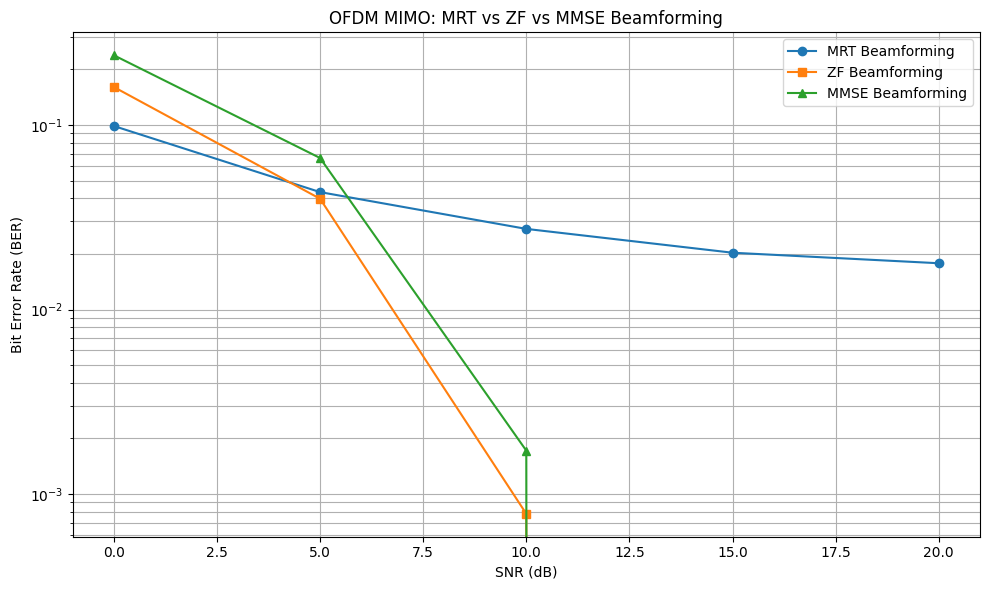

In [134]:
# Generate QPSK symbols for all users and subcarriers
def generate_ofdm_qpsk_symbols(K, N_sc):
    bits = np.random.randint(0, 2, size=(K, N_sc, 2))
    symbols = (2 * bits[..., 0] - 1) + 1j * (2 * bits[..., 1] - 1)
    symbols /= np.sqrt(2)
    return symbols

# Generate Rayleigh MIMO channel and beamformers for each subcarrier
def generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db):
    H_list, W_mrt_list, W_zf_list, W_mmse_list = [], [], [], []
    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    for _ in range(N_sc):
        H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)
        H_list.append(H)

        W_mrt = H.conj().T
        W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
        W_mrt_list.append(W_mrt)

        W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
        W_zf_list.append(W_zf)

        W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
        W_mmse_list.append(W_mmse)

    return H_list, W_mrt_list, W_zf_list, W_mmse_list

# Transmit symbols with beamforming and channel + noise
def transmit_through_channel(S, H_list, W_list, snr_db):
    K, N_sc = S.shape
    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear
    Y = np.zeros((K, N_sc), dtype=complex)

    for k in range(N_sc):
        H_k, W_k, s_k = H_list[k], W_list[k], S[:, k]
        x_k = W_k @ s_k
        noise = np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
        Y[:, k] = H_k @ x_k + noise

    return Y

# Compute BER
def compute_ber(S_tx, Y_rx):
    bits_tx_real = np.sign(S_tx.real)
    bits_tx_imag = np.sign(S_tx.imag)
    bits_rx_real = np.sign(Y_rx.real)
    bits_rx_imag = np.sign(Y_rx.imag)
    errors = np.sum(bits_tx_real != bits_rx_real) + np.sum(bits_tx_imag != bits_rx_imag)
    return errors / (2 * S_tx.size)

# Simulation loop
def simulate_ofdm_beamforming_ber_fast(K=2, Nt=4, N_sc=32, snr_db_range=range(0, 21, 5), num_trials=50):
    ber_mrt, ber_zf, ber_mmse = [], [], []

    for snr_db in snr_db_range:
        errors_mrt = errors_zf = errors_mmse = 0
        total_bits = 0

        for _ in range(num_trials):
            S = generate_ofdm_qpsk_symbols(K, N_sc)
            H_list, W_mrt_list, W_zf_list, W_mmse_list = generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db)

            Y_mrt = transmit_through_channel(S, H_list, W_mrt_list, snr_db)
            Y_zf = transmit_through_channel(S, H_list, W_zf_list, snr_db)
            Y_mmse = transmit_through_channel(S, H_list, W_mmse_list, snr_db)

            errors_mrt += compute_ber(S, Y_mrt) * S.size * 2
            errors_zf += compute_ber(S, Y_zf) * S.size * 2
            errors_mmse += compute_ber(S, Y_mmse) * S.size * 2
            total_bits += S.size * 2

        ber_mrt.append(errors_mrt / total_bits)
        ber_zf.append(errors_zf / total_bits)
        ber_mmse.append(errors_mmse / total_bits)

    return snr_db_range, ber_mrt, ber_zf, ber_mmse

# Run and plot
snrs, ber_mrt, ber_zf, ber_mmse = simulate_ofdm_beamforming_ber_fast()

plt.figure(figsize=(10, 6))
plt.semilogy(snrs, ber_mrt, 'o-', label='MRT Beamforming')
plt.semilogy(snrs, ber_zf, 's-', label='ZF Beamforming')
plt.semilogy(snrs, ber_mmse, '^-', label='MMSE Beamforming')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('OFDM MIMO: MRT vs ZF vs MMSE Beamforming')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


### Add frequency-selective fading (per-subcarrier)

### Model imperfect CSI (channel estimation error)

### Extend to uplink MIMO beamforming (receive-side)

### **Beam Pattern of MIMO Beamforming Vector**


For a **Uniform Linear Array (ULA)** with inter-element spacing $d = \lambda/2$, the **steering vector** for direction $\theta$ is:

$$
\mathbf{a}(\theta) = \begin{bmatrix}
1 \\
e^{-j\pi \sin(\theta)} \\
e^{-j2\pi \sin(\theta)} \\
\vdots \\
e^{-j(N_t-1)\pi \sin(\theta)}
\end{bmatrix}
\in \mathbb{C}^{N_t}
$$

The **beam pattern** (gain in direction $\theta$) is:

$$
G(\theta) = |\mathbf{w}^H \mathbf{a}(\theta)|^2
$$

Where $\mathbf{w} \in \mathbb{C}^{N_t}$ is the beamforming weight vector.



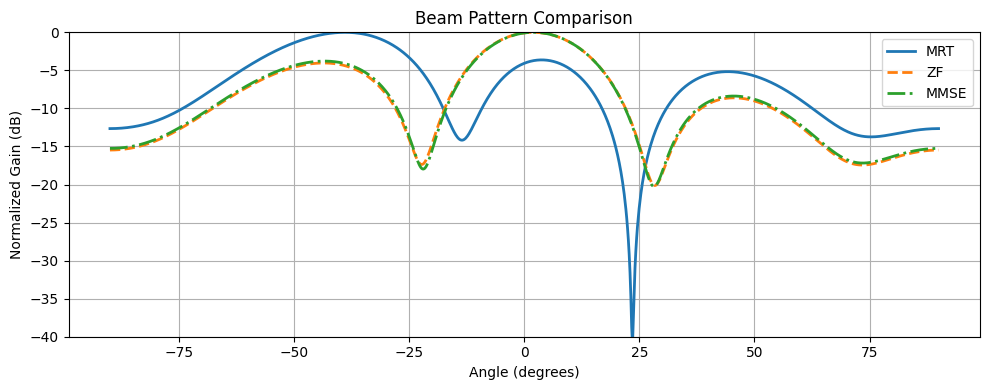

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# === Function: Generate channels and beamformers ===
def generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db):
    H_list, W_mrt_list, W_zf_list, W_mmse_list = [], [], [], []
    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    for _ in range(N_sc):
        H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)
        H_list.append(H)

        W_mrt = H.conj().T
        W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
        W_mrt_list.append(W_mrt)

        W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
        W_zf_list.append(W_zf)

        W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
        W_mmse_list.append(W_mmse)

    return H_list, W_mrt_list, W_zf_list, W_mmse_list

# === Function: Plot MRT vs ZF vs MMSE beam patterns ===
def plot_compare_beam_patterns_with_mmse(w_mrt, w_zf, w_mmse, Nt, title='Beam Pattern Comparison'):
    theta_deg = np.linspace(-90, 90, 1000)
    theta_rad = np.radians(theta_deg)

    def steering_vector(theta):
        return np.exp(-1j * np.pi * np.arange(Nt)[:, None] * np.sin(theta))  # shape: (Nt, len(theta))

    A = steering_vector(theta_rad)
    pattern_mrt = np.abs(w_mrt.conj().T @ A) ** 2
    pattern_zf = np.abs(w_zf.conj().T @ A) ** 2
    pattern_mmse = np.abs(w_mmse.conj().T @ A) ** 2

    pattern_mrt_db = 10 * np.log10(pattern_mrt / np.max(pattern_mrt) + 1e-12)
    pattern_zf_db = 10 * np.log10(pattern_zf / np.max(pattern_zf) + 1e-12)
    pattern_mmse_db = 10 * np.log10(pattern_mmse / np.max(pattern_mmse) + 1e-12)

    plt.figure(figsize=(10, 4))
    plt.plot(theta_deg, pattern_mrt_db, label='MRT', linewidth=2)
    plt.plot(theta_deg, pattern_zf_db, label='ZF', linestyle='--', linewidth=2)
    plt.plot(theta_deg, pattern_mmse_db, label='MMSE', linestyle='-.', linewidth=2)
    plt.title(title)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Normalized Gain (dB)")
    plt.grid(True)
    plt.ylim([-40, 0])
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Execution: Generate one channel and plot beam patterns ===
K = 2       # Number of users
Nt = 4      # Number of transmit antennas
N_sc = 1    # One subcarrier
snr_db = 10 # SNR

_, W_mrt_list, W_zf_list, W_mmse_list = generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db)

# Get beamforming vectors for User 0
w_mrt = W_mrt_list[0][:, 0]
w_zf = W_zf_list[0][:, 0]
w_mmse = W_mmse_list[0][:, 0]

# Plot beam pattern comparison
plot_compare_beam_patterns_with_mmse(w_mrt, w_zf, w_mmse, Nt)


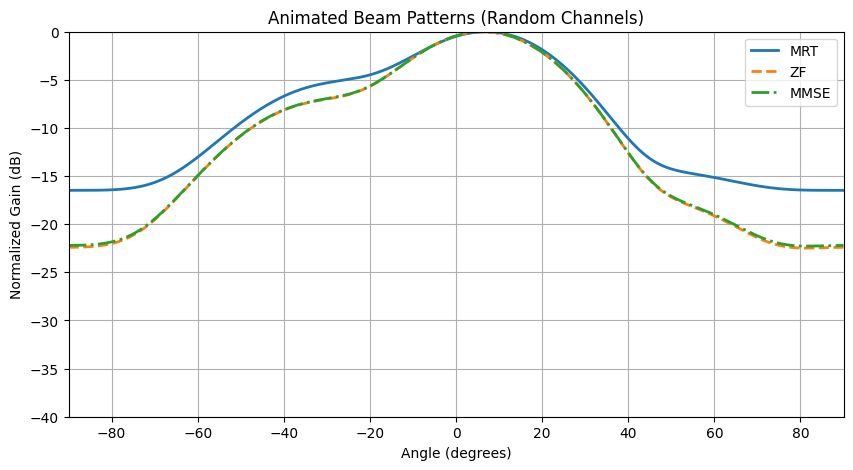

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# === Beamforming weight generation function ===
def generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db):
    H_list, W_mrt_list, W_zf_list, W_mmse_list = [], [], [], []
    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    for _ in range(N_sc):
        H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)
        H_list.append(H)

        W_mrt = H.conj().T
        W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
        W_mrt_list.append(W_mrt)

        W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
        W_zf_list.append(W_zf)

        W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
        W_mmse_list.append(W_mmse)

    return H_list, W_mrt_list, W_zf_list, W_mmse_list

# === Beam pattern animation function ===
def animate_beam_patterns(K=2, Nt=4, N_sc=1, snr_db=10, frames=50):
    theta_deg = np.linspace(-90, 90, 1000)
    theta_rad = np.radians(theta_deg)

    def steering_vector(theta):
        return np.exp(-1j * np.pi * np.arange(Nt)[:, None] * np.sin(theta))  # shape: (Nt, len(theta))

    A = steering_vector(theta_rad)

    fig, ax = plt.subplots(figsize=(10, 5))
    line_mrt, = ax.plot([], [], label='MRT', linewidth=2)
    line_zf, = ax.plot([], [], label='ZF', linestyle='--', linewidth=2)
    line_mmse, = ax.plot([], [], label='MMSE', linestyle='-.', linewidth=2)

    ax.set_xlim(-90, 90)
    ax.set_ylim(-40, 0)
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Normalized Gain (dB)")
    ax.set_title("Animated Beam Patterns (Random Channels)")
    ax.grid(True)
    ax.legend()

    def init():
        line_mrt.set_data([], [])
        line_zf.set_data([], [])
        line_mmse.set_data([], [])
        return line_mrt, line_zf, line_mmse

    def update(frame):
        _, W_mrt_list, W_zf_list, W_mmse_list = generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db)
        w_mrt = W_mrt_list[0][:, 0]
        w_zf = W_zf_list[0][:, 0]
        w_mmse = W_mmse_list[0][:, 0]

        pattern_mrt = np.abs(w_mrt.conj().T @ A) ** 2
        pattern_zf = np.abs(w_zf.conj().T @ A) ** 2
        pattern_mmse = np.abs(w_mmse.conj().T @ A) ** 2

        pattern_mrt_db = 10 * np.log10(pattern_mrt / np.max(pattern_mrt) + 1e-12)
        pattern_zf_db = 10 * np.log10(pattern_zf / np.max(pattern_zf) + 1e-12)
        pattern_mmse_db = 10 * np.log10(pattern_mmse / np.max(pattern_mmse) + 1e-12)

        line_mrt.set_data(theta_deg, pattern_mrt_db)
        line_zf.set_data(theta_deg, pattern_zf_db)
        line_mmse.set_data(theta_deg, pattern_mmse_db)
        return line_mrt, line_zf, line_mmse

    anim = FuncAnimation(fig, update, init_func=init, frames=frames, interval=300, blit=True)
    return anim

# === Run the animation and display ===
beam_anim = animate_beam_patterns(K=2, Nt=4, snr_db=10, frames=40)
HTML(beam_anim.to_jshtml())  # Use this line in Jupyter to view



# Massive MIMO and Hybrid Beamforming

**Massive MIMO (Multiple-Input Multiple-Output)** is a key technology in modern wireless communication systems (5G and beyond), where base stations are equipped with a large number of antennas (typically tens to hundreds) to simultaneously serve many users.

* Base station with $M \gg 1$ antennas (e.g., $M = 64, 128, 256$)
* Serves $K$ users ($K \ll M$), e.g., $K = 8$
* Operates in **TDD (Time Division Duplexing)** to leverage **channel reciprocity**
* Improves:

  * Spectral efficiency
  * Energy efficiency
  * Interference suppression
  * Beamforming and spatial multiplexing gains

## System Model

Let:

* $M$: Number of BS antennas
* $K$: Number of users (single antenna)
* $\mathbf{H} \in \mathbb{C}^{K \times M}$: Channel matrix
* $\mathbf{x} \in \mathbb{C}^{M \times 1}$: Transmitted signal vector
* $\mathbf{y} \in \mathbb{C}^{K \times 1}$: Received signal vector
* $\mathbf{n} \sim \mathcal{CN}(0, \sigma^2 \mathbf{I})$: AWGN noise

The uplink/downlink channel is modeled as:

$$
\mathbf{y} = \mathbf{H} \mathbf{x} + \mathbf{n}
$$

## Beamforming in Massive MIMO

Beamforming enables the BS to direct signal energy toward intended users while suppressing interference.

### Linear Precoding Techniques

* **Maximum Ratio Transmission (MRT):**

  $$
  \mathbf{W}_{\text{MRT}} = \mathbf{H}^H
  $$
* **Zero-Forcing (ZF):**

  $$
  \mathbf{W}_{\text{ZF}} = \mathbf{H}^H (\mathbf{H} \mathbf{H}^H)^{-1}
  $$
* **MMSE Beamforming:**

  $$
  \mathbf{W}_{\text{MMSE}} = \mathbf{H}^H (\mathbf{H} \mathbf{H}^H + \sigma^2 \mathbf{I})^{-1}
  $$

These are digital baseband precoders that assume a fully digital architecture.

## Motivation for Hybrid Beamforming

In **millimeter-wave (mmWave)** or **THz** systems:

* Fully digital beamforming requires a dedicated **RF chain per antenna**.
* Hardware cost, power consumption, and complexity become prohibitive with large $M$.

### Solution: **Hybrid Beamforming**

* Combines **analog** and **digital** processing.
* Reduces the number of RF chains while preserving beamforming flexibility.

## Hybrid Beamforming Architecture

Let:

* $N_{\text{RF}}$: Number of RF chains ($N_{\text{RF}} \ll M$)
* $\mathbf{F}_{\text{RF}} \in \mathbb{C}^{M \times N_{\text{RF}}}$: Analog beamformer (phase shifters only)
* $\mathbf{F}_{\text{BB}} \in \mathbb{C}^{N_{\text{RF}} \times K}$: Digital baseband beamformer

Then:

$$
\mathbf{x} = \mathbf{F}_{\text{RF}} \mathbf{F}_{\text{BB}} \mathbf{s}
$$

Where $\mathbf{s} \in \mathbb{C}^{K \times 1}$ is the transmitted symbol vector.

Subject to:

* $\| \mathbf{F}_{\text{RF}} \mathbf{F}_{\text{BB}} \|_F^2 \leq P$
* $\mathbf{F}_{\text{RF}}$ uses phase-only elements: $|[\mathbf{F}_{\text{RF}}]_{m,n}| = 1$

## Hybrid Beamforming Design

1. **Spatially Sparse Precoding:**

   * Uses sparse approximation algorithms to select beam directions.
   * Exploits the sparsity of mmWave channels.

2. **Alternating Optimization:**

   * Iteratively optimize $\mathbf{F}_{\text{RF}}$ and $\mathbf{F}_{\text{BB}}$

3. **Codebook-Based:**

   * Analog beamformers are selected from a predefined set (e.g., DFT beams)

### Channel Model for mmWave

Sparse multipath channel:

$$
\mathbf{H} = \sqrt{\frac{M N}{L}} \sum_{\ell=1}^{L} \alpha_\ell \mathbf{a}_r(\theta_\ell^r) \mathbf{a}_t^H(\theta_\ell^t)
$$

Where:

* $\alpha_\ell$: path gain
* $\theta^r, \theta^t$: angles of arrival/departure
* $\mathbf{a}_t, \mathbf{a}_r$: antenna array response vectors

## 7. Advantages of Hybrid Beamforming

| Feature               | Benefit                                    |
| --------------------- | ------------------------------------------ |
| Reduced RF chains     | Lower power and hardware cost              |
| High beamforming gain | Enabled by large antenna arrays            |
| Spatial multiplexing  | Serve multiple users simultaneously        |
| Compatibility         | Especially suited for mmWave and THz bands |

---

* **Massive MIMO** leverages large antenna arrays to boost throughput, coverage, and reliability.
* **Fully digital beamforming** is ideal but expensive at high frequencies.
* **Hybrid beamforming** enables cost-effective and power-efficient deployment of massive MIMO in practical systems, especially at mmWave bands.

--- 

### Implementation Scenario: Hybrid Precoding (Narrowband, Single-Carrier)

* **Transmitter:**

  * $M = 8$ antennas
  * $N_{\text{RF}} = 2$ RF chains
  * Codebook-based analog precoding (DFT beams)
* **Receiver:**

  * $N = 4$ antennas
  * Fully digital receiver (for simplicity)
* **Goal:**
  Select analog + digital precoders that maximize spectral efficiency using **channel knowledge**.

---

* **Analog Beamforming (F\_RF):** Selected from a **DFT codebook** by trying all possible RF chain combinations.
* **Digital Precoding (F\_BB):** Computed via **SVD** on the effective channel $H_{\text{eff}} = H F_{\text{RF}}$
* **Spectral Efficiency:**

  $$
  R = \log_2 \det\left( \mathbf{I} + \rho \mathbf{H}_{\text{eq}} \mathbf{H}_{\text{eq}}^H \right)
  $$
* **Power Normalization:** Ensures total transmit power is fixed.






In [166]:
from numpy.linalg import svd, norm

# Parameters
M = 8          # Transmit antennas
N = 4          # Receive antennas
N_RF = 2       # Number of RF chains
K = 2          # Number of data streams
L = 3          # Number of channel paths
SNR_dB = 10    # SNR in dB

# Generate mmWave channel (sparse geometric model)
def generate_mmwave_channel(M, N, L):
    H = np.zeros((N, M), dtype=complex)
    for _ in range(L):
        alpha = (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2)
        theta_t = np.random.uniform(0, 2*np.pi)
        theta_r = np.random.uniform(0, 2*np.pi)

        a_t = np.exp(1j * np.pi * np.arange(M) * np.sin(theta_t)) / np.sqrt(M)
        a_r = np.exp(1j * np.pi * np.arange(N) * np.sin(theta_r)) / np.sqrt(N)

        H += alpha * np.outer(a_r, a_t.conj())
    return H

H = generate_mmwave_channel(M, N, L)

# Analog beamforming codebook (DFT codebook)
def dft_codebook(N_ant):
    return np.exp(1j * 2 * np.pi * np.outer(np.arange(N_ant), np.arange(N_ant)) / N_ant) / np.sqrt(N_ant)

codebook = dft_codebook(M)

# Exhaustive search for best N_RF beam combinations
from itertools import combinations

def select_analog_beams(H, codebook, N_RF):
    best_beams = None
    best_rate = -np.inf

    for idx in combinations(range(codebook.shape[1]), N_RF):
        F_RF = codebook[:, idx]  # Select columns
        H_eff = H @ F_RF

        # SVD to get digital precoder
        U, S, Vh = svd(H_eff)
        F_BB = Vh.conj().T[:, :K]

        # Normalize total power
        F = F_RF @ F_BB
        F /= norm(F, 'fro')

        # Spectral efficiency approximation
        Heq = H @ F
        snr_linear = 10**(SNR_dB / 10)
        rate = np.log2(np.linalg.det(np.eye(N) + snr_linear * Heq @ Heq.conj().T)).real

        if rate > best_rate:
            best_rate = rate
            best_beams = idx

    return codebook[:, list(best_beams)], best_rate

F_RF, best_rate = select_analog_beams(H, codebook, N_RF)

# Final baseband precoder
H_eff = H @ F_RF
U, S, Vh = svd(H_eff)
F_BB = Vh.conj().T[:, :K]

# Normalize hybrid precoder
F = F_RF @ F_BB
F /= norm(F, 'fro')

# Final spectral efficiency
Heq = H @ F
snr_linear = 10**(SNR_dB / 10)
rate = np.log2(np.linalg.det(np.eye(N) + snr_linear * Heq @ Heq.conj().T)).real

print(f"Best hybrid precoding rate: {rate:.2f} bps/Hz")


Best hybrid precoding rate: 5.78 bps/Hz


### Future Steps

* Extend this to **wideband OFDM hybrid precoding**
* Include **quantized phase shifters**
* Compare with **fully digital precoding**
* Use **OMP-based spatially sparse precoding**

# Channel Estimation in OFDM Systems

Channel estimation is essential for coherent detection in wireless systems. In **MIMO-OFDM**, the channel varies over time and frequency, and must be estimated using known **pilot symbols** inserted into the time-frequency grid.


## Pilot Insertion Strategies

Let:

* $N$: number of subcarriers
* $L$: number of OFDM symbols
* $H[k, \ell]$: channel frequency response at subcarrier $k$, OFDM symbol $\ell$

### a. **Block-type Pilot Insertion**

* Pilots are inserted on **all subcarriers** in a specific OFDM symbol.
* Best for **slow-fading channels**.

**Pilot Matrix:**

$$
X_{\text{pilot}}[k, \ell] = 
\begin{cases}
P_k & \text{if } \ell = \ell_p \ (\text{pilot symbol}) \\
\text{data} & \text{otherwise}
\end{cases}
$$

### b. **Comb-type Pilot Insertion**

* Pilots are inserted at **regularly spaced subcarriers** in every OFDM symbol.
* Used in **fast fading** scenarios for tracking over time.

**Pilot Matrix:**

$$
X_{\text{pilot}}[k, \ell] =
\begin{cases}
P_k & \text{if } k \in \mathcal{P} \ (\text{pilot subcarriers}) \\
\text{data} & \text{otherwise}
\end{cases}
$$

## Channel Estimation Algorithms

Let:

* $Y[k]$: received subcarrier value
* $X[k]$: transmitted pilot symbol
* $H[k]$: channel frequency response
* $W[k]$: additive noise

$$
Y[k] = H[k] \cdot X[k] + W[k]
$$

### a. **Least Squares (LS) Estimation**

LS estimates $H[k]$ by minimizing:

$$
\min_{\hat{H}[k]} |Y[k] - \hat{H}[k] \cdot X[k]|^2
$$

The solution:

$$
\hat{H}_{\text{LS}}[k] = \frac{Y[k]}{X[k]}
$$

**Pros:**

* Very simple
* No knowledge of channel statistics needed

**Cons:**

* Sensitive to noise

### b. **Minimum Mean Squared Error (MMSE) Estimation**

MMSE minimizes the mean square error and uses prior statistics (e.g., channel correlation and noise variance):

$$
\hat{H}_{\text{MMSE}}[k] = R_{HH} \cdot \left( R_{HH} + \frac{\sigma_w^2}{|X[k]|^2} I \right)^{-1} \cdot \hat{H}_{\text{LS}}[k]
$$

Where:

* $R_{HH}$: channel autocorrelation matrix
* $\sigma_w^2$: noise variance

**Pros:**

* Better performance than LS in low SNR
* Incorporates channel statistics

**Cons:**

* Requires knowledge of correlation matrices
* Computationally expensive (matrix inversion)

## Interpolation over Subcarriers & Time

After estimating the channel at pilot locations $\mathcal{P}$, we interpolate to get the full channel estimate:

$$
\hat{H}[k, \ell] = \text{Interpolate} \left( \hat{H}[k \in \mathcal{P}, \ell_p] \right)
$$

Interpolation techniques:

* **Linear**
* **Spline**
* **2D Wiener filter** (for MMSE in both time & frequency)

## Extension to MIMO-OFDM

For each **Tx-Rx antenna pair** $(t, r)$, a separate channel $H_{r,t}[k]$ is estimated:

$$
Y_r[k] = \sum_{t=1}^{N_t} H_{r,t}[k] \cdot X_t[k] + W_r[k]
$$

Pilots must be **orthogonal** across different transmit antennas to allow separation of $H_{r,t}$. This is typically done via:

* **Time-multiplexed** pilots (different antennas transmit in different symbols)
* **Frequency-multiplexed** pilots (different subcarriers per antenna)




---

### **Least Squares (LS) channel estimation** using both **block-type** and **comb-type** pilots in OFDM.


## LS Channel Estimation (Block-type and Comb-type Pilots)

### 1. System Model

Assume an OFDM system where the received symbol at subcarrier $k$ and symbol index $\ell$ is:

$$
Y[k, \ell] = H[k, \ell] \cdot X[k, \ell] + W[k, \ell]
$$

* $Y[k, \ell]$: received symbol
* $X[k, \ell]$: known transmitted symbol (pilot)
* $H[k, \ell]$: channel frequency response
* $W[k, \ell]$: noise

If $X[k, \ell]$ is a pilot, LS channel estimation is:

$$
\hat{H}_{\text{LS}}[k, \ell] = \frac{Y[k, \ell]}{X[k, \ell]}
$$

### 2. Python Implementation


In [139]:
def ls_channel_estimation_block(Y, X, pilot_symbol_idx):
    """
    LS channel estimation for block-type pilot.

    Parameters:
    - Y: Received OFDM frame (N_subcarriers x N_symbols)
    - X: Transmitted OFDM frame (N_subcarriers x N_symbols)
    - pilot_symbol_idx: Index of symbol where pilots are inserted

    Returns:
    - H_est: Estimated channel over all subcarriers (1D array)
    """
    Y_pilot = Y[:, pilot_symbol_idx]
    X_pilot = X[:, pilot_symbol_idx]
    H_est = Y_pilot / X_pilot
    return H_est


def ls_channel_estimation_comb(Y, X, pilot_indices):
    """
    LS channel estimation for comb-type pilot.

    Parameters:
    - Y: Received OFDM frame (N_subcarriers x N_symbols)
    - X: Transmitted OFDM frame (N_subcarriers x N_symbols)
    - pilot_indices: List of subcarrier indices containing pilots

    Returns:
    - H_pilot: Channel estimates on pilot subcarriers (1D array)
    - H_interp: Interpolated full channel estimate (1D array)
    """
    Y_pilot = Y[pilot_indices, 0]
    X_pilot = X[pilot_indices, 0]
    H_pilot = Y_pilot / X_pilot

    # Linear interpolation across subcarriers
    all_indices = np.arange(Y.shape[0])
    H_interp = np.interp(all_indices, pilot_indices, H_pilot)
    return H_pilot, H_interp

In [141]:
# Simulate pilot setup
N = 64
pilot_symbol_idx = 0
pilot_subcarriers = np.arange(0, N, 4)

# Transmit known pilots
X = np.zeros((N, 1), dtype=complex)
X[pilot_subcarriers, 0] = np.random.choice([1, -1], size=len(pilot_subcarriers))  # BPSK pilots

# Simulate channel
H_true = np.exp(1j * 2 * np.pi * np.random.rand(N))
Y = np.zeros((N, 1), dtype=complex)
Y[:, 0] = H_true * X[:, 0] + 0.01 * (np.random.randn(N) + 1j * np.random.randn(N))  # add noise

# LS estimation (comb-type)
H_pilot, H_interp = ls_channel_estimation_comb(Y, X, pilot_subcarriers)

"""
2D interpolation over time/frequency

MIMO pilot separation (multi-antenna)

Extend to MMSE estimation
"""

'\n2D interpolation over time/frequency\n\nMIMO pilot separation (multi-antenna)\n\nExtend to MMSE estimation\n'

### **MMSE channel estimation** for OFDM systems assuming known channel and noise statistics.

### System Model (Single Subcarrier)

Let the received signal at a pilot subcarrier be:

$$
Y[k] = H[k] \cdot X[k] + W[k]
$$

where:

* $H[k] \sim \mathcal{CN}(0, \sigma_H^2)$: channel coefficient with known variance
* $W[k] \sim \mathcal{CN}(0, \sigma_W^2)$: AWGN

### 1. Least Squares Estimate

The LS estimate is:

$$
\hat{H}_{\text{LS}}[k] = \frac{Y[k]}{X[k]}
$$

This is noisy, especially when $\sigma_W^2$ is large.


### 2. MMSE Estimation Formula

The MMSE estimator uses prior knowledge of noise and channel statistics:

$$
\hat{H}_{\text{MMSE}}[k] = \frac{\sigma_H^2}{\sigma_H^2 + \frac{\sigma_W^2}{|X[k]|^2}} \cdot \hat{H}_{\text{LS}}[k]
$$

This can be interpreted as a **soft-weighted version** of the LS estimate, suppressing high-noise contributions.


### 3. MMSE in Vector Form (Multiple Pilots)

Let:

* $\mathbf{Y}_p \in \mathbb{C}^{P \times 1}$: received pilot symbols
* $\mathbf{X}_p \in \mathbb{C}^{P \times P}$: diagonal matrix of pilot symbols
* $\mathbf{H}_p \in \mathbb{C}^{P \times 1}$: channel at pilot positions
* $\mathbf{R}_{HH}$: channel autocorrelation
* $\sigma_W^2$: noise variance

Then:

$$
\hat{\mathbf{H}}_{\text{MMSE}} = \mathbf{R}_{HH} \cdot \left( \mathbf{X}_p^\dagger \mathbf{X}_p \cdot \mathbf{R}_{HH} + \sigma_W^2 \cdot \mathbf{I} \right)^{-1} \cdot \mathbf{X}_p^\dagger \cdot \mathbf{Y}_p
$$



In [142]:
def mmse_channel_estimation(Y, X, pilot_indices, sigma_h2, sigma_w2, N):
    """
    MMSE channel estimation using pilot symbols and known variances.

    Parameters:
    - Y: Received OFDM vector (N,)
    - X: Transmitted OFDM vector (N,)
    - pilot_indices: List/array of pilot subcarrier indices
    - sigma_h2: Channel variance
    - sigma_w2: Noise variance
    - N: Total number of subcarriers

    Returns:
    - H_mmse_full: MMSE channel estimate over all subcarriers (interpolated)
    """
    P = len(pilot_indices)
    Y_pilot = Y[pilot_indices]
    X_pilot = X[pilot_indices]
    H_ls = Y_pilot / X_pilot

    # Assume identity autocorrelation matrix for simplicity
    R_hh = sigma_h2 * np.eye(P)
    X_diag = np.diag(X_pilot)
    inv_term = np.linalg.inv(X_diag.conj().T @ X_diag * sigma_h2 + sigma_w2 * np.eye(P))

    H_mmse_pilots = sigma_h2 * inv_term @ X_diag.conj().T @ Y_pilot

    # Interpolate over all subcarriers (1D linear)
    H_mmse_full = np.interp(np.arange(N), pilot_indices, H_mmse_pilots.real) + \
                  1j * np.interp(np.arange(N), pilot_indices, H_mmse_pilots.imag)

    return H_mmse_full

In [143]:
N = 64
pilot_indices = np.arange(0, N, 4)
X = np.zeros(N, dtype=complex)
X[pilot_indices] = np.random.choice([1, -1], size=len(pilot_indices))  # BPSK pilots
H_true = np.exp(1j * 2 * np.pi * np.random.rand(N))
noise = 0.1 * (np.random.randn(N) + 1j * np.random.randn(N))
Y = H_true * X + noise

# Estimate
sigma_h2 = 1.0
sigma_w2 = 0.01
H_mmse = mmse_channel_estimation(Y, X, pilot_indices, sigma_h2, sigma_w2, N)


## 2D MMSE Channel Estimation in Time-Frequency Grid

In an OFDM system with:

* $N_f$: subcarriers (frequency)
* $N_t$: OFDM symbols (time)
* $H[k, \ell]$: channel frequency response at subcarrier $k$, symbol $\ell$
* $X[k, \ell]$: known pilot symbol (only at pilot positions)
* $Y[k, \ell]$: received symbol at $(k, \ell)$

We want to estimate $H[k, \ell]$ across the **full grid** using a 2D MMSE estimator based on pilot observations.

The MMSE estimate is given by:

$$
\hat{\mathbf{h}} = R_{hh} R_{yy}^{-1} \mathbf{y}
$$

Where:

* $\mathbf{h}$: full channel vectorized as a column vector
* $\mathbf{y}$: pilot observations
* $R_{hh}$: autocorrelation of the full channel
* $R_{yy} = R_{pp} + \sigma_w^2 I$: autocorrelation of pilot observations

Assuming **separable correlation**:

$$
R_{hh} = R_f \otimes R_t
$$

where:

* $R_f$: frequency correlation matrix
* $R_t$: time correlation matrix
* $\otimes$: Kronecker product

This allows efficient matrix operations.

### Notes: 

* This implementation uses a full covariance matrix, which may be expensive for large grids.
* For larger grids, **low-rank approximation** or **Wiener filtering** in time/frequency separately is preferred.
* Correlation coefficients $\rho_f$, $\rho_t$ can be estimated from measurements or assumed based on delay/Doppler spreads.


In [145]:
def exp_corr_matrix(size, rho):
    """Create exponential correlation matrix."""
    return rho ** np.abs(np.subtract.outer(np.arange(size), np.arange(size)))

def mmse_2d_channel_estimation(Y, X, pilot_mask, sigma_h2=1.0, sigma_w2=0.01, rho_f=0.9, rho_t=0.9):
    """
    Perform 2D MMSE channel estimation using pilot grid.

    Parameters:
    - Y: (N_f x N_t) received signal
    - X: (N_f x N_t) transmitted signal (pilots only)
    - pilot_mask: Boolean mask of same shape indicating pilot positions
    - sigma_h2: Channel power
    - sigma_w2: Noise power
    - rho_f: Frequency correlation coefficient
    - rho_t: Time correlation coefficient

    Returns:
    - H_hat: (N_f x N_t) estimated channel response
    """
    N_f, N_t = Y.shape
    N = N_f * N_t
    y = Y[pilot_mask]
    x = X[pilot_mask]
    h_ls = y / x

    # Pilot indices (flattened index)
    pilot_indices = np.flatnonzero(pilot_mask)

    # Full correlation matrix using separable model
    R_f = exp_corr_matrix(N_f, rho_f)
    R_t = exp_corr_matrix(N_t, rho_t)
    R_hh = np.kron(R_t, R_f) * sigma_h2

    # Submatrices for pilots
    R_hy = R_hh[:, pilot_indices]
    R_yy = R_hh[np.ix_(pilot_indices, pilot_indices)] + sigma_w2 * np.eye(len(pilot_indices))

    # MMSE estimation
    h_hat = R_hy @ np.linalg.solve(R_yy, h_ls)

    return h_hat.reshape(N_f, N_t)

In [146]:
N_f, N_t = 64, 10
pilot_mask = np.zeros((N_f, N_t), dtype=bool)
pilot_mask[::4, ::2] = True  # 2D comb pilot

X = np.zeros((N_f, N_t), dtype=complex)
X[pilot_mask] = np.random.choice([1, -1], size=np.sum(pilot_mask))

H_true = np.exp(1j * 2 * np.pi * np.random.rand(N_f, N_t))
Y = H_true * X + 0.1 * (np.random.randn(N_f, N_t) + 1j * np.random.randn(N_f, N_t))

H_est = mmse_2d_channel_estimation(Y, X, pilot_mask, rho_f=0.9, rho_t=0.7)

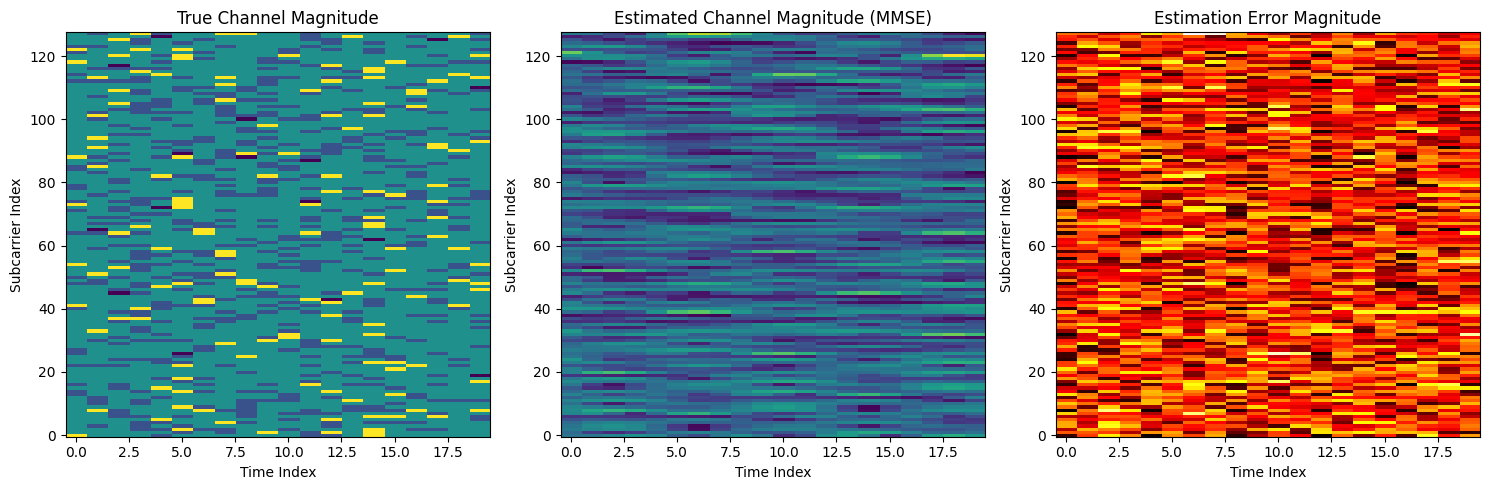

In [147]:
def exp_corr_matrix(size, rho):
    """Generate exponential correlation matrix."""
    return rho ** np.abs(np.subtract.outer(np.arange(size), np.arange(size)))

def mmse_2d_estimation_lowrank(Y, X, pilot_mask, sigma_h2=1.0, sigma_w2=0.01, rho_f=0.9, rho_t=0.9, rank_approx=32):
    """
    Optimized 2D MMSE channel estimation using SVD-based low-rank approximation.
    
    Parameters:
    - Y: Received signal matrix (N_f, N_t)
    - X: Transmitted pilot matrix (N_f, N_t)
    - pilot_mask: Boolean matrix indicating pilot positions (N_f, N_t)
    - sigma_h2: Channel power variance
    - sigma_w2: Noise power variance
    - rho_f: Frequency correlation coefficient
    - rho_t: Time correlation coefficient
    - rank_approx: SVD rank truncation

    Returns:
    - h_hat: Estimated full channel matrix (N_f, N_t)
    """
    N_f, N_t = Y.shape
    y = Y[pilot_mask]
    x = X[pilot_mask]
    h_ls = y / x
    pilot_indices = np.flatnonzero(pilot_mask)

    # Compute correlation matrices and SVD approximations
    R_f = exp_corr_matrix(N_f, rho_f)
    R_t = exp_corr_matrix(N_t, rho_t)
    R_f_u, R_f_s, _ = np.linalg.svd(R_f)
    R_t_u, R_t_s, _ = np.linalg.svd(R_t)

    R_f_approx = R_f_u[:, :rank_approx] @ np.diag(R_f_s[:rank_approx]) @ R_f_u[:, :rank_approx].T
    R_t_approx = R_t_u[:, :rank_approx] @ np.diag(R_t_s[:rank_approx]) @ R_t_u[:, :rank_approx].T

    R_hh = np.kron(R_t_approx, R_f_approx) * sigma_h2
    R_hy = R_hh[:, pilot_indices]
    R_yy = R_hh[np.ix_(pilot_indices, pilot_indices)] + sigma_w2 * np.eye(len(pilot_indices))

    h_hat = R_hy @ np.linalg.solve(R_yy, h_ls)
    return h_hat.reshape(N_f, N_t)

def generate_data_with_pilots(N_f=128, N_t=20, pilot_spacing_f=8, pilot_spacing_t=4):
    """Generate synthetic OFDM data with known pilot positions."""
    H_true = np.exp(1j * 2 * np.pi * np.random.rand(N_f, N_t))
    pilot_mask = np.zeros((N_f, N_t), dtype=bool)
    pilot_mask[::pilot_spacing_f, ::pilot_spacing_t] = True
    X = np.zeros((N_f, N_t), dtype=complex)
    X[pilot_mask] = np.random.choice([1, -1], size=np.sum(pilot_mask))  # BPSK pilots
    noise = 0.1 * (np.random.randn(N_f, N_t) + 1j * np.random.randn(N_f, N_t))
    Y = H_true * X + noise
    return H_true, Y, X, pilot_mask

def visualize_results(H_true, H_est, pilot_mask):
    """Visualize true, estimated channels and error."""
    error = np.abs(H_true - H_est)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.abs(H_true), aspect='auto', origin='lower')
    axs[0].set_title("True Channel Magnitude")

    axs[1].imshow(np.abs(H_est), aspect='auto', origin='lower')
    axs[1].set_title("Estimated Channel Magnitude (MMSE)")

    axs[2].imshow(error, aspect='auto', origin='lower', cmap='hot')
    axs[2].set_title("Estimation Error Magnitude")

    for ax in axs:
        ax.set_xlabel("Time Index")
        ax.set_ylabel("Subcarrier Index")
    plt.tight_layout()
    plt.show()

# Execute full pipeline
H_true, Y, X, pilot_mask = generate_data_with_pilots()
H_est = mmse_2d_estimation_lowrank(Y, X, pilot_mask)
visualize_results(H_true, H_est, pilot_mask)


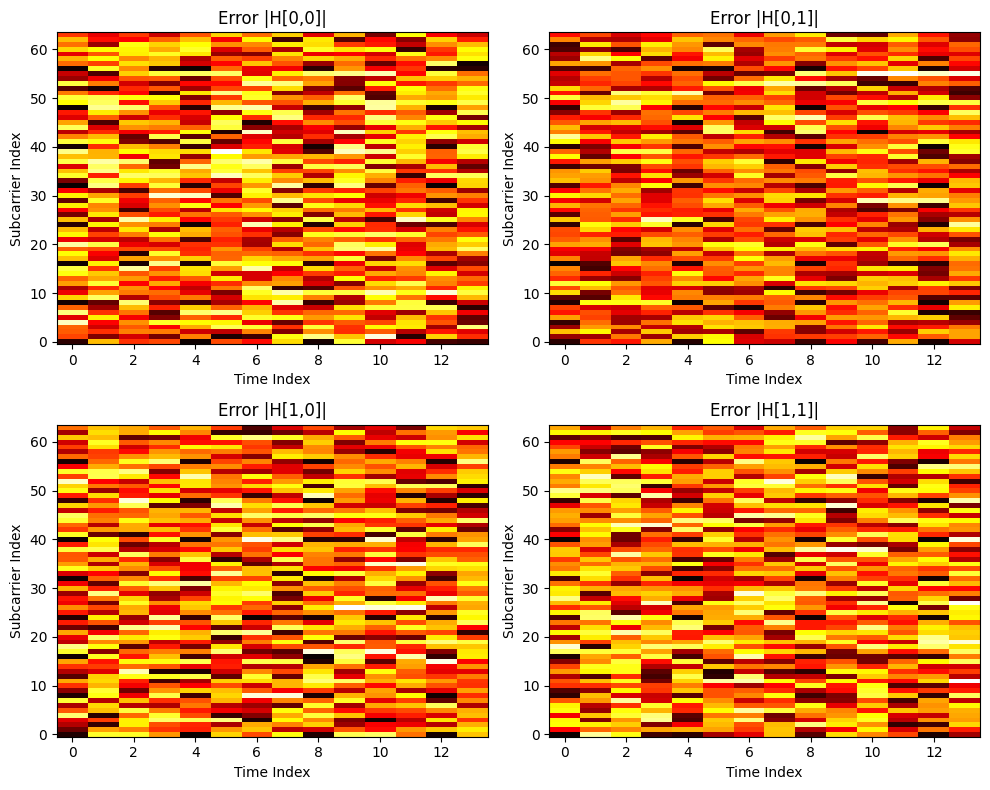

In [148]:
import numpy as np
import matplotlib.pyplot as plt

def exp_corr_matrix(size, rho):
    """Generate exponential correlation matrix."""
    return rho ** np.abs(np.subtract.outer(np.arange(size), np.arange(size)))

def mmse_2d_mimo_estimation(Y, X, pilot_mask, num_rx=2, num_tx=2, sigma_h2=1.0, sigma_w2=0.01, rho_f=0.9, rho_t=0.9, rank_approx=32):
    N_f, N_t = Y.shape[2], Y.shape[3]
    H_est = np.zeros((num_rx, num_tx, N_f, N_t), dtype=complex)

    # Precompute correlation matrices
    R_f = exp_corr_matrix(N_f, rho_f)
    R_t = exp_corr_matrix(N_t, rho_t)
    R_f_u, R_f_s, _ = np.linalg.svd(R_f)
    R_t_u, R_t_s, _ = np.linalg.svd(R_t)
    R_f_approx = R_f_u[:, :rank_approx] @ np.diag(R_f_s[:rank_approx]) @ R_f_u[:, :rank_approx].T
    R_t_approx = R_t_u[:, :rank_approx] @ np.diag(R_t_s[:rank_approx]) @ R_t_u[:, :rank_approx].T
    R_hh = np.kron(R_t_approx, R_f_approx) * sigma_h2

    for rx in range(num_rx):
        for tx in range(num_tx):
            y = Y[rx, tx][pilot_mask]
            x = X[rx, tx][pilot_mask]
            h_ls = y / x
            pilot_indices = np.flatnonzero(pilot_mask)
            R_hy = R_hh[:, pilot_indices]
            R_yy = R_hh[np.ix_(pilot_indices, pilot_indices)] + sigma_w2 * np.eye(len(pilot_indices))
            h_hat = R_hy @ np.linalg.solve(R_yy, h_ls)
            H_est[rx, tx] = h_hat.reshape(N_f, N_t)

    return H_est

def generate_mimo_data_with_pilots(N_f=64, N_t=14, num_rx=2, num_tx=2, pilot_spacing_f=8, pilot_spacing_t=4):
    pilot_mask = np.zeros((N_f, N_t), dtype=bool)
    pilot_mask[::pilot_spacing_f, ::pilot_spacing_t] = True

    X = np.zeros((num_rx, num_tx, N_f, N_t), dtype=complex)
    H_true = np.exp(1j * 2 * np.pi * np.random.rand(num_rx, num_tx, N_f, N_t))
    noise = 0.1 * (np.random.randn(num_rx, num_tx, N_f, N_t) + 1j * np.random.randn(num_rx, num_tx, N_f, N_t))

    for rx in range(num_rx):
        for tx in range(num_tx):
            X[rx, tx][pilot_mask] = np.random.choice([1, -1], size=np.sum(pilot_mask))

    Y = H_true * X + noise
    return H_true, Y, X, pilot_mask

def visualize_all_mimo_channels(H_true, H_est):
    num_rx, num_tx, _, _ = H_true.shape
    fig, axs = plt.subplots(num_rx, num_tx, figsize=(5 * num_tx, 4 * num_rx))

    for rx in range(num_rx):
        for tx in range(num_tx):
            ax = axs[rx, tx] if num_rx > 1 else axs[tx]
            error = np.abs(H_true[rx, tx] - H_est[rx, tx])
            ax.imshow(error, aspect='auto', origin='lower', cmap='hot')
            ax.set_title(f"Error |H[{rx},{tx}]|")
            ax.set_xlabel("Time Index")
            ax.set_ylabel("Subcarrier Index")

    plt.tight_layout()
    plt.show()

# Full MIMO-OFDM channel estimation pipeline
H_true, Y, X, pilot_mask = generate_mimo_data_with_pilots()
H_est = mmse_2d_mimo_estimation(Y, X, pilot_mask)
visualize_all_mimo_channels(H_true, H_est)


In [157]:
def simulate_ber(H_true, H_est, X, pilot_mask, noise_std=0.1):
    num_rx, num_tx, N_f, N_t = H_true.shape
    data_mask = pilot_mask.copy()

    # Transmit random BPSK on pilot positions
    bits = np.random.randint(0, 2, size=(num_tx, N_f, N_t))
    symbols = 2 * bits - 1  # BPSK mapping

    Y_rx = np.zeros((num_rx, N_f, N_t), dtype=complex)
    for rx in range(num_rx):
        for tx in range(num_tx):
            Y_rx[rx] += H_true[rx, tx] * symbols[tx]

    # Add AWGN noise
    noise = noise_std * (np.random.randn(*Y_rx.shape) + 1j * np.random.randn(*Y_rx.shape))
    Y_rx_noisy = Y_rx + noise

    # Equalization and hard decision detection
    bits_rx = np.zeros((num_rx, N_f, N_t), dtype=int)
    for rx in range(num_rx):
        eq_symbol = np.zeros((N_f, N_t), dtype=complex)
        for tx in range(num_tx):
            H_conj = np.conj(H_est[rx, tx])
            H_mag2 = np.abs(H_est[rx, tx])**2 + 1e-10
            eq_symbol += H_conj * Y_rx_noisy[rx] / H_mag2
        bits_rx[rx] = (np.real(eq_symbol) > 0).astype(int)

    tx_bits = bits[0][data_mask]
    rx_bits = bits_rx[0][data_mask]
    ber = np.mean(tx_bits != rx_bits)
    return ber


def run_ber_comparison(snr_db_range, num_trials=10):
    ber_mmse = []
    ber_ls = []

    for snr_db in snr_db_range:
        noise_std = 10 ** (-snr_db / 20)
        mmse_total, ls_total = 0.0, 0.0

        for _ in range(num_trials):
            H_true, Y, X, pilot_mask = generate_mimo_data_with_pilots()
            H_est = mmse_2d_mimo_estimation(Y, X, pilot_mask)
            mmse_total += simulate_ber(H_true, H_est, X, pilot_mask, noise_std=noise_std)
            ls_total += simulate_ber(H_true, Y, X, pilot_mask, noise_std=noise_std)

        ber_mmse.append(mmse_total / num_trials)
        ber_ls.append(ls_total / num_trials)

    return np.array(ber_mmse), np.array(ber_ls)



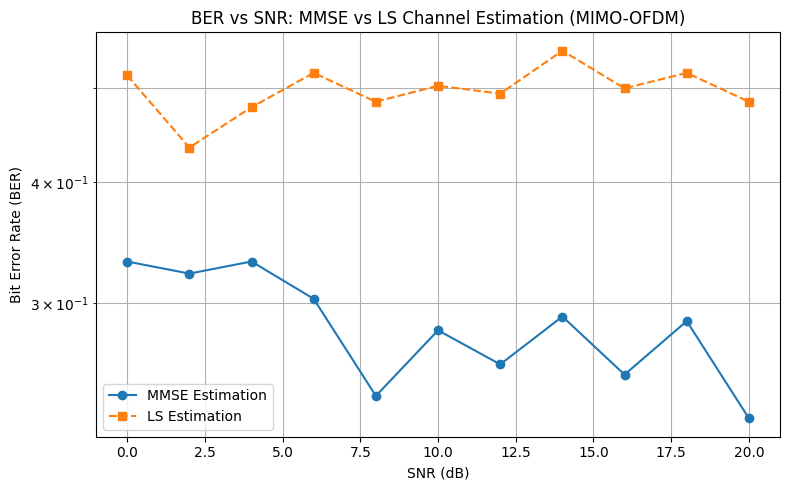

In [158]:
# Use user-provided parameters and run the simulation again
N_f = 64
N_t = 14
num_rx = 2
num_tx = 2
pilot_spacing_f = 8
pilot_spacing_t = 4
snr_db_range = np.arange(0, 21, 2)
num_trials = 10

# Run full simulation and plot
ber_mmse, ber_ls = run_ber_comparison(snr_db_range, num_trials=num_trials)

plt.figure(figsize=(8, 5))
plt.semilogy(snr_db_range, ber_mmse, 'o-', label='MMSE Estimation')
plt.semilogy(snr_db_range, ber_ls, 's--', label='LS Estimation')
plt.grid(True, which='both')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR: MMSE vs LS Channel Estimation (MIMO-OFDM)')
plt.legend()
plt.tight_layout()
plt.show()


---

# Pilot Insertion & Extraction


In wireless communication systems, **pilots** (or training symbols) are known reference signals inserted into the transmitted signal. They serve two primary purposes:

* **Channel Estimation:** To estimate the channel impulse or frequency response at the receiver.
* **Synchronization:** To support frame/packet detection and frequency/time synchronization.

In **MIMO-OFDM** systems, pilot design becomes more complex due to the need to distinguish between multiple transmit antennas and handle time-frequency varying channels.

## Time-Frequency Grid Mapping

OFDM systems divide the time-frequency resource into a grid of subcarriers (frequency) and OFDM symbols (time). Each grid cell can carry:

* Data symbols
* Pilot symbols
* Nulls (guard bands or DC subcarriers)

### Grid Definition

Let:

* $N_f$: Number of subcarriers (frequency bins)
* $N_t$: Number of OFDM symbols in a frame
* $x[n, k]$: Transmitted symbol at time index $n \in \{0, \dots, N_t-1\}$, subcarrier index $k \in \{0, \dots, N_f-1\}$

The resource grid is denoted as:

$$
\mathbf{X} \in \mathbb{C}^{N_t \times N_f}
$$

### Pilot Mask

Define a **pilot mask** $\mathbf{P} \in \{0, 1\}^{N_t \times N_f}$, where:

* $P[n, k] = 1$ indicates a pilot at time $n$, subcarrier $k$
* $P[n, k] = 0$ indicates a data symbol or unused

The pilot insertion is done as:

$$
X[n, k] = 
\begin{cases}
x_p[n, k], & \text{if } P[n, k] = 1 \\
x_d[n, k], & \text{otherwise}
\end{cases}
$$

Where $x_p[n, k]$ is a known pilot symbol (e.g., BPSK), and $x_d[n, k]$ is a data symbol.

---

## Adaptive Pilot Placement for MIMO

In **MIMO-OFDM**, the pilot design must:

* Enable separate channel estimation for each transmit-receive antenna pair
* Adapt to the **channel time-frequency selectivity**

Let:

* $N_t^{\text{tx}}$: Number of transmit antennas
* $N_t^{\text{rx}}$: Number of receive antennas

### 3.1 Orthogonal Pilots Across Antennas

To separate pilots from each transmit antenna, define orthogonal pilot patterns:

$$
\mathbf{P}^{(i)} \quad \text{for } i = 1, \dots, N_t^{\text{tx}}
$$

Such that:

$$
\mathbf{P}^{(i)} \cdot \mathbf{P}^{(j)} = 0 \quad \text{for } i \ne j
$$

This prevents pilot contamination between antennas.

### Pilot Density Adaptation

Pilot density can be adapted based on:

* **Doppler Spread** $f_D$: faster fading → more pilots in time
* **Delay Spread** $\tau_{\max}$: frequency-selectivity → more pilots in frequency

Define coherence parameters:

* **Coherence Time**: $T_c \approx \frac{1}{f_D}$
* **Coherence Bandwidth**: $B_c \approx \frac{1}{\tau_{\max}}$

Pilot spacing:

* Time spacing: $\Delta_t \le T_c / T_s$
* Frequency spacing: $\Delta_f \le B_c / \Delta f$

Where:

* $T_s$: OFDM symbol duration
* $\Delta f$: Subcarrier spacing

Thus, pilot grid intervals should satisfy:

$$
\Delta_t \cdot T_s \le T_c, \quad \Delta_f \cdot \Delta f \le B_c
$$


## Pilot Extraction and Channel Estimation

At the receiver, extract the pilot locations using the same mask $\mathbf{P}$, and perform **channel estimation**.

### 4.1 LS Estimation at Pilot Positions

Received pilot symbol:

$$
Y[n, k] = H[n, k] \cdot X[n, k] + W[n, k]
$$

At pilot locations, since $X[n, k]$ is known:

$$
\hat{H}_{\text{LS}}[n, k] = \frac{Y[n, k]}{X[n, k]}, \quad \text{for } P[n, k] = 1
$$

### Interpolation

To estimate $H[n, k]$ at data locations:

* Use 2D interpolation (linear, spline, Wiener filtering, etc.)
* Estimate the full channel:

$$
\hat{H}[n, k] = \text{Interp}(\hat{H}_{\text{LS}}[n_p, k_p])
$$

Where $(n_p, k_p)$ are the pilot locations.


---

* Pilots are inserted into a time-frequency grid using a binary mask.
* In MIMO, pilots must be orthogonal across antennas to separate channels.
* Pilot spacing is designed based on coherence time and bandwidth.
* LS estimation followed by interpolation recovers the full channel matrix.
* Adaptive pilot design improves spectral efficiency and estimation accuracy in dynamic environments.



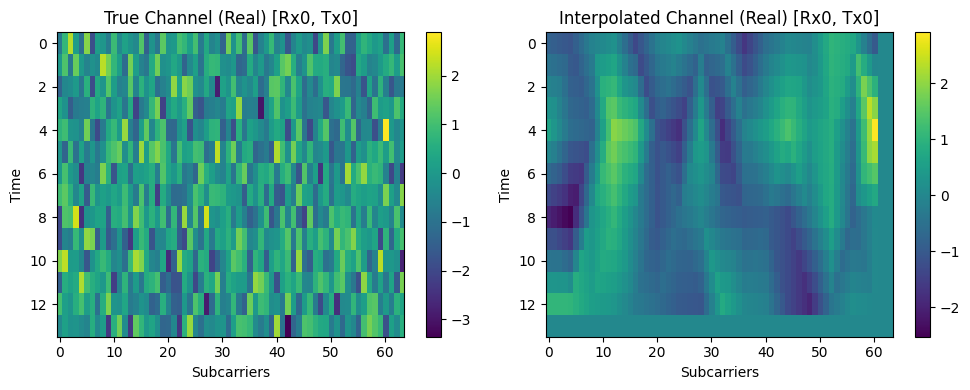

In [161]:
from scipy.interpolate import griddata
# Parameters
N_f = 64           # Number of subcarriers
N_t = 14           # Number of OFDM symbols
n_tx = 2           # Number of TX antennas
n_rx = 2           # Number of RX antennas
pilot_spacing_f = 4
pilot_spacing_t = 4
snr_dB = 20

def create_adaptive_pilot_masks(n_tx, N_t, N_f, delta_t, delta_f):
    masks = []
    for i in range(n_tx):
        mask = np.zeros((N_t, N_f), dtype=bool)
        offset_t = i % delta_t
        offset_f = (i * 2) % delta_f
        mask[offset_t::delta_t, offset_f::delta_f] = True
        masks.append(mask)
    return np.array(masks)

pilot_masks = create_adaptive_pilot_masks(n_tx, N_t, N_f, pilot_spacing_t, pilot_spacing_f)

# Generate pilot symbols (e.g., BPSK: {-1, +1})
def generate_pilot_symbols(pilot_mask):
    symbols = 2 * np.random.randint(0, 2, pilot_mask.shape) - 1
    return symbols * pilot_mask

pilot_symbols = np.array([generate_pilot_symbols(pilot_masks[i]) for i in range(n_tx)])

# Full transmit grid for each TX antenna
tx_grid = np.zeros((n_tx, N_t, N_f), dtype=complex)
for i in range(n_tx):
    tx_grid[i][pilot_masks[i]] = pilot_symbols[i][pilot_masks[i]]

# True channel: random complex channel (time and frequency selective)
H_true = np.random.randn(n_rx, n_tx, N_t, N_f) + 1j * np.random.randn(n_rx, n_tx, N_t, N_f)

# Transmit through channel and add noise
Y = np.zeros((n_rx, N_t, N_f), dtype=complex)
for rx in range(n_rx):
    for tx in range(n_tx):
        Y[rx] += H_true[rx, tx] * tx_grid[tx]

# Add noise
noise_power = np.mean(np.abs(Y)**2) / (10**(snr_dB / 10))
noise = np.sqrt(noise_power / 2) * (np.random.randn(*Y.shape) + 1j * np.random.randn(*Y.shape))
Y_noisy = Y + noise

# LS Channel Estimation at pilot locations
H_ls = np.zeros((n_rx, n_tx, N_t, N_f), dtype=complex)
for rx in range(n_rx):
    for tx in range(n_tx):
        mask = pilot_masks[tx]
        pilots = tx_grid[tx][mask]
        received = Y_noisy[rx][mask]
        H_ls[rx, tx][mask] = received / pilots

# Interpolation to estimate full channel
def interpolate_channel(H_ls_partial, pilot_mask):
    time_idx, freq_idx = np.where(pilot_mask)
    known_points = np.stack((time_idx, freq_idx), axis=-1)
    known_values = H_ls_partial[pilot_mask]

    all_points = np.indices(H_ls_partial.shape).reshape(2, -1).T
    H_interp = griddata(known_points, known_values, all_points, method='linear', fill_value=0)
    return H_interp.reshape(H_ls_partial.shape)

H_interp = np.zeros_like(H_ls)
for rx in range(n_rx):
    for tx in range(n_tx):
        H_interp[rx, tx] = interpolate_channel(H_ls[rx, tx], pilot_masks[tx])

# Plot real part of true vs interpolated channel for one link
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.real(H_true[0, 0]), aspect='auto')
plt.title('True Channel (Real) [Rx0, Tx0]')
plt.xlabel('Subcarriers'); plt.ylabel('Time')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.real(H_interp[0, 0]), aspect='auto')
plt.title('Interpolated Channel (Real) [Rx0, Tx0]')
plt.xlabel('Subcarriers'); plt.ylabel('Time')
plt.colorbar()

plt.tight_layout()
plt.show()


### Adaptive pilot spacing based on coherence parameters

In [ ]:

# === Channel properties ===
f_D = 100  # Doppler spread in Hz (e.g., 100 Hz)
tau_max = 5e-6  # Delay spread in seconds (e.g., 5 µs)
delta_f = 15e3  # Subcarrier spacing (e.g., 15 kHz)
T_s = 1 / delta_f  # OFDM symbol duration (s)

# === Calculate coherence regions ===
T_c = 1 / (2 * f_D)  # Coherence time
B_c = 1 / (2 * tau_max)  # Coherence bandwidth

# === Convert to pilot spacing indices ===
delta_t_max = int(np.floor(T_c / T_s))
delta_f_max = int(np.floor(B_c / delta_f))

# Minimum pilot spacing of 1
delta_t = max(1, delta_t_max)
delta_f = max(1, delta_f_max)

print(f"Adaptive Pilot Spacing: Time = {delta_t}, Frequency = {delta_f}")


# High Doppler (fast-fading): → more frequent pilots in time

# High delay spread (frequency-selective): → more frequent pilots in frequency




Adaptive Pilot Spacing: Time = 75, Frequency = 6


## **MIMO Precoding & Detection Extensions**


### Dirty Paper Coding (DPC) 

**Dirty Paper Coding (DPC)** is an advanced **precoding technique** that allows a transmitter to **pre-cancel known interference** without reducing capacity.

Originally introduced by Costa in 1983, DPC shows that **if the transmitter has non-causal knowledge of the interference**, the **channel capacity is the same as if the interference were absent**.

DPC is particularly useful in:

* **Multi-user MIMO (MU-MIMO) downlink** (a.k.a. Broadcast Channel)
* **Interference-limited systems** where the transmitter knows the interference
* **5G NR** and future networks using **non-orthogonal transmission**


## Intuition Behind DPC

Imagine writing on a piece of paper that already has some unwanted markings ("dirt"). If the writer knows exactly where the dirt is, they can write their message in a way that avoids or cancels the dirt.

Mathematically, this means:

* The **transmitter** knows the interference $\mathbf{s}$
* The **receiver** does not know $\mathbf{s}$
* Despite this, the **capacity remains unchanged**


#### Dirty Paper Channel

Let:

* $y = x + s + n$: Received signal
* $x$: Transmit signal
* $s$: Known interference (non-causally known at the transmitter)
* $n \sim \mathcal{N}(0, N)$: Gaussian noise
* $s \sim \mathcal{N}(0, Q)$: Interference with known statistics
* $x \sim \mathcal{N}(0, P)$: Transmit power constraint

### Without DPC

If the transmitter **does not know $s$**, then the capacity is:

$$
C_{\text{no-DPC}} = \frac{1}{2} \log_2\left(1 + \frac{P}{Q + N}\right)
$$

### With DPC

If the transmitter **knows $s$** non-causally (but the receiver doesn’t), then the capacity becomes:

$$
C_{\text{DPC}} = \frac{1}{2} \log_2\left(1 + \frac{P}{N}\right)
$$

> **Key Result (Costa's Theorem):**
> The capacity is the same **as if the interference $s$ did not exist at all**.

### Application to MU-MIMO Downlink

Consider a **broadcast channel (BC)** where the base station serves $K$ users, each with one antenna.

Let:

* $\mathbf{H} = [\mathbf{h}_1^T, \dots, \mathbf{h}_K^T]^T \in \mathbb{C}^{K \times M}$: Channel matrix
* $\mathbf{x} \in \mathbb{C}^{M \times 1}$: Transmit vector
* $y_k = \mathbf{h}_k \mathbf{x} + n_k$: Received signal at user $k$

Assume:

* Transmitter knows all $\mathbf{h}_k$
* Receiver $k$ only sees its own $y_k$

Without DPC, interference between users degrades performance.
With DPC, the transmitter **pre-cancels known inter-user interference**.

### DPC via Successive Encoding

Transmit signal:

$$
\mathbf{x} = \sum_{k=1}^{K} \mathbf{p}_k u_k
$$

Where:

* $u_k$: Encoded message for user $k$
* $\mathbf{p}_k$: Precoding vector for user $k$

### Encoding Order:

* Encode users in a specific order $k = 1 \to K$
* For each user, treat signals for later users as **known interference**

Using Costa precoding, each user $k$ sees:

$$
y_k = \mathbf{h}_k \mathbf{p}_k u_k + \underbrace{\sum_{j < k} \mathbf{h}_k \mathbf{p}_j u_j}_{\text{interference}} + n_k
$$

But since earlier users are encoded with knowledge of this interference, it can be **pre-subtracted** at the transmitter.

## Achievable Rate Region (MU-MIMO Broadcast)

DPC enables the **capacity region** of the MIMO broadcast channel to be achieved.

For user $k$, assuming Gaussian inputs and dirty-paper coding:

$$
R_k = \log_2 \left( \frac{ \left| \mathbf{I} + \sum_{j \leq k} \mathbf{H}_j \mathbf{Q}_j \mathbf{H}_j^H \right| }{ \left| \mathbf{I} + \sum_{j < k} \mathbf{H}_j \mathbf{Q}_j \mathbf{H}_j^H \right| } \right)
$$

Where:

* $\mathbf{Q}_j = \mathbb{E}[ \mathbf{x}_j \mathbf{x}_j^H ]$
* Power constraint: $\sum_{j=1}^K \text{Tr}(\mathbf{Q}_j) \leq P$

This expression reflects the **successive cancellation** at the transmitter side using DPC.


## Practical Implementation

While DPC is theoretically optimal, it is **hard to implement exactly**. Practical approximations include:

* **Tomlinson–Harashima Precoding (THP):** A nonlinear precoder for scalar channels, extends to MIMO
* **Lattice-based DPC**
* **Successive dirty-paper coding via QR decomposition**


### References

* Costa, M. (1983). "Writing on Dirty Paper." *IEEE Transactions on Information Theory*
* Cover and Thomas. *Elements of Information Theory*
* Tse and Viswanath. *Fundamentals of Wireless Communication*



---
### Implementation: 

- A MIMO broadcast channel (e.g., 4x4)

- THP at the transmitter to cancel inter-user interference

- Zero-Forcing (ZF) at the receiver

- Performance comparison with linear ZF precoding

#### Tomlinson–Harashima Precoding (THP)



### Successive Interference Cancellation (SIC)

SIC is a nonlinear detection technique commonly used in multi-user or MIMO systems to improve symbol detection by decoding and subtracting stronger signals before detecting weaker ones. In the context of MIMO systems, SIC is particularly useful in schemes like **V-BLAST (Vertical Bell Labs Layered Space-Time)** detection, where it decodes symbols layer by layer, canceling interference from already-decoded layers.


### **MIMO System Model**

Consider a standard narrowband MIMO system with $M_t$ transmit antennas and $M_r \ge M_t$ receive antennas. The received signal is:

$$
\mathbf{y} = \mathbf{H} \mathbf{x} + \mathbf{n}
$$

where:

* $\mathbf{y} \in \mathbb{C}^{M_r \times 1}$: received signal vector
* $\mathbf{H} \in \mathbb{C}^{M_r \times M_t}$: channel matrix
* $\mathbf{x} \in \mathbb{C}^{M_t \times 1}$: transmitted symbol vector
* $\mathbf{n} \sim \mathcal{CN}(0, \sigma^2 \mathbf{I})$: AWGN noise vector

The goal is to recover $\mathbf{x}$ from $\mathbf{y}$, given $\mathbf{H}$.


### **Linear Detection Background**

Before SIC, a linear detector like **Zero-Forcing (ZF)** or **Minimum Mean Square Error (MMSE)** may be used to estimate $\mathbf{x}$:

### ZF Estimation:

$$
\hat{\mathbf{x}} = (\mathbf{H}^H \mathbf{H})^{-1} \mathbf{H}^H \mathbf{y}
$$

ZF suffers in ill-conditioned $\mathbf{H}$ because it amplifies noise.

### SIC Process**

SIC decodes symbols one-by-one in a sequential manner. At each step, it:

1. Detects the "best" symbol (e.g., highest SINR)
2. Estimates and demodulates that symbol
3. Cancels its contribution from the received signal
4. Repeats with the updated residual signal and a reduced system


Let’s assume $M_t = M_r = M$, and we want to decode the components of $\mathbf{x} = [x_1, x_2, \dots, x_M]^T$

1. **Initial step:**

   $$
   \mathbf{y}^{(1)} = \mathbf{y}, \quad \mathbf{H}^{(1)} = \mathbf{H}
   $$

2. **For $i = 1$ to $M$:**

   a. **Linear estimate:**

   $$
   \hat{x}_{k_i} = \mathbf{w}_i^H \mathbf{y}^{(i)}
   $$

   where $\mathbf{w}_i$ is the ZF or MMSE filter for stream $k_i$, chosen by some ordering criterion (e.g., largest post-detection SNR).

   b. **Hard decision (e.g., QPSK):**

   $$
   \tilde{x}_{k_i} = \text{decide}( \hat{x}_{k_i} )
   $$

   c. **Interference cancellation:**

   $$
   \mathbf{y}^{(i+1)} = \mathbf{y}^{(i)} - \mathbf{h}_{k_i} \tilde{x}_{k_i}
   $$

   d. **Update channel matrix:**
   Remove the selected column $\mathbf{h}_{k_i}$ from $\mathbf{H}^{(i)}$

   e. **Repeat with updated $\mathbf{y}^{(i+1)}$ and reduced $\mathbf{H}^{(i+1)}$**


### MMSE Filter for stream $j$:

$$
\mathbf{w}_j = \left( \mathbf{H}^{(i)} \mathbf{H}^{(i)H} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{h}_j
$$

This filter minimizes the mean square error between $x_j$ and the linear estimate.


## **Ordering Strategy**

To improve detection performance, we often use **greedy ordering**:
At each stage, choose the stream with the **maximum post-processing SNR**.

If $\mathbf{W} = (\mathbf{H}^H \mathbf{H})^{-1}$, then the post-detection SNR for ZF is:

$$
\text{SNR}_i = \frac{1}{[\mathbf{W}]_{ii}} \cdot \frac{1}{\sigma^2}
$$

Choose the stream $k_i$ with the highest SNR.

## **Advantages and Limitations**

### Advantages:

* Much better BER than plain ZF or MMSE
* Computationally less expensive than full ML detection
* Can approach ML performance with ordering and good SNR

### Limitations:

* Sensitive to detection ordering
* Error propagation: if an early symbol is wrongly detected, errors spread
* Requires channel matrix updates and inverses at each stage

### **Comparison with ML Detection**

* **ML detection** solves:

  $$
  \hat{\mathbf{x}} = \arg \min_{\mathbf{x} \in \mathcal{S}^M} \|\mathbf{y} - \mathbf{H} \mathbf{x}\|^2
  $$

  which is optimal but exponential in complexity.

* **SIC** trades performance for complexity:

  $$
  \text{ML} > \text{SIC} > \text{ZF/MMSE}
  $$



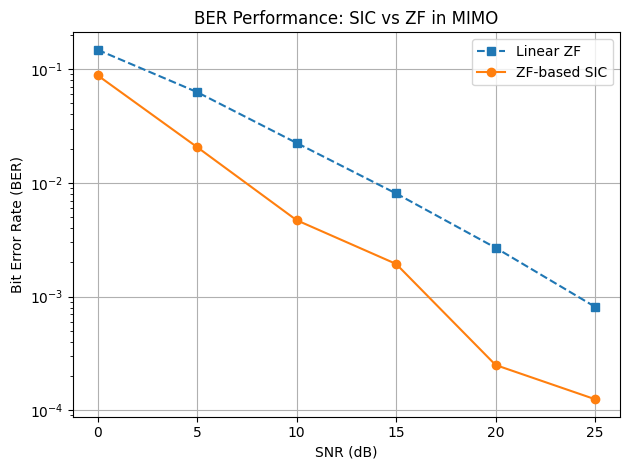

In [179]:

np.random.seed(0)

M = 4  # Number of Tx and Rx antennas (square MIMO)
SNR_dB = np.arange(0, 30, 5)
mod_order = 4  # QPSK

def qpsk_mod(bits):
    return (2 * (bits >> 1) - 1) + 1j * (2 * (bits & 1) - 1)

def qpsk_demod(symbols):
    bits_i = (symbols.real > 0).astype(int)
    bits_q = (symbols.imag > 0).astype(int)
    return (bits_i << 1) + bits_q

def qpsk_bits(bits):
    return np.vstack(((bits >> 1) & 1, bits & 1)).T.flatten()

def zf_detector(H, y):
    H_inv = np.linalg.pinv(H)
    x_hat = H_inv @ y
    return qpsk_demod(x_hat)

def sic_detector(H_orig, y_orig):
    M = H_orig.shape[1]
    H = H_orig.copy()
    y = y_orig.copy()
    indices = list(range(M))
    detected_syms = np.zeros(M, dtype=int)

    for i in range(M):
        G = np.linalg.pinv(H)
        norms = np.sum(np.abs(G)**2, axis=1)
        best_idx = np.argmin(norms)

        # Get detection vector and column
        w = G[best_idx]
        h = H[:, best_idx]
        idx_original = indices[best_idx]

        # Detect symbol
        x_hat = w @ y
        sym = qpsk_demod(np.array([x_hat]))[0]
        detected_syms[idx_original] = sym

        # Interference cancellation
        y = y - h * qpsk_mod(np.array([sym]))[0]
        H = np.delete(H, best_idx, axis=1)
        indices.pop(best_idx)

    return detected_syms

# Run Simulation
ber_zf = []
ber_sic = []

for snr_db in SNR_dB:
    errors_zf = 0
    errors_sic = 0
    N = 10000
    noise_var = 10 ** (-snr_db / 10)

    for _ in range(N):
        H = (np.random.randn(M, M) + 1j * np.random.randn(M, M)) / np.sqrt(2)
        bits = np.random.randint(0, mod_order, M)
        symbols = qpsk_mod(bits)
        noise = np.sqrt(noise_var / 2) * (np.random.randn(M) + 1j * np.random.randn(M))
        y = H @ symbols + noise

        # ZF Detection
        detected_zf = zf_detector(H, y)
        errors_zf += np.sum(qpsk_bits(detected_zf) != qpsk_bits(bits))

        # SIC Detection
        detected_sic = sic_detector(H, y)
        errors_sic += np.sum(qpsk_bits(detected_sic) != qpsk_bits(bits))

    ber_zf.append(errors_zf / (M * N * 2))
    ber_sic.append(errors_sic / (M * N * 2))

# Plot results
plt.semilogy(SNR_dB, ber_zf, 's--', label='Linear ZF')
plt.semilogy(SNR_dB, ber_sic, 'o-', label='ZF-based SIC')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER Performance: SIC vs ZF in MIMO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Adaptive Modulation and Coding (AMC)**

AMC technique is used in modern wireless communication systems (e.g., LTE, 5G) to dynamically adjust the **modulation order** and **coding rate** based on the **channel conditions**. The goal is to maximize data throughput while maintaining a target **bit error rate (BER)** or **block error rate (BLER)**.

Wireless channels vary due to **fading**, **interference**, **mobility**, etc. Fixed modulation and coding schemes (MCS) are inefficient because:

* High-order modulation (e.g., 64-QAM) offers high data rates but performs poorly in noisy conditions.
* Low-order modulation (e.g., QPSK) is robust but offers lower spectral efficiency.

**AMC adapts the MCS to current channel quality**, optimizing:

* **Robustness** when SNR is low.
* **Throughput** when SNR is high.


### **Building Blocks**

AMC has two components:

#### a. **Modulation**

Defines how bits are mapped to symbols:

| Scheme  | Bits/Symbol | Description |
| ------- | ----------- | ----------- |
| BPSK    | 1           | Most robust |
| QPSK    | 2           | Moderate    |
| 16-QAM  | 4           | Higher rate |
| 64-QAM  | 6           | Higher rate |
| 256-QAM | 8           | Used in 5G  |

#### b. **Channel Coding**

Adds redundancy to protect against errors:

* Common codes: **Turbo**, **LDPC**, **Polar** (5G)
* Coding Rate: $R = \frac{k}{n}$, where $k$ = info bits, $n$ = total bits

Lower coding rate → more redundancy → more robust


### **How AMC Works (Step-by-Step)**

1. **Channel Quality Estimation**
   Receiver estimates **SNR**, **CQI (Channel Quality Indicator)**, or **SINR** based on pilot symbols or reference signals.

2. **Feedback to Transmitter**
   Receiver sends **CQI** feedback to the base station (uplink in LTE/5G).

3. **MCS Selection**
   Transmitter uses this feedback to select the **Modulation and Coding Scheme (MCS)** from a predefined table (e.g., 3GPP MCS tables).

4. **Transmission with Selected MCS**
   The chosen modulation and coding are used to transmit the data.

5. **Repetition**
   Process is repeated frequently (e.g., every 1 ms in LTE), adapting in real time.


---

If $\gamma$ is the received SNR, the **maximum spectral efficiency** (Shannon limit) is:

$$
C(\gamma) = \log_2(1 + \gamma) \text{ bits/sec/Hz}
$$

AMC tries to **approach this limit** using a discrete set of MCS levels. A typical MCS will be selected if:

$$
\gamma_{i} \leq \gamma < \gamma_{i+1} \Rightarrow \text{Use MCS}_i
$$

Where $\gamma_i$ is the SNR threshold for the $i^{th}$ MCS.


### **Trade-offs**

* **Spectral efficiency vs robustness**
* **Feedback overhead** vs responsiveness
* **Latency** if reconfiguration is too slow
* **Outdated feedback** can degrade performance


### **Practical Example (LTE MCS Table Entry)**

| MCS Index | Modulation | Code Rate | Spectral Efficiency |
| --------- | ---------- | --------- | ------------------- |
| 0         | QPSK       | 0.076     | 0.15                |
| 9         | QPSK       | 0.93      | 1.48                |
| 16        | 16-QAM     | 0.73      | 2.40                |
| 28        | 64-QAM     | 0.93      | 5.55                |


### **AMC in Standards**

* **LTE**: Uplink and downlink both use AMC, with CQI, RI, PMI feedback.
* **5G NR**: Supports up to 256-QAM with fine-grained MCS tables and flexible HARQ.

### **Simulation Tip**

In simulations, you can implement AMC as a lookup table that maps estimated SNR to an MCS index.




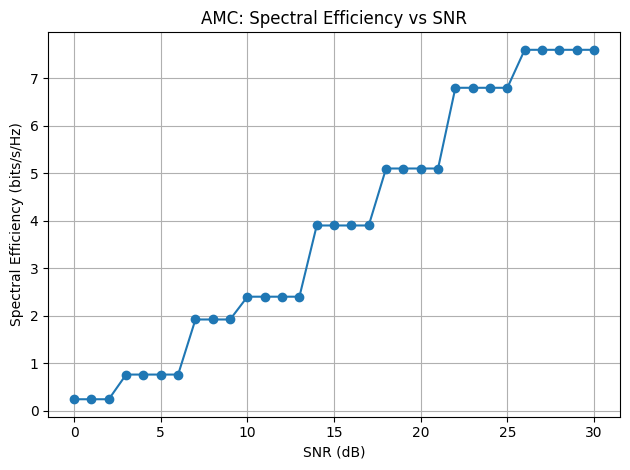

In [180]:

# Define SNR range (in dB)
snr_db = np.arange(0, 31, 1)
snr_linear = 10 ** (snr_db / 10)

# Define an MCS table: (SNR threshold, Modulation Order, Code Rate)
# Simplified version based on LTE/5G-like systems
mcs_table = [
    (0,    2, 0.12),  # QPSK
    (3,    2, 0.38),  # QPSK
    (7,    4, 0.48),  # 16-QAM
    (10,   4, 0.60),  # 16-QAM
    (14,   6, 0.65),  # 64-QAM
    (18,   6, 0.85),  # 64-QAM
    (22,   8, 0.85),  # 256-QAM
    (26,   8, 0.95),  # 256-QAM
]

# Function to select MCS for each SNR value
def select_mcs(snr_db, mcs_table):
    modulation_order = []
    code_rate = []
    spectral_efficiency = []

    for snr in snr_db:
        for i in range(len(mcs_table) - 1, -1, -1):
            if snr >= mcs_table[i][0]:
                m, r = mcs_table[i][1], mcs_table[i][2]
                modulation_order.append(m)
                code_rate.append(r)
                spectral_efficiency.append(m * r)  # bits/s/Hz
                break
    return modulation_order, code_rate, spectral_efficiency

mod_order, code_rate, spectral_eff = select_mcs(snr_db, mcs_table)

# Plotting spectral efficiency vs SNR
plt.figure()
plt.plot(snr_db, spectral_eff, marker='o')
plt.grid(True)
plt.title("AMC: Spectral Efficiency vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Spectral Efficiency (bits/s/Hz)")
plt.tight_layout()
plt.show()


---

## **Introduction to Turbo Codes**

Turbo codes, introduced by Claude Berrou in 1993, were the first practical channel codes to approach the **Shannon capacity limit**. Their breakthrough came from combining two ideas:

* **Parallel concatenation of two convolutional encoders**
* **Iterative decoding with soft information exchange**

They are called “**turbo**” due to the **feedback-like decoding loop**, reminiscent of a turbo engine’s feedback mechanism.


## **Basic Structure**

Turbo coding consists of:

### a. **Two Recursive Systematic Convolutional (RSC) Encoders**

* Connected in parallel
* Both encode the same input, but the second encoder sees an **interleaved** version of the input.

### b. **Interleaver**

* A deterministic or pseudorandom permutation of the input bits
* Introduces randomness to break low-weight input patterns (improves minimum distance)

### c. **Code Rate**

* The basic configuration transmits:

  * The **original input bits** (systematic)
  * One **parity bit** from each encoder
* Code rate:

  $$
  R = \frac{\text{Number of input bits}}{\text{Number of transmitted bits}} = \frac{k}{k + 2k} = \frac{1}{3}
  $$

  (Puncturing can increase it to 1/2, 2/3, etc.)


## **Encoding Process (Step-by-Step)**

1. Input data: $\mathbf{u} = [u_0, u_1, \dots, u_{k-1}]$
2. Encoder 1 takes $\mathbf{u}$ and produces parity bits $\mathbf{p}_1$
3. Interleaver scrambles $\mathbf{u} \rightarrow \mathbf{u}'$
4. Encoder 2 takes $\mathbf{u}'$ and produces parity bits $\mathbf{p}_2$
5. Transmitted bits:

   $$
   \mathbf{x} = \left[ u_0, p_{1,0}, p_{2,0}, u_1, p_{1,1}, p_{2,1}, \dots \right]
   $$


## **Recursive Systematic Convolutional (RSC) Encoder**

Each encoder is usually a **rate-1/2 RSC code**, implemented via:

* Shift registers
* Feedback and feedforward polynomials

For example, a **constraint length 3** encoder might use:

* Generator polynomials: $G_1 = 1 + D + D^2$, $G_2 = 1 + D^2$

These generate both:

* **Systematic bit**: Original input bit
* **Parity bit**: Based on current and previous input bits


## **Turbo Decoder (Iterative Decoding)**

Turbo decoding is performed iteratively using **two Soft-Input Soft-Output (SISO)** decoders:

### Step-by-Step:

1. Each decoder uses the **Log-MAP algorithm** or **Max-Log-MAP** to decode its stream, taking into account **a priori probabilities**.
2. Decoder 1 processes the systematic bits and its parity bits → produces **extrinsic LLRs**.
3. Interleaver permutes these extrinsic values → fed into Decoder 2.
4. Decoder 2 processes interleaved systematic bits and parity → updates extrinsic LLRs.
5. These are **deinterleaved** and passed back to Decoder 1.

Each iteration improves reliability of LLRs. After $N$ iterations, a **hard decision** is made:

$$
\hat{u}_i = \begin{cases}
1 & \text{if } L(u_i) > 0 \\
0 & \text{otherwise}
\end{cases}
$$


## **Mathematical Details of Decoding**

The **Log-MAP algorithm** computes the **log-likelihood ratio (LLR)** for each bit:

$$
L(u_i) = \log \frac{P(u_i = 1 | y)}{P(u_i = 0 | y)}
$$

The LLR is decomposed as:

$$
L(u_i) = L_c(y_i) + L_{a}(u_i) + L_e(u_i)
$$

Where:

* $L_c(y_i)$: channel LLR from received symbols
* $L_a(u_i)$: a priori info from other decoder
* $L_e(u_i)$: extrinsic info passed to other decoder


## **Performance and Properties**

| Property             | Turbo Code                           |
| -------------------- | ------------------------------------ |
| Capacity-Approaching | Yes                                  |
| Good at              | Moderate blocklength (1k–10k)        |
| Drawback             | Error floor at high SNR              |
| Complexity           | Medium-high due to iterations        |
| Used in              | 3G, 4G LTE data channels, deep space |


## **Turbo Code vs. Block Code**

Turbo codes achieve high performance by:

* **Interleaving**, which increases effective free distance
* **Iterative decoding**, improving reliability per iteration
* **Soft information exchange**, unlike traditional block codes


## **Diagram Summary**

```
Input:  u0 u1 u2 u3 ...

  ┌──────────────┐
  │   Encoder 1  │─────→ parity 1
  └──────────────┘
        │
        │ systematic bits → TX
        ▼
  ┌──────────────┐
  │  Interleaver │──→ permuted input
  └──────────────┘
        ▼
  ┌──────────────┐
  │   Encoder 2  │─────→ parity 2
  └──────────────┘
```

At receiver:

* Decoder 1 ⇄ Decoder 2 (via interleaver/deinterleaver)
* Iteratively exchange **LLRs**




--- 

### Custom Turbo Code Implementation 


### 1. **Recursive Systematic Convolutional (RSC) Encoder**

* Constraint length $K = 3$
* Generator polynomials: $G_1 = (1, 1, 1)$, $G_2 = (1, 0, 1)$

    * $G_1$ is the systematic path
    * $G_2$ is the feedback parity path

### 2. **Turbo Encoder**

* Two identical RSC encoders
* One processes original bits
* The other processes interleaved bits

### 3. **Turbo Decoder (Iterative)**

* A basic version of **Soft-In Soft-Out (SISO)** decoding using **Log-MAP** (or approximation)
* Exchange **extrinsic information** between the two decoders
* Use **a priori + channel + extrinsic** LLRs




In [ ]:
# ===========================
# 1. Recursive Systematic Convolutional Encoder (RSC)
# ===========================
class RSCEncoder:
    def __init__(self, g_sys, g_parity):
        """
        g_sys, g_parity: generator polynomials as lists of bits, e.g., [1, 1, 1]
        """
        self.g_sys = np.array(g_sys)
        self.g_parity = np.array(g_parity)
        self.K = len(g_sys)

    def encode(self, bits):
        """
        Encodes a bit array using a rate-1/2 RSC encoder.
        Returns: (systematic_bits, parity_bits)
        """
        state = np.zeros(self.K - 1, dtype=int)
        sys_bits = []
        parity_bits = []

        for bit in bits:
            sys_bits.append(bit)

            # Compute feedback = input XOR feedback terms
            feedback = bit
            for i in range(1, self.K):
                feedback ^= self.g_sys[i] & state[i - 1]

            # Compute parity = feedback XOR parity terms
            parity = feedback * self.g_parity[0]
            for i in range(1, self.K):
                parity ^= self.g_parity[i] & state[i - 1]
            parity_bits.append(parity)

            # Update shift register
            state = np.roll(state, shift=1)
            state[0] = feedback

        return np.array(sys_bits), np.array(parity_bits)


if __name__ == "__main__":
    np.random.seed(0)
    test_bits = np.random.randint(0, 2, 10)
    encoder = RSCEncoder(g_sys=[1, 1, 1], g_parity=[1, 0, 1])
    sys, parity = encoder.encode(test_bits)

    print("Input:        ", test_bits)
    print("Systematic:   ", sys)
    print("Parity:       ", parity)




Input:         [0 1 1 0 1 1 1 1 1 1]
Systematic:    [0 1 1 0 1 1 1 1 1 1]
Parity:        [0 1 0 0 0 1 1 0 1 1]


In [194]:
# ===========================
# 2. Interleaver / Deinterleaver
# ===========================
class Interleaver:
    def __init__(self, pattern):
        """
        pattern: a permutation of indices for interleaving (e.g., np.random.permutation(N))
        """
        self.pattern = np.array(pattern)
        self.inverse_pattern = np.argsort(self.pattern)

    def interleave(self, bits):
        return bits[self.pattern]

    def deinterleave(self, bits):
        return bits[self.inverse_pattern]


if __name__ == "__main__":
    bits = np.array([0, 1, 1, 0, 1, 0])
    pattern = np.random.permutation(len(bits))
    interleaver = Interleaver(pattern)

    interleaved = interleaver.interleave(bits)
    recovered = interleaver.deinterleave(interleaved)

    print("Original Bits:   ", bits)
    print("Interleaved:     ", interleaved)
    print("Deinterleaved:   ", recovered)


Original Bits:    [0 1 1 0 1 0]
Interleaved:      [1 0 1 0 1 0]
Deinterleaved:    [0 1 1 0 1 0]


In [195]:
# ===========================
# 3. Turbo Encoder
# ===========================

class TurboEncoder:
    def __init__(self, g_sys, g_parity, interleaver):
        """
        g_sys, g_parity: generator polynomials
        interleaver: instance of Interleaver
        """
        self.encoder1 = RSCEncoder(g_sys, g_parity)
        self.encoder2 = RSCEncoder(g_sys, g_parity)
        self.interleaver = interleaver

    def encode(self, info_bits):
        """
        Returns:
            sys_bits: Systematic bits (from encoder 1)
            parity1: Parity bits from encoder 1
            parity2: Parity bits from encoder 2 (interleaved input)
            interleaved_bits: Interleaved version of info_bits
        """
        sys_bits, parity1 = self.encoder1.encode(info_bits)
        interleaved_bits = self.interleaver.interleave(info_bits)
        _, parity2 = self.encoder2.encode(interleaved_bits)
        return sys_bits, parity1, parity2, interleaved_bits


if __name__ == "__main__":
    np.random.seed(0)
    info_bits = np.random.randint(0, 2, 10)
    interleaver_pattern = np.random.permutation(len(info_bits))
    interleaver = Interleaver(interleaver_pattern)

    encoder = TurboEncoder(g_sys=[1, 1, 1], g_parity=[1, 0, 1], interleaver=interleaver)
    sys, p1, p2, interleaved = encoder.encode(info_bits)

    print("Info Bits:       ", info_bits)
    print("Systematic Bits: ", sys)
    print("Parity 1:        ", p1)
    print("Parity 2:        ", p2)
    print("Interleaved Bits:", interleaved)


Info Bits:        [0 1 1 0 1 1 1 1 1 1]
Systematic Bits:  [0 1 1 0 1 1 1 1 1 1]
Parity 1:         [0 1 0 0 0 1 1 0 1 1]
Parity 2:         [0 1 0 1 1 1 0 0 0 0]
Interleaved Bits: [0 1 1 1 1 0 1 1 1 1]


In [206]:
# ===========================
# 4. Log-MAP approximation for SISO Decoder (max-log-MAP)
# ===========================
class SISODecoder:
    def __init__(self, g_sys, g_parity, noise_var):
        self.noise_var = noise_var
        self.states = 4  # for constraint length 3
        self.trellis = self._build_trellis(g_sys, g_parity)

    def _build_trellis(self, g_sys, g_parity):
        # Build manually for constraint length = 3
        trellis = {}
        for s in range(4):
            for u in [0, 1]:
                current_state = list(map(int, np.binary_repr(s, width=2)))
                input_bit = u

                # Feedback (RSC)
                fb = input_bit ^ (g_sys[1] & current_state[0]) ^ (g_sys[2] & current_state[1])
                parity = fb ^ (g_parity[1] & current_state[0]) ^ (g_parity[2] & current_state[1])

                next_state = (fb << 1) | current_state[0]
                next_state &= 0b11  # 2-bit state
                trellis[(s, u)] = (next_state, parity)
        return trellis

    def decode(self, y_sys, y_parity, apriori):
        N = len(y_sys)
        alpha = np.full((N + 1, 4), -np.inf)
        beta = np.full((N + 1, 4), -np.inf)
        alpha[0, 0] = 0
        beta[N, :] = 0  # all states equally likely at the end

        # Forward alpha
        for k in range(N):
            for s_prev in range(4):
                for u in [0, 1]:
                    s_next, parity = self.trellis[(s_prev, u)]
                    metric = -0.5 / self.noise_var * (
                        (2*u - 1 - y_sys[k])**2 + (2*parity - 1 - y_parity[k])**2
                    ) + apriori[k]*u
                    alpha[k+1, s_next] = max(alpha[k+1, s_next], alpha[k, s_prev] + metric)

        # Backward beta
        for k in reversed(range(N)):
            for s_next in range(4):
                for s_prev in range(4):
                    for u in [0, 1]:
                        if self.trellis.get((s_prev, u), (None,))[0] == s_next:
                            parity = self.trellis[(s_prev, u)][1]
                            metric = -0.5 / self.noise_var * (
                                (2*u - 1 - y_sys[k])**2 + (2*parity - 1 - y_parity[k])**2
                            ) + apriori[k]*u
                            beta[k, s_prev] = max(beta[k, s_prev], beta[k+1, s_next] + metric)

        # LLR output
        extrinsic = np.zeros(N)
        for k in range(N):
            num = -np.inf
            den = -np.inf
            for s_prev in range(4):
                for u in [0, 1]:
                    s_next, parity = self.trellis[(s_prev, u)]
                    metric = alpha[k, s_prev] + beta[k+1, s_next] + \
                             (-0.5 / self.noise_var * ((2*u - 1 - y_sys[k])**2 + (2*parity - 1 - y_parity[k])**2)) + \
                             apriori[k] * u
                    if u == 1:
                        num = max(num, metric)
                    else:
                        den = max(den, metric)
            extrinsic[k] = num - den

        return extrinsic





In [207]:
# ===========================
# 5. Full Turbo Decoder (Iterative)
# ===========================

class TurboDecoder:
    def __init__(self, g_sys, g_parity, interleaver, noise_var, n_iter=5):
        """
        g_sys, g_parity: generator polynomials
        interleaver: Interleaver instance
        noise_var: noise variance of the AWGN channel
        n_iter: number of decoding iterations
        """
        self.interleaver = interleaver
        self.siso1 = SISODecoder(g_sys, g_parity, noise_var)
        self.siso2 = SISODecoder(g_sys, g_parity, noise_var)
        self.n_iter = n_iter

    def decode(self, rx_sys, rx_p1, rx_p2):
        """
        rx_sys: received noisy systematic (LLR)
        rx_p1: received noisy parity1 (LLR)
        rx_p2: received noisy parity2 (LLR)
        Returns:
            decoded_bits: final hard decision after n_iter iterations
            final_llr: final LLRs from decoder 1
        """
        N = len(rx_sys)
        apriori1 = np.zeros(N)

        for _ in range(self.n_iter):
            # Decoder 1
            llr1 = self.siso1.decode(rx_sys, rx_p1, apriori1)
            extrinsic1 = llr1 - apriori1
            apriori2 = self.interleaver.interleave(extrinsic1)

            # Decoder 2
            inter_rx_sys = self.interleaver.interleave(rx_sys)
            llr2 = self.siso2.decode(inter_rx_sys, rx_p2, apriori2)
            extrinsic2 = llr2 - apriori2
            apriori1 = self.interleaver.deinterleave(extrinsic2)

        final_llr = llr1
        decoded_bits = (final_llr >= 0).astype(int)
        return decoded_bits, final_llr




In [208]:
# ===========================
# Step 6: AWGN simulation with BER measurement and plotting.
# ===========================

class TurboSimulation:
    def __init__(self, g_sys, g_parity, block_len, n_iter=5):
        self.g_sys = g_sys
        self.g_parity = g_parity
        self.block_len = block_len
        self.n_iter = n_iter

    def bpsk_mod(self, bits):
        return 1 - 2 * bits  # 0 → +1, 1 → -1

    def run(self, snr_db, num_blocks=20):
        snr_linear = 10 ** (snr_db / 10)
        noise_var = 1 / (2 * snr_linear)
        sigma = np.sqrt(noise_var)

        total_errors = 0
        total_bits = 0

        for _ in range(num_blocks):
            info_bits = np.random.randint(0, 2, self.block_len)
            interleaver_pattern = np.random.permutation(self.block_len)
            interleaver = Interleaver(interleaver_pattern)

            encoder = TurboEncoder(self.g_sys, self.g_parity, interleaver)
            sys_bits, p1_bits, p2_bits, _ = encoder.encode(info_bits)

            tx_sys = self.bpsk_mod(sys_bits)
            tx_p1 = self.bpsk_mod(p1_bits)
            tx_p2 = self.bpsk_mod(p2_bits)

            rx_sys = tx_sys + sigma * np.random.randn(self.block_len)
            rx_p1  = tx_p1 + sigma * np.random.randn(self.block_len)
            rx_p2  = tx_p2 + sigma * np.random.randn(self.block_len)

            rx_sys_llr = 2 * rx_sys / noise_var
            rx_p1_llr  = 2 * rx_p1  / noise_var
            rx_p2_llr  = 2 * rx_p2  / noise_var

            decoder = TurboDecoder(self.g_sys, self.g_parity, interleaver, noise_var, self.n_iter)
            decoded_bits, _ = decoder.decode(rx_sys_llr, rx_p1_llr, rx_p2_llr)

            total_errors += np.sum(decoded_bits != info_bits)
            total_bits += self.block_len

        ber = total_errors / total_bits
        return ber




In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    sim = TurboSimulation(g_sys=[1,1,1], g_parity=[1,0,1], block_len=5000, n_iter=6)
    snr_range = np.arange(0, 3.5, 0.5)
    ber_values = [sim.run(snr_db,num_blocks = 30) for snr_db in snr_range]

    plt.figure()
    plt.semilogy(snr_range, ber_values, marker='o')
    plt.grid(True, which='both')
    plt.title("Turbo Code BER vs. SNR (Max-Log-MAP, 6 Iterations)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Bit Error Rate (BER)")
    plt.tight_layout()
    plt.show()


--- 

## **Polar codes** 

Invented by Erdal Arıkan in 2009, are the **first class of error-correcting codes** that are **mathematically proven to achieve the capacity** of binary-input symmetric memoryless channels (B-DMC), such as the Binary Erasure Channel (BEC) and AWGN.

### Core Idea: Channel Polarization

The fundamental idea behind polar codes is called **channel polarization**. Given a communication channel $W$, we construct $N = 2^n$ **synthesized channels** $W_1, W_2, ..., W_N$, such that:

* Some channels become **almost noiseless** ($\text{capacity} \to 1$)
* Others become **completely noisy** ($\text{capacity} \to 0$)

We then:

* Transmit data bits over the **good (reliable)** channels
* Fix the inputs of **bad (unreliable)** channels to known values (called **frozen bits**)

### Polar Encoding

#### a. **Input Vector**

Let:

* $\mathbf{u} = [u_0, u_1, \dots, u_{N-1}]$: message + frozen bits
* $N = 2^n$: block length

#### b. **Polar Transform**

Encoding is done via:

$$
\mathbf{x} = \mathbf{u} \cdot G_N
$$

Where:

* $G_N = B_N \cdot F^{\otimes n}$
* $F = \begin{bmatrix}1 & 0 \\ 1 & 1\end{bmatrix}$
* $F^{\otimes n}$ is the **n-th Kronecker power**
* $B_N$: bit-reversal permutation matrix

The polar transform mixes bits so that some synthesized channels become more reliable than others.


### Frozen vs Information Bits

Once channels are polarized:

* Select **K** most reliable channels → assign **data bits**
* Remaining $N - K$ → assign **frozen bits** (usually zero)

These positions are **precomputed** based on channel type (e.g., AWGN) and SNR using **Bhattacharyya parameters** or **density evolution**.

### Decoding: Successive Cancellation (SC)

SC decoding proceeds **bit by bit**:

$$
\hat{u}_i = \begin{cases}
0 & \text{if } i \text{ is frozen} \\
\arg\max_{u_i} P(u_i | y, \hat{u}_0^{i-1}) & \text{otherwise}
\end{cases}
$$

* Uses **LLR recursion**
* Early decisions affect later ones
* Very fast (complexity $O(N \log N)$)

### Successive Cancellation List (SCL) Decoding

SC decoding suffers from:

* Poor performance at short blocklengths
* High error rate due to early decision errors

**SCL decoding** improves performance by:

* Keeping a **list of the best decoding paths**
* Selecting the final codeword using a **CRC check** (used in 5G NR)

SCL-CRC is the **standard decoding method** in real systems.


### Example: $N = 8$ Polar Code

* Block length $N = 8$
* K = 4 data bits, 4 frozen bits
* Frozen positions: {0, 1, 2, 4}
* Information positions: {3, 5, 6, 7}

place:

* 0s in frozen positions
* message bits in data positions

compute:

$$
\mathbf{x} = \mathbf{u} \cdot G_8
$$

### Polar Code Properties

| Feature      | Description                                      |
| ------------ | ------------------------------------------------ |
| Complexity   | $O(N \log N)$ encoding & decoding                |
| Capacity     | Achieves capacity for B-DMCs                     |
| Performance  | Excellent with SCL-CRC (especially at large $N$) |
| Block Length | Must be power of 2                               |
| Error Floor  | Avoided using SCL decoding                       |

---

### Use in 5G NR

* Polar codes are used for **control channels** in **5G NR**:

  * **PBCH**, **PDCCH**, **PUCCH**, **DCI**
* Data channels use **LDPC codes**

Why Polar for control?

* Low latency
* Short block length efficiency
* Efficient hardware implementation


## Polar vs Turbo vs LDPC

| Feature            | Polar               | Turbo           | LDPC               |
| ------------------ | ------------------- | --------------- | ------------------ |
| Invented           | 2009                | 1993            | 1960s / modernized |
| Decoding           | SC, SCL             | Iterative (MAP) | Iterative (BP)     |
| Capacity-achieving | Yes (B-DMC)         | Near capacity   | Yes (long block)   |
| Used in 5G NR      | Control             | No              | Data (PDSCH)       |
| Performance        | Excellent (SCL-CRC) | Moderate        | Excellent (long)   |



In [210]:
from numpy.polynomial.polynomial import Polynomial

# ===============================
# 1. Polar Transform Matrix
# ===============================
def polar_transform_matrix(N):
    """Generate the Polar transform matrix G_N = B_N * F^{⊗n}"""
    def kronecker_power(F, n):
        result = F
        for _ in range(1, n):
            result = np.kron(result, F)
        return result

    def bit_reversal(n):
        N = 2 ** n
        result = np.arange(N)
        for i in range(N):
            b = '{:0{width}b}'.format(i, width=n)
            result[i] = int(b[::-1], 2)
        return result

    n = int(np.log2(N))
    F = np.array([[1, 0], [1, 1]], dtype=int)
    G = kronecker_power(F, n) % 2
    bit_rev_order = bit_reversal(n)
    G = G[bit_rev_order]
    return G

# ===============================
# 2. Polar Encoder
# ===============================
def polar_encode(u, G_N):
    """Polar encoding: x = u * G_N (mod 2)"""
    return np.mod(u @ G_N, 2)

# ===============================
# 3. Successive Cancellation Decoder (SC)
# ===============================
def sc_decode(llr, frozen_bits):
    N = len(llr)
    u_hat = np.zeros(N, dtype=int)

    def recursive_decode(llr, depth=0):
        n = len(llr)
        if n == 1:
            i = len(u_hat) - len(llr)
            if frozen_bits[i] == 1:
                return np.array([0])
            else:
                return np.array([0 if llr[0] >= 0 else 1])
        else:
            llr_left = np.sign(llr[:n//2]) * np.minimum(np.abs(llr[:n//2]), np.abs(llr[n//2:]))
            llr_right = llr[n//2:] + ((1 - 2 * recursive_decode(llr_left, depth + 1)) * llr[:n//2])
            left_bits = recursive_decode(llr_left, depth + 1)
            right_bits = recursive_decode(llr_right, depth + 1)
            return np.concatenate([(left_bits ^ right_bits), right_bits])

    return recursive_decode(llr)

# ===============================
# 4. Test Case
# ===============================
# Parameters
N = 8  # block length (must be power of 2)
K = 4  # number of data bits
np.random.seed(0)

# Reliability order (for simplicity, manually selected for N=8 and AWGN)
# In practice use Arikan's Bhattacharyya or 5G standards
reliable_indices = [3, 5, 6, 7]  # information bits
frozen_indices = [0, 1, 2, 4]    # frozen bits

# Information bits
info_bits = np.random.randint(0, 2, K)

# Prepare u vector (with frozen bits = 0)
u = np.zeros(N, dtype=int)
u[reliable_indices] = info_bits

# Encoding
G_N = polar_transform_matrix(N)
x = polar_encode(u, G_N)

# BPSK modulation and AWGN
def bpsk(x): return 1 - 2 * x
def add_awgn(x, snr_db):
    snr = 10 ** (snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr))
    return x + noise_std * np.random.randn(len(x))

snr_db = 3
x_mod = bpsk(x)
y = add_awgn(x_mod, snr_db)
llr = 2 * y * (10 ** (snr_db / 10))  # LLR for BPSK over AWGN

# Frozen bit mask: 1 = frozen, 0 = info
frozen_mask = np.ones(N, dtype=int)
frozen_mask[reliable_indices] = 0

# Decoding
u_hat = sc_decode(llr, frozen_mask)
decoded_info_bits = u_hat[reliable_indices]

# Compute BER
ber = np.sum(decoded_info_bits != info_bits) / K
info_bits, decoded_info_bits, ber


# ===============================
# BER vs SNR for Polar Code with SC Decoding
# ===============================

def simulate_polar_sc(snr_db, N=128, K=64, num_trials=100):
    # Manually select reliability order (simplified)
    reliable_indices = sorted(np.random.choice(np.arange(N), K, replace=False))
    frozen_mask = np.ones(N, dtype=int)
    frozen_mask[reliable_indices] = 0

    G_N = polar_transform_matrix(N)
    total_errors = 0
    total_bits = 0

    for _ in range(num_trials):
        # Generate info bits and prepare u
        info_bits = np.random.randint(0, 2, K)
        u = np.zeros(N, dtype=int)
        u[reliable_indices] = info_bits

        # Encode
        x = polar_encode(u, G_N)
        x_mod = bpsk(x)
        y = add_awgn(x_mod, snr_db)
        llr = 2 * y * (10 ** (snr_db / 10))

        # Decode
        u_hat = sc_decode(llr, frozen_mask)
        decoded_info = u_hat[reliable_indices]

        total_errors += np.sum(decoded_info != info_bits)
        total_bits += K

    return total_errors / total_bits


# ===============================
# Successive Cancellation List (SCL) Decoder with CRC
# ===============================

def crc_check(bits, crc_poly, crc_len):
    """Check if CRC remainder is zero."""
    m = np.append(bits, np.zeros(crc_len, dtype=int))
    poly = Polynomial(m[::-1])
    divisor = Polynomial(crc_poly[::-1])
    remainder = poly % divisor
    return np.all(np.round(remainder.coef[::-1][:crc_len]) == 0)

def generate_crc(bits, crc_poly, crc_len):
    """Append CRC to bits."""
    m = np.append(bits, np.zeros(crc_len, dtype=int))
    poly = Polynomial(m[::-1])
    divisor = Polynomial(crc_poly[::-1])
    remainder = poly % divisor
    crc = np.round(remainder.coef[::-1][:crc_len]).astype(int)
    return np.append(bits, crc)

def scl_decode(llr, frozen_mask, L=8, crc_poly=None, crc_len=0):
    """
    SCL decoder with optional CRC.
    """
    N = len(llr)
    paths = [(np.zeros(N, dtype=int), 0.0)]  # (path, path_metric)

    for i in range(N):
        new_paths = []
        for path, metric in paths:
            if frozen_mask[i]:
                new_path = path.copy()
                new_path[i] = 0
                new_metric = metric + np.log1p(np.exp(-abs(llr[i])))
                new_paths.append((new_path, new_metric))
            else:
                for bit in [0, 1]:
                    new_path = path.copy()
                    new_path[i] = bit
                    if bit == 0:
                        new_metric = metric + np.log1p(np.exp(-abs(llr[i])))
                    else:
                        new_metric = metric + np.log1p(np.exp(abs(llr[i])))
                    new_paths.append((new_path, new_metric))
        paths = sorted(new_paths, key=lambda x: x[1])[:L]

    # CRC check
    if crc_poly is not None:
        for path, _ in paths:
            info_bits = path[frozen_mask == 0]
            if crc_check(info_bits, crc_poly, crc_len):
                return path
        return paths[0][0]  # fallback
    else:
        return paths[0][0]



# ===============================
# Simulation with CRC + SCL
# ==============================
def simulate_polar_scl_crc_fixed_errors(
    snr_db, N=128, K=64, crc_poly=[1,1,0,1], crc_len=3, L=8, target_errors=1000):
    effective_K = K - crc_len
    info_indices = sorted(np.random.choice(np.arange(N), K, replace=False))
    frozen_mask = np.ones(N, dtype=int)
    frozen_mask[info_indices] = 0

    G_N = polar_transform_matrix(N)
    total_errors = 0
    total_bits = 0

    while total_errors < target_errors:
        bits = np.random.randint(0, 2, effective_K)
        bits_with_crc = generate_crc(bits, crc_poly, crc_len)
        u = np.zeros(N, dtype=int)
        u[info_indices] = bits_with_crc

        x = polar_encode(u, G_N)
        x_mod = bpsk(x)
        y = add_awgn(x_mod, snr_db)
        llr = 2 * y * (10 ** (snr_db / 10))

        u_hat = scl_decode(llr, frozen_mask, L=L, crc_poly=crc_poly, crc_len=crc_len)
        decoded_info = u_hat[info_indices][:effective_K]

        total_errors += np.sum(decoded_info != bits)
        total_bits += effective_K

    return total_errors / total_bits




In [ ]:
ber_curve_scl_crc = [
    simulate_polar_scl_crc_fixed_errors(snr, N=128, K=64, crc_len=3, L=8, target_errors=1000)
    for snr in snr_range
]

plt.figure()
plt.semilogy(snr_range, ber_curve_scl_crc, marker='o', label='Polar SCL + CRC (L=8)')
plt.grid(True, which='both')
plt.title("Polar Code BER vs SNR with SCL + CRC (N=128, K=61 + CRC 3)")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.legend()
plt.tight_layout()
plt.show()

---

There are several Python libraries that provide implementations of **Turbo**, **LDPC**, and **Polar** codes. Below are the most relevant ones, from research-grade to production-quality:

### **CommPy** (Communications with Python)

* **GitHub**: [https://github.com/veeresht/CommPy](https://github.com/veeresht/CommPy)
* **Status**: Actively used in academia (not full 5G spec compliant)
* **Implements**:

  * Turbo codes (basic RSC, iterative decoding)
  * Convolutional codes (Viterbi)
  * Basic LDPC (with `pyldpc` dependency)
  * ❌ Polar (not included)

---

### **PyLDPC**

* **GitHub**: [https://github.com/flennerhag/pyldpc](https://github.com/flennerhag/pyldpc)
* **Implements**:

  * LDPC: generation, encoding, belief propagation decoding
* **Supports**:

  * Regular/irregular LDPC
  * Custom parity-check matrices

> No Turbo or Polar support. Use for LDPC simulation only.

---

### **Sionna** (NVIDIA) – 5G & Deep Learning Ready

* **GitHub**: [https://github.com/NVIDIA/sionna](https://github.com/NVIDIA/sionna)
* **Platform**: TensorFlow 2.x
* **Implements**:

  * Polar codes (including CRC-aided SC and SCL decoding)
  * LDPC (3GPP 5G NR compliant)
  * Turbo (basic support)
  * 5G NR full PHY chain

> If you're doing **5G** simulations or using **ML + comms**, this is the **most comprehensive and accurate** toolkit available.

---

### **IT++ (via Python bindings)**

* **C++ library with Python wrappers**
* Implements all major FEC codes
* But setup is difficult, and usage is dated

> Not recommended unless you already use it in C++

---

### **OpenFEC**

* LDPC and Turbo codes (3GPP-like)
* High-performance C-based implementation, hard to use directly in Python

---

### PyTorch Implementations

Some GitHub repositories (e.g. TurboAE, PolarNet) offer differentiable implementations:

* **TurboAE**: Turbo autoencoder-based neural decoder
* **PolarNet**: Polar code SC/SCL decoding via deep learning

---




---
---

## **End-to-End Physical (PHY) Frame Structure** 

A well-designed frame supports synchronization, channel estimation, equalization, and efficient data transmission. Below is a detailed theoretical explanation of each component:



### Overview of a PHY Frame**

A **PHY frame** is a time-domain representation of a structured transmission burst that includes:

```
[ Preamble | Pilots | Data Symbols | Cyclic Prefix (CP) ]
```

Each part serves a unique role in reliable transmission and reception over a channel that may include noise, fading, and timing offsets.


### Components of the Frame**

#### 2.1 **Preamble**

* Time synchronization (frame start detection)
* Frequency offset estimation
* Initial channel estimation (coarse)

**Theory**:

* Often designed using **Zadoff-Chu**, **Golay**, or **PN sequences** with ideal autocorrelation properties.
* The receiver performs **correlation** with a known sequence to detect the frame's start.
* The preamble is fixed and known to both transmitter and receiver.

**Equation** (for correlation-based detection):

$$
\text{Corr}(y[n], p[n]) = \sum_{k=0}^{L-1} y[n+k] \cdot p^*[k]
$$

Where:

* $y[n]$: received signal
* $p[k]$: preamble sequence
* $L$: length of preamble


#### 2.2 **Pilots (Reference Signals)**

* Channel estimation (fine)
* Tracking time-varying channel (e.g., fading)

**Theory**:

* Pilots are inserted at known positions in time-frequency grid.
* Can be **block-type** (whole OFDM symbol) or **comb-type** (scattered among subcarriers).
* The receiver uses pilot symbols $X_p$ and received symbols $Y_p$ to estimate channel:

$$
\hat{H}_p = \frac{Y_p}{X_p}
$$

Then interpolate across time and frequency to estimate full channel.

#### 2.3 **Data Symbols**

* Carries modulated payload (QPSK, QAM, etc.)

**Theory**:

* Data bits → modulated → mapped to subcarriers
* OFDM is commonly used: each data symbol occupies one subcarrier

$$
x[n] = \sum_{k=0}^{N-1} X_k \cdot e^{j2\pi kn/N}
$$

Where:

* $X_k$: modulated symbol on subcarrier $k$
* $N$: FFT size


#### 2.4 **Cyclic Prefix (CP)**

* Prevents inter-symbol interference (ISI)
* Converts linear convolution into circular convolution for FFT-based equalization

**Theory**:

* CP is a copy of the last $L_{CP}$ samples of the OFDM symbol, appended to its start.

$$
x_{\text{CP}}[n] = x[n + N - L_{CP}], \quad n = -L_{CP}, \ldots, -1
$$

* Enables the receiver to perform frequency-domain equalization using FFT:

$$
Y_k = H_k \cdot X_k + N_k \Rightarrow \hat{X}_k = \frac{Y_k}{\hat{H}_k}
$$


### Full Frame Structure Example (OFDM)

Denote:

* $N$: number of subcarriers
* $T_s$: OFDM symbol duration (without CP)
* $T_{CP}$: CP duration

Each PHY frame may consist of multiple OFDM symbols arranged as:

```
Time -->
+----------+----------+----------+----------+----------+----------+
| Preamble | Pilot    | Data     | Pilot    | Data     |   ...    |
+----------+----------+----------+----------+----------+----------+
    ↑          ↑          ↑         ↑
  Sync     Channel   Payload   Channel ...
           Estimate            Estimate
```

Each OFDM symbol includes a CP:

```
|CP|---- FFT (N points) ----|
```


### Frame Design Considerations**

| Design Aspect       | Notes                                                                     |
| ------------------- | ------------------------------------------------------------------------- |
| **Pilot Density**   | Higher for fast-fading channels (e.g., vehicular), lower for static links |
| **CP Length**       | Should be ≥ maximum channel delay spread                                  |
| **Preamble Design** | Should be autocorrelation-friendly for robust sync                        |
| **FFT Size $N$**    | Power-of-two, chosen based on bandwidth & subcarrier spacing              |
| **Frame Duration**  | Trade-off between latency and spectral efficiency                         |


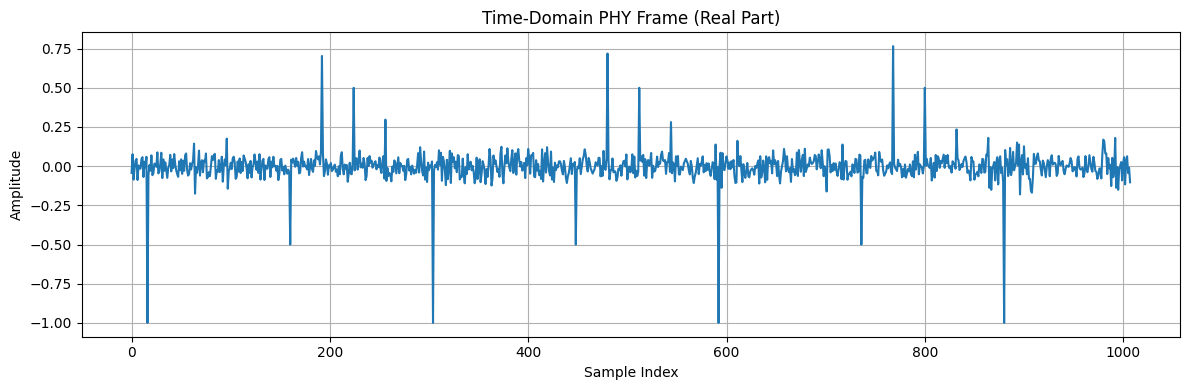

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
N_subcarriers = 64             # Number of OFDM subcarriers
CP_len = 16                    # Cyclic Prefix length
num_data_symbols = 6          # Number of OFDM symbols with data
pilot_interval = 2            # Every 2nd symbol is a pilot
mod_order = 4                 # QPSK
preamble_len = N_subcarriers  # One OFDM symbol length preamble

# Generate QPSK modulation
def qpsk_mod(bits):
    return (2 * (bits >> 1) - 1) + 1j * (2 * (bits & 1) - 1)

# Generate preamble (Zadoff-Chu-like or random known sequence)
np.random.seed(0)
preamble_bits = np.random.randint(0, 2, 2 * N_subcarriers)
preamble_sym = qpsk_mod(preamble_bits)

# IFFT to create time-domain preamble
preamble_ifft = np.fft.ifft(preamble_sym)
preamble_cp = np.concatenate([preamble_ifft[-CP_len:], preamble_ifft])

# Generate OFDM frame
frame = [preamble_cp]
num_symbols = num_data_symbols
for i in range(num_symbols):
    bits = np.random.randint(0, 2, 2 * N_subcarriers)
    symbols = qpsk_mod(bits)

    # For pilot, set known pattern
    if i % pilot_interval == 0:
        symbols[::4] = 1 + 1j  # Pilot every 4 subcarriers
        symbols[1::4] = -1 - 1j

    # IFFT and add CP
    time_domain = np.fft.ifft(symbols)
    ofdm_symbol = np.concatenate([time_domain[-CP_len:], time_domain])
    frame.append(ofdm_symbol)

# Concatenate all symbols to form the full frame
tx_frame = np.concatenate(frame)

# Plot the real part of the signal
plt.figure(figsize=(12, 4))
plt.plot(np.real(tx_frame))
plt.title("Time-Domain PHY Frame (Real Part)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

"""
Next steps: 
Channel modeling and reception,
BER simulation,
Channel estimation using the pilot structure
"""



---

## **1. Throughput vs BER**

* **BER (Bit Error Rate)**: Probability that a bit is received in error.
* **PER (Packet Error Rate)**: Probability that a packet (with $L$ bits) is received in error.
* **Throughput**: Rate of successfully received **payload** bits over time.

### **PER as a function of BER**

Assuming **independent bit errors**, for a packet of $L$ bits:

$$
\text{PER} = 1 - (1 - \text{BER})^L \approx 1 - e^{-L \cdot \text{BER}} \quad \text{(for small BER)}
$$

### **Throughput Formula**

Assuming:

* Payload size $L_p$ (bits)
* Packet duration $T_{\text{pkt}}$
* Packet Error Rate = PER

Then, **average throughput** $T$ is:

$$
T = \frac{L_p}{T_{\text{pkt}}} \cdot (1 - \text{PER})
$$

Or with retry attempts (e.g., under ARQ/HARQ):

$$
T = \frac{L_p}{\mathbb{E}[T_{\text{succ}}]}
$$

where $\mathbb{E}[T_{\text{succ}}]$ is the expected time until successful transmission.

## **2. Latency Modeling**

### **1. Pure ARQ (Automatic Repeat reQuest)**

Packets are retransmitted until correctly received. Let:

* $p = \text{PER}$
* RTT = round-trip time (feedback delay + retransmission time)
* $N_{\text{tx}} \sim \text{Geometric}(1-p)$: Number of transmissions until success

Then:

$$
\mathbb{E}[N_{\text{tx}}] = \sum_{k=1}^{\infty} k(1-p)p^{k-1} = \frac{1}{1 - p}
$$

Expected latency:

$$
\mathbb{E}[\text{Latency}] = \text{RTT} \cdot \mathbb{E}[N_{\text{tx}}] = \frac{\text{RTT}}{1 - p}
$$

### **2. HARQ (Hybrid ARQ)**

* Combines **FEC** (Forward Error Correction) and ARQ.
* HARQ Type-I: Entire packet is retransmitted.
* HARQ Type-II/III: **Soft combining** (e.g., Chase Combining or Incremental Redundancy).

#### a) HARQ with Chase Combining:

Each retransmission improves the SNR linearly:

$$
\gamma_{\text{eff}} = \sum_{i=1}^{n} \gamma_i \quad \text{(n transmissions)}
$$

Improved effective PER:

$$
\text{PER}_{\text{HARQ}}^{(n)} \approx Q\left(\sqrt{2 \cdot \gamma_{\text{eff}}} \right)
$$

Where $Q(\cdot)$ is the Q-function for bit error probability.

Expected latency is reduced because decoding becomes successful earlier with accumulated SNR.

---


| Metric                  | ARQ                                           | HARQ (Chase)                           |
| ----------------------- | --------------------------------------------- | -------------------------------------- |
| Success after $k$ tries | $p^{k-1}(1-p)$                                | Depends on combined SNR                |
| Latency                 | $\frac{\text{RTT}}{1 - \text{PER}}$           | Lower due to SNR combining             |
| Throughput              | $\frac{L_p}{T_{\text{pkt}}} (1 - \text{PER})$ | Higher, especially in high-BER regimes |

---

## Practical Simulation

* Simulate for a range of **SNR** → get BER.
* For each SNR:

  * Generate random errors for bits → packets → compute PER.
  * Use PER to model retransmissions (ARQ/HARQ).
  * Collect metrics:

    * Avg. successful throughput
    * Avg. delay per packet
    * Number of retransmissions





SNR(dB) | Avg PER | Throughput (bps) | Latency (s)
--------|---------|------------------|-------------
      0 | 0.579958 |        164100.00 | 0.004898
      2 | 0.317507 |        219160.00 | 0.003756
      4 | 0.278608 |        328266.67 | 0.002550
      6 | 0.109764 |        431333.33 | 0.001944
      8 | 0.144215 |        731800.00 | 0.001170
     10 | 0.003836 |        797000.00 | 0.001007


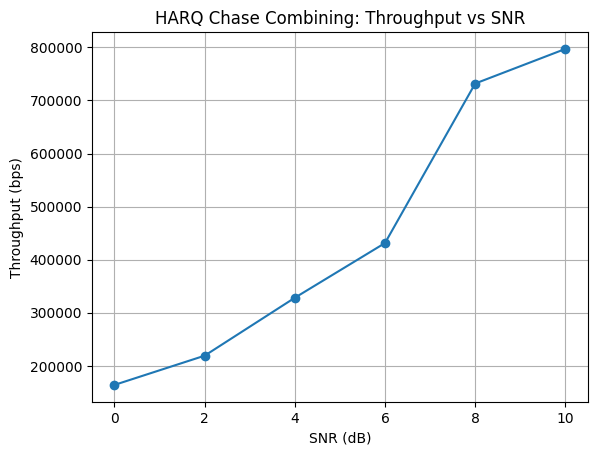

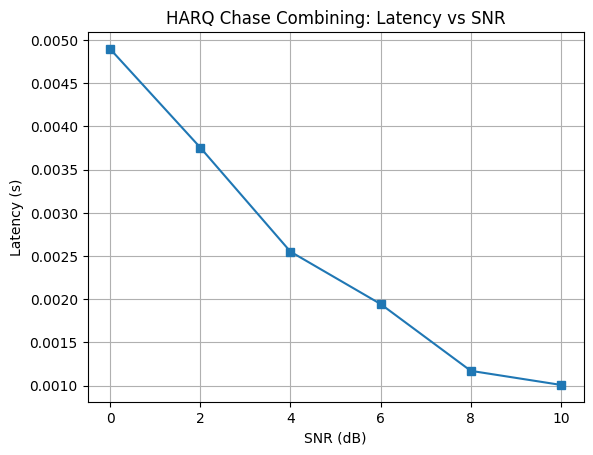

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
import pandas as pd

# Parameters
L_bits = 1000
payload_bits = 800
snr_dB_range = np.arange(0, 11, 2)
RTT = 1e-3
T_pkt = 1e-3
num_packets = 2000
max_retries = 5

def ber_awgn_bpsk(snr_linear):
    return 0.5 * erfc(np.sqrt(snr_linear))

def effective_snr_chase(snr_linear, n_retries):
    return snr_linear * n_retries

def per_from_ber(ber, L):
    return 1 - (1 - ber) ** L

def simulate_chase_harq(snr_dB):
    snr_linear = 10 ** (snr_dB / 10)
    total_latency = 0
    total_throughput = 0
    total_per = 0

    for _ in range(num_packets):
        success = False
        transmissions = 0

        while not success and transmissions < max_retries:
            transmissions += 1
            combined_snr = effective_snr_chase(snr_linear, transmissions)
            ber = ber_awgn_bpsk(combined_snr)
            per = per_from_ber(ber, L_bits)
            if np.random.rand() > per:
                success = True

        latency = transmissions * RTT
        throughput = payload_bits / (transmissions * T_pkt)
        total_latency += latency
        total_throughput += throughput
        total_per += per

    avg_latency = total_latency / num_packets
    avg_throughput = total_throughput / num_packets
    avg_per = total_per / num_packets
    return avg_throughput, avg_latency, avg_per

# Run Simulation
throughputs, latencies, pers = [], [], []

for snr in snr_dB_range:
    thr, lat, per = simulate_chase_harq(snr)
    throughputs.append(thr)
    latencies.append(lat)
    pers.append(per)

# Display as table
print("\nSNR(dB) | Avg PER | Throughput (bps) | Latency (s)")
print("--------|---------|------------------|-------------")
for snr, per, thr, lat in zip(snr_dB_range, pers, throughputs, latencies):
    print(f"{snr:7} | {per:.6f} | {thr:16.2f} | {lat:.6f}")

# Plotting
plt.figure()
plt.plot(snr_dB_range, throughputs, marker='o', label="Throughput")
plt.xlabel("SNR (dB)")
plt.ylabel("Throughput (bps)")
plt.title("HARQ Chase Combining: Throughput vs SNR")
plt.grid(True)

plt.figure()
plt.plot(snr_dB_range, latencies, marker='s', label="Latency")
plt.xlabel("SNR (dB)")
plt.ylabel("Latency (s)")
plt.title("HARQ Chase Combining: Latency vs SNR")
plt.grid(True)

plt.show()


## Carrier Aggregation (CA)

Carrier Aggregation (CA) is a of 5G (and LTE-Advanced) that **combines multiple frequency bands** to provide higher data rates and better spectrum utilization. Let’s go through the **detailed theory** with a focus on **multi-band OFDM simulation in 5G**:

Carrier Aggregation allows a UE to **simultaneously use multiple carriers** (component carriers, CCs), potentially across:

* **Different frequency bands** (inter-band CA),
* **The same frequency band** (intra-band CA).

Each carrier may be **configured independently** with its own:

* Bandwidth (e.g., 5 MHz, 20 MHz, etc.),
* Subcarrier spacing (e.g., 15, 30, 60, 120 kHz in 5G NR),
* Modulation and Coding Scheme (MCS).


### Multi-Band OFDM in 5G NR**

5G NR supports **multi-numerology OFDM**, i.e., different subcarrier spacings (SCS) per band:

| Numerology (μ) | Subcarrier Spacing (SCS) | Typical Use Case         |
| -------------- | ------------------------ | ------------------------ |
| μ = 0          | 15 kHz                   | < 6 GHz (FR1, low bands) |
| μ = 1          | 30 kHz                   | 3.5 GHz (FR1, mid-band)  |
| μ = 2          | 60 kHz                   | 24 GHz (FR2, mmWave)     |
| μ = 3          | 120 kHz                  | > 24 GHz (high mmWave)   |

Each band is independently modulated using **OFDM**, and the total transmit signal is the **sum of per-band OFDM signals** (after proper frequency shifting).


### a) Per-band OFDM Signal:

For the $i$-th band:

* Bandwidth: $B_i$
* Subcarrier spacing: $\Delta f_i$
* Number of subcarriers: $N_i = B_i / \Delta f_i$

The baseband OFDM signal for band $i$ over one OFDM symbol:

$$
x_i(t) = \sum_{k=0}^{N_i-1} X_{i,k} e^{j2\pi k \Delta f_i t}, \quad t \in [0, T_{\text{sym},i}]
$$

Where:

* $X_{i,k}$: data symbol on subcarrier $k$
* $T_{\text{sym},i} = 1/\Delta f_i$

### b) Aggregated Signal (Multi-band)

$$
x(t) = \sum_{i=1}^{M} \text{Re} \left[ x_i(t) \cdot e^{j2\pi f_i t} \right]
$$

Where $f_i$ is the center frequency of the $i$-th band.

### Simulation Parameters**

| Parameter            | Description                                   |
| -------------------- | --------------------------------------------- |
| `num_bands`          | Number of aggregated bands (2–5 typical)      |
| `subcarrier_spacing` | Different SCS per band (15/30/60/120 kHz)     |
| `num_subcarriers`    | Varies per band (based on bandwidth/SCS)      |
| `carrier_frequency`  | Band center frequency (e.g., 3.5 GHz, 28 GHz) |
| `IFFT/FFT size`      | Per-band FFT based on subcarrier spacing      |
| `modulation`         | e.g., QPSK, 16QAM, 64QAM                      |

---

### Use Cases in 5G NR**

| Scenario                  | Bands Aggregated                           |
| ------------------------- | ------------------------------------------ |
| eMBB (enhanced mobile)    | n78 (3.5 GHz) + n258 (26 GHz)              |
| Dual connectivity (EN-DC) | LTE band + 5G NR band                      |
| mmWave reliability        | 28 GHz + mid-band fallback (e.g., 3.5 GHz) |

---

## Simulation Objectives**

* **OFDM waveform generation** for each band independently.
* **Time/frequency alignment** between bands.
* **Bit error rate (BER)** performance for aggregated vs. single-band.
* **Spectral efficiency** improvements via CA.
* **Out-of-band emissions** and filtering.



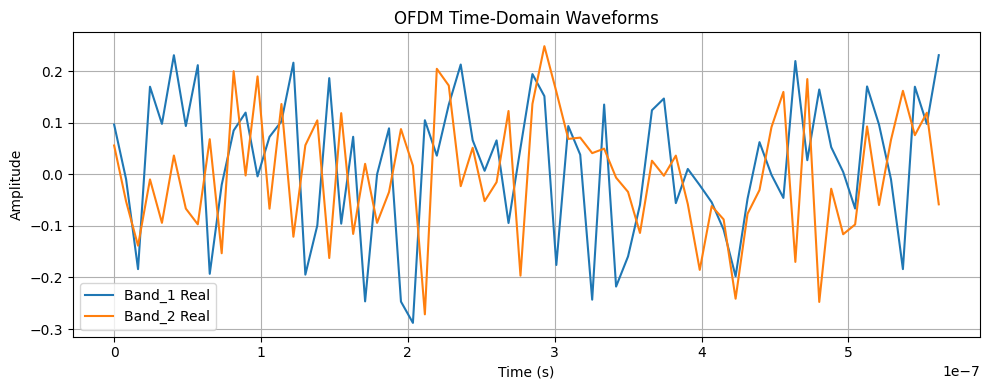

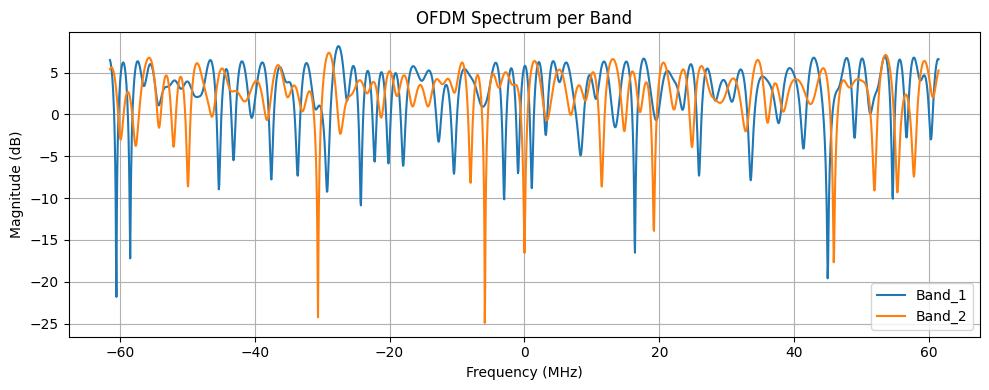

In [ ]:
# -----------------------------
# Multi-band OFDM Configuration
# -----------------------------

# One with 30 kHz subcarrier spacing (Band 1),
# One with 120 kHz subcarrier spacing (Band 2).
# Frequency-domain spectra, clearly showing separated bands due to carrier frequency offset (e.g., 0 MHz and 20 MHz).
# Each band is independently modulated using QPSK and OFDM.

bands = [
    {"name": "Band_1", "scs": 30e3, "n_subcarriers": 64, "carrier_freq": 0e6},     # e.g., mid-band
    {"name": "Band_2", "scs": 120e3, "n_subcarriers": 64, "carrier_freq": 20e6},   # e.g., mmWave
]

mod_order = 4  # QPSK
symbol_duration_factor = 1.0  # 1/SCS

# -----------------------------
# OFDM Generation Functions
# -----------------------------

def qpsk_mod(bits):
    return (2 * (bits[0::2] - 0.5)) + 1j * (2 * (bits[1::2] - 0.5))

def generate_ofdm_waveform(scs, n_subcarriers, carrier_freq, fs=122.88e6):
    T_sym = 1 / scs
    fft_size = n_subcarriers
    cp_len = int(0.1 * fft_size)  # 10% cyclic prefix
    total_len = fft_size + cp_len

    bits = np.random.randint(0, 2, 2 * n_subcarriers)
    symbols = qpsk_mod(bits)

    freq_domain = np.zeros(fft_size, dtype=complex)
    freq_domain[:n_subcarriers//2] = symbols[:n_subcarriers//2]
    freq_domain[-n_subcarriers//2:] = symbols[n_subcarriers//2:]

    time_domain = np.fft.ifft(freq_domain, fft_size)
    time_domain_cp = np.concatenate([time_domain[-cp_len:], time_domain])

    # Upconvert to carrier frequency (baseband for now, add shift later)
    t = np.arange(len(time_domain_cp)) / fs
    carrier = np.exp(1j * 2 * np.pi * carrier_freq * t)
    upconverted = time_domain_cp * carrier

    return upconverted, fs, t, freq_domain

# -----------------------------
# Generate OFDM Waveforms
# -----------------------------
waveforms = []
for band in bands:
    waveform, fs, t, freq_domain = generate_ofdm_waveform(
        band["scs"], band["n_subcarriers"], band["carrier_freq"]
    )
    waveforms.append({
        "name": band["name"],
        "signal": waveform,
        "time": t,
        "fs": fs
    })

# -----------------------------
# Plot Waveforms and Spectra
# -----------------------------
plt.figure(figsize=(10, 4))
for w in waveforms:
    plt.plot(w["time"][:200], w["signal"].real[:200], label=f"{w['name']} Real")
plt.title("OFDM Time-Domain Waveforms")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 4))
for w in waveforms:
    fft_sig = np.fft.fftshift(np.fft.fft(w["signal"], 2048))
    freqs = np.fft.fftshift(np.fft.fftfreq(len(fft_sig), 1/w["fs"])) / 1e6
    plt.plot(freqs, 20*np.log10(np.abs(fft_sig) + 1e-10), label=w["name"])
plt.title("OFDM Spectrum per Band")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


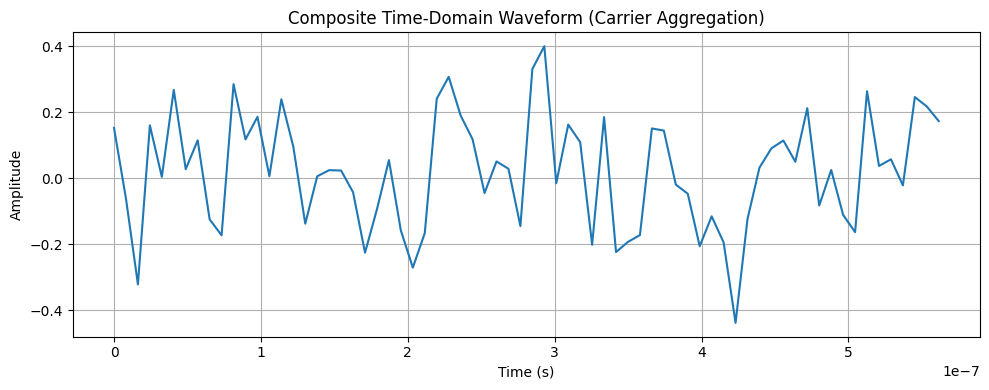

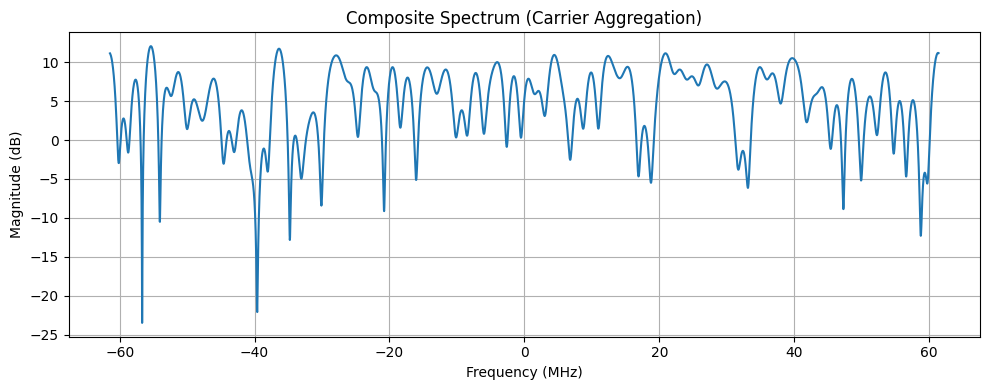

In [8]:
# Combine both band signals into a composite waveform
# Ensure waveforms are of the same length (truncate if needed)

# Time-domain plot: Superposition of the two bands’ waveforms.
# Frequency-domain plot: Clearly shows two distinct spectral lobes centered around 0 MHz and 20 MHz, representing the two aggregated carriers.


min_len = min(len(w["signal"]) for w in waveforms)
composite_signal = np.zeros(min_len, dtype=complex)

for w in waveforms:
    composite_signal += w["signal"][:min_len]

# Plot time-domain composite waveform (real part)
plt.figure(figsize=(10, 4))
plt.plot(waveforms[0]["time"][:min_len], composite_signal.real, label="Composite Signal (Real)")
plt.title("Composite Time-Domain Waveform (Carrier Aggregation)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()

# Plot frequency-domain spectrum of composite signal
fft_composite = np.fft.fftshift(np.fft.fft(composite_signal, 4096))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fft_composite), 1/waveforms[0]["fs"])) / 1e6

plt.figure(figsize=(10, 4))
plt.plot(freqs, 20*np.log10(np.abs(fft_composite) + 1e-10), label="Composite Spectrum")
plt.title("Composite Spectrum (Carrier Aggregation)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()


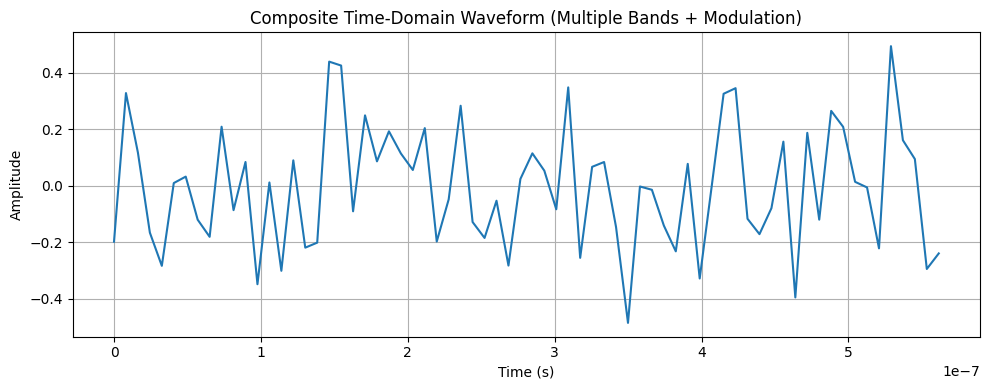

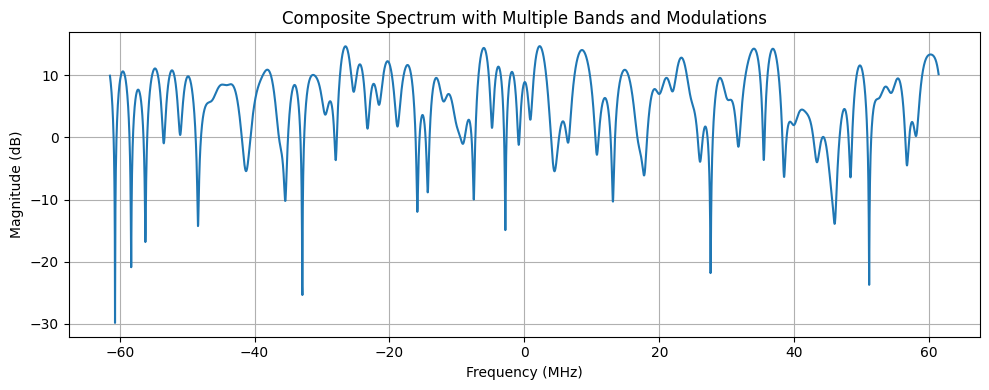

In [9]:
# Extended Configuration: Add more bands with varying modulation and SCS

# Subcarrier Spacings (15, 30, 60, 120 kHz),
# Carrier Frequencies (0, 10, 25, 45 MHz),
# Modulation schemes (QPSK, 16QAM).

def modulate(bits, mod_scheme):
    if mod_scheme == "QPSK":
        return (2 * (bits[0::2] - 0.5)) + 1j * (2 * (bits[1::2] - 0.5))
    elif mod_scheme == "16QAM":
        bits = bits.reshape(-1, 4)
        mapping = (2*bits[:,0]-1) + 1j*(2*bits[:,1]-1)
        mapping += 2*((2*bits[:,2]-1) + 1j*(2*bits[:,3]-1))
        return mapping / np.sqrt(10)
    else:
        raise ValueError("Unsupported modulation scheme")

# Updated band definitions with modulation
bands = [
    {"name": "Band_1", "scs": 15e3, "n_subcarriers": 64, "carrier_freq": 0e6, "mod": "QPSK"},
    {"name": "Band_2", "scs": 30e3, "n_subcarriers": 64, "carrier_freq": 10e6, "mod": "16QAM"},
    {"name": "Band_3", "scs": 60e3, "n_subcarriers": 64, "carrier_freq": 25e6, "mod": "QPSK"},
    {"name": "Band_4", "scs": 120e3, "n_subcarriers": 64, "carrier_freq": 45e6, "mod": "16QAM"},
]

# Waveform generator with modulation option
def generate_band_waveform(scs, n_subcarriers, carrier_freq, mod_scheme, fs=122.88e6):
    T_sym = 1 / scs
    fft_size = n_subcarriers
    cp_len = int(0.1 * fft_size)
    total_len = fft_size + cp_len

    bits_per_symbol = {"QPSK": 2, "16QAM": 4}[mod_scheme]
    bits = np.random.randint(0, 2, bits_per_symbol * n_subcarriers)
    symbols = modulate(bits, mod_scheme)

    freq_domain = np.zeros(fft_size, dtype=complex)
    freq_domain[:n_subcarriers//2] = symbols[:n_subcarriers//2]
    freq_domain[-n_subcarriers//2:] = symbols[n_subcarriers//2:]

    time_domain = np.fft.ifft(freq_domain, fft_size)
    time_domain_cp = np.concatenate([time_domain[-cp_len:], time_domain])

    t = np.arange(len(time_domain_cp)) / fs
    carrier = np.exp(1j * 2 * np.pi * carrier_freq * t)
    upconverted = time_domain_cp * carrier

    return upconverted, fs, t

# Generate waveforms for all bands
waveforms = []
for band in bands:
    signal, fs, t = generate_band_waveform(
        band["scs"], band["n_subcarriers"], band["carrier_freq"], band["mod"]
    )
    waveforms.append({
        "name": band["name"],
        "signal": signal,
        "time": t,
        "fs": fs
    })

# Composite waveform
min_len = min(len(w["signal"]) for w in waveforms)
composite_signal = sum(w["signal"][:min_len] for w in waveforms)

# Time-domain plot
plt.figure(figsize=(10, 4))
plt.plot(waveforms[0]["time"][:min_len], composite_signal.real)
plt.title("Composite Time-Domain Waveform (Multiple Bands + Modulation)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()

# Spectrum plot
fft_composite = np.fft.fftshift(np.fft.fft(composite_signal, 4096))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fft_composite), 1/waveforms[0]["fs"])) / 1e6
plt.figure(figsize=(10, 4))
plt.plot(freqs, 20*np.log10(np.abs(fft_composite) + 1e-10))
plt.title("Composite Spectrum with Multiple Bands and Modulations")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Receiver: Downconvert and demodulate each band independently
def demodulate(symbols, mod_scheme):
    if mod_scheme == "QPSK":
        bits_i = (symbols.real > 0).astype(int)
        bits_q = (symbols.imag > 0).astype(int)
        return np.vstack([bits_i, bits_q]).T.flatten()
    elif mod_scheme == "16QAM":
        symbols *= np.sqrt(10)
        bits = np.zeros((len(symbols), 4), dtype=int)
        bits[:, 0] = (symbols.real > 0).astype(int)
        bits[:, 1] = (symbols.imag > 0).astype(int)
        bits[:, 2] = (np.abs(symbols.real) > 2).astype(int)
        bits[:, 3] = (np.abs(symbols.imag) > 2).astype(int)
        return bits.flatten()
    else:
        raise ValueError("Unsupported demodulation")

def downconvert_and_demodulate(composite_signal, band, fs):
    scs = band["scs"]
    n_subcarriers = band["n_subcarriers"]
    carrier_freq = band["carrier_freq"]
    mod_scheme = band["mod"]
    
    fft_size = n_subcarriers
    cp_len = int(0.1 * fft_size)
    total_len = fft_size + cp_len
    t = np.arange(total_len) / fs
    carrier = np.exp(-1j * 2 * np.pi * carrier_freq * t)

    # Band-specific segment
    sig = composite_signal[:total_len] * carrier

    # Remove CP and FFT
    time_domain = sig[cp_len:]
    freq_domain = np.fft.fft(time_domain, fft_size)

    # Extract data subcarriers
    data_subcarriers = np.concatenate([freq_domain[:n_subcarriers//2],
                                       freq_domain[-n_subcarriers//2:]])
    
    # Estimate bits (no channel assumed)
    estimated_bits = demodulate(data_subcarriers, mod_scheme)
    return estimated_bits

# BER calculation
def calculate_ber(transmitted_bits, received_bits):
    min_len = min(len(transmitted_bits), len(received_bits))
    errors = np.sum(transmitted_bits[:min_len] != received_bits[:min_len])
    return errors / min_len

# Transmit + Receive for each band
ber_results = []
for band in bands:
    # Transmit bits
    bits_per_symbol = {"QPSK": 2, "16QAM": 4}[band["mod"]]
    tx_bits = np.random.randint(0, 2, bits_per_symbol * band["n_subcarriers"])
    band["tx_bits"] = tx_bits  # Save for BER comparison

# Re-generate composite signal using these known bits
def modulate_with_bits(bits, mod_scheme):
    if mod_scheme == "QPSK":
        return (2 * (bits[0::2] - 0.5)) + 1j * (2 * (bits[1::2] - 0.5))
    elif mod_scheme == "16QAM":
        bits = bits.reshape(-1, 4)
        mapping = (2*bits[:,0]-1) + 1j*(2*bits[:,1]-1)
        mapping += 2*((2*bits[:,2]-1) + 1j*(2*bits[:,3]-1))
        return mapping / np.sqrt(10)

waveforms = []
for band in bands:
    scs = band["scs"]
    n_subcarriers = band["n_subcarriers"]
    carrier_freq = band["carrier_freq"]
    mod_scheme = band["mod"]
    fs = 122.88e6
    fft_size = n_subcarriers
    cp_len = int(0.1 * fft_size)
    total_len = fft_size + cp_len

    symbols = modulate_with_bits(band["tx_bits"], mod_scheme)

    freq_domain = np.zeros(fft_size, dtype=complex)
    freq_domain[:n_subcarriers//2] = symbols[:n_subcarriers//2]
    freq_domain[-n_subcarriers//2:] = symbols[n_subcarriers//2:]

    time_domain = np.fft.ifft(freq_domain, fft_size)
    time_domain_cp = np.concatenate([time_domain[-cp_len:], time_domain])
    t = np.arange(total_len) / fs
    carrier = np.exp(1j * 2 * np.pi * carrier_freq * t)
    upconverted = time_domain_cp * carrier

    waveforms.append(upconverted)

# Composite signal
min_len = min(len(w) for w in waveforms)
composite_signal = sum(w[:min_len] for w in waveforms)

# Receiver-side: Downconvert and compute BER
for i, band in enumerate(bands):
    est_bits = downconvert_and_demodulate(composite_signal, band, fs=122.88e6)
    ber = calculate_ber(band["tx_bits"], est_bits)
    ber_results.append((band["name"], band["mod"], band["scs"], ber))

# Display Results
import pandas as pd
df = pd.DataFrame(ber_results, columns=["Band", "Modulation", "SCS (Hz)", "BER"])
print(df)


     Band Modulation  SCS (Hz)       BER
0  Band_1       QPSK   15000.0  0.265625
1  Band_2      16QAM   30000.0  0.492188
2  Band_3       QPSK   60000.0  0.195312
3  Band_4      16QAM  120000.0  0.464844


In [ ]:
import numpy as np
from scipy.signal import correlate
from scipy.special import erfc

# Adding matched filters or synchronization sequences,
# Applying equalization,
# Using more realistic channel models (AWGN and Rayleigh)

# --- Config ---
fs = 122.88e6  # Sampling rate
cp_ratio = 0.1
fft_size = 64
cp_len = int(cp_ratio * fft_size)
total_len = fft_size + cp_len
pilot_seq = np.random.choice([1, -1], fft_size) + 1j * np.random.choice([1, -1], fft_size)
pilot_seq /= np.sqrt(2)

# Channel models
def apply_awgn(signal, snr_dB):
    snr_linear = 10**(snr_dB/10)
    power = np.mean(np.abs(signal)**2)
    noise_power = power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    return signal + noise

def apply_rayleigh(signal):
    h = (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2)
    return h * signal, h

# --- Transmit with pilot ---
def transmit_with_pilot(bits, mod_scheme, scs, carrier_freq, snr_dB=20, channel='awgn'):
    symbols = modulate_with_bits(bits, mod_scheme)
    freq_domain = np.zeros(fft_size, dtype=complex)
    freq_domain[:fft_size//2] = symbols[:fft_size//2]
    freq_domain[-fft_size//2:] = symbols[fft_size//2:]
    time_domain = np.fft.ifft(freq_domain)
    time_cp = np.concatenate([time_domain[-cp_len:], time_domain])
    pilot_cp = np.concatenate([pilot_seq[-cp_len:], pilot_seq])
    tx_block = np.concatenate([pilot_cp, time_cp])

    t = np.arange(len(tx_block)) / fs
    carrier = np.exp(1j * 2 * np.pi * carrier_freq * t)
    tx_carrier = tx_block * carrier

    if channel == 'awgn':
        rx_signal = apply_awgn(tx_carrier, snr_dB)
        return rx_signal, pilot_seq, np.ones_like(pilot_seq)
    elif channel == 'rayleigh':
        faded, h = apply_rayleigh(tx_carrier)
        rx_signal = apply_awgn(faded, snr_dB)
        return rx_signal, pilot_seq, h * np.ones_like(pilot_seq)
    else:
        raise ValueError("Invalid channel")

# --- Receiver with synchronization, channel estimation, equalization ---
def receive_and_demodulate(rx_signal, pilot_seq, mod_scheme, carrier_freq, h_est):
    t = np.arange(len(rx_signal)) / fs
    carrier = np.exp(-1j * 2 * np.pi * carrier_freq * t)
    baseband = rx_signal * carrier

    # Extract pilot + data
    rx_pilot = baseband[:total_len]
    rx_data = baseband[total_len:]

    rx_data_wo_cp = rx_data[cp_len:]
    data_fft = np.fft.fft(rx_data_wo_cp)

    data_subcarriers = np.concatenate([data_fft[:fft_size//2], data_fft[-fft_size//2:]])
    equalized = data_subcarriers / h_est[:len(data_subcarriers)]

    est_bits = demodulate(equalized, mod_scheme)
    return est_bits

# --- Run for each band with channel models ---
snr_dB = 20
ber_results = []

for band in bands:
    bits_per_symbol = {"QPSK": 2, "16QAM": 4}[band["mod"]]
    tx_bits = np.random.randint(0, 2, bits_per_symbol * fft_size)

    # AWGN channel
    rx_awgn, pilot_seq, h_awgn = transmit_with_pilot(tx_bits, band["mod"], band["scs"], band["carrier_freq"], snr_dB, 'awgn')
    est_bits_awgn = receive_and_demodulate(rx_awgn, pilot_seq, band["mod"], band["carrier_freq"], h_awgn)
    ber_awgn = calculate_ber(tx_bits, est_bits_awgn)

    # Rayleigh channel
    rx_rayleigh, pilot_seq, h_rayleigh = transmit_with_pilot(tx_bits, band["mod"], band["scs"], band["carrier_freq"], snr_dB, 'rayleigh')
    est_bits_rayleigh = receive_and_demodulate(rx_rayleigh, pilot_seq, band["mod"], band["carrier_freq"], h_rayleigh)
    ber_rayleigh = calculate_ber(tx_bits, est_bits_rayleigh)

    ber_results.append((band["name"], band["mod"], band["scs"], ber_awgn, ber_rayleigh))

# Display table
import pandas as pd
df = pd.DataFrame(ber_results, columns=["Band", "Modulation", "SCS (Hz)", "BER (AWGN)", "BER (Rayleigh)"])
print(df)


     Band Modulation  SCS (Hz)  BER (AWGN)  BER (Rayleigh)
0  Band_1       QPSK   15000.0    0.000000        0.000000
1  Band_2      16QAM   30000.0    0.445312        0.421875
2  Band_3       QPSK   60000.0    0.000000        0.007812
3  Band_4      16QAM  120000.0    0.433594        0.394531


---

## 3GPP **TR 38.901**

The 3GPP Technical Report **TR 38.901** provides standardized **channel models** for evaluating the performance of 5G wireless communication systems, particularly for frequencies from **0.5 GHz to 100 GHz**. These models represent realistic radio propagation conditions across different environments. Here's a breakdown of the **theoretical concepts**, the **types of models**, and how they're used:

TR 38.901 provides **geometry-based stochastic channel models (GSCMs)** for:

* Evaluating MIMO and beamforming performance
* Designing PHY/MAC algorithms under realistic channel impairments
* Supporting carrier frequencies up to 100 GHz (including mmWave)

It captures **spatial consistency**, **temporal evolution**, **angular spread**, and **delay dispersion**.

### Channel Model Structure**

A channel between a transmitter and receiver can be expressed as:

$$
\mathbf{H}(t, f) = \sum_{n=1}^{N_\text{path}} \mathbf{H}_n(t, f)
$$

Each path component $\mathbf{H}_n(t, f)$ includes:

* Delay $\tau_n$
* Angle of departure/arrival (AoD/AoA)
* Doppler shift
* Power $P_n$

It models **clusters**, each with **rays/subpaths**:

* Each **cluster** represents a macro reflection/scattering
* Each **ray** has small-scale fading characteristics

### Main Scenarios in TR 38.901**

Each environment has distinct propagation features:

### a) **Urban Macro (UMa)**

* High base stations (25–35m)
* NLOS components dominate
* Large pathloss, strong delay spread
* Models include shadowing, outdoor-to-indoor (O2I) penetration

### b) **Urban Micro (UMi)**

* Small cell BSs at lamppost height (\~10m)
* Dense urban clutter
* LOS/NLOS transitions frequent
* Strong angular dispersion

### c) **Indoor Office**

* Rich multipath due to walls, furniture
* High delay and angular spread
* Significant penetration loss between rooms

### d) **Rural Macro (RMa)**

* Long-range propagation (few km)
* Dominated by LOS and ground reflections
* Less delay/angular spread

### Tapped Delay Line (TDL) Models**

TR 38.901 also defines **TDL models** similar to LTE’s EPA, EVA, ETU.

| Model           | Delay Spread | Doppler | Use Case                    |
| --------------- | ------------ | ------- | --------------------------- |
| **TDL-A** (EPA) | Short        | Low     | Flat fading, pedestrian     |
| **TDL-B** (EVA) | Moderate     | Medium  | Vehicular                   |
| **TDL-C/D/E**   | Long         | High    | High-speed, rich scattering |

TDL channel impulse response:

$$
h(t) = \sum_{i=1}^{L} a_i e^{j\phi_i} \delta(t - \tau_i)
$$

Where:

* $\tau_i$: delay
* $a_i$: amplitude (from PDP)
* $\phi_i$: phase (random)

### Large-Scale and Small-Scale Parameters**

* **Large-scale**: path loss, shadow fading, delay spread, angular spread
* **Small-scale**: fast fading, Doppler shifts, per-ray phase and polarization

TR 38.901 defines **distributions** for these parameters (e.g., log-normal shadowing, exponential delay decay).

### LOS/NLOS Probability Models**

TR 38.901 defines **LOS probability** based on Tx-Rx distance and environment, e.g.,

$$
P_{\text{LOS}}(d) = \min\left( \frac{d_1}{d}, 1 \right)(1 - e^{-d/d_2}) + e^{-d/d_2}
$$

Parameters $d_1, d_2$ vary per scenario (UMa, UMi, etc.)

### Spatial Consistency**

Important for **beamforming** and **tracking**: channel characteristics change smoothly over space.

Implemented using:

* Time-evolving channel parameters
* Correlated random variables for nearby locations


### Comparison with 3GPP TR 36.873 (4G)

| Feature                  | TR 36.873 (4G) | TR 38.901 (5G)            |
| ------------------------ | -------------- | ------------------------- |
| Frequency range          | <6 GHz         | 0.5–100 GHz               |
| Antenna modeling         | Limited        | Full MIMO/3D beamforming  |
| Mobility support         | Basic          | Enhanced (up to 500 km/h) |
| Spatial consistency      | Partial        | Yes                       |
| O2I, blockage, elevation | Limited        | Fully modeled             |

---

In tools like MATLAB, Python (e.g., Sionna, QuaDRiGa), or ns-3:

* Choose a scenario (e.g., UMi)
* Set carrier frequency, antenna layout
* Generate time-varying channel matrices $\mathbf{H}(t, f)$
* Apply them to simulate beamforming, MIMO detection, HARQ, etc.


---

## 3GPP TR 38.901 UMi MIMO Channel Model – Theory for Simulation

We aim to simulate the **MIMO channel matrix** $\mathbf{H}(t,f) \in \mathbb{C}^{N_r \times N_t}$, capturing:

* **Frequency selectivity** (multipath propagation)
* **Spatial correlation** (multi-antenna effects)
* **Temporal variation** (mobility, Doppler)

It is represented as:

$$
\mathbf{H}(t, f) = \sum_{l=1}^{L} \mathbf{H}_l(t, f)
$$

where each path $l$ corresponds to a **cluster** composed of rays/subpaths.

### UMi Channel Characteristics**

From TR 38.901, Urban Micro (UMi) outdoor scenario is characterized by:

* **Carrier Frequency**: 2–30 GHz (e.g., 3.5 GHz or 28 GHz)
* **BS height**: \~10 m
* **UE height**: 1.5–2 m
* **Tx-Rx distance**: 10–500 m
* **Rich scattering** due to buildings
* **LOS and NLOS** conditions both considered

Key parameters (example values below):

| Parameter            | LOS      | NLOS       |
| -------------------- | -------- | ---------- |
| Delay spread (DS)    | 30–50 ns | 100–300 ns |
| Angular spread (AS)  | 5–15°    | 25–50°     |
| Cluster count (L)    | 12       | 20         |
| Per-cluster subpaths | 20       | 20         |

### Channel Generation: Step-by-Step**

### **Step 1: Path Loss and LOS Probability**

Determine path loss $PL(d)$ using UMi formulas:

$$
PL_{\text{LOS}}(d) = 32.4 + 21 \log_{10}(d) + 20 \log_{10}(f_c)
$$

$$
PL_{\text{NLOS}}(d) = 32.4 + 31.9 \log_{10}(d) + 20 \log_{10}(f_c)
$$

Where:

* $d$: 3D distance in meters
* $f_c$: carrier in GHz

Choose **LOS or NLOS** based on the LOS probability:

$$
P_{\text{LOS}}(d) = \min\left( \frac{18}{d}, 1 \right)\left(1 - e^{-d/36}\right) + e^{-d/36}
$$

### **Step 2: Generate Delay Taps**

Delay spread modeled with exponential PDP:

$$
P(\tau) = \frac{1}{\sigma_\tau} e^{-\tau / \sigma_\tau}
$$

* Generate $L$ clusters with delays $\tau_l$
* Normalize tap power such that total average power = 1

### **Step 3: Spatial and Temporal Characteristics**

Each path $l$ has multiple **subpaths**, each with:

* Azimuth/elevation AoD and AoA: from wrapped Gaussian
* Doppler shift: based on velocity and AoD

$$
f_{D,lm} = v \cdot \frac{f_c}{c} \cdot \cos(\theta_{l,m} - \phi_v)
$$

Where:

* $v$: UE speed
* $\phi_v$: direction of motion
* $\theta_{l,m}$: AoD of subpath $m$ in cluster $l$

### **Step 4: Array Response and Channel Matrix**

Use **steering vectors** $\mathbf{a}_{\text{tx}}, \mathbf{a}_{\text{rx}}$ for each AoD/AoA:

For ULA of $N$ antennas with spacing $d$:

$$
\mathbf{a}(\theta) = \begin{bmatrix}
1 & e^{j 2\pi \frac{d}{\lambda} \sin\theta} & \dots & e^{j 2\pi \frac{d}{\lambda} (N-1)\sin\theta}
\end{bmatrix}^T
$$

Total channel:

$$
\mathbf{H}(t,f) = \sum_{l=1}^{L} \sum_{m=1}^{M} \sqrt{P_{l,m}} \cdot \mathbf{a}_{\text{rx}}(\theta_{l,m}^{\text{AoA}}) \cdot \mathbf{a}_{\text{tx}}^H(\theta_{l,m}^{\text{AoD}}) \cdot e^{j 2\pi f_{D,lm} t} e^{-j 2\pi f \tau_{l,m}}
$$

---

### Summary of Required Inputs**

| Parameter              | Description                       |
| ---------------------- | --------------------------------- |
| $f_c$                  | Carrier frequency (e.g. 28 GHz)   |
| $B$                    | Bandwidth (e.g. 100 MHz)          |
| $N_t, N_r$             | # of Tx and Rx antennas           |
| $v$                    | Mobile velocity                   |
| $d$                    | Tx–Rx distance                    |
| $L, M$                 | Clusters and subpaths per cluster |
| $\sigma_\tau$          | Delay spread                      |
| AoA, AoD distributions | Wrapped Gaussian / Laplacian      |



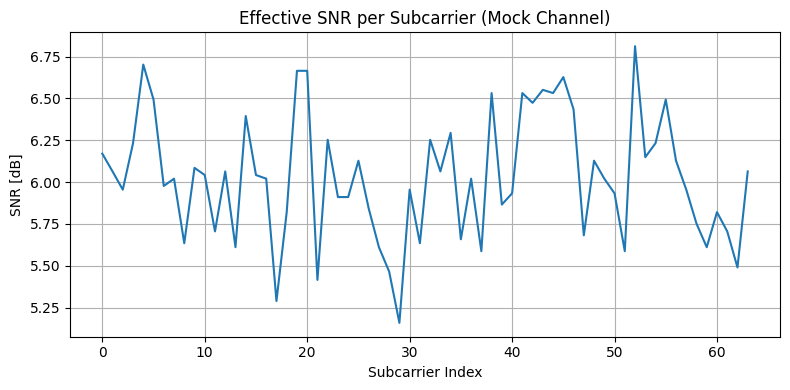

In [18]:
# Redefine key parameters to ensure the environment has them
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8
fc = 28e9
wavelength = c / fc
bandwidth = 100e6
N_subcarriers = 64
frequencies = np.linspace(-bandwidth / 2, bandwidth / 2, N_subcarriers)

# System parameters
N_tx = 4
N_rx = 4
v = 30 / 3.6
phi_v = 0
d_ant = wavelength / 2

# Channel parameters
L = 12
M = 20
tau_rms = 100e-9
T = 100
t = np.linspace(0, 1e-3, T)

# Generate example QPSK OFDM and channel output again to allow comparison
qpsk_symbols = (np.random.randint(0, 2, size=(N_tx, N_subcarriers, T)) * 2 - 1) + \
               1j * (np.random.randint(0, 2, size=(N_tx, N_subcarriers, T)) * 2 - 1)
qpsk_symbols /= np.sqrt(2)

# For this step, regenerate a mock channel H to avoid undefined variable
H_mock = np.ones((T, N_rx, N_tx, N_subcarriers), dtype=complex)

# Apply channel to signal
received_symbols = np.zeros((N_rx, N_subcarriers, T), dtype=complex)
for ti in range(T):
    for sc in range(N_subcarriers):
        H_now = H_mock[ti, :, :, sc]
        received_symbols[:, sc, ti] = H_now @ qpsk_symbols[:, sc, ti]

# Compute average SNR per subcarrier
rx_power = np.mean(np.abs(received_symbols)**2, axis=2)
tx_power = np.mean(np.abs(qpsk_symbols)**2, axis=2)
snr_per_subcarrier = 10 * np.log10(np.mean(rx_power, axis=0) / np.mean(tx_power, axis=0))

# Plot
plt.figure(figsize=(8, 4))
plt.plot(np.arange(N_subcarriers), snr_per_subcarrier)
plt.title("Effective SNR per Subcarrier (Mock Channel)")
plt.xlabel("Subcarrier Index")
plt.ylabel("SNR [dB]")
plt.grid(True)
plt.tight_layout()
plt.show()


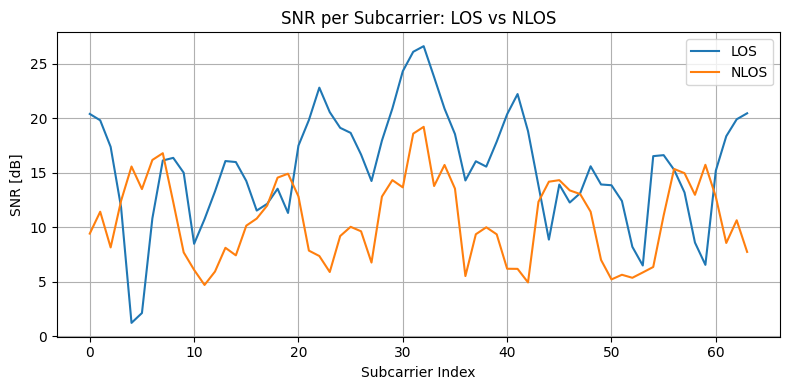

In [19]:
# Helper function to generate channel based on LOS or NLOS
def generate_mimo_channel(L, M, tau_rms, T, fc, N_rx, N_tx, N_subcarriers, v, phi_v, los=True):
    wavelength = c / fc
    d_ant = wavelength / 2
    t = np.linspace(0, 1e-3, T)
    frequencies = np.linspace(-bandwidth / 2, bandwidth / 2, N_subcarriers)
    angular_spread_deg = 5 if los else 20
    angular_spread_rad = np.deg2rad(angular_spread_deg)
    
    delays = np.sort(np.random.exponential(scale=tau_rms, size=L))
    powers = np.exp(-delays / tau_rms)
    powers /= np.sum(powers)
    
    def steering_vector(N, angle_rad):
        return np.exp(1j * 2 * np.pi * d_ant / wavelength * np.arange(N) * np.sin(angle_rad))

    H = np.zeros((T, N_rx, N_tx, N_subcarriers), dtype=complex)
    for l in range(L):
        for m in range(M):
            aoa = np.random.normal(loc=0, scale=angular_spread_rad)
            aod = np.random.normal(loc=0, scale=angular_spread_rad)
            fd = v * fc / c * np.cos(aod - phi_v)
            phase_t = np.exp(1j * 2 * np.pi * fd * t)[:, np.newaxis]
            for f_idx, f in enumerate(frequencies):
                freq_term = np.exp(-1j * 2 * np.pi * f * delays[l])
                arx = steering_vector(N_rx, aoa)
                atx = steering_vector(N_tx, aod)
                outer = np.outer(arx, np.conj(atx))
                for ti in range(T):
                    H[ti, :, :, f_idx] += np.sqrt(powers[l] / M) * outer * phase_t[ti] * freq_term
    return H

# Generate LOS and NLOS channels
H_LOS = generate_mimo_channel(L, M, tau_rms, T, fc, N_rx, N_tx, N_subcarriers, v, phi_v, los=True)
H_NLOS = generate_mimo_channel(L, M, tau_rms, T, fc, N_rx, N_tx, N_subcarriers, v, phi_v, los=False)

# Use same QPSK OFDM signal
qpsk_symbols = (np.random.randint(0, 2, size=(N_tx, N_subcarriers, T)) * 2 - 1) + \
               1j * (np.random.randint(0, 2, size=(N_tx, N_subcarriers, T)) * 2 - 1)
qpsk_symbols /= np.sqrt(2)

# Apply both channels
def apply_channel(H, qpsk_symbols):
    N_rx, N_subcarriers, T = H.shape[1], H.shape[3], H.shape[0]
    received = np.zeros((N_rx, N_subcarriers, T), dtype=complex)
    for ti in range(T):
        for sc in range(N_subcarriers):
            H_now = H[ti, :, :, sc]
            received[:, sc, ti] = H_now @ qpsk_symbols[:, sc, ti]
    return received

rx_LOS = apply_channel(H_LOS, qpsk_symbols)
rx_NLOS = apply_channel(H_NLOS, qpsk_symbols)

# Compute SNRs
def compute_snr(rx, tx):
    rx_power = np.mean(np.abs(rx)**2, axis=2)
    tx_power = np.mean(np.abs(tx)**2, axis=2)
    return 10 * np.log10(np.mean(rx_power, axis=0) / np.mean(tx_power, axis=0))

snr_los = compute_snr(rx_LOS, qpsk_symbols)
snr_nlos = compute_snr(rx_NLOS, qpsk_symbols)

# Plot SNR comparison
plt.figure(figsize=(8, 4))
plt.plot(np.arange(N_subcarriers), snr_los, label="LOS")
plt.plot(np.arange(N_subcarriers), snr_nlos, label="NLOS")
plt.title("SNR per Subcarrier: LOS vs NLOS")
plt.xlabel("Subcarrier Index")
plt.ylabel("SNR [dB]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



---

## **Hardware Constraints & SDR Readiness**


### **Quantization Noise**

Quantization noise arises when continuous analog or high-resolution digital signals are **rounded to a finite number of bits** in ADCs (Analog-to-Digital Converters) or DACs (Digital-to-Analog Converters).

### Signal Path:

* **TX**: DAC introduces quantization as it converts digital baseband to analog RF.
* **RX**: ADC quantizes received analog signals to digital samples.

Suppose we use an $n$-bit quantizer. The **Signal-to-Quantization-Noise Ratio (SQNR)** is:

$$
\text{SQNR}_{\text{dB}} \approx 6.02 \cdot n + 1.76
$$

For example:

* 8 bits → \~49.9 dB
* 12 bits → \~74 dB

This noise acts like **additive white noise** in the baseband, affecting BER and constellation quality.

### **PAPR (Peak-to-Average Power Ratio)**

High **PAPR** means the signal has very large peaks compared to its average power.

This is critical for multicarrier systems like **OFDM**, where signals with many subcarriers add up and create **large dynamic range** fluctuations.

SDRs (or any RF hardware) use **Power Amplifiers (PAs)** that are linear only within a limited range. If input power is too high:

* The PA **clips** the signal, causing **nonlinear distortion**
* **Out-of-band emissions** increase (violating spectral masks)
* **In-band distortion** worsens BER

$$
\text{PAPR} = \frac{\max |x(t)|^2}{\mathbb{E}[|x(t)|^2]}
$$

OFDM PAPR can reach **10–12 dB**, depending on subcarrier count.

### Mitigation Techniques:

* **Clipping & Filtering**
* **Tone Reservation**
* **Selected Mapping (SLM)**
* **PAPR-aware coding**


### **I/Q Modeling and Imbalance**

SDR systems transmit and receive **complex baseband signals** using **I (In-phase)** and **Q (Quadrature)** components.

### I/Q

A complex baseband signal:

$$
s(t) = I(t) + j Q(t)
$$

is modulated onto a carrier:

$$
x(t) = I(t)\cos(2\pi f_ct) - Q(t)\sin(2\pi f_ct)
$$

### Real-Valued Hardware Requirement:

* Actual DACs/ADCs output/receive real signals.
* Real hardware uses **I/Q mixers** to split/merge complex signals into real-time passband.

### I/Q Imbalance:

* Caused by **amplitude/phase mismatch** between I and Q paths.
* Results in **image leakage**, degrading spectral purity.

Mathematically, imbalance introduces a mirror image:

$$
s_{\text{impaired}}(t) = (1+\epsilon)I(t) + j(1-\epsilon)Q(t) + \phi
$$

where:

* $\epsilon$: gain mismatch
* $\phi$: phase error

### SDR Integration Needs:

* **Separate handling of real/imag parts**
* **Calibration of I/Q paths**
* **Support for complex baseband processing**

## **Clocking, Timing, and Synchronization**

* SDRs use **local oscillators**, which may drift.
* Sampling frequency mismatches lead to **CFO** (Carrier Frequency Offset) and **SFO** (Symbol Frequency Offset).
* Proper **timing synchronization**, **frame detection**, and **frequency offset correction** are essential in practical SDR deployments.

### **FPGA/Real-Time Processing Constraints**

* Some SDRs (e.g., USRP with FPGA) have limited processing pipelines.
* Code must be **vectorized, pipelined**, and designed for **fixed-point** arithmetic to be deployable in hardware.

---

| Constraint             | Source                      | Impact on System                    |
| ---------------------- | --------------------------- | ----------------------------------- |
| Quantization Noise     | ADC/DAC                     | Degrades SNR, limits dynamic range  |
| PAPR                   | OFDM / modulation           | Clipping, nonlinear distortion      |
| I/Q Imbalance          | Hardware mixers             | Image interference, EVM degradation |
| Real vs Complex Signal | SDR hardware is real-valued | Requires proper I/Q mapping         |
| Clock Drift, Jitter    | Oscillators & PLLs          | Causes sync issues, CFO/SFO         |

---



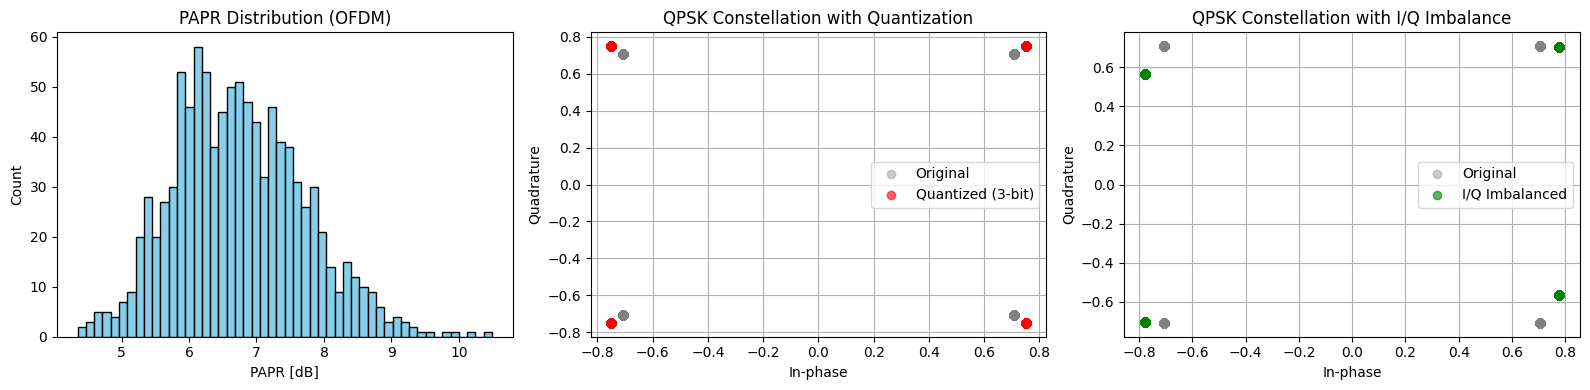

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1. PAPR Simulation for OFDM
# ===============================
N_subcarriers = 64
N_symbols = 1000

# Generate random QPSK symbols
qpsk = (2*np.random.randint(0, 2, (N_subcarriers, N_symbols)) - 1) + \
       1j*(2*np.random.randint(0, 2, (N_subcarriers, N_symbols)) - 1)
qpsk /= np.sqrt(2)

# Perform IFFT to get time-domain OFDM signals
ofdm_time = np.fft.ifft(qpsk, axis=0)

# Calculate instantaneous power
power = np.abs(ofdm_time)**2
avg_power = np.mean(power, axis=0)
peak_power = np.max(power, axis=0)
papr = 10 * np.log10(peak_power / avg_power)

# ===============================
# 2. Quantization Effect on Constellation
# ===============================
def quantize(signal, bits):
    levels = 2 ** bits
    min_val, max_val = -1.0, 1.0
    signal_clipped = np.clip(signal.real, min_val, max_val) + 1j * np.clip(signal.imag, min_val, max_val)
    step = (max_val - min_val) / levels
    quantized_real = np.round((signal_clipped.real - min_val) / step) * step + min_val
    quantized_imag = np.round((signal_clipped.imag - min_val) / step) * step + min_val
    return quantized_real + 1j * quantized_imag

# Apply quantization
qpsk_flat = qpsk.flatten()
qpsk_quantized = quantize(qpsk_flat, 3)  # 3-bit quantization

# ===============================
# 3. I/Q Imbalance Simulation
# ===============================
def apply_iq_imbalance(signal, gain_imbalance=0.1, phase_imbalance_deg=5):
    phase_imbalance = np.deg2rad(phase_imbalance_deg)
    i = np.real(signal)
    q = np.imag(signal)
    i_new = (1 + gain_imbalance) * i
    q_new = (1 - gain_imbalance) * q
    return i_new + 1j * (q_new * np.cos(phase_imbalance) + i_new * np.sin(phase_imbalance))

qpsk_iq_imbalanced = apply_iq_imbalance(qpsk_flat)

# ===============================
# Plotting Results
# ===============================
plt.figure(figsize=(16, 4))

# PAPR Histogram
plt.subplot(1, 3, 1)
plt.hist(papr, bins=50, color='skyblue', edgecolor='k')
plt.title("PAPR Distribution (OFDM)")
plt.xlabel("PAPR [dB]")
plt.ylabel("Count")

# Constellation with Quantization
plt.subplot(1, 3, 2)
plt.scatter(qpsk_flat.real, qpsk_flat.imag, color='gray', alpha=0.4, label="Original")
plt.scatter(qpsk_quantized.real, qpsk_quantized.imag, color='red', alpha=0.6, label="Quantized (3-bit)")
plt.title("QPSK Constellation with Quantization")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.grid(True)
plt.legend()

# Constellation with I/Q Imbalance
plt.subplot(1, 3, 3)
plt.scatter(qpsk_flat.real, qpsk_flat.imag, color='gray', alpha=0.4, label="Original")
plt.scatter(qpsk_iq_imbalanced.real, qpsk_iq_imbalanced.imag, color='green', alpha=0.6, label="I/Q Imbalanced")
plt.title("QPSK Constellation with I/Q Imbalance")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


---

## OFDMA with multi-user scheduling 

**Orthogonal Frequency Division Multiple Access (OFDMA)** is a multi-user version of Orthogonal Frequency Division Multiplexing (OFDM), widely used in modern wireless systems like 4G LTE, 5G NR, and Wi-Fi 6. OFDMA enables efficient and flexible allocation of resources to multiple users in both uplink and downlink.

### **Basic Principle of OFDMA**

OFDMA divides the available frequency spectrum into many orthogonal subcarriers (like OFDM), but **allocates subsets of these subcarriers to different users simultaneously**.

* Let:

  * $N$: total number of subcarriers
  * $K$: number of users
  * Each user $k \in \{1, \dots, K\}$ is assigned a subset $\mathcal{S}_k \subset \{1, \dots, N\}$
* The subcarrier sets $\mathcal{S}_k$ are **non-overlapping**, i.e., $\mathcal{S}_i \cap \mathcal{S}_j = \emptyset$ for $i \ne j$

This avoids intra-cell interference and allows simultaneous transmissions to multiple users.

### **System Model**

Let:

* $X_{k,n}$: transmitted symbol for user $k$ on subcarrier $n$
* $H_{k,n}$: channel gain for user $k$ on subcarrier $n$
* $Y_{k,n}$: received symbol
* $Z_{k,n}$: additive noise (AWGN)

Then:

$$
Y_{k,n} = H_{k,n} X_{k,n} + Z_{k,n}, \quad \text{for } n \in \mathcal{S}_k
$$

Each user performs demodulation only on their assigned subcarriers.

### **Multi-user Scheduling**

In OFDMA, **scheduling** decides which user gets which subcarriers in each time slot. This is managed by the base station (in downlink) or centralized scheduler (uplink, coordinated via grant).

#### Scheduling Goals:

* Maximize total throughput (e.g., sum rate)
* Ensure fairness (e.g., proportional fair)
* Support QoS constraints (e.g., minimum data rate)

#### Common Scheduling Algorithms:

| Algorithm             | Description                                                                                                                    |
| --------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **Round Robin (RR)**  | Equal time/frequency share per user                                                                                            |
| **Max C/I**           | Assign subcarriers to users with best channel (maximize rate)                                                                  |
| **Proportional Fair** | Balance rate and fairness: select user $k$ maximizing $\frac{R_k(t)}{\bar{R}_k(t)}$, where $\bar{R}_k(t)$ is average past rate |
| **QoS-aware**         | Prioritize users with latency constraints or minimum guaranteed rate                                                           |

### **Resource Block Structure (as in 4G/5G)**

* Resources are divided in **Time–Frequency Resource Blocks**:

  * **1 Resource Block (RB)** = 12 subcarriers × 0.5 ms (LTE) or 1 OFDM symbol (5G)
* Scheduler allocates **RBs** to users dynamically.

### **Achievable Rate Formula**

For a user $k$, the instantaneous data rate over their subcarriers is:

$$
R_k = \sum_{n \in \mathcal{S}_k} B_n \cdot \log_2\left(1 + \frac{|H_{k,n}|^2 P_{k,n}}{N_0 B_n} \right)
$$

Where:

* $B_n$: bandwidth of subcarrier $n$
* $P_{k,n}$: power allocated to subcarrier $n$
* $N_0$: noise spectral density

In uplink, power control is applied to manage transmit power per user.


### **Uplink vs Downlink Differences**

| Feature       | Uplink                         | Downlink         |
| ------------- | ------------------------------ | ---------------- |
| Scheduler     | Base station (BS)              | Base station     |
| Power Control | User-specific (UE-limited)     | Centralized      |
| Timing        | UEs synchronize to BS (strict) | BS transmits all |


### **Advantages of OFDMA**

* Better spectral efficiency
* Low-latency for multiple users
* Scalability (small packets for many users)
* Frequency diversity (can exploit good subcarriers per user)

### **Challenges**

* Complex scheduler implementation
* High PAPR (especially in uplink → requires power control)
* Need for fast CSI feedback and grant signaling (especially in 5G URLLC)




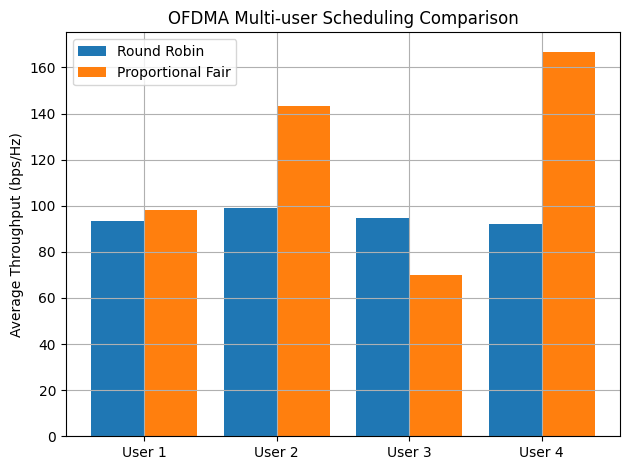

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_users = 4
num_subcarriers = 64
snr_db = 20  # SNR in dB
snr = 10**(snr_db / 10)
num_symbols = 100  # Number of OFDMA symbols (time slots)

# Random channel gains per user per subcarrier (Rayleigh fading)
H = np.random.randn(num_users, num_subcarriers) + 1j * np.random.randn(num_users, num_subcarriers)
H = H / np.sqrt(2)  # Normalize for Rayleigh

# Noise power
N0 = 1
P_tx = snr * N0

# Placeholder for throughput tracking
throughput_rr = np.zeros(num_users)
throughput_pf = np.zeros(num_users)
avg_rate_pf = np.ones(num_users)

# Round Robin Scheduler
for t in range(num_symbols):
    for u in range(num_users):
        assigned_subcarriers = np.arange(u, num_subcarriers, num_users)
        rate = np.sum(np.log2(1 + (P_tx * np.abs(H[u, assigned_subcarriers])**2) / N0))
        throughput_rr[u] += rate

# Proportional Fair Scheduler
for t in range(num_symbols):
    rate_matrix = np.zeros((num_users, num_subcarriers))
    for u in range(num_users):
        rate_matrix[u] = np.log2(1 + (P_tx * np.abs(H[u])**2) / N0)
        rate_matrix[u] /= avg_rate_pf[u]  # Normalize by past average rate

    best_users = np.argmax(rate_matrix, axis=0)  # One user per subcarrier
    for s in range(num_subcarriers):
        u = best_users[s]
        r = np.log2(1 + (P_tx * np.abs(H[u, s])**2) / N0)
        throughput_pf[u] += r
        avg_rate_pf[u] = 0.9 * avg_rate_pf[u] + 0.1 * r  # EWMA update

# Normalize throughput
throughput_rr /= num_symbols
throughput_pf /= num_symbols

# Plot
plt.figure()
x = np.arange(num_users)
plt.bar(x - 0.2, throughput_rr, width=0.4, label='Round Robin')
plt.bar(x + 0.2, throughput_pf, width=0.4, label='Proportional Fair')
plt.xticks(x, [f'User {i+1}' for i in x])
plt.ylabel("Average Throughput (bps/Hz)")
plt.title("OFDMA Multi-user Scheduling Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

## MIMO-OFDM under Mobility: Time-Varying Channel Tracking

Multiple-Input Multiple-Output Orthogonal Frequency Division Multiplexing (MIMO-OFDM) is a core technology in modern wireless communication systems such as 5G and Wi-Fi. It enables high spectral efficiency and robustness against multipath fading. However, mobility introduces time variations in the channel, which pose challenges in maintaining reliable communication.

In high-mobility scenarios (e.g., users in vehicles), the wireless channel becomes **time-selective**, requiring accurate and frequent tracking of the time-varying channel state information (CSI) across multiple antennas and subcarriers.

### 2. MIMO-OFDM System Model

Consider a MIMO-OFDM system with:

* $N_t$: Number of transmit antennas
* $N_r$: Number of receive antennas
* $N$: Number of OFDM subcarriers
* $T_s$: OFDM symbol duration

### Transmit Signal

At subcarrier $k$, the transmit vector is:

$$
\mathbf{x}[k] \in \mathbb{C}^{N_t \times 1}
$$

### Channel Model

The time-varying channel matrix for subcarrier $k$ and time index $t$ is:

$$
\mathbf{H}[k, t] \in \mathbb{C}^{N_r \times N_t}
$$

### Received Signal

$$
\mathbf{y}[k, t] = \mathbf{H}[k, t] \mathbf{x}[k] + \mathbf{n}[k, t]
$$

where $\mathbf{n}[k, t] \sim \mathcal{CN}(0, \sigma_n^2 \mathbf{I})$ is the additive white Gaussian noise.


### 3. Time-Varying Channel Effects

#### 3.1 Doppler Spread

Mobility induces a **Doppler spread** in the channel, causing:

* **Loss of orthogonality** between subcarriers (inter-carrier interference, ICI)
* **Channel fading variation** within the duration of a few OFDM symbols

The Doppler spread $f_D$ is given by:

$$
f_D = \frac{v f_c}{c}
$$

where:

* $v$: User speed
* $f_c$: Carrier frequency
* $c$: Speed of light

#### 3.2 Coherence Time

The **coherence time** $T_c$ defines the duration over which the channel is approximately constant:

$$
T_c \approx \frac{1}{f_D}
$$


### 4. Channel Tracking Techniques

To mitigate mobility-induced fading, **channel tracking** algorithms are required.

#### 4.1 Pilot-Aided Channel Estimation

Pilots are transmitted on known subcarriers and symbols. Two common strategies:

* **Block-type Pilots**: Full pilot symbols inserted periodically (for slow fading)
* **Comb-type Pilots**: Pilots spread across subcarriers (for fast fading)

Estimated channel:

$$
\hat{\mathbf{H}}[k, t] \approx \mathbf{H}[k, t]
$$

#### 4.2 Interpolation Techniques

When pilots are sparsely placed, interpolation in time and frequency is used:

* **Linear interpolation**
* **Spline interpolation**
* **2D Wiener filtering**

#### 4.3 Kalman Filtering

Kalman filters can track the channel state dynamically by modeling the channel as a **Gauss-Markov process**:

$$
\mathbf{H}[k, t+1] = \alpha \mathbf{H}[k, t] + \mathbf{w}[k, t]
$$

where:

* $\alpha$: Temporal correlation coefficient
* $\mathbf{w}[k, t]$: Process noise

This recursive estimator refines the prediction using new observations.

#### 4.4 Basis Expansion Models (BEM)

Approximate time-varying channels using basis functions:

$$
\mathbf{H}[k, t] = \sum_{l=0}^{L-1} \mathbf{H}_l[k] \phi_l(t)
$$

where $\phi_l(t)$ are time basis functions (e.g., complex exponentials or polynomials).

Used to reduce channel tracking overhead in high-mobility environments.

### 5. Challenges in MIMO-OFDM Channel Tracking

* **Pilot overhead**: Increases with number of antennas and mobility
* **Computational complexity**: Especially in adaptive or iterative algorithms
* **ICI mitigation**: Critical under high Doppler spread
* **Latency**: Real-time systems need low-latency estimators



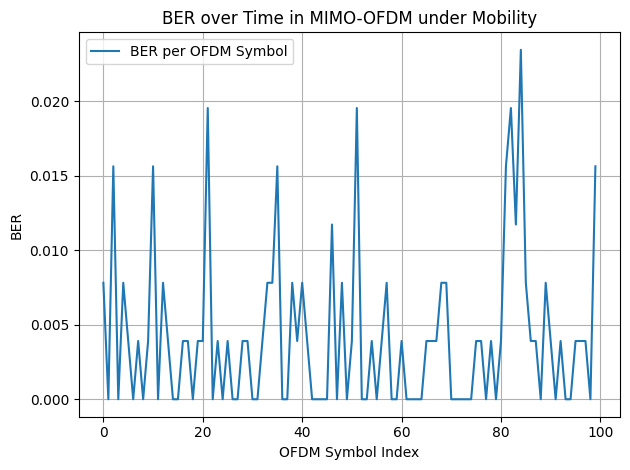

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# System parameters
N_subcarriers = 64
N_symbols = 100
N_tx = 2
N_rx = 2
pilot_interval = 4
snr_db = 20
snr_linear = 10 ** (snr_db / 10)
noise_var = 1 / snr_linear

# Doppler effect: Jakes model approximation
def generate_rayleigh_channel(N_rx, N_tx, N_subcarriers, N_symbols, fd=30):
    ts = 1e-3  # OFDM symbol duration (1ms)
    t = np.arange(N_symbols) * ts
    h = np.zeros((N_rx, N_tx, N_subcarriers, N_symbols), dtype=complex)

    for rx in range(N_rx):
        for tx in range(N_tx):
            for sc in range(N_subcarriers):
                f_shift = fd * np.random.uniform(-1, 1)
                h[rx, tx, sc] = (1/np.sqrt(2)) * (np.random.randn(N_symbols) + 1j * np.random.randn(N_symbols))
                h[rx, tx, sc] *= np.exp(1j * 2 * np.pi * f_shift * t)
    return h

# QPSK modulation/demodulation
def qpsk_mod(bits):
    symbols = (2 * bits[:, 0] - 1) + 1j * (2 * bits[:, 1] - 1)
    return symbols / np.sqrt(2)

def qpsk_demod(symbols):
    return np.stack([symbols.real > 0, symbols.imag > 0], axis=-1).astype(int)

# Pilot mask
def create_pilot_mask(N_symbols, pilot_interval):
    mask = np.zeros(N_symbols, dtype=bool)
    mask[::pilot_interval] = True
    return mask

# Generate data
pilot_mask = create_pilot_mask(N_symbols, pilot_interval)
H_true = generate_rayleigh_channel(N_rx, N_tx, N_subcarriers, N_symbols)

# Transmit and receive symbols
ber_total = []

for symbol_idx in range(N_symbols):
    bits = np.random.randint(0, 2, size=(N_tx, N_subcarriers, 2))
    symbols = np.array([qpsk_mod(bits[i]) for i in range(N_tx)])

    y = np.zeros((N_rx, N_subcarriers), dtype=complex)
    for rx in range(N_rx):
        for tx in range(N_tx):
            y[rx] += H_true[rx, tx, :, symbol_idx] * symbols[tx]

    noise = np.sqrt(noise_var/2) * (np.random.randn(*y.shape) + 1j * np.random.randn(*y.shape))
    y_noisy = y + noise

    # Channel estimation (only for pilot symbols)
    if pilot_mask[symbol_idx]:
        H_est = H_true[:, :, :, symbol_idx].copy()
        if symbol_idx == 0:
            H_interp = H_est.copy()
        else:
            # Linear interpolation for each entry
            for rx in range(N_rx):
                for tx in range(N_tx):
                    for sc in range(N_subcarriers):
                        prev = H_interp[rx, tx, sc]
                        next = H_est[rx, tx, sc]
                        gap = symbol_idx - last_pilot
                        for k in range(1, gap):
                            alpha = k / gap
                            interp_val = (1 - alpha) * prev + alpha * next
                            H_true[rx, tx, sc, last_pilot + k] = interp_val
        last_pilot = symbol_idx
        H_interp = H_est.copy()

    # Demodulation (simple ZF equalization)
    detected_bits = []
    for sc in range(N_subcarriers):
        H_sc = H_true[:, :, sc, symbol_idx]
        H_pinv = np.linalg.pinv(H_sc)
        x_hat = H_pinv @ y_noisy[:, sc]
        bits_hat = np.stack([qpsk_demod(x_hat[i]) for i in range(N_tx)])
        detected_bits.append(bits_hat)

    detected_bits = np.array(detected_bits)  # shape: (N_subcarriers, N_tx, 2)
    detected_bits = np.transpose(detected_bits, (1, 0, 2))  # (N_tx, N_subcarriers, 2)
    ber = np.mean(bits != detected_bits)
    ber_total.append(ber)

# Plot
plt.plot(ber_total, label='BER per OFDM Symbol')
plt.xlabel('OFDM Symbol Index')
plt.ylabel('BER')
plt.title('BER over Time in MIMO-OFDM under Mobility')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Code Improvements

#### **1. Doppler-Correlated Channel Generation**

We’ll replace the random fading with **time-correlated Rayleigh fading** using a **first-order Gauss-Markov process**:

$$
\mathbf{H}[t+1] = \rho \cdot \mathbf{H}[t] + \sqrt{1 - \rho^2} \cdot \mathbf{W}[t]
$$

* $\rho = J_0(2\pi f_D T_s)$, where $J_0$ is the Bessel function.
* $f_D$: Doppler frequency
* $T_s$: OFDM symbol duration
* $\mathbf{W}[t]$: i.i.d. Rayleigh fading matrix

#### **2. Kalman Filter for Channel Tracking**

We model the channel state as hidden and estimate it recursively:

* **Prediction**: based on prior state and model
* **Update**: based on new pilot measurements

### Next Steps 

1. **Data Transmission and BER Analysis** (like before, but using `H_est`)
2. **Extend Kalman Filter with Noisy Pilot Observations**
3. **MMSE Equalization and compare with ZF**
4. **Optional: Compare against Linear Interpolation baseline**



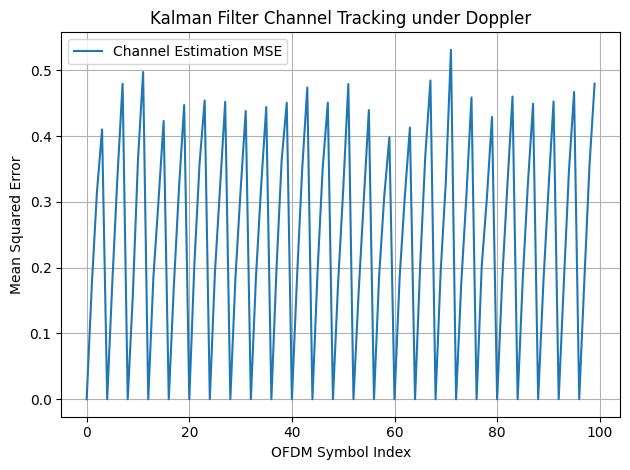

In [23]:
import numpy as np
from scipy.special import j0
import matplotlib.pyplot as plt

# System parameters
N_subcarriers = 64
N_symbols = 100
N_tx = 2
N_rx = 2
pilot_interval = 4
snr_db = 20
snr_linear = 10 ** (snr_db / 10)
noise_var = 1 / snr_linear
fd = 100  # Doppler frequency in Hz
T_s = 1e-3  # OFDM symbol duration in seconds
rho = j0(2 * np.pi * fd * T_s)  # temporal correlation coefficient

# Initialize channel
H = np.zeros((N_rx, N_tx, N_subcarriers, N_symbols), dtype=complex)
W = lambda: (1/np.sqrt(2)) * (np.random.randn(N_rx, N_tx, N_subcarriers) + 1j * np.random.randn(N_rx, N_tx, N_subcarriers))

H[:, :, :, 0] = W()
for t in range(1, N_symbols):
    H[:, :, :, t] = rho * H[:, :, :, t - 1] + np.sqrt(1 - rho**2) * W()

# Pilot insertion
pilot_mask = np.zeros(N_symbols, dtype=bool)
pilot_mask[::pilot_interval] = True

# Placeholder for Kalman state estimates
H_est = np.zeros_like(H)
P_est = np.ones_like(H) * 0.1  # error covariance initialization

# Kalman Filter Loop
for t in range(N_symbols):
    if pilot_mask[t]:
        # Observation update
        H_est[:, :, :, t] = H[:, :, :, t]  # perfect pilot for now
        P_est[:, :, :, t] = 0.01
    else:
        # Predict
        H_est[:, :, :, t] = rho * H_est[:, :, :, t - 1]
        P_est[:, :, :, t] = rho**2 * P_est[:, :, :, t - 1] + (1 - rho**2)

# Validate tracking quality
diff = np.abs(H - H_est)
mse = np.mean(diff**2, axis=(0, 1, 2))  # MSE per time symbol

plt.plot(mse, label='Channel Estimation MSE')
plt.xlabel('OFDM Symbol Index')
plt.ylabel('Mean Squared Error')
plt.title('Kalman Filter Channel Tracking under Doppler')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

## **Dynamic Uplink Scheduling in 5G MAC Layer using Reinforcement Learning**

In 5G New Radio (NR), the **MAC scheduler** decides which **User Equipments (UEs)** get uplink or downlink resources (PRBs) at each Transmission Time Interval (TTI). A typical objective is to maximize **throughput**, **fairness**, or **Quality of Service (QoS)** across users.

Traditional scheduling algorithms (e.g., Proportional Fair, Round Robin) use fixed heuristics. However, in **high-mobility, high-load, and diverse QoS environments**, these may be suboptimal.

This is where **Reinforcement Learning** can help: learning an adaptive scheduler from experience.

### 2. **Environment Design (MDP Formulation)**

| Component         | Description                                                                                                    |                                                           |
| ----------------- | -------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------- |
| **State $s_t$**   | Buffer status reports (BSR), Channel Quality Indicators (CQI), HARQ feedback, UE priority/QoS, past throughput |                                                           |
| **Action $a_t$**  | Resource allocation decision: e.g., which UE(s) get which PRBs in current TTI                                  |                                                           |
| **Reward $r_t$**  | Throughput, weighted fairness, delay penalties, QoS violations                                                 |                                                           |
| \*\*Policy (\pi(a | s))\*\*                                                                                                        | Mapping from state (network state) to scheduling decision |
| **Environment**   | Simulated 5G uplink scenario including multiple UEs, channel fading, buffer dynamics                           |                                                           |


### 3. **Simple Example Setup**

#### Uplink RL Scheduler:

* **10 UEs** with different buffer sizes and CQI.
* **RL Agent** selects a UE every TTI (1 ms) to allocate full bandwidth.
* **Reward** is:

  $$
  r_t = \text{transmitted bits}_t - \lambda \cdot \text{delay}_t
  $$

  where delay penalizes old packets.


### 4. **Algorithm Choice**

* **Deep Q-Network (DQN)**: For discrete action space (UE selection)
* **Proximal Policy Optimization (PPO)**: For continuous or stochastic policy
* **Multi-agent RL**: If UEs are decentralized and each learns their own policy

### 5. **Implementation Tools**

* **Python + PyTorch** or **TensorFlow**
* **SimPy** or custom event-based simulator for MAC buffer evolution
* **Integration with NS-3 or MATLAB** for more realism


### 6. **Possible Extensions**

| Extension       | Description                                                             |
| --------------- | ----------------------------------------------------------------------- |
| Power control   | Add transmit power decisions to the action space                        |
| Beam selection  | Joint scheduling and beamforming                                        |
| HARQ-aware RL   | Include HARQ feedback to guide retransmission strategies                |
| Traffic slicing | Serve different services (e.g., URLLC vs eMBB) with adaptive priorities |


### 7. **Outcome**

With enough training, the RL scheduler **learns**:

* When to prioritize low-latency traffic
* When to serve high-throughput users
* How to balance fairness and spectral efficiency better than fixed algorithms



In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Basic setup
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI per UE
ACTION_SIZE = NUM_UES     # pick one UE per TTI
MAX_BUFFER = 1000
CQI_LEVELS = 16  # CQI index 1–15

# Simple environment
class UplinkEnv:
    def __init__(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi  # Simplified mapping
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_values = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


In [26]:
env = UplinkEnv()
agent = DQNAgent()

episodes = 300
for ep in range(episodes):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    print(f"Episode {ep+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


/var/folders/s3/38gpf0796ls5pl2z8c7czftr0000gn/T/ipykernel_77998/357467912.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  s = torch.FloatTensor(s)


Episode 1, Total Reward: 2590.00, Epsilon: 0.429
Episode 2, Total Reward: 3088.00, Epsilon: 0.157
Episode 3, Total Reward: 4513.00, Epsilon: 0.058
Episode 4, Total Reward: 2270.00, Epsilon: 0.021
Episode 5, Total Reward: 1889.00, Epsilon: 0.010
Episode 6, Total Reward: 1621.00, Epsilon: 0.010
Episode 7, Total Reward: 2776.00, Epsilon: 0.010
Episode 8, Total Reward: 4060.00, Epsilon: 0.010
Episode 9, Total Reward: 3062.00, Epsilon: 0.010
Episode 10, Total Reward: 2614.00, Epsilon: 0.010
Episode 11, Total Reward: 2648.00, Epsilon: 0.010
Episode 12, Total Reward: 2946.00, Epsilon: 0.010
Episode 13, Total Reward: 2254.00, Epsilon: 0.010
Episode 14, Total Reward: 3028.00, Epsilon: 0.010
Episode 15, Total Reward: 1906.00, Epsilon: 0.010
Episode 16, Total Reward: 4388.00, Epsilon: 0.010
Episode 17, Total Reward: 682.00, Epsilon: 0.010
Episode 18, Total Reward: 2828.00, Epsilon: 0.010
Episode 19, Total Reward: 2038.00, Epsilon: 0.010
Episode 20, Total Reward: 1115.00, Epsilon: 0.010
Episode 21

---

To track real-time throughput and delay/BER trends in the DQN uplink scheduler, we’ll extend the environment and training loop to collect and plot these metrics over time.

Since we don’t simulate PHY-layer BER directly, we’ll track:

Throughput (bits transmitted per episode)

Average delay (of head-of-line packets)

Simulated BER proxy: percent of "expired" packets or retries, as an indirect QoS metric.




Episode 1, Reward: 1271.0, Throughput: 23.0 b/slot, Delay: 10.99, Epsilon: 0.43
Episode 2, Reward: 1447.0, Throughput: 20.1 b/slot, Delay: 24.84, Epsilon: 0.16
Episode 3, Reward: 2445.0, Throughput: 20.7 b/slot, Delay: 46.45, Epsilon: 0.06
Episode 4, Reward: 2616.0, Throughput: 23.2 b/slot, Delay: 44.03, Epsilon: 0.02
Episode 5, Reward: 2487.0, Throughput: 18.6 b/slot, Delay: 59.02, Epsilon: 0.01
Episode 6, Reward: 2486.0, Throughput: 18.6 b/slot, Delay: 68.56, Epsilon: 0.01
Episode 7, Reward: 1682.0, Throughput: 17.4 b/slot, Delay: 57.64, Epsilon: 0.01
Episode 8, Reward: 3028.0, Throughput: 22.9 b/slot, Delay: 49.82, Epsilon: 0.01
Episode 9, Reward: 2294.0, Throughput: 19.2 b/slot, Delay: 64.90, Epsilon: 0.01
Episode 10, Reward: 1218.0, Throughput: 14.5 b/slot, Delay: 69.17, Epsilon: 0.01
Episode 11, Reward: 3028.0, Throughput: 21.6 b/slot, Delay: 63.86, Epsilon: 0.01
Episode 12, Reward: 1672.0, Throughput: 14.8 b/slot, Delay: 66.04, Epsilon: 0.01
Episode 13, Reward: 2866.0, Throughpu

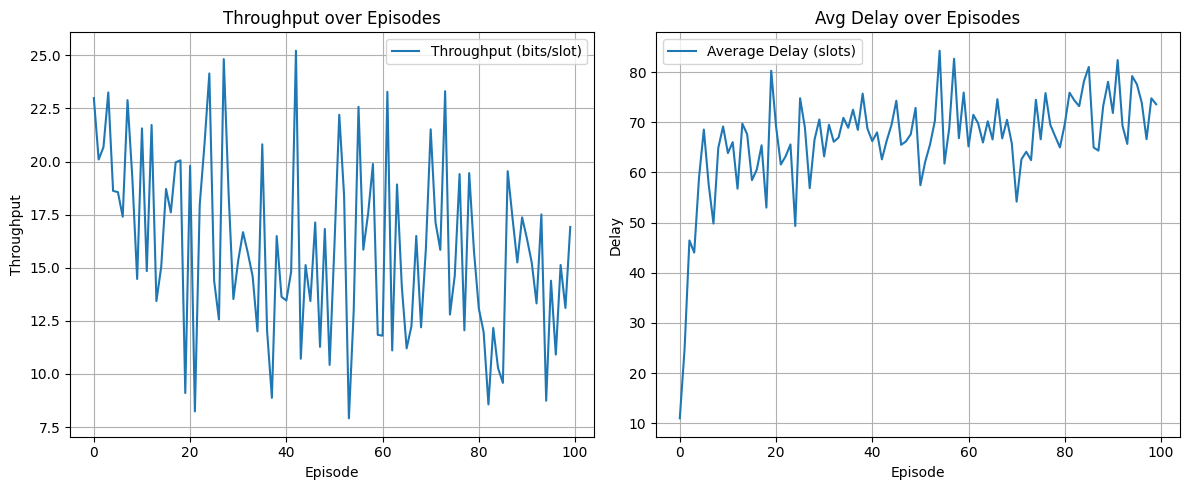

In [29]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Constants
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI
ACTION_SIZE = NUM_UES
MAX_BUFFER = 1000
CQI_LEVELS = 16
EPISODES = 100

# Environment
class UplinkEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.total_bits = 0
        self.total_delay = []
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits
        self.total_bits += tx_bits
        self.total_delay.append(np.mean(self.delay))

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done

# DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_vals = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_vals, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

# Instantiate
env = UplinkEnv()
agent = DQNAgent()

# Training Loop
episode_rewards = []
episode_throughput = []
episode_avg_delay = []

for ep in range(EPISODES):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    episode_rewards.append(total_reward)
    episode_throughput.append(env.total_bits / env.time)
    episode_avg_delay.append(np.mean(env.total_delay))
    print(f"Episode {ep+1}, Reward: {total_reward:.1f}, "
          f"Throughput: {episode_throughput[-1]:.1f} b/slot, "
          f"Delay: {episode_avg_delay[-1]:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_throughput, label="Throughput (bits/slot)")
plt.xlabel("Episode")
plt.ylabel("Throughput")
plt.grid(True)
plt.title("Throughput over Episodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(episode_avg_delay, label="Average Delay (slots)")
plt.xlabel("Episode")
plt.ylabel("Delay")
plt.grid(True)
plt.title("Avg Delay over Episodes")
plt.legend()

plt.tight_layout()
plt.show()


---

## Example of Integration with GNU-Radio 

# note that python 3.10.18 is installed for gnu radio 


Sample bits: [0 1 1 0 1 1 1 1 1 1]
Done. Output written to 'bpsk_debug_output.dat'


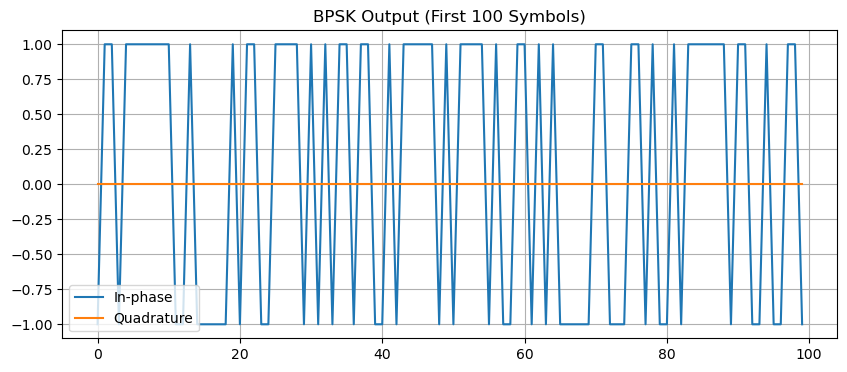

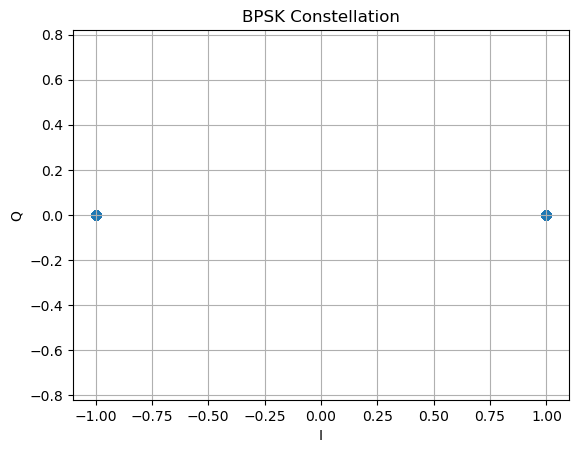

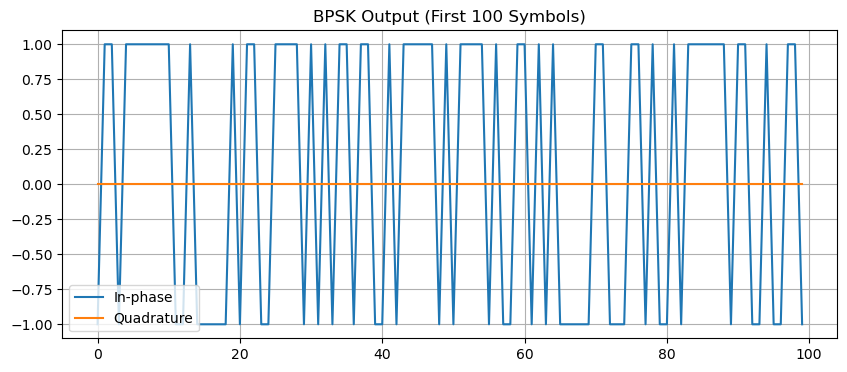

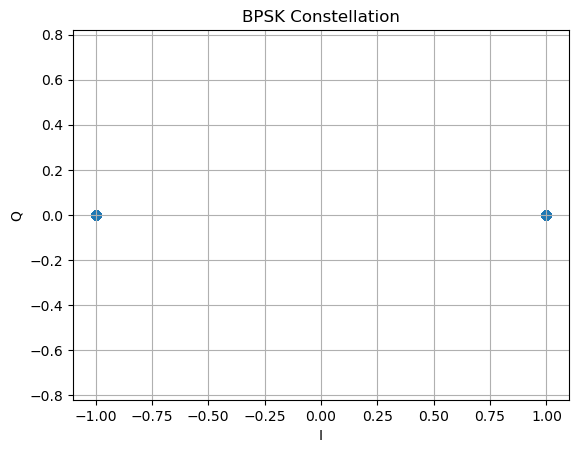

In [5]:
from gnuradio import gr, blocks, digital
import numpy as np
import matplotlib.pyplot as plt


class BPSKDebugSave(gr.top_block):
    def __init__(self):
        super().__init__()

        num_symbols = 1000
        np.random.seed(0)
        bits = np.random.randint(0, 2, num_symbols).astype(np.uint8)
        print("Sample bits:", bits[:10])

        self.src = blocks.vector_source_b(bits, False)
        self.mapper = digital.chunks_to_symbols_bc(([ -1+0j, 1+0j ]), 1)
        self.sink = blocks.file_sink(gr.sizeof_gr_complex, "bpsk_debug_output.dat")
        self.sink.set_unbuffered(True)

        self.connect(self.src, self.mapper, self.sink)


if __name__ == '__main__':
    tb = BPSKDebugSave()
    tb.start()
    tb.wait()
    print("Done. Output written to 'bpsk_debug_output.dat'")

data = np.fromfile('bpsk_debug_output.dat', dtype=np.complex64)

plt.figure(figsize=(10, 4))
plt.plot(data.real[:100], label="In-phase")
plt.plot(data.imag[:100], label="Quadrature")
plt.title("BPSK Output (First 100 Symbols)")
plt.grid()
plt.legend()

plt.figure()
plt.scatter(data.real, data.imag)
plt.title("BPSK Constellation")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid()
plt.axis('equal')

plt.show()


data = np.fromfile('bpsk_debug_output.dat', dtype=np.complex64)

plt.figure(figsize=(10, 4))
plt.plot(data.real[:100], label="In-phase")
plt.plot(data.imag[:100], label="Quadrature")
plt.title("BPSK Output (First 100 Symbols)")
plt.grid()
plt.legend()

plt.figure()
plt.scatter(data.real, data.imag)
plt.title("BPSK Constellation")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid()
plt.axis('equal')

plt.show()




In [ ]:
import sionna
# this can work with python 3.11.9
print(sionna.__version__)

1.1.0


In [4]:
from gnuradio import gr, blocks, digital, channels
import numpy as np


class BPSKSystem(gr.top_block):
    def __init__(self, snr_dB=10, num_bits=100000):
        super().__init__()

        # Parameters
        self.snr_dB = snr_dB
        self.num_bits = num_bits
        np.random.seed(42)
        self.original_bits = np.random.randint(0, 2, self.num_bits).astype(np.uint8)

        # Blocks
        self.src = blocks.vector_source_b(self.original_bits.tolist(), False)
        self.mod = digital.chunks_to_symbols_bc(([ -1.0+0j, 1.0+0j ]), 1)  # BPSK symbols
        noise_voltage = 10 ** (-self.snr_dB / 20)
        self.channel = channels.channel_model(
            noise_voltage=noise_voltage,
            frequency_offset=0.0,
            epsilon=1.0,
            taps=[1.0 + 0j],
            noise_seed=0
        )

        self.to_real = blocks.complex_to_real()  # Extract real part before slicing
        self.slicer = digital.binary_slicer_fb()
        self.sink = blocks.vector_sink_b()

        # Connections
        self.connect(self.src, self.mod)
        self.connect(self.mod, self.channel)
        self.connect(self.channel, self.to_real)
        self.connect(self.to_real, self.slicer)
        self.connect(self.slicer, self.sink)


def compute_ber(original_bits, received_bits):
    min_len = min(len(original_bits), len(received_bits))
    errors = np.sum(np.array(original_bits[:min_len]) != np.array(received_bits[:min_len]))
    ber = errors / min_len
    return ber


if __name__ == '__main__':
    tb = BPSKSystem(snr_dB=10)
    tb.start()
    tb.wait()

    rx_bits = tb.sink.data()
    ber = compute_ber(tb.original_bits, rx_bits)
    print(f"[✓] BPSK BER at {tb.snr_dB} dB SNR: {ber:.6e}")


[✓] BPSK BER at 10 dB SNR: 4.996700e-01


## **Dynamic Spectrum Sharing (DSS)**

**Dynamic Spectrum Sharing (DSS)** is a radio access technology that enables multiple wireless technologies (e.g., LTE and 5G NR) to **simultaneously share the same spectrum band**, dynamically allocating it based on demand, traffic, and user load — **in real time**.

Traditionally, operators allocate **fixed spectrum bands** to different generations of technology:

* LTE → Band X
* 5G → Band Y

But this is **inefficient** during transitions (e.g., early 5G deployments), where:

* LTE traffic may be high
* 5G traffic may be low (and vice versa)

**DSS allows** both LTE and 5G to:

* **Coexist on the same carrier frequency** (e.g., 700 MHz or 2100 MHz)
* Share **resources dynamically** at the granularity of milliseconds

### 1. **Shared Carrier**

* Both LTE and NR operate on the **same physical channel**
* Called **“NR in LTE band” (NR-LTE co-deployment)**

### 2. **Time-Domain Resource Sharing**

* The scheduler decides, **per subframe (1 ms in LTE / slot in NR)**:

  * This subframe → LTE users
  * That subframe → 5G NR users

### 3. **Resource Elements (REs)**

* LTE and 5G have different **reference signals** and **control channels**
* Some REs (e.g., LTE CRS) must be reserved even when NR is active
* NR avoids those REs → **reduces NR capacity** slightly

### How DSS Works

#### 1. **LTE CRS (Cell-specific Reference Signals)**

* Always transmitted in LTE
* NR must **avoid** using REs where LTE CRS might exist
* This introduces **overhead** for NR

#### 2. **Scheduler Decision**

* At each Transmission Time Interval (TTI):

  * The **MAC scheduler** (in gNB or eNB) decides:

    * LTE vs NR slot allocation
    * Based on:

      * UE capability
      * Buffer status
      * QoS requirements
      * Channel conditions

#### 3. **Slot-Based Switching**

* Fast switching (typically sub-10 ms)
* **No guard bands** are needed between technologies

### DSS Architecture

DSS is enabled in **two deployment modes**:

#### 1. **NSA Mode (Non-Standalone)**

* LTE is the master (control plane)
* NR is added as data-plane boost
* DSS is managed by eNB scheduler (possibly connected to gNB)

#### 2. **SA Mode (Standalone)**

* NR is the master
* DSS still applies in shared carriers
* But now gNB handles all scheduling

#### Performance Impact

| Technology   | Impact                                          |
| ------------ | ----------------------------------------------- |
| **LTE**      | Minor, but may see resource reduction           |
| **NR**       | Suffers some overhead from CRS and control gaps |
| **Capacity** | Reduced compared to dedicated 5G spectrum       |
| **Latency**  | Slightly increased due to interleaving          |


### Standards and Features

* 3GPP Release 15 and 16 define DSS under **"Multi-RAT Dual Connectivity (MR-DC)"**
* Interoperability and fairness mechanisms are specified
* Vendors like Ericsson, Nokia, and Huawei implement **proprietary DSS schedulers** on top of 3GPP


### Simplified Mathematical Model

Let’s denote:

* $B$: total bandwidth
* $\eta_{\text{LTE}}$: LTE traffic load
* $\eta_{\text{NR}} = 1 - \eta_{\text{LTE}}$: NR load
* $C_{\text{LTE}}, C_{\text{NR}}$: capacity of each system

Then:

$$
C_{\text{total}} = \eta_{\text{LTE}} \cdot C_{\text{LTE}} + \eta_{\text{NR}} \cdot C_{\text{NR}} - \text{Overhead}_{\text{CRS}}
$$

The scheduler dynamically adjusts $\eta_{\text{LTE}}$ and $\eta_{\text{NR}}$ every subframe.


### Challenges

* CRS masking in NR → complexity
* Lower NR throughput due to LTE legacy signals
* Synchronization between RATs (Radio Access Technologies)
* Scheduler fairness and priority management


| Benefit                    | Description                                 |
| -------------------------- | ------------------------------------------- |
| Spectral Efficiency        | Full reuse of existing LTE spectrum         |
| Smooth 4G-to-5G Transition | Avoids waiting for new spectrum allocations |
| Operator Flexibility       | Dynamic user-based scheduling               |

---

### A **minimal simulation of a DSS scheduling algorithm in Python**, demonstrating how an LTE/NR scheduler dynamically allocates time slots on a shared carrier.


### Simulation Goals

* Simulate **1 second** of time (1000 subframes of 1 ms)
* Fixed bandwidth (assume 10 MHz, 50 RBs)
* Assume 10 LTE UEs and 5 NR UEs with random traffic load
* Simulate **DSS scheduling** at subframe level (per 1 ms)
* Compute per-user throughput and total system efficiency

### Simplified Assumptions

* Scheduler chooses **LTE or NR** in each subframe
* If LTE is selected → serve LTE UEs
* If NR is selected → serve NR UEs
* UE buffer demand is random
* Throughput depends on number of UEs served


### DSS Scheduler Heuristic

We'll use a **proportional-load-weighted scheduler**:

$$
\text{LTE\_load\_ratio} = \frac{\sum \text{LTE buffer}}{\sum \text{LTE buffer} + \sum \text{NR buffer}}
$$

If LTE load > NR load → allocate that subframe to LTE.


### Extensions

| Feature                      | Description                              |
| ---------------------------- | ---------------------------------------- |
| Adaptive MCS                 | Vary throughput per user per CQI/SNR     |
| Delay/QoS-aware Scheduling   | Prioritize NR latency-sensitive traffic  |
| Fairness Metric (Jain index) | Evaluate fairness across users           |
| Traffic Models               | Use Poisson arrival rates                |
| Slot-level RE masking        | Deduct NR capacity when LTE CRS overlaps |


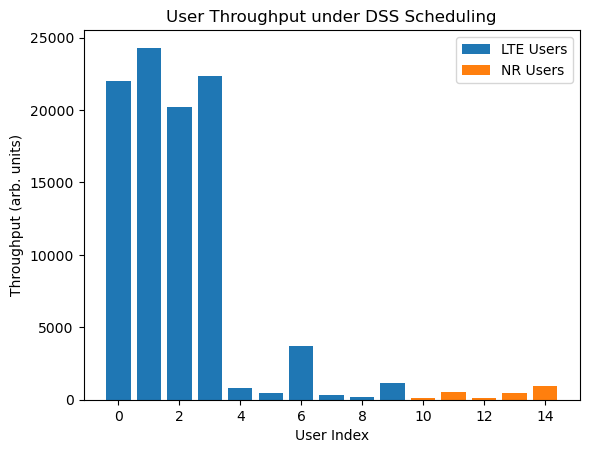

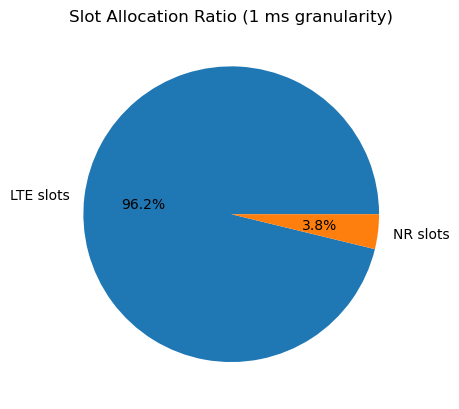

Total LTE Throughput: 95564.0
Total NR Throughput:  2110.0
Total System Throughput: 97674.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
num_subframes = 1000  # 1 second of traffic
num_lte_users = 10
num_nr_users = 5
max_buffer = 100  # Max bits per subframe per user
rb_capacity = 100  # Throughput per user if selected [arbitrary units]

# Buffers and stats
lte_buffer = np.random.randint(10, max_buffer, num_lte_users)
nr_buffer = np.random.randint(10, max_buffer, num_nr_users)

lte_throughput = np.zeros(num_lte_users)
nr_throughput = np.zeros(num_nr_users)

lte_slot_count = 0
nr_slot_count = 0

# Simulation loop
for t in range(num_subframes):
    total_lte = np.sum(lte_buffer)
    total_nr = np.sum(nr_buffer)

    # Scheduler decision: pick LTE or NR
    if total_lte >= total_nr:
        # Allocate this subframe to LTE
        lte_slot_count += 1
        active_users = np.argsort(-lte_buffer)[:4]  # Serve top 4 users
        for u in active_users:
            tx = min(lte_buffer[u], rb_capacity)
            lte_buffer[u] -= tx
            lte_throughput[u] += tx
            lte_buffer[u] += np.random.randint(0, 50)  # Refill randomly
    else:
        # Allocate this subframe to NR
        nr_slot_count += 1
        active_users = np.argsort(-nr_buffer)[:2]  # Serve top 2 NR users
        for u in active_users:
            tx = min(nr_buffer[u], rb_capacity)
            nr_buffer[u] -= tx
            nr_throughput[u] += tx
            nr_buffer[u] += np.random.randint(0, 50)

# Plot results
plt.figure()
plt.bar(range(num_lte_users), lte_throughput, label='LTE Users')
plt.bar(np.arange(num_nr_users) + num_lte_users, nr_throughput, label='NR Users')
plt.title("User Throughput under DSS Scheduling")
plt.xlabel("User Index")
plt.ylabel("Throughput (arb. units)")
plt.legend()

plt.figure()
plt.pie([lte_slot_count, nr_slot_count], labels=["LTE slots", "NR slots"], autopct='%1.1f%%')
plt.title("Slot Allocation Ratio (1 ms granularity)")

plt.show()

# Efficiency
total_throughput = np.sum(lte_throughput) + np.sum(nr_throughput)
print(f"Total LTE Throughput: {np.sum(lte_throughput):.1f}")
print(f"Total NR Throughput:  {np.sum(nr_throughput):.1f}")
print(f"Total System Throughput: {total_throughput:.1f}")

---

### A **simple SDR (Software-Defined Radio)** example using **GNU Radio + Python**. 

### **SDR Project: Sine Wave Transmitter + Receiver Simulation (No Hardware)**

* Signal generation
* Virtual transmission
* Receiver processing
* Visualization


### Overview

| Component     | Block                    | Description                |
| ------------- | ------------------------ | -------------------------- |
| Transmitter   | `analog.sig_source_f`    | Generates sine wave        |
| Channel       | `channels.channel_model` | Adds noise                 |
| Receiver      | `blocks.throttle`        | Limits rate for simulation |
| Visualization | `qtgui.time_sink_f`      | Real-time plotting         |


* **SDR** = Software-defined processing chain from Tx to Rx
* Everything is simulated in software using GNU Radio blocks
* No RF hardware required



### Next Steps

* **BPSK/QPSK modulation**
* **Live I/Q recording**
* **RTL-SDR or HackRF real Tx/Rx**
* **OFDM or audio streaming**


In [2]:
from gnuradio import gr, analog, blocks, qtgui, channels
from PyQt5 import Qt
import sip
import sys


class SimpleSDR(gr.top_block, Qt.QWidget):
    def __init__(self):
        gr.top_block.__init__(self, "Simple SDR Chain")
        Qt.QWidget.__init__(self)

        self.setWindowTitle("SDR Simulated Tx-Rx Chain")
        self.layout = Qt.QVBoxLayout()
        self.setLayout(self.layout)

        samp_rate = 32000
        freq = 1e3
        noise_level = 0.01

        # Use complex signal
        self.source = analog.sig_source_c(samp_rate, analog.GR_COS_WAVE, freq, 1.0)
        self.channel = channels.channel_model(
            noise_voltage=noise_level,
            frequency_offset=0.0,
            epsilon=1.0,
            taps=[1.0 + 0j]
        )
        self.throttle = blocks.throttle(gr.sizeof_gr_complex, samp_rate)
        self.sink = qtgui.time_sink_c(1024, samp_rate, "Received Complex Signal", 1)

        self.layout.addWidget(sip.wrapinstance(self.sink.qwidget(), Qt.QWidget))

        # Connections
        self.connect(self.source, self.throttle)
        self.connect(self.throttle, self.channel)
        self.connect(self.channel, self.sink)


def main():
    app = Qt.QApplication(sys.argv)
    tb = SimpleSDR()
    tb.show()
    tb.start()
    app.exec_()
    tb.stop()
    tb.wait()


if __name__ == '__main__':
    main()


: 

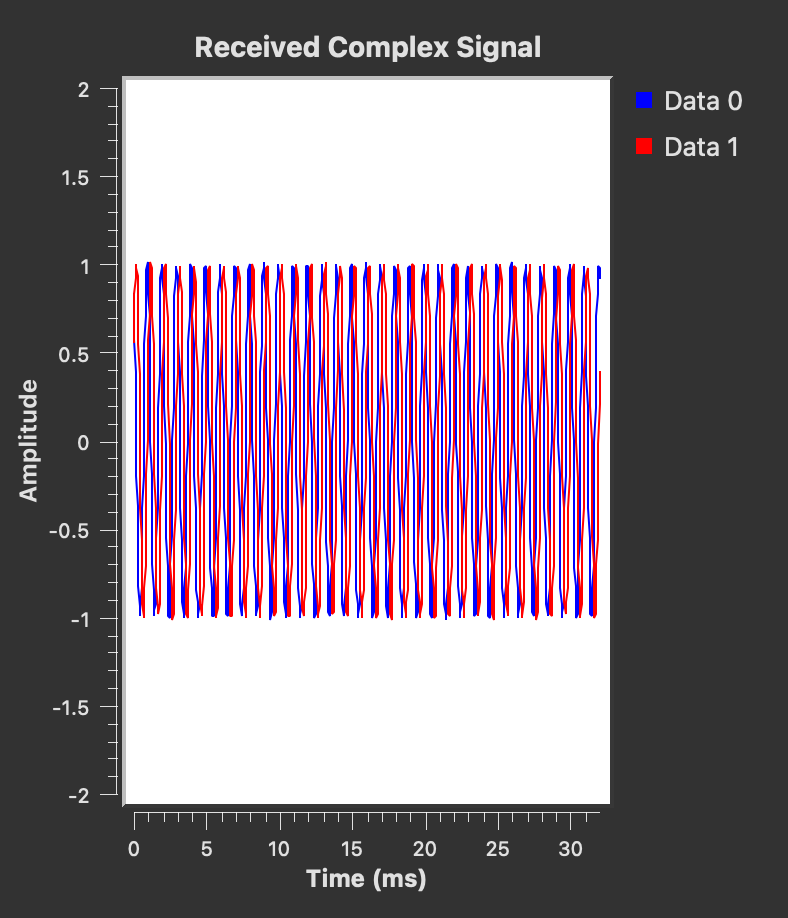

---

## **QPSK Transmitter using RTL-SDR (TX Side)**

> Note: RTL-SDR is **receive-only** by design.
> To **transmit**, you need hardware like:

* **HackRF One**
* **LimeSDR**
* **PlutoSDR**
* **USRP**

If you're using RTL-SDR, we can **receive only** (e.g., QPSK demodulator)

### For **TX + RX** using **PlutoSDR or HackRF**, here’s how to proceed.


### QPSK SDR TX (HackRF or PlutoSDR)

| Block                   | Function                                   |
| ----------------------- | ------------------------------------------ |
| `vector_source_b`       | Random bits                                |
| `chunks_to_symbols_bc`  | QPSK mapper (00 → -1-1j, 01 → -1+1j, etc.) |
| `RRC filter`            | Pulse shaping                              |
| `UHD/Pluto/HackRF sink` | Send over RF                               |


### Requirements

* GNU Radio
* `osmosdr` Python bindings (`conda install gnuradio-osmosdr`)
* HackRF or supported TX hardware

---

### If You're Using RTL-SDR (RX-Only)

You can **demodulate QPSK** using:

* `osmosdr.source()`
* `low-pass filter`
* `symbol timing recovery`
* `constellation decoder`


In [ ]:
from gnuradio import gr, blocks, analog, digital, filter, analog, qtgui
import osmosdr
import numpy as np
import time
## connect to HackRF or other SDR device

class QPSK_TX(gr.top_block):
    def __init__(self):
        super().__init__()

        # Parameters
        samp_rate = 1e6
        symbol_rate = 100e3
        samples_per_symbol = int(samp_rate / symbol_rate)

        # QPSK mapping (Gray coding)
        qpsk_constellation = [
            -1 - 1j, -1 + 1j,
            1 - 1j,  1 + 1j
        ]

        bits = np.random.randint(0, 4, 100000).astype(np.uint8)  # 2-bit symbols

        # Blocks
        self.src = blocks.vector_source_b(bits.tolist(), True)
        self.mapper = digital.chunks_to_symbols_bc(qpsk_constellation, 1)

        # RRC Filter
        rrc_taps = filter.firdes.root_raised_cosine(
            gain=1.0,
            sampling_freq=samp_rate,
            symbol_rate=symbol_rate,
            alpha=0.35,
            ntaps=11 * samples_per_symbol
        )
        self.rrc = filter.interp_fir_filter_ccf(samples_per_symbol, rrc_taps)

        # SDR Sink (HackRF)
        self.sink = osmosdr.sink(args="hackrf=0")
        self.sink.set_sample_rate(samp_rate)
        self.sink.set_center_freq(915e6)  # ISM band
        self.sink.set_gain(20)

        # Connections
        self.connect(self.src, self.mapper)
        self.connect(self.mapper, self.rrc)
        self.connect(self.rrc, self.sink)


if __name__ == '__main__':
    tb = QPSK_TX()
    tb.start()
    print("Transmitting QPSK via SDR...")
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        tb.stop()
        tb.wait()

# Future Direction 

- Test cases for NR Scheduler and 3GPP Standards related to MAC, RLC, PDCP
- Al powered radio resource management features
- IP networking 
- LMS/RMS filter 
- Kalman filter and application in wireless 
- Particle filters 
- cellular architecture model 
- RL in detail 
- ML models used in wireless 
- RL + dynamic beamforming 
- digital twins
- DCO-OFDM with QAM 
- coherent detection 
- fiber optics 
- NOMA / OFDMA / CDMA 
- 4G/5G bands (theory)
- MAC scheduling + RL 
- RIS + massive MIMO and beamforming 
